# ASTR 8070: Astrostatistics
***N. Pol***
___

# Homework 5
### Due: Friday, Mar 7nd at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw5_data_1.npy`. This is a (100 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

### Solution

In [24]:
#import things
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy import optimize
from scipy.stats import norm
from scipy.stats import uniform
from astroML import stats as astroMLstats
from scipy.stats import laplace
import corner
import numdifftools as nd
from scipy.stats import uniform
from scipy import stats
import numpy as np
import emcee

### Part 1

Text(0.5, 1.0, 'Flux Time Series')

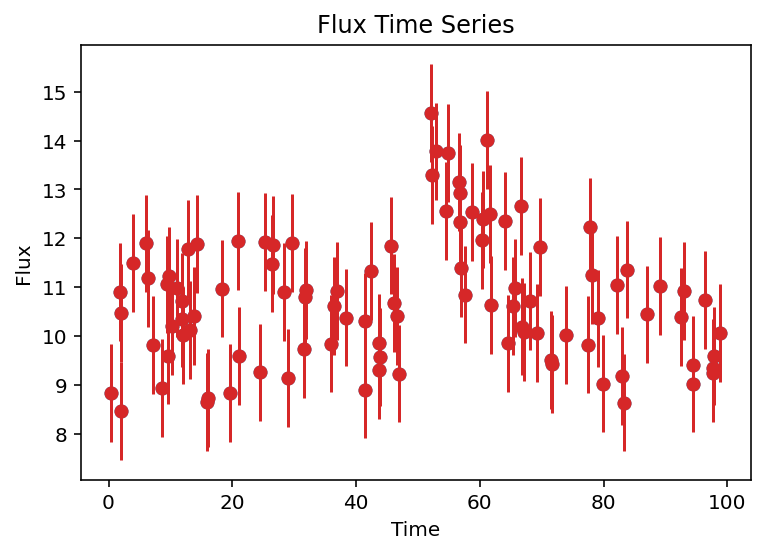

In [87]:
#1 same as HW3
#read in the data
data=np.load('../../../homeworks/hw_data/hw5_data_1.npy')
#slice array
time=data[:,0]
flux=data[:,1]
error=data[:,2]

#plotting time series
fig = plt.scatter(time,flux)
plt.errorbar(time,flux,error,fmt="o",color="C3")#loc="lower right"
#C0 blue,C1 orange,C2 GREEN, C3 red, C4 weak purple 
plt.axis
plt.xlabel("Time")
plt.ylabel("Flux")
plt.title("Flux Time Series")

## Part 2

In [148]:
#need to code the function for each t region piecewise
def model(params,x):
    #set up parameters
    t_0,b,A,alpha=params
    #prepare to loop though time
    expburst=np.zeros_like(x)
    for i in range(len(x)):
        #when we are less than t0
        if x[i]<t_0:
            expburst[i]=b
        #greater than t0
        else:
            expburst[i]=b+A*(np.exp(-alpha*(x[i]-t_0)))
    return expburst
    
#gaussian likelyhood function that includes params
def log_likelihood(params, x, y, yerr):
    #set model to our burst
    y_model = model(params, x)
    #our regular gauss likely
    return -0.5 * np.sum(((y - y_model) / yerr)**2)

## Part 3

In [150]:
# we need to combine our priors and likelihood to get probability
def log_probability(params, x, y, yerr):
    #get the prior
    log_p = log_prior(params)
    #if we have inf kill it
    if not np.isfinite(log_p):
        return -np.inf
    #combine where finite
    return log_p + log_likelihood(params, x, y, yerr)

#we should the prior on each parameter on range defined in quesiton
#took some code from google
def log_prior(params):
    t_0,b,A,alpha=params
    #uniform for each param
    if 0< t_0 < 100 and 0< b < 50 and 0<A<50 and -5<alpha<5:
        return 0.0
    #kill anything that is not in range 
    return -np.inf


#redifine some variables to make life easier 
x = time
y=flux
yerr = error


In [343]:
# getting ready to sample
dim = 4  # Number of parameters
walkers = 32  # Number of walkers
guess = np.random.randn(walkers, dim) #create an inital guess to start each walker
# get our sampler
sampler = emcee.EnsembleSampler(walkers, dim, log_probability, args=(x, y, yerr))

#choose number of steps and run sampler
n = 100000 # Number of steps
#sample
sampler.run_mcmc(guess, n, progress=True)

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [09:51<00:00, 168.93it/s]


State([[48.41370804 10.4771582   7.66536661  0.17018136]
 [47.1710317  10.39032125  7.27805232  0.13264125]
 [47.66628391 10.35748917  5.78768571  0.1128423 ]
 [47.22381531 10.41636307 11.27134177  0.17638276]
 [51.42961002 10.47195937  4.4319133   0.13792183]
 [47.19072479 10.52246293  7.45028655  0.11963453]
 [48.74432833 10.4285147   7.15331788  0.15433718]
 [51.98078501 10.50576024  2.72211364  0.10223349]
 [49.06427348 10.33679997  5.95867264  0.13945911]
 [47.75298935 10.28760974  7.04939455  0.11962982]
 [52.13689234 10.28951982  3.67281808  0.09326168]
 [47.15010978 10.44161497  3.52619186  0.07145724]
 [49.93117662 10.23568128  5.34017614  0.09654991]
 [48.99980437 10.35710686  6.72428296  0.13156465]
 [46.96212442 10.4286887   5.71206659  0.10805558]
 [47.09105427 10.05620936  7.80292463  0.1129753 ]
 [48.96962454 10.44378788  5.68281226  0.10883913]
 [52.03455856 10.38745489  3.01031073  0.08644005]
 [49.90635407 10.34147457  6.20071767  0.16095237]
 [48.64100197 10.08241944

## Part 4

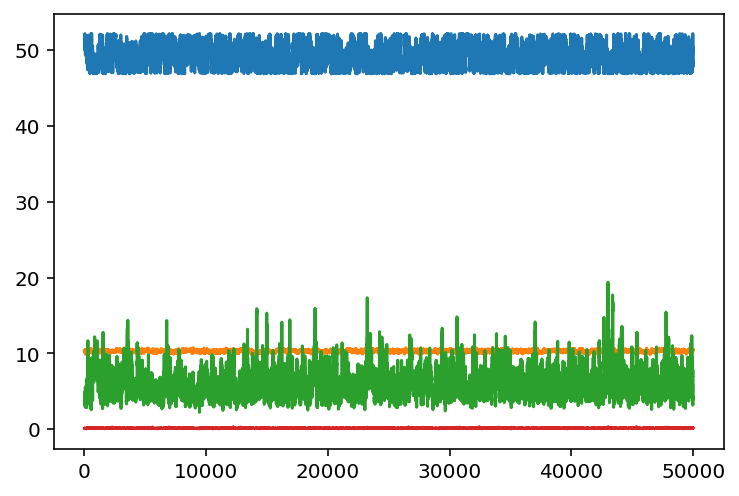

In [344]:
# Load in the chain
samples = sampler.get_chain()  
#call it chain
chain = samples
#try different amounts of burn
# check burn 10000-50000
#plotting all 4 chains
plt.plot(chain[50000::,0]);


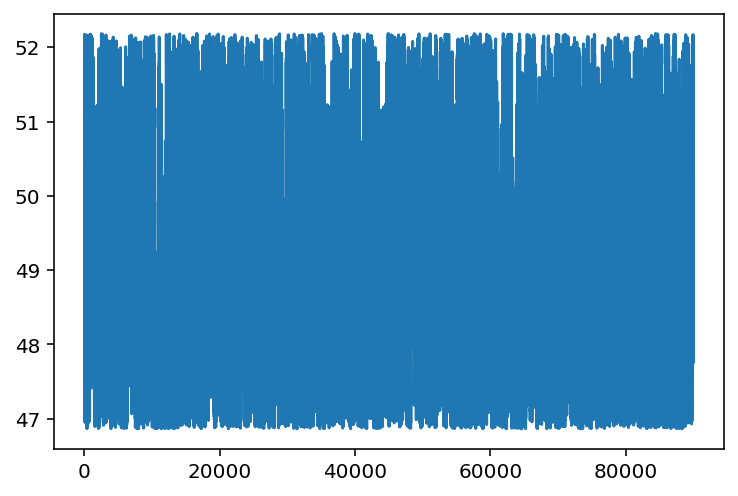

In [362]:
#can also check indiviulal chains
#try different amounts of burn 
#burn first 10000-25000
plt.plot(chain[10000::,0,0]); #0 is t_0

In [364]:
#thin with the acor length
import acor
thin = int(acor.acor(chain[::,0][0]))
#this part isn't working so I am setting thin=1
autotime = sampler.get_autocorr_time()
print("taus",autotime)

taus [474.17392735  61.31035685 229.33612389 926.78374503]


We should be fine to consider the acor length to be 1. We are well above the number of samples for each parameter given by acor time. This means each draw should only depend on the previous one.

I increased the number of samples in part 3. These chains are burnt in and look like fuzzy caterpillars.

## Part 5

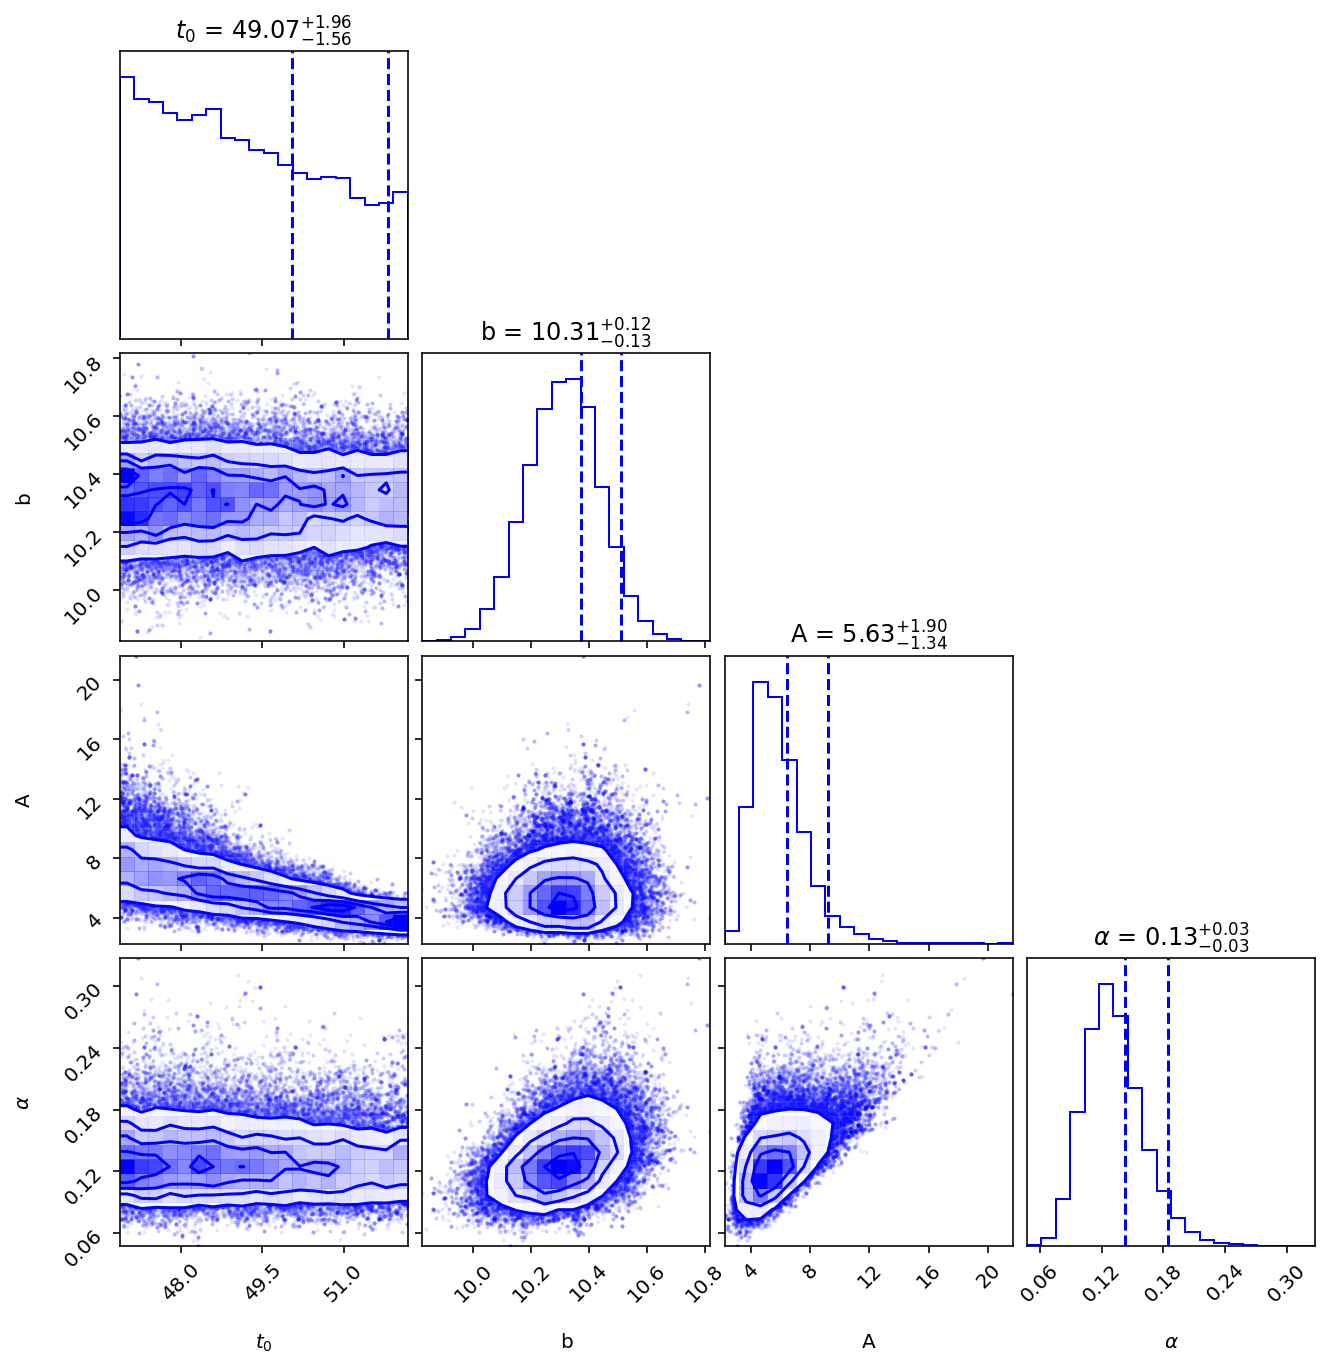

In [305]:
#create a corner plot for the 4d sample space
import corner
#make the plot with labels and quants

corner.corner(chain[10000::,0],labels=[r'$t_{0}$','b','A',r'$\alpha$'],quantiles=[.68,.95],show_titles=True,color='b');


## Part 6

Text(0.5, 1.0, 'Flux Time Series')

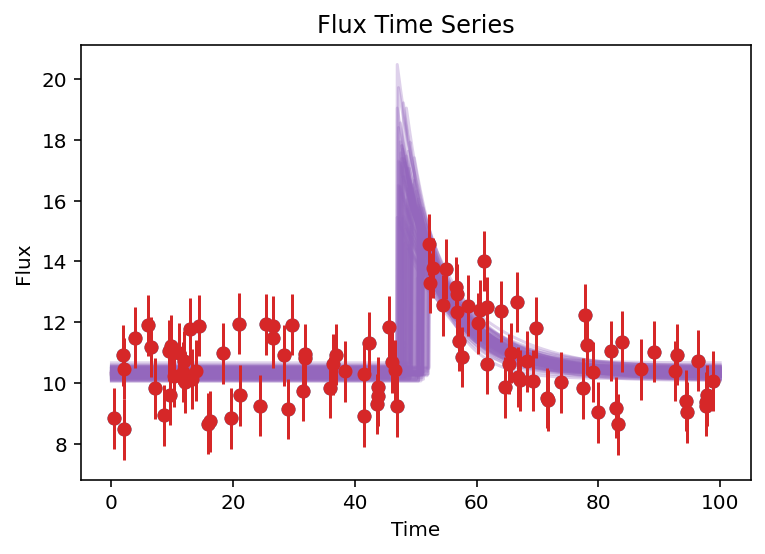

In [261]:
#take 100 draws chain
#picking 100 indexes to select values from
random_draw=np.random.randint(0,len(chain[10000::,0]),size=100)
#loop through each draw
for index in random_draw:
    #get param values
    theta=chain[10000::,0][index]
    #grid to plot
    xgrid=np.linspace(0,100,1000)
    #remind myself param order
    #r'$t_{0}$','b','A',r'$\alpha$'
    #set each param to the draw value
    t_0=theta[0]
    b=theta[1]
    A=theta[2]
    alpha=theta[3]
    #get exp function
    burst=model(theta,xgrid)
    #plot the draw
    plt.plot(xgrid,burst,color="C4",alpha=.3)

#plotting the original data
plt.scatter(time,flux)
plt.errorbar(time,flux,error,fmt="o",color="C3")#loc="lower right"
#C0 blue,C1 orange,C2 GREEN, C3 red, C4 weak purple 
plt.axis
plt.xlabel("Time")
plt.ylabel("Flux")
plt.title("Flux Time Series")


Text(0.5, 1.0, 'Flux Time Series')

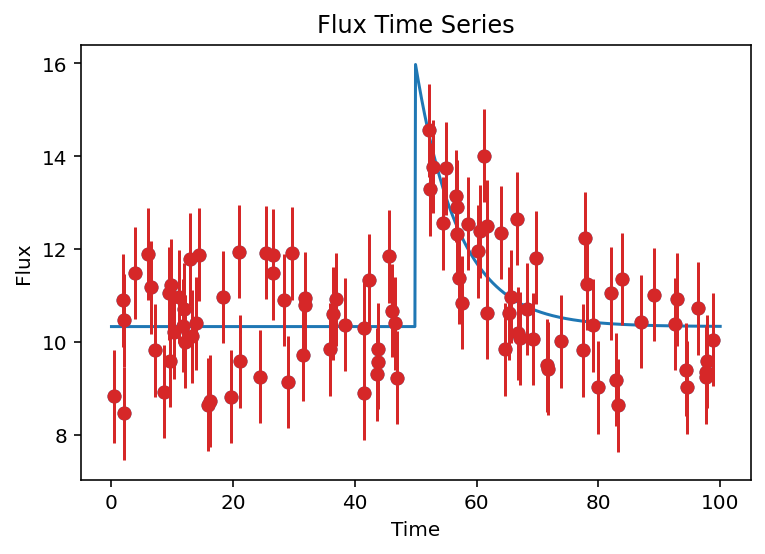

In [262]:
#sanity check for just 1 draw
xgrid=np.linspace(0,100,1000)
    #r'$t_{0}$','b','A',r'$\alpha$'
theta=[49.89387643,10.33366472,5.68952527,0.1412021 ]
burst=model(theta,xgrid)
plt.plot(xgrid,burst)
    #plotting data
plt.scatter(time,flux)
plt.errorbar(time,flux,error,fmt="o",color="C3")#loc="lower right"
#C0 blue,C1 orange,C2 GREEN, C3 red, C4 weak purple 
plt.axis
plt.xlabel("Time")
plt.ylabel("Flux")
plt.title("Flux Time Series")

This look good. The drawn values match what I would expect by eye. 

## Part 7

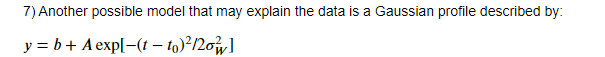

Here I am mostly using lecture 12 but also some code from https://johannesbuchner.github.io/UltraNest/example-sine-modelcomparison.html

In [288]:
#we need to model the new function
def model_gauss(params,x):
    t_0,b,A,sig_w=params #parameters
    gauss=b+A*np.exp((-(x-t_0)**2)/(2*sig_w**2)) #equation from above
    return gauss
#we should the prior on each parameter on range defined in quesiton
#following form in lecture 12
def my_prior_transform0(cube):
    params = cube.copy()

    # transform t_0 parameter: uniform prior
    lo = 0
    hi = 100
    params[0] = cube[0] * (hi - lo) + lo

    # transform sig_2 parameter: log-uniform prior
    params[3] = 10**stats.norm.ppf(cube[3], 0, 2)
    
    # transform b parameter: uniform prior
    lo = 0
    hi = 50
    params[1] = cube[1] * (hi - lo) + lo
    
    
    # transform A parameter: uniform prior
    lo = 0
    hi = 50
    params[2] = cube[2] * (hi - lo) + lo

    return params

#following lecture 12
def my_prior_transform1(cube):
    params = cube.copy()

    # transform t_0 parameter: uniform prior
    lo = 0
    hi = 100
    params[0] = cube[0] * (hi - lo) + lo
    
    # transform A parameter: uniform prior
    lo = 0
    hi = 50
    params[2] = cube[2] * (hi - lo) + lo

    # transform alpha parameter: log-uniform prior
    params[3] = 10**stats.norm.ppf(cube[3], 0, 5)
    
    # transform b parameter: uniform prior
    lo = 0
    hi = 50
    params[1] = cube[1] * (hi - lo) + lo

    return params

In [289]:
#following tutorial link

def my_likelihood(params):
    t_0,b,A,sig_w=params
    # compute intensity at every x position according to the model
    y_model = model_gauss(params,x)
    # compare model and data with gaussian likelihood:
    like = -0.5 * (((y_model - y)/yerr)**2).sum()
    return like

#gaussian likelyhood function that includes params
def my_likelihood1(params):
    t_0,b,A,alpha=params
    y_model = model(params, x)
    like = -0.5 * (((y_model - y)/yerr)**2).sum()
    return like

In [290]:
#get ultranest
import ultranest
parameters0= ['t_0', 'b', 'A','sig_2'] #params gauss
parameters1= ['t_0', 'b', 'A','alpha'] #params burst

#set up samplers
sampler0 = ultranest.ReactiveNestedSampler(parameters0, my_likelihood, 
                                          my_prior_transform0)

sampler1 = ultranest.ReactiveNestedSampler(parameters1, my_likelihood1, my_prior_transform1)

DEBUG:ultranest:ReactiveNestedSampler: dims=4+0, resume=False, log_dir=None, backend=hdf5, vectorized=False, nbootstraps=30, ndraw=128..65536
DEBUG:ultranest:ReactiveNestedSampler: dims=4+0, resume=False, log_dir=None, backend=hdf5, vectorized=False, nbootstraps=30, ndraw=128..65536


In [291]:
#sample burst
result1 = sampler1.run(min_num_live_points=400)
sampler1.print_results()

[ultranest] Sampling 400 live points from prior ...


INFO:ultranest:Sampling 400 live points from prior ...
DEBUG:ultranest:run_iter dlogz=0.5, dKL=0.5, frac_remain=0.01, Lepsilon=0.0010, min_ess=400
DEBUG:ultranest:max_iters=-1, max_ncalls=-1, max_num_improvement_loops=-1, min_num_live_points=400, cluster_num_live_points=40
DEBUG:ultranest:minimal_widths_sequence: [(-inf, 400.0), (inf, 400.0)]


DEBUG:ultranest:iteration=0, ncalls=401, regioncalls=40, ndraw=40, logz=-inf, remainder_fraction=100.0000%, Lmin=-262987.06, Lmax=-87.30


DEBUG:ultranest:iteration=22, ncalls=423, regioncalls=920, ndraw=40, logz=-106653.98, remainder_fraction=100.0000%, Lmin=-101115.16, Lmax=-87.30


DEBUG:ultranest:iteration=40, ncalls=442, regioncalls=1680, ndraw=40, logz=-78591.12, remainder_fraction=100.0000%, Lmin=-77404.43, Lmax=-87.30


DEBUG:ultranest:iteration=69, ncalls=475, regioncalls=3000, ndraw=40, logz=-67542.23, remainder_fraction=100.0000%, Lmin=-66962.48, Lmax=-87.30


DEBUG:ultranest:iteration=80, ncalls=493, regioncalls=3720, ndraw=40, logz=-63112.89, remainder_fraction=100.0000%, Lmin=-63036.42, Lmax=-87.30


DEBUG:ultranest:iteration=90, ncalls=506, regioncalls=4240, ndraw=40, logz=-60577.36, remainder_fraction=100.0000%, Lmin=-60316.75, Lmax=-87.30


DEBUG:ultranest:iteration=120, ncalls=544, regioncalls=5760, ndraw=40, logz=-49285.87, remainder_fraction=100.0000%, Lmin=-49106.09, Lmax=-87.30


DEBUG:ultranest:iteration=154, ncalls=590, regioncalls=7600, ndraw=40, logz=-40618.66, remainder_fraction=100.0000%, Lmin=-40604.41, Lmax=-87.30


DEBUG:ultranest:iteration=160, ncalls=597, regioncalls=7880, ndraw=40, logz=-39710.26, remainder_fraction=100.0000%, Lmin=-39617.09, Lmax=-87.30
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2], dtype=int64), array([399,   1], dtype=int64))


DEBUG:ultranest:iteration=180, ncalls=630, regioncalls=9200, ndraw=40, logz=-36339.81, remainder_fraction=100.0000%, Lmin=-36049.79, Lmax=-87.30


DEBUG:ultranest:iteration=200, ncalls=660, regioncalls=10400, ndraw=40, logz=-31423.52, remainder_fraction=100.0000%, Lmin=-31364.32, Lmax=-87.30


DEBUG:ultranest:iteration=239, ncalls=714, regioncalls=12560, ndraw=40, logz=-23886.58, remainder_fraction=100.0000%, Lmin=-23743.16, Lmax=-87.30


DEBUG:ultranest:iteration=240, ncalls=715, regioncalls=12600, ndraw=40, logz=-23749.75, remainder_fraction=100.0000%, Lmin=-23599.11, Lmax=-87.30


DEBUG:ultranest:iteration=269, ncalls=775, regioncalls=15000, ndraw=40, logz=-20265.55, remainder_fraction=100.0000%, Lmin=-20084.60, Lmax=-87.30


DEBUG:ultranest:iteration=270, ncalls=776, regioncalls=15040, ndraw=40, logz=-20091.26, remainder_fraction=100.0000%, Lmin=-20003.82, Lmax=-87.30


DEBUG:ultranest:iteration=280, ncalls=790, regioncalls=15600, ndraw=40, logz=-18054.20, remainder_fraction=100.0000%, Lmin=-17950.47, Lmax=-87.30


DEBUG:ultranest:iteration=313, ncalls=838, regioncalls=17520, ndraw=40, logz=-13435.81, remainder_fraction=100.0000%, Lmin=-13345.72, Lmax=-87.30


DEBUG:ultranest:iteration=320, ncalls=849, regioncalls=17960, ndraw=40, logz=-12929.68, remainder_fraction=100.0000%, Lmin=-12922.65, Lmax=-87.30


DEBUG:ultranest:iteration=352, ncalls=895, regioncalls=19800, ndraw=40, logz=-10795.21, remainder_fraction=100.0000%, Lmin=-10648.23, Lmax=-87.30


DEBUG:ultranest:iteration=360, ncalls=909, regioncalls=20360, ndraw=40, logz=-10258.45, remainder_fraction=100.0000%, Lmin=-10160.15, Lmax=-87.30


DEBUG:ultranest:iteration=394, ncalls=956, regioncalls=22240, ndraw=40, logz=-8544.34, remainder_fraction=100.0000%, Lmin=-8500.30, Lmax=-87.30


DEBUG:ultranest:iteration=400, ncalls=967, regioncalls=22680, ndraw=40, logz=-8432.15, remainder_fraction=100.0000%, Lmin=-8328.22, Lmax=-87.30


DEBUG:ultranest:iteration=428, ncalls=1016, regioncalls=24640, ndraw=40, logz=-7057.53, remainder_fraction=100.0000%, Lmin=-7009.97, Lmax=-87.12


DEBUG:ultranest:iteration=440, ncalls=1042, regioncalls=25680, ndraw=40, logz=-6485.86, remainder_fraction=100.0000%, Lmin=-6384.98, Lmax=-87.12


DEBUG:ultranest:iteration=450, ncalls=1058, regioncalls=26320, ndraw=40, logz=-6023.12, remainder_fraction=100.0000%, Lmin=-5986.55, Lmax=-87.12


DEBUG:ultranest:iteration=479, ncalls=1118, regioncalls=28720, ndraw=40, logz=-5154.43, remainder_fraction=100.0000%, Lmin=-5034.08, Lmax=-87.12


DEBUG:ultranest:iteration=480, ncalls=1119, regioncalls=28760, ndraw=40, logz=-5041.27, remainder_fraction=100.0000%, Lmin=-5003.84, Lmax=-87.12


DEBUG:ultranest:iteration=512, ncalls=1181, regioncalls=31240, ndraw=40, logz=-4208.62, remainder_fraction=100.0000%, Lmin=-4195.65, Lmax=-87.12


DEBUG:ultranest:iteration=520, ncalls=1192, regioncalls=31680, ndraw=40, logz=-4082.84, remainder_fraction=100.0000%, Lmin=-4066.35, Lmax=-87.12


DEBUG:ultranest:iteration=540, ncalls=1232, regioncalls=33280, ndraw=40, logz=-3805.12, remainder_fraction=100.0000%, Lmin=-3797.69, Lmax=-87.12


DEBUG:ultranest:iteration=560, ncalls=1269, regioncalls=34760, ndraw=40, logz=-3529.53, remainder_fraction=100.0000%, Lmin=-3505.45, Lmax=-87.12


DEBUG:ultranest:iteration=594, ncalls=1326, regioncalls=37080, ndraw=40, logz=-3042.24, remainder_fraction=100.0000%, Lmin=-3015.39, Lmax=-87.12


DEBUG:ultranest:iteration=600, ncalls=1338, regioncalls=37560, ndraw=40, logz=-2989.90, remainder_fraction=100.0000%, Lmin=-2975.65, Lmax=-87.12


DEBUG:ultranest:iteration=628, ncalls=1398, regioncalls=39960, ndraw=40, logz=-2710.15, remainder_fraction=100.0000%, Lmin=-2687.82, Lmax=-87.12


DEBUG:ultranest:iteration=630, ncalls=1400, regioncalls=40040, ndraw=40, logz=-2688.08, remainder_fraction=100.0000%, Lmin=-2665.80, Lmax=-87.12


DEBUG:ultranest:iteration=640, ncalls=1424, regioncalls=41000, ndraw=40, logz=-2625.97, remainder_fraction=100.0000%, Lmin=-2617.15, Lmax=-87.12


DEBUG:ultranest:iteration=669, ncalls=1484, regioncalls=43400, ndraw=40, logz=-2293.38, remainder_fraction=100.0000%, Lmin=-2279.27, Lmax=-87.12


DEBUG:ultranest:iteration=680, ncalls=1513, regioncalls=44560, ndraw=40, logz=-2160.92, remainder_fraction=100.0000%, Lmin=-2136.69, Lmax=-87.12


DEBUG:ultranest:iteration=702, ncalls=1582, regioncalls=47320, ndraw=40, logz=-1892.29, remainder_fraction=100.0000%, Lmin=-1883.96, Lmax=-87.12


DEBUG:ultranest:iteration=720, ncalls=1644, regioncalls=49800, ndraw=40, logz=-1721.64, remainder_fraction=100.0000%, Lmin=-1711.67, Lmax=-80.49


DEBUG:ultranest:iteration=740, ncalls=1715, regioncalls=52640, ndraw=40, logz=-1580.06, remainder_fraction=100.0000%, Lmin=-1568.90, Lmax=-80.49


DEBUG:ultranest:iteration=760, ncalls=1763, regioncalls=54560, ndraw=40, logz=-1454.19, remainder_fraction=100.0000%, Lmin=-1439.60, Lmax=-80.49


DEBUG:ultranest:iteration=785, ncalls=1828, regioncalls=57160, ndraw=40, logz=-1329.32, remainder_fraction=100.0000%, Lmin=-1319.21, Lmax=-80.49


DEBUG:ultranest:iteration=800, ncalls=1863, regioncalls=58560, ndraw=40, logz=-1262.27, remainder_fraction=100.0000%, Lmin=-1249.71, Lmax=-80.49


DEBUG:ultranest:iteration=810, ncalls=1893, regioncalls=59760, ndraw=40, logz=-1217.09, remainder_fraction=100.0000%, Lmin=-1205.87, Lmax=-80.49


DEBUG:ultranest:iteration=829, ncalls=1967, regioncalls=62720, ndraw=40, logz=-1105.02, remainder_fraction=100.0000%, Lmin=-1091.12, Lmax=-80.49


DEBUG:ultranest:iteration=840, ncalls=2017, regioncalls=64720, ndraw=40, logz=-1036.81, remainder_fraction=100.0000%, Lmin=-1022.66, Lmax=-80.49


DEBUG:ultranest:iteration=861, ncalls=2088, regioncalls=67560, ndraw=40, logz=-965.37, remainder_fraction=100.0000%, Lmin=-957.42, Lmax=-80.49


DEBUG:ultranest:iteration=880, ncalls=2151, regioncalls=70080, ndraw=40, logz=-907.76, remainder_fraction=100.0000%, Lmin=-896.94, Lmax=-80.49


DEBUG:ultranest:iteration=895, ncalls=2229, regioncalls=73200, ndraw=40, logz=-853.86, remainder_fraction=100.0000%, Lmin=-843.57, Lmax=-80.49


DEBUG:ultranest:iteration=900, ncalls=2259, regioncalls=74400, ndraw=40, logz=-844.18, remainder_fraction=100.0000%, Lmin=-835.57, Lmax=-80.49


DEBUG:ultranest:iteration=916, ncalls=2333, regioncalls=77360, ndraw=40, logz=-800.65, remainder_fraction=100.0000%, Lmin=-792.49, Lmax=-80.49


DEBUG:ultranest:iteration=920, ncalls=2356, regioncalls=78280, ndraw=40, logz=-796.29, remainder_fraction=100.0000%, Lmin=-787.61, Lmax=-80.49


DEBUG:ultranest:iteration=934, ncalls=2433, regioncalls=81360, ndraw=40, logz=-774.08, remainder_fraction=100.0000%, Lmin=-764.94, Lmax=-80.49


DEBUG:ultranest:iteration=950, ncalls=2512, regioncalls=84520, ndraw=40, logz=-710.08, remainder_fraction=100.0000%, Lmin=-699.79, Lmax=-80.49


DEBUG:ultranest:iteration=960, ncalls=2552, regioncalls=86120, ndraw=40, logz=-687.66, remainder_fraction=100.0000%, Lmin=-678.76, Lmax=-80.49


DEBUG:ultranest:iteration=972, ncalls=2633, regioncalls=89360, ndraw=40, logz=-666.75, remainder_fraction=100.0000%, Lmin=-657.42, Lmax=-80.49


DEBUG:ultranest:iteration=987, ncalls=2704, regioncalls=92200, ndraw=40, logz=-630.06, remainder_fraction=100.0000%, Lmin=-616.86, Lmax=-80.49


DEBUG:ultranest:iteration=990, ncalls=2709, regioncalls=92400, ndraw=40, logz=-613.16, remainder_fraction=100.0000%, Lmin=-603.95, Lmax=-80.49


DEBUG:ultranest:iteration=1000, ncalls=2734, regioncalls=93400, ndraw=40, logz=-588.18, remainder_fraction=100.0000%, Lmin=-578.55, Lmax=-80.49


DEBUG:ultranest:iteration=1007, ncalls=2777, regioncalls=95120, ndraw=40, logz=-579.83, remainder_fraction=100.0000%, Lmin=-571.16, Lmax=-80.49


DEBUG:ultranest:iteration=1014, ncalls=2822, regioncalls=96920, ndraw=40, logz=-569.90, remainder_fraction=100.0000%, Lmin=-561.67, Lmax=-80.49


DEBUG:ultranest:iteration=1021, ncalls=2860, regioncalls=98440, ndraw=40, logz=-556.36, remainder_fraction=100.0000%, Lmin=-546.84, Lmax=-80.49


DEBUG:ultranest:iteration=1030, ncalls=2896, regioncalls=99880, ndraw=40, logz=-538.45, remainder_fraction=100.0000%, Lmin=-528.62, Lmax=-80.49


DEBUG:ultranest:iteration=1037, ncalls=2940, regioncalls=101640, ndraw=40, logz=-528.11, remainder_fraction=100.0000%, Lmin=-519.11, Lmax=-80.49


DEBUG:ultranest:iteration=1040, ncalls=2957, regioncalls=102320, ndraw=40, logz=-526.29, remainder_fraction=100.0000%, Lmin=-517.56, Lmax=-80.49


DEBUG:ultranest:iteration=1047, ncalls=2999, regioncalls=104000, ndraw=40, logz=-519.82, remainder_fraction=100.0000%, Lmin=-510.47, Lmax=-80.49


DEBUG:ultranest:iteration=1053, ncalls=3036, regioncalls=105520, ndraw=40, logz=-514.86, remainder_fraction=100.0000%, Lmin=-506.63, Lmax=-80.49


DEBUG:ultranest:iteration=1059, ncalls=3087, regioncalls=107560, ndraw=40, logz=-505.03, remainder_fraction=100.0000%, Lmin=-496.06, Lmax=-80.49


DEBUG:ultranest:iteration=1069, ncalls=3138, regioncalls=109600, ndraw=40, logz=-493.67, remainder_fraction=100.0000%, Lmin=-483.07, Lmax=-80.49


DEBUG:ultranest:iteration=1080, ncalls=3207, regioncalls=112360, ndraw=40, logz=-472.77, remainder_fraction=100.0000%, Lmin=-462.62, Lmax=-80.49


DEBUG:ultranest:iteration=1091, ncalls=3287, regioncalls=115560, ndraw=40, logz=-461.37, remainder_fraction=100.0000%, Lmin=-451.75, Lmax=-80.49


DEBUG:ultranest:iteration=1101, ncalls=3365, regioncalls=118680, ndraw=40, logz=-446.30, remainder_fraction=100.0000%, Lmin=-438.23, Lmax=-80.49


DEBUG:ultranest:iteration=1116, ncalls=3435, regioncalls=121480, ndraw=40, logz=-425.18, remainder_fraction=100.0000%, Lmin=-411.42, Lmax=-80.49


DEBUG:ultranest:iteration=1120, ncalls=3460, regioncalls=122480, ndraw=40, logz=-417.23, remainder_fraction=100.0000%, Lmin=-406.43, Lmax=-80.49


DEBUG:ultranest:iteration=1132, ncalls=3542, regioncalls=125760, ndraw=40, logz=-404.68, remainder_fraction=100.0000%, Lmin=-393.62, Lmax=-80.49


DEBUG:ultranest:iteration=1142, ncalls=3615, regioncalls=128720, ndraw=40, logz=-391.48, remainder_fraction=100.0000%, Lmin=-383.78, Lmax=-80.49


DEBUG:ultranest:iteration=1157, ncalls=3688, regioncalls=131680, ndraw=40, logz=-374.43, remainder_fraction=100.0000%, Lmin=-364.87, Lmax=-80.49


DEBUG:ultranest:iteration=1160, ncalls=3701, regioncalls=132200, ndraw=40, logz=-372.16, remainder_fraction=100.0000%, Lmin=-363.98, Lmax=-80.49


DEBUG:ultranest:iteration=1170, ncalls=3772, regioncalls=135040, ndraw=40, logz=-360.97, remainder_fraction=100.0000%, Lmin=-352.14, Lmax=-80.49


DEBUG:ultranest:iteration=1180, ncalls=3859, regioncalls=138520, ndraw=40, logz=-353.04, remainder_fraction=100.0000%, Lmin=-344.64, Lmax=-80.49


DEBUG:ultranest:iteration=1191, ncalls=3942, regioncalls=141840, ndraw=40, logz=-341.69, remainder_fraction=100.0000%, Lmin=-325.90, Lmax=-80.49


DEBUG:ultranest:iteration=1200, ncalls=4013, regioncalls=144680, ndraw=40, logz=-328.24, remainder_fraction=100.0000%, Lmin=-319.79, Lmax=-80.49


DEBUG:ultranest:iteration=1212, ncalls=4096, regioncalls=148000, ndraw=40, logz=-316.01, remainder_fraction=100.0000%, Lmin=-307.16, Lmax=-80.49


DEBUG:ultranest:iteration=1222, ncalls=4178, regioncalls=151280, ndraw=40, logz=-308.47, remainder_fraction=100.0000%, Lmin=-299.98, Lmax=-80.49


DEBUG:ultranest:iteration=1228, ncalls=4266, regioncalls=154800, ndraw=40, logz=-305.59, remainder_fraction=100.0000%, Lmin=-295.87, Lmax=-80.49


DEBUG:ultranest:iteration=1235, ncalls=4354, regioncalls=158320, ndraw=40, logz=-300.27, remainder_fraction=100.0000%, Lmin=-291.60, Lmax=-80.49


DEBUG:ultranest:iteration=1240, ncalls=4411, regioncalls=160600, ndraw=40, logz=-293.65, remainder_fraction=100.0000%, Lmin=-283.61, Lmax=-80.49


DEBUG:ultranest:iteration=1247, ncalls=4493, regioncalls=163880, ndraw=40, logz=-288.13, remainder_fraction=100.0000%, Lmin=-279.29, Lmax=-80.49


DEBUG:ultranest:iteration=1260, ncalls=4553, regioncalls=166280, ndraw=40, logz=-279.62, remainder_fraction=100.0000%, Lmin=-271.19, Lmax=-80.49


DEBUG:ultranest:iteration=1280, ncalls=4639, regioncalls=169760, ndraw=40, logz=-261.12, remainder_fraction=100.0000%, Lmin=-252.08, Lmax=-80.49


DEBUG:ultranest:iteration=1318, ncalls=4793, regioncalls=176000, ndraw=40, logz=-229.92, remainder_fraction=100.0000%, Lmin=-220.87, Lmax=-80.49


DEBUG:ultranest:iteration=1320, ncalls=4811, regioncalls=176720, ndraw=40, logz=-228.76, remainder_fraction=100.0000%, Lmin=-220.17, Lmax=-80.49


DEBUG:ultranest:iteration=1344, ncalls=4994, regioncalls=184080, ndraw=40, logz=-214.85, remainder_fraction=100.0000%, Lmin=-206.78, Lmax=-54.97


DEBUG:ultranest:iteration=1350, ncalls=5020, regioncalls=185120, ndraw=40, logz=-211.88, remainder_fraction=100.0000%, Lmin=-202.90, Lmax=-54.97


DEBUG:ultranest:iteration=1360, ncalls=5065, regioncalls=186960, ndraw=40, logz=-207.17, remainder_fraction=100.0000%, Lmin=-198.86, Lmax=-54.97


DEBUG:ultranest:iteration=1372, ncalls=5149, regioncalls=190360, ndraw=40, logz=-201.96, remainder_fraction=100.0000%, Lmin=-193.65, Lmax=-54.97


DEBUG:ultranest:iteration=1382, ncalls=5243, regioncalls=194120, ndraw=40, logz=-197.11, remainder_fraction=100.0000%, Lmin=-188.14, Lmax=-54.97


DEBUG:ultranest:iteration=1392, ncalls=5338, regioncalls=198040, ndraw=40, logz=-192.35, remainder_fraction=100.0000%, Lmin=-183.12, Lmax=-54.97


DEBUG:ultranest:iteration=1400, ncalls=5411, regioncalls=201000, ndraw=40, logz=-189.48, remainder_fraction=100.0000%, Lmin=-180.87, Lmax=-54.97


DEBUG:ultranest:iteration=1412, ncalls=5493, regioncalls=204360, ndraw=40, logz=-184.78, remainder_fraction=100.0000%, Lmin=-176.75, Lmax=-54.97


DEBUG:ultranest:iteration=1419, ncalls=5590, regioncalls=208320, ndraw=40, logz=-183.37, remainder_fraction=100.0000%, Lmin=-175.02, Lmax=-54.97


DEBUG:ultranest:iteration=1429, ncalls=5679, regioncalls=212080, ndraw=40, logz=-178.72, remainder_fraction=100.0000%, Lmin=-169.98, Lmax=-54.97


DEBUG:ultranest:iteration=1439, ncalls=5762, regioncalls=215400, ndraw=40, logz=-174.94, remainder_fraction=100.0000%, Lmin=-166.23, Lmax=-54.97


DEBUG:ultranest:iteration=1440, ncalls=5765, regioncalls=215520, ndraw=40, logz=-174.59, remainder_fraction=100.0000%, Lmin=-166.00, Lmax=-54.97


DEBUG:ultranest:iteration=1453, ncalls=5844, regioncalls=218800, ndraw=40, logz=-170.64, remainder_fraction=100.0000%, Lmin=-162.44, Lmax=-54.97


DEBUG:ultranest:iteration=1471, ncalls=5955, regioncalls=223320, ndraw=40, logz=-165.25, remainder_fraction=100.0000%, Lmin=-156.05, Lmax=-54.97


DEBUG:ultranest:iteration=1480, ncalls=6055, regioncalls=227320, ndraw=40, logz=-160.40, remainder_fraction=100.0000%, Lmin=-151.87, Lmax=-54.97


DEBUG:ultranest:iteration=1502, ncalls=6186, regioncalls=232640, ndraw=40, logz=-151.38, remainder_fraction=100.0000%, Lmin=-142.77, Lmax=-54.97


DEBUG:ultranest:iteration=1520, ncalls=6333, regioncalls=238520, ndraw=40, logz=-145.25, remainder_fraction=100.0000%, Lmin=-136.75, Lmax=-54.97


DEBUG:ultranest:iteration=1530, ncalls=6397, regioncalls=241080, ndraw=40, logz=-142.66, remainder_fraction=100.0000%, Lmin=-134.22, Lmax=-54.97


DEBUG:ultranest:iteration=1560, ncalls=6488, regioncalls=244760, ndraw=40, logz=-136.29, remainder_fraction=100.0000%, Lmin=-127.82, Lmax=-54.97


DEBUG:ultranest:iteration=1597, ncalls=6593, regioncalls=248960, ndraw=40, logz=-128.75, remainder_fraction=100.0000%, Lmin=-120.60, Lmax=-54.97


DEBUG:ultranest:iteration=1600, ncalls=6611, regioncalls=249680, ndraw=40, logz=-128.30, remainder_fraction=100.0000%, Lmin=-120.15, Lmax=-54.97


DEBUG:ultranest:iteration=1620, ncalls=6704, regioncalls=253440, ndraw=40, logz=-124.93, remainder_fraction=100.0000%, Lmin=-116.74, Lmax=-54.97


DEBUG:ultranest:iteration=1640, ncalls=6806, regioncalls=257520, ndraw=40, logz=-122.31, remainder_fraction=100.0000%, Lmin=-114.36, Lmax=-54.97


DEBUG:ultranest:iteration=1665, ncalls=6914, regioncalls=261960, ndraw=40, logz=-119.79, remainder_fraction=100.0000%, Lmin=-111.96, Lmax=-54.97


DEBUG:ultranest:iteration=1680, ncalls=6973, regioncalls=264320, ndraw=40, logz=-118.16, remainder_fraction=100.0000%, Lmin=-110.18, Lmax=-54.97


DEBUG:ultranest:iteration=1705, ncalls=7084, regioncalls=268840, ndraw=40, logz=-115.40, remainder_fraction=100.0000%, Lmin=-107.61, Lmax=-54.97


DEBUG:ultranest:iteration=1710, ncalls=7119, regioncalls=270400, ndraw=40, logz=-114.98, remainder_fraction=100.0000%, Lmin=-107.07, Lmax=-54.97


DEBUG:ultranest:iteration=1720, ncalls=7157, regioncalls=271920, ndraw=40, logz=-114.00, remainder_fraction=100.0000%, Lmin=-105.77, Lmax=-54.97


DEBUG:ultranest:iteration=1743, ncalls=7240, regioncalls=275240, ndraw=40, logz=-112.08, remainder_fraction=100.0000%, Lmin=-104.33, Lmax=-54.97


DEBUG:ultranest:iteration=1760, ncalls=7311, regioncalls=278120, ndraw=40, logz=-110.71, remainder_fraction=100.0000%, Lmin=-102.99, Lmax=-54.97


DEBUG:ultranest:iteration=1787, ncalls=7419, regioncalls=282720, ndraw=40, logz=-108.84, remainder_fraction=100.0000%, Lmin=-101.03, Lmax=-54.97


DEBUG:ultranest:iteration=1796, ncalls=7454, regioncalls=284120, ndraw=40, logz=-108.18, remainder_fraction=100.0000%, Lmin=-100.31, Lmax=-54.97


DEBUG:ultranest:iteration=1800, ncalls=7460, regioncalls=284360, ndraw=40, logz=-107.90, remainder_fraction=100.0000%, Lmin=-100.03, Lmax=-54.97


DEBUG:ultranest:iteration=1810, ncalls=7500, regioncalls=286160, ndraw=40, logz=-107.14, remainder_fraction=100.0000%, Lmin=-99.18, Lmax=-54.97


DEBUG:ultranest:iteration=1817, ncalls=7536, regioncalls=287760, ndraw=40, logz=-106.64, remainder_fraction=100.0000%, Lmin=-98.78, Lmax=-54.97


DEBUG:ultranest:iteration=1827, ncalls=7592, regioncalls=290320, ndraw=40, logz=-105.96, remainder_fraction=100.0000%, Lmin=-98.17, Lmax=-54.97


DEBUG:ultranest:iteration=1840, ncalls=7663, regioncalls=293200, ndraw=40, logz=-105.28, remainder_fraction=100.0000%, Lmin=-97.63, Lmax=-54.97


DEBUG:ultranest:iteration=1862, ncalls=7791, regioncalls=298640, ndraw=40, logz=-104.17, remainder_fraction=100.0000%, Lmin=-96.56, Lmax=-54.97


DEBUG:ultranest:iteration=1871, ncalls=7892, regioncalls=302760, ndraw=40, logz=-103.77, remainder_fraction=100.0000%, Lmin=-96.20, Lmax=-54.97


DEBUG:ultranest:iteration=1875, ncalls=7939, regioncalls=304800, ndraw=40, logz=-103.58, remainder_fraction=100.0000%, Lmin=-95.96, Lmax=-54.97


DEBUG:ultranest:iteration=1880, ncalls=7959, regioncalls=305680, ndraw=40, logz=-103.37, remainder_fraction=100.0000%, Lmin=-95.87, Lmax=-54.97


DEBUG:ultranest:iteration=1890, ncalls=7993, regioncalls=307280, ndraw=40, logz=-102.94, remainder_fraction=100.0000%, Lmin=-95.44, Lmax=-54.97


DEBUG:ultranest:iteration=1910, ncalls=8111, regioncalls=312120, ndraw=40, logz=-102.23, remainder_fraction=100.0000%, Lmin=-94.80, Lmax=-54.97


DEBUG:ultranest:iteration=1920, ncalls=8156, regioncalls=313920, ndraw=40, logz=-101.88, remainder_fraction=100.0000%, Lmin=-94.49, Lmax=-54.97


DEBUG:ultranest:iteration=1941, ncalls=8263, regioncalls=318200, ndraw=40, logz=-101.17, remainder_fraction=100.0000%, Lmin=-93.86, Lmax=-54.97


DEBUG:ultranest:iteration=1959, ncalls=8365, regioncalls=322320, ndraw=40, logz=-100.68, remainder_fraction=100.0000%, Lmin=-93.44, Lmax=-54.97


DEBUG:ultranest:iteration=1960, ncalls=8366, regioncalls=322360, ndraw=40, logz=-100.65, remainder_fraction=100.0000%, Lmin=-93.39, Lmax=-54.97


DEBUG:ultranest:iteration=1967, ncalls=8441, regioncalls=325520, ndraw=40, logz=-100.46, remainder_fraction=100.0000%, Lmin=-93.16, Lmax=-54.97


DEBUG:ultranest:iteration=1980, ncalls=8486, regioncalls=327480, ndraw=40, logz=-100.13, remainder_fraction=100.0000%, Lmin=-92.82, Lmax=-54.97


DEBUG:ultranest:iteration=1995, ncalls=8596, regioncalls=332000, ndraw=40, logz=-99.73, remainder_fraction=100.0000%, Lmin=-92.36, Lmax=-54.97


DEBUG:ultranest:iteration=2000, ncalls=8621, regioncalls=333000, ndraw=40, logz=-99.60, remainder_fraction=100.0000%, Lmin=-92.32, Lmax=-54.97


DEBUG:ultranest:iteration=2018, ncalls=8727, regioncalls=337280, ndraw=40, logz=-99.19, remainder_fraction=100.0000%, Lmin=-92.00, Lmax=-54.97


DEBUG:ultranest:iteration=2038, ncalls=8835, regioncalls=341600, ndraw=40, logz=-98.75, remainder_fraction=100.0000%, Lmin=-91.40, Lmax=-54.97


DEBUG:ultranest:iteration=2040, ncalls=8854, regioncalls=342360, ndraw=40, logz=-98.70, remainder_fraction=100.0000%, Lmin=-91.39, Lmax=-54.97


DEBUG:ultranest:iteration=2060, ncalls=8970, regioncalls=347040, ndraw=40, logz=-98.28, remainder_fraction=100.0000%, Lmin=-91.08, Lmax=-54.97


DEBUG:ultranest:iteration=2070, ncalls=9039, regioncalls=349800, ndraw=40, logz=-98.09, remainder_fraction=100.0000%, Lmin=-90.91, Lmax=-54.97


DEBUG:ultranest:iteration=2080, ncalls=9154, regioncalls=354520, ndraw=40, logz=-97.91, remainder_fraction=100.0000%, Lmin=-90.73, Lmax=-54.97


DEBUG:ultranest:iteration=2091, ncalls=9287, regioncalls=360320, ndraw=40, logz=-97.72, remainder_fraction=100.0000%, Lmin=-90.59, Lmax=-54.97


DEBUG:ultranest:iteration=2112, ncalls=9437, regioncalls=366360, ndraw=40, logz=-97.39, remainder_fraction=100.0000%, Lmin=-90.32, Lmax=-54.97


DEBUG:ultranest:iteration=2120, ncalls=9517, regioncalls=369720, ndraw=40, logz=-97.28, remainder_fraction=100.0000%, Lmin=-90.26, Lmax=-54.97


DEBUG:ultranest:iteration=2128, ncalls=9649, regioncalls=375280, ndraw=40, logz=-97.17, remainder_fraction=100.0000%, Lmin=-90.14, Lmax=-54.97


DEBUG:ultranest:iteration=2142, ncalls=9795, regioncalls=381120, ndraw=40, logz=-96.97, remainder_fraction=100.0000%, Lmin=-89.87, Lmax=-54.97


DEBUG:ultranest:iteration=2153, ncalls=9894, regioncalls=385160, ndraw=40, logz=-96.82, remainder_fraction=100.0000%, Lmin=-89.77, Lmax=-54.97


DEBUG:ultranest:iteration=2156, ncalls=9944, regioncalls=387440, ndraw=40, logz=-96.78, remainder_fraction=100.0000%, Lmin=-89.70, Lmax=-54.97


DEBUG:ultranest:iteration=2160, ncalls=9958, regioncalls=388000, ndraw=40, logz=-96.73, remainder_fraction=100.0000%, Lmin=-89.63, Lmax=-54.97


DEBUG:ultranest:iteration=2166, ncalls=9998, regioncalls=389680, ndraw=40, logz=-96.65, remainder_fraction=100.0000%, Lmin=-89.53, Lmax=-54.97


DEBUG:ultranest:iteration=2172, ncalls=10058, regioncalls=392200, ndraw=40, logz=-96.57, remainder_fraction=100.0000%, Lmin=-89.47, Lmax=-54.97


DEBUG:ultranest:iteration=2177, ncalls=10120, regioncalls=394760, ndraw=40, logz=-96.50, remainder_fraction=100.0000%, Lmin=-89.40, Lmax=-54.97


DEBUG:ultranest:iteration=2190, ncalls=10193, regioncalls=397680, ndraw=40, logz=-96.34, remainder_fraction=100.0000%, Lmin=-89.24, Lmax=-54.97


DEBUG:ultranest:iteration=2196, ncalls=10267, regioncalls=400680, ndraw=40, logz=-96.26, remainder_fraction=100.0000%, Lmin=-89.17, Lmax=-54.97


DEBUG:ultranest:iteration=2200, ncalls=10321, regioncalls=402840, ndraw=40, logz=-96.21, remainder_fraction=100.0000%, Lmin=-89.14, Lmax=-54.97


DEBUG:ultranest:iteration=2206, ncalls=10362, regioncalls=404560, ndraw=40, logz=-96.14, remainder_fraction=100.0000%, Lmin=-89.06, Lmax=-54.97


DEBUG:ultranest:iteration=2209, ncalls=10409, regioncalls=406480, ndraw=40, logz=-96.11, remainder_fraction=100.0000%, Lmin=-89.03, Lmax=-54.97


DEBUG:ultranest:iteration=2215, ncalls=10473, regioncalls=409160, ndraw=40, logz=-96.04, remainder_fraction=100.0000%, Lmin=-88.96, Lmax=-54.97


DEBUG:ultranest:iteration=2221, ncalls=10575, regioncalls=413280, ndraw=40, logz=-95.97, remainder_fraction=100.0000%, Lmin=-88.87, Lmax=-54.97


DEBUG:ultranest:iteration=2225, ncalls=10649, regioncalls=416240, ndraw=40, logz=-95.92, remainder_fraction=100.0000%, Lmin=-88.82, Lmax=-54.97


DEBUG:ultranest:iteration=2232, ncalls=10723, regioncalls=419240, ndraw=40, logz=-95.84, remainder_fraction=100.0000%, Lmin=-88.75, Lmax=-54.97


DEBUG:ultranest:iteration=2240, ncalls=10779, regioncalls=421480, ndraw=40, logz=-95.75, remainder_fraction=100.0000%, Lmin=-88.72, Lmax=-54.97


DEBUG:ultranest:iteration=2249, ncalls=10937, regioncalls=427800, ndraw=40, logz=-95.66, remainder_fraction=100.0000%, Lmin=-88.63, Lmax=-54.97


DEBUG:ultranest:iteration=2250, ncalls=10940, regioncalls=427920, ndraw=40, logz=-95.65, remainder_fraction=100.0000%, Lmin=-88.61, Lmax=-54.97


DEBUG:ultranest:iteration=2263, ncalls=11091, regioncalls=434000, ndraw=40, logz=-95.52, remainder_fraction=100.0000%, Lmin=-88.54, Lmax=-54.97


DEBUG:ultranest:iteration=2272, ncalls=11244, regioncalls=440120, ndraw=40, logz=-95.44, remainder_fraction=100.0000%, Lmin=-88.48, Lmax=-54.97


DEBUG:ultranest:iteration=2280, ncalls=11373, regioncalls=445400, ndraw=40, logz=-95.37, remainder_fraction=100.0000%, Lmin=-88.45, Lmax=-54.97


DEBUG:ultranest:iteration=2289, ncalls=11525, regioncalls=451480, ndraw=40, logz=-95.29, remainder_fraction=100.0000%, Lmin=-88.38, Lmax=-54.97


DEBUG:ultranest:iteration=2303, ncalls=11702, regioncalls=458640, ndraw=40, logz=-95.18, remainder_fraction=100.0000%, Lmin=-88.28, Lmax=-54.97


DEBUG:ultranest:iteration=2320, ncalls=11831, regioncalls=463880, ndraw=40, logz=-95.05, remainder_fraction=100.0000%, Lmin=-88.19, Lmax=-54.97


DEBUG:ultranest:iteration=2329, ncalls=11947, regioncalls=468600, ndraw=40, logz=-94.99, remainder_fraction=100.0000%, Lmin=-88.14, Lmax=-54.97


DEBUG:ultranest:iteration=2340, ncalls=12095, regioncalls=474560, ndraw=40, logz=-94.92, remainder_fraction=100.0000%, Lmin=-88.08, Lmax=-54.97


DEBUG:ultranest:iteration=2351, ncalls=12244, regioncalls=480560, ndraw=40, logz=-94.84, remainder_fraction=100.0000%, Lmin=-88.04, Lmax=-54.97


DEBUG:ultranest:iteration=2360, ncalls=12353, regioncalls=484920, ndraw=40, logz=-94.79, remainder_fraction=100.0000%, Lmin=-88.02, Lmax=-54.97


DEBUG:ultranest:iteration=2367, ncalls=12420, regioncalls=487600, ndraw=40, logz=-94.75, remainder_fraction=100.0000%, Lmin=-87.97, Lmax=-54.97


DEBUG:ultranest:iteration=2373, ncalls=12517, regioncalls=491480, ndraw=40, logz=-94.71, remainder_fraction=100.0000%, Lmin=-87.93, Lmax=-54.97


DEBUG:ultranest:iteration=2378, ncalls=12615, regioncalls=495400, ndraw=40, logz=-94.68, remainder_fraction=100.0000%, Lmin=-87.89, Lmax=-54.97


DEBUG:ultranest:iteration=2381, ncalls=12703, regioncalls=499160, ndraw=40, logz=-94.67, remainder_fraction=100.0000%, Lmin=-87.86, Lmax=-54.97


DEBUG:ultranest:iteration=2389, ncalls=12767, regioncalls=501800, ndraw=40, logz=-94.62, remainder_fraction=100.0000%, Lmin=-87.84, Lmax=-54.97


DEBUG:ultranest:iteration=2395, ncalls=12866, regioncalls=505800, ndraw=40, logz=-94.59, remainder_fraction=100.0000%, Lmin=-87.82, Lmax=-54.97


DEBUG:ultranest:iteration=2400, ncalls=12910, regioncalls=507600, ndraw=40, logz=-94.56, remainder_fraction=100.0000%, Lmin=-87.80, Lmax=-54.97


DEBUG:ultranest:iteration=2404, ncalls=12974, regioncalls=510280, ndraw=40, logz=-94.54, remainder_fraction=100.0000%, Lmin=-87.78, Lmax=-54.97


DEBUG:ultranest:iteration=2409, ncalls=13059, regioncalls=513760, ndraw=40, logz=-94.51, remainder_fraction=100.0000%, Lmin=-87.77, Lmax=-54.97


DEBUG:ultranest:iteration=2412, ncalls=13186, regioncalls=518960, ndraw=40, logz=-94.50, remainder_fraction=100.0000%, Lmin=-87.76, Lmax=-54.97


DEBUG:ultranest:iteration=2417, ncalls=13267, regioncalls=522200, ndraw=40, logz=-94.47, remainder_fraction=100.0000%, Lmin=-87.74, Lmax=-54.97


DEBUG:ultranest:iteration=2425, ncalls=13369, regioncalls=526320, ndraw=40, logz=-94.43, remainder_fraction=100.0000%, Lmin=-87.70, Lmax=-54.97


DEBUG:ultranest:iteration=2430, ncalls=13439, regioncalls=529120, ndraw=40, logz=-94.41, remainder_fraction=100.0000%, Lmin=-87.69, Lmax=-54.97


DEBUG:ultranest:iteration=2438, ncalls=13603, regioncalls=535760, ndraw=40, logz=-94.37, remainder_fraction=100.0000%, Lmin=-87.67, Lmax=-54.97


DEBUG:ultranest:iteration=2440, ncalls=13606, regioncalls=535920, ndraw=40, logz=-94.36, remainder_fraction=100.0000%, Lmin=-87.67, Lmax=-54.97


DEBUG:ultranest:iteration=2454, ncalls=13755, regioncalls=541880, ndraw=40, logz=-94.30, remainder_fraction=100.0000%, Lmin=-87.62, Lmax=-54.97


DEBUG:ultranest:iteration=2461, ncalls=13825, regioncalls=545000, ndraw=40, logz=-94.27, remainder_fraction=100.0000%, Lmin=-87.60, Lmax=-54.97


DEBUG:ultranest:iteration=2468, ncalls=13988, regioncalls=551560, ndraw=40, logz=-94.24, remainder_fraction=100.0000%, Lmin=-87.59, Lmax=-54.97


DEBUG:ultranest:iteration=2477, ncalls=14143, regioncalls=557760, ndraw=40, logz=-94.21, remainder_fraction=100.0000%, Lmin=-87.55, Lmax=-54.97


DEBUG:ultranest:iteration=2480, ncalls=14161, regioncalls=558520, ndraw=40, logz=-94.19, remainder_fraction=100.0000%, Lmin=-87.55, Lmax=-54.97


DEBUG:ultranest:iteration=2486, ncalls=14318, regioncalls=565000, ndraw=40, logz=-94.17, remainder_fraction=100.0000%, Lmin=-87.53, Lmax=-54.97


DEBUG:ultranest:iteration=2497, ncalls=14460, regioncalls=570720, ndraw=40, logz=-94.13, remainder_fraction=100.0000%, Lmin=-87.50, Lmax=-54.97


DEBUG:ultranest:iteration=2503, ncalls=14643, regioncalls=578040, ndraw=40, logz=-94.11, remainder_fraction=100.0000%, Lmin=-87.47, Lmax=-54.97


DEBUG:ultranest:iteration=2510, ncalls=14770, regioncalls=583120, ndraw=40, logz=-94.08, remainder_fraction=100.0000%, Lmin=-87.45, Lmax=-54.97


DEBUG:ultranest:iteration=2518, ncalls=14916, regioncalls=589000, ndraw=40, logz=-94.05, remainder_fraction=100.0000%, Lmin=-87.44, Lmax=-54.97


DEBUG:ultranest:iteration=2520, ncalls=14977, regioncalls=591440, ndraw=40, logz=-94.05, remainder_fraction=100.0000%, Lmin=-87.44, Lmax=-54.97


DEBUG:ultranest:iteration=2525, ncalls=15136, regioncalls=598040, ndraw=40, logz=-94.03, remainder_fraction=100.0000%, Lmin=-87.43, Lmax=-54.97


DEBUG:ultranest:iteration=2528, ncalls=15306, regioncalls=604920, ndraw=40, logz=-94.02, remainder_fraction=100.0000%, Lmin=-87.43, Lmax=-54.97


DEBUG:ultranest:iteration=2534, ncalls=15471, regioncalls=611560, ndraw=40, logz=-94.00, remainder_fraction=100.0000%, Lmin=-87.42, Lmax=-54.97


DEBUG:ultranest:iteration=2542, ncalls=15624, regioncalls=617720, ndraw=40, logz=-93.98, remainder_fraction=100.0000%, Lmin=-87.41, Lmax=-54.97


DEBUG:ultranest:iteration=2546, ncalls=15756, regioncalls=623120, ndraw=40, logz=-93.96, remainder_fraction=100.0000%, Lmin=-87.40, Lmax=-54.97


DEBUG:ultranest:iteration=2552, ncalls=15898, regioncalls=628880, ndraw=40, logz=-93.95, remainder_fraction=100.0000%, Lmin=-87.39, Lmax=-54.97


DEBUG:ultranest:iteration=2557, ncalls=16099, regioncalls=636960, ndraw=40, logz=-93.93, remainder_fraction=100.0000%, Lmin=-87.38, Lmax=-54.97


DEBUG:ultranest:iteration=2560, ncalls=16133, regioncalls=638360, ndraw=40, logz=-93.92, remainder_fraction=100.0000%, Lmin=-87.37, Lmax=-54.97


DEBUG:ultranest:iteration=2565, ncalls=16369, regioncalls=647880, ndraw=40, logz=-93.91, remainder_fraction=100.0000%, Lmin=-87.36, Lmax=-54.97


DEBUG:ultranest:iteration=2569, ncalls=16504, regioncalls=653400, ndraw=40, logz=-93.90, remainder_fraction=100.0000%, Lmin=-87.35, Lmax=-54.97


DEBUG:ultranest:iteration=2574, ncalls=16627, regioncalls=658480, ndraw=40, logz=-93.88, remainder_fraction=100.0000%, Lmin=-87.34, Lmax=-54.97


DEBUG:ultranest:iteration=2578, ncalls=16736, regioncalls=662920, ndraw=40, logz=-93.87, remainder_fraction=100.0000%, Lmin=-87.33, Lmax=-54.97


DEBUG:ultranest:iteration=2584, ncalls=16803, regioncalls=665600, ndraw=40, logz=-93.85, remainder_fraction=100.0000%, Lmin=-87.32, Lmax=-54.97


DEBUG:ultranest:iteration=2588, ncalls=16886, regioncalls=668920, ndraw=40, logz=-93.84, remainder_fraction=100.0000%, Lmin=-87.32, Lmax=-54.97


DEBUG:ultranest:iteration=2593, ncalls=16972, regioncalls=672360, ndraw=40, logz=-93.83, remainder_fraction=100.0000%, Lmin=-87.32, Lmax=-54.97


DEBUG:ultranest:iteration=2595, ncalls=17053, regioncalls=675600, ndraw=40, logz=-93.83, remainder_fraction=100.0000%, Lmin=-87.31, Lmax=-54.97


DEBUG:ultranest:iteration=2598, ncalls=17163, regioncalls=680280, ndraw=40, logz=-93.82, remainder_fraction=100.0000%, Lmin=-87.30, Lmax=-54.97


DEBUG:ultranest:iteration=2600, ncalls=17201, regioncalls=681880, ndraw=40, logz=-93.81, remainder_fraction=100.0000%, Lmin=-87.30, Lmax=-54.97


DEBUG:ultranest:iteration=2602, ncalls=17282, regioncalls=685120, ndraw=40, logz=-93.81, remainder_fraction=100.0000%, Lmin=-87.30, Lmax=-54.97


DEBUG:ultranest:iteration=2607, ncalls=17378, regioncalls=688960, ndraw=40, logz=-93.80, remainder_fraction=100.0000%, Lmin=-87.29, Lmax=-54.97


DEBUG:ultranest:iteration=2610, ncalls=17473, regioncalls=692800, ndraw=40, logz=-93.79, remainder_fraction=100.0000%, Lmin=-87.29, Lmax=-54.97


DEBUG:ultranest:iteration=2614, ncalls=17555, regioncalls=696240, ndraw=40, logz=-93.78, remainder_fraction=100.0000%, Lmin=-87.28, Lmax=-54.97


DEBUG:ultranest:iteration=2618, ncalls=17613, regioncalls=698720, ndraw=40, logz=-93.77, remainder_fraction=100.0000%, Lmin=-87.28, Lmax=-54.97


DEBUG:ultranest:iteration=2623, ncalls=17731, regioncalls=703800, ndraw=40, logz=-93.76, remainder_fraction=100.0000%, Lmin=-87.27, Lmax=-54.97


DEBUG:ultranest:iteration=2628, ncalls=17927, regioncalls=711640, ndraw=40, logz=-93.75, remainder_fraction=100.0000%, Lmin=-87.26, Lmax=-54.97


DEBUG:ultranest:iteration=2633, ncalls=18098, regioncalls=718640, ndraw=40, logz=-93.73, remainder_fraction=100.0000%, Lmin=-87.26, Lmax=-54.97


DEBUG:ultranest:iteration=2640, ncalls=18216, regioncalls=723440, ndraw=40, logz=-93.72, remainder_fraction=100.0000%, Lmin=-87.25, Lmax=-54.97


DEBUG:ultranest:iteration=2647, ncalls=18361, regioncalls=729320, ndraw=40, logz=-93.70, remainder_fraction=100.0000%, Lmin=-87.24, Lmax=-54.97


DEBUG:ultranest:iteration=2655, ncalls=18509, regioncalls=735320, ndraw=40, logz=-93.69, remainder_fraction=100.0000%, Lmin=-87.23, Lmax=-54.97


DEBUG:ultranest:iteration=2660, ncalls=18751, regioncalls=745040, ndraw=40, logz=-93.68, remainder_fraction=100.0000%, Lmin=-87.23, Lmax=-54.97


DEBUG:ultranest:iteration=2665, ncalls=18878, regioncalls=750600, ndraw=40, logz=-93.67, remainder_fraction=100.0000%, Lmin=-87.22, Lmax=-54.97


DEBUG:ultranest:iteration=2666, ncalls=18950, regioncalls=754000, ndraw=40, logz=-93.66, remainder_fraction=100.0000%, Lmin=-87.22, Lmax=-54.97


DEBUG:ultranest:iteration=2667, ncalls=19057, regioncalls=758440, ndraw=40, logz=-93.66, remainder_fraction=100.0000%, Lmin=-87.22, Lmax=-54.97


DEBUG:ultranest:iteration=2670, ncalls=19159, regioncalls=762520, ndraw=40, logz=-93.66, remainder_fraction=100.0000%, Lmin=-87.22, Lmax=-54.97


DEBUG:ultranest:iteration=2677, ncalls=19237, regioncalls=765640, ndraw=40, logz=-93.64, remainder_fraction=100.0000%, Lmin=-87.21, Lmax=-54.97


DEBUG:ultranest:iteration=2679, ncalls=19335, regioncalls=769680, ndraw=40, logz=-93.64, remainder_fraction=100.0000%, Lmin=-87.21, Lmax=-54.97


DEBUG:ultranest:iteration=2680, ncalls=19358, regioncalls=770600, ndraw=40, logz=-93.64, remainder_fraction=100.0000%, Lmin=-87.21, Lmax=-54.97


DEBUG:ultranest:iteration=2681, ncalls=19472, regioncalls=775160, ndraw=40, logz=-93.64, remainder_fraction=100.0000%, Lmin=-87.21, Lmax=-54.97


DEBUG:ultranest:iteration=2683, ncalls=19524, regioncalls=777760, ndraw=40, logz=-93.63, remainder_fraction=100.0000%, Lmin=-87.21, Lmax=-54.97


DEBUG:ultranest:iteration=2685, ncalls=19625, regioncalls=782200, ndraw=40, logz=-93.63, remainder_fraction=100.0000%, Lmin=-87.21, Lmax=-54.97


DEBUG:ultranest:iteration=2689, ncalls=19736, regioncalls=786760, ndraw=40, logz=-93.62, remainder_fraction=100.0000%, Lmin=-87.21, Lmax=-54.97


DEBUG:ultranest:iteration=2694, ncalls=19941, regioncalls=795040, ndraw=40, logz=-93.61, remainder_fraction=100.0000%, Lmin=-87.21, Lmax=-54.97


DEBUG:ultranest:iteration=2696, ncalls=20056, regioncalls=799920, ndraw=40, logz=-93.61, remainder_fraction=100.0000%, Lmin=-87.20, Lmax=-54.97


DEBUG:ultranest:iteration=2699, ncalls=20102, regioncalls=801800, ndraw=40, logz=-93.60, remainder_fraction=100.0000%, Lmin=-87.20, Lmax=-54.97


DEBUG:ultranest:iteration=2700, ncalls=20103, regioncalls=801840, ndraw=40, logz=-93.60, remainder_fraction=100.0000%, Lmin=-87.20, Lmax=-54.97


DEBUG:ultranest:iteration=2701, ncalls=20191, regioncalls=805800, ndraw=40, logz=-93.60, remainder_fraction=100.0000%, Lmin=-87.20, Lmax=-54.97


DEBUG:ultranest:iteration=2704, ncalls=20345, regioncalls=812120, ndraw=40, logz=-93.59, remainder_fraction=100.0000%, Lmin=-87.20, Lmax=-54.97


DEBUG:ultranest:iteration=2707, ncalls=20417, regioncalls=815120, ndraw=40, logz=-93.59, remainder_fraction=100.0000%, Lmin=-87.20, Lmax=-54.97


DEBUG:ultranest:iteration=2708, ncalls=20584, regioncalls=821800, ndraw=40, logz=-93.59, remainder_fraction=100.0000%, Lmin=-87.20, Lmax=-54.97


DEBUG:ultranest:iteration=2713, ncalls=20722, regioncalls=827360, ndraw=40, logz=-93.58, remainder_fraction=100.0000%, Lmin=-87.20, Lmax=-54.97


DEBUG:ultranest:iteration=2716, ncalls=20869, regioncalls=833240, ndraw=40, logz=-93.57, remainder_fraction=100.0000%, Lmin=-87.19, Lmax=-54.97


DEBUG:ultranest:iteration=2720, ncalls=20969, regioncalls=837320, ndraw=40, logz=-93.57, remainder_fraction=100.0000%, Lmin=-87.19, Lmax=-54.97


DEBUG:ultranest:iteration=2722, ncalls=21227, regioncalls=848000, ndraw=40, logz=-93.56, remainder_fraction=100.0000%, Lmin=-87.19, Lmax=-54.97


DEBUG:ultranest:iteration=2725, ncalls=21299, regioncalls=850880, ndraw=40, logz=-93.56, remainder_fraction=100.0000%, Lmin=-87.19, Lmax=-54.97


DEBUG:ultranest:iteration=2727, ncalls=21539, regioncalls=860520, ndraw=40, logz=-93.56, remainder_fraction=100.0000%, Lmin=-87.19, Lmax=-54.97


DEBUG:ultranest:iteration=2730, ncalls=21617, regioncalls=863720, ndraw=40, logz=-93.55, remainder_fraction=100.0000%, Lmin=-87.19, Lmax=-54.97


DEBUG:ultranest:iteration=2732, ncalls=21695, regioncalls=866920, ndraw=40, logz=-93.55, remainder_fraction=100.0000%, Lmin=-87.19, Lmax=-54.97


DEBUG:ultranest:iteration=2735, ncalls=21732, regioncalls=868440, ndraw=40, logz=-93.54, remainder_fraction=100.0000%, Lmin=-87.18, Lmax=-54.97


DEBUG:ultranest:iteration=2737, ncalls=21818, regioncalls=871960, ndraw=40, logz=-93.54, remainder_fraction=100.0000%, Lmin=-87.18, Lmax=-54.97


DEBUG:ultranest:iteration=2740, ncalls=21915, regioncalls=875920, ndraw=40, logz=-93.54, remainder_fraction=100.0000%, Lmin=-87.18, Lmax=-54.97


DEBUG:ultranest:iteration=2741, ncalls=22061, regioncalls=881760, ndraw=40, logz=-93.53, remainder_fraction=100.0000%, Lmin=-87.18, Lmax=-54.97


DEBUG:ultranest:iteration=2743, ncalls=22179, regioncalls=886480, ndraw=40, logz=-93.53, remainder_fraction=100.0000%, Lmin=-87.18, Lmax=-54.97


DEBUG:ultranest:iteration=2746, ncalls=22281, regioncalls=890800, ndraw=40, logz=-93.53, remainder_fraction=100.0000%, Lmin=-87.18, Lmax=-54.97


DEBUG:ultranest:iteration=2747, ncalls=22356, regioncalls=893960, ndraw=40, logz=-93.52, remainder_fraction=100.0000%, Lmin=-87.18, Lmax=-54.97


DEBUG:ultranest:iteration=2749, ncalls=22499, regioncalls=900000, ndraw=40, logz=-93.52, remainder_fraction=100.0000%, Lmin=-87.18, Lmax=-54.97


DEBUG:ultranest:iteration=2751, ncalls=22757, regioncalls=910360, ndraw=40, logz=-93.52, remainder_fraction=100.0000%, Lmin=-87.18, Lmax=-54.97


DEBUG:ultranest:iteration=2756, ncalls=22883, regioncalls=915880, ndraw=40, logz=-93.51, remainder_fraction=100.0000%, Lmin=-87.17, Lmax=-54.97


DEBUG:ultranest:iteration=2758, ncalls=23051, regioncalls=922640, ndraw=40, logz=-93.51, remainder_fraction=100.0000%, Lmin=-87.17, Lmax=-54.97


DEBUG:ultranest:iteration=2760, ncalls=23246, regioncalls=930480, ndraw=40, logz=-93.51, remainder_fraction=100.0000%, Lmin=-87.17, Lmax=-54.97


DEBUG:ultranest:iteration=2765, ncalls=23353, regioncalls=935160, ndraw=40, logz=-93.50, remainder_fraction=100.0000%, Lmin=-87.17, Lmax=-54.97


DEBUG:ultranest:iteration=2767, ncalls=23450, regioncalls=939160, ndraw=40, logz=-93.50, remainder_fraction=100.0000%, Lmin=-87.17, Lmax=-54.97


DEBUG:ultranest:iteration=2769, ncalls=23620, regioncalls=945960, ndraw=40, logz=-93.49, remainder_fraction=100.0000%, Lmin=-87.17, Lmax=-54.97


DEBUG:ultranest:iteration=2774, ncalls=23746, regioncalls=951000, ndraw=40, logz=-93.49, remainder_fraction=100.0000%, Lmin=-87.17, Lmax=-54.97


DEBUG:ultranest:iteration=2780, ncalls=23910, regioncalls=957680, ndraw=40, logz=-93.48, remainder_fraction=100.0000%, Lmin=-87.16, Lmax=-54.97


DEBUG:ultranest:iteration=2783, ncalls=24117, regioncalls=966320, ndraw=40, logz=-93.47, remainder_fraction=100.0000%, Lmin=-87.16, Lmax=-54.97


DEBUG:ultranest:iteration=2787, ncalls=24320, regioncalls=975040, ndraw=40, logz=-93.47, remainder_fraction=100.0000%, Lmin=-87.16, Lmax=-54.97


DEBUG:ultranest:iteration=2790, ncalls=24582, regioncalls=985560, ndraw=40, logz=-93.47, remainder_fraction=100.0000%, Lmin=-87.16, Lmax=-54.97


DEBUG:ultranest:iteration=2795, ncalls=24740, regioncalls=991960, ndraw=40, logz=-93.46, remainder_fraction=100.0000%, Lmin=-87.16, Lmax=-54.97


DEBUG:ultranest:iteration=2798, ncalls=24906, regioncalls=998600, ndraw=40, logz=-93.46, remainder_fraction=100.0000%, Lmin=-87.16, Lmax=-54.97


DEBUG:ultranest:iteration=2800, ncalls=24970, regioncalls=1001240, ndraw=40, logz=-93.45, remainder_fraction=100.0000%, Lmin=-87.16, Lmax=-54.97


DEBUG:ultranest:iteration=2807, ncalls=25143, regioncalls=1008160, ndraw=40, logz=-93.44, remainder_fraction=100.0000%, Lmin=-87.15, Lmax=-54.97


DEBUG:ultranest:iteration=2810, ncalls=25346, regioncalls=1016280, ndraw=40, logz=-93.44, remainder_fraction=100.0000%, Lmin=-87.15, Lmax=-54.97


DEBUG:ultranest:iteration=2812, ncalls=25526, regioncalls=1023520, ndraw=40, logz=-93.44, remainder_fraction=100.0000%, Lmin=-87.15, Lmax=-54.97


DEBUG:ultranest:iteration=2814, ncalls=25665, regioncalls=1029080, ndraw=40, logz=-93.44, remainder_fraction=100.0000%, Lmin=-87.15, Lmax=-54.97


DEBUG:ultranest:iteration=2817, ncalls=25882, regioncalls=1037760, ndraw=40, logz=-93.43, remainder_fraction=100.0000%, Lmin=-87.15, Lmax=-54.97


DEBUG:ultranest:iteration=2822, ncalls=26003, regioncalls=1042600, ndraw=40, logz=-93.43, remainder_fraction=100.0000%, Lmin=-87.15, Lmax=-54.97


DEBUG:ultranest:iteration=2823, ncalls=26080, regioncalls=1045680, ndraw=40, logz=-93.43, remainder_fraction=100.0000%, Lmin=-87.15, Lmax=-54.97


DEBUG:ultranest:iteration=2825, ncalls=26188, regioncalls=1050200, ndraw=40, logz=-93.42, remainder_fraction=100.0000%, Lmin=-87.14, Lmax=-54.97


DEBUG:ultranest:iteration=2827, ncalls=26323, regioncalls=1055600, ndraw=40, logz=-93.42, remainder_fraction=100.0000%, Lmin=-87.14, Lmax=-54.97


DEBUG:ultranest:iteration=2828, ncalls=26399, regioncalls=1058680, ndraw=40, logz=-93.42, remainder_fraction=100.0000%, Lmin=-87.14, Lmax=-54.97


DEBUG:ultranest:iteration=2830, ncalls=26547, regioncalls=1064760, ndraw=40, logz=-93.42, remainder_fraction=100.0000%, Lmin=-87.14, Lmax=-54.97


DEBUG:ultranest:iteration=2834, ncalls=26652, regioncalls=1068960, ndraw=40, logz=-93.41, remainder_fraction=100.0000%, Lmin=-87.14, Lmax=-54.97


DEBUG:ultranest:iteration=2837, ncalls=26811, regioncalls=1075320, ndraw=40, logz=-93.41, remainder_fraction=100.0000%, Lmin=-87.14, Lmax=-54.97


DEBUG:ultranest:iteration=2840, ncalls=26915, regioncalls=1079560, ndraw=40, logz=-93.41, remainder_fraction=100.0000%, Lmin=-87.14, Lmax=-54.97


DEBUG:ultranest:iteration=2842, ncalls=27330, regioncalls=1096760, ndraw=40, logz=-93.40, remainder_fraction=100.0000%, Lmin=-87.14, Lmax=-54.97


DEBUG:ultranest:iteration=2846, ncalls=27505, regioncalls=1103840, ndraw=40, logz=-93.40, remainder_fraction=100.0000%, Lmin=-87.14, Lmax=-54.97


DEBUG:ultranest:iteration=2852, ncalls=27695, regioncalls=1111560, ndraw=40, logz=-93.39, remainder_fraction=100.0000%, Lmin=-87.14, Lmax=-54.97


DEBUG:ultranest:iteration=2855, ncalls=27885, regioncalls=1119320, ndraw=40, logz=-93.39, remainder_fraction=100.0000%, Lmin=-87.13, Lmax=-54.97


DEBUG:ultranest:iteration=2859, ncalls=28051, regioncalls=1126360, ndraw=40, logz=-93.39, remainder_fraction=100.0000%, Lmin=-87.13, Lmax=-54.97


DEBUG:ultranest:iteration=2863, ncalls=28302, regioncalls=1136400, ndraw=40, logz=-93.38, remainder_fraction=100.0000%, Lmin=-87.13, Lmax=-54.97


DEBUG:ultranest:iteration=2867, ncalls=28550, regioncalls=1146320, ndraw=40, logz=-93.38, remainder_fraction=100.0000%, Lmin=-87.13, Lmax=-54.97


DEBUG:ultranest:iteration=2873, ncalls=28721, regioncalls=1153240, ndraw=40, logz=-93.37, remainder_fraction=100.0000%, Lmin=-87.13, Lmax=-54.97


DEBUG:ultranest:iteration=2875, ncalls=28866, regioncalls=1159160, ndraw=40, logz=-93.37, remainder_fraction=100.0000%, Lmin=-87.13, Lmax=-54.97


DEBUG:ultranest:iteration=2878, ncalls=28934, regioncalls=1161920, ndraw=40, logz=-93.37, remainder_fraction=100.0000%, Lmin=-87.13, Lmax=-54.97


DEBUG:ultranest:iteration=2879, ncalls=29077, regioncalls=1167720, ndraw=40, logz=-93.37, remainder_fraction=100.0000%, Lmin=-87.13, Lmax=-54.97


DEBUG:ultranest:iteration=2880, ncalls=29126, regioncalls=1169680, ndraw=40, logz=-93.37, remainder_fraction=100.0000%, Lmin=-87.13, Lmax=-54.97


DEBUG:ultranest:iteration=2883, ncalls=29230, regioncalls=1173840, ndraw=40, logz=-93.36, remainder_fraction=100.0000%, Lmin=-87.13, Lmax=-54.97


DEBUG:ultranest:iteration=2884, ncalls=29331, regioncalls=1177960, ndraw=40, logz=-93.36, remainder_fraction=100.0000%, Lmin=-87.13, Lmax=-54.97


DEBUG:ultranest:iteration=2889, ncalls=29399, regioncalls=1180680, ndraw=40, logz=-93.36, remainder_fraction=100.0000%, Lmin=-87.13, Lmax=-54.97


DEBUG:ultranest:iteration=2891, ncalls=29562, regioncalls=1187200, ndraw=40, logz=-93.36, remainder_fraction=100.0000%, Lmin=-87.13, Lmax=-54.97


DEBUG:ultranest:iteration=2893, ncalls=29837, regioncalls=1198200, ndraw=40, logz=-93.35, remainder_fraction=100.0000%, Lmin=-87.13, Lmax=-54.97


DEBUG:ultranest:iteration=2897, ncalls=30050, regioncalls=1206840, ndraw=40, logz=-93.35, remainder_fraction=100.0000%, Lmin=-87.13, Lmax=-54.97


DEBUG:ultranest:iteration=2904, ncalls=30270, regioncalls=1215640, ndraw=40, logz=-93.34, remainder_fraction=100.0000%, Lmin=-87.12, Lmax=-54.97


DEBUG:ultranest:iteration=2908, ncalls=30474, regioncalls=1223800, ndraw=40, logz=-93.34, remainder_fraction=100.0000%, Lmin=-87.12, Lmax=-54.97


DEBUG:ultranest:iteration=2913, ncalls=30822, regioncalls=1237960, ndraw=40, logz=-93.34, remainder_fraction=100.0000%, Lmin=-87.12, Lmax=-54.97


DEBUG:ultranest:iteration=2916, ncalls=30978, regioncalls=1244280, ndraw=40, logz=-93.33, remainder_fraction=100.0000%, Lmin=-87.12, Lmax=-54.97


DEBUG:ultranest:iteration=2918, ncalls=31175, regioncalls=1252520, ndraw=40, logz=-93.33, remainder_fraction=100.0000%, Lmin=-87.12, Lmax=-54.97


DEBUG:ultranest:iteration=2919, ncalls=31303, regioncalls=1257800, ndraw=40, logz=-93.33, remainder_fraction=100.0000%, Lmin=-87.12, Lmax=-54.97


DEBUG:ultranest:iteration=2920, ncalls=31354, regioncalls=1259840, ndraw=40, logz=-93.33, remainder_fraction=100.0000%, Lmin=-87.12, Lmax=-54.97


DEBUG:ultranest:iteration=2922, ncalls=31571, regioncalls=1268680, ndraw=40, logz=-93.33, remainder_fraction=100.0000%, Lmin=-87.12, Lmax=-54.97


DEBUG:ultranest:iteration=2924, ncalls=31753, regioncalls=1276280, ndraw=40, logz=-93.33, remainder_fraction=100.0000%, Lmin=-87.12, Lmax=-54.97


DEBUG:ultranest:iteration=2925, ncalls=31863, regioncalls=1280680, ndraw=40, logz=-93.33, remainder_fraction=100.0000%, Lmin=-87.12, Lmax=-54.97


DEBUG:ultranest:iteration=2926, ncalls=31942, regioncalls=1283840, ndraw=40, logz=-93.32, remainder_fraction=100.0000%, Lmin=-87.12, Lmax=-54.97


DEBUG:ultranest:iteration=2930, ncalls=32024, regioncalls=1287160, ndraw=40, logz=-93.32, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-54.97


DEBUG:ultranest:iteration=2932, ncalls=32124, regioncalls=1291200, ndraw=40, logz=-93.32, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-54.97


DEBUG:ultranest:iteration=2933, ncalls=32194, regioncalls=1294200, ndraw=40, logz=-93.32, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-54.97


DEBUG:ultranest:iteration=2935, ncalls=32329, regioncalls=1299600, ndraw=40, logz=-93.32, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-54.97


DEBUG:ultranest:iteration=2939, ncalls=32431, regioncalls=1303680, ndraw=40, logz=-93.31, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-54.09


DEBUG:ultranest:iteration=2942, ncalls=32632, regioncalls=1311960, ndraw=40, logz=-93.31, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-54.09


DEBUG:ultranest:iteration=2944, ncalls=32858, regioncalls=1321000, ndraw=40, logz=-93.31, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-54.09


DEBUG:ultranest:iteration=2948, ncalls=33088, regioncalls=1330760, ndraw=40, logz=-93.31, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-54.09


DEBUG:ultranest:iteration=2950, ncalls=33284, regioncalls=1338800, ndraw=40, logz=-93.31, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-54.09


DEBUG:ultranest:iteration=2952, ncalls=33574, regioncalls=1350680, ndraw=40, logz=-93.30, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-54.09


DEBUG:ultranest:iteration=2953, ncalls=33982, regioncalls=1367520, ndraw=40, logz=-93.30, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-54.09


DEBUG:ultranest:iteration=2956, ncalls=34120, regioncalls=1373240, ndraw=40, logz=-93.30, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-54.09


DEBUG:ultranest:iteration=2959, ncalls=34324, regioncalls=1381440, ndraw=40, logz=-93.30, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-54.09


DEBUG:ultranest:iteration=2960, ncalls=34340, regioncalls=1382080, ndraw=40, logz=-93.30, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-54.09


DEBUG:ultranest:iteration=2963, ncalls=34586, regioncalls=1391920, ndraw=40, logz=-93.30, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-54.09


DEBUG:ultranest:iteration=2966, ncalls=34802, regioncalls=1400600, ndraw=40, logz=-93.29, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-54.09


DEBUG:ultranest:iteration=2968, ncalls=34883, regioncalls=1403840, ndraw=40, logz=-93.29, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-54.09


DEBUG:ultranest:iteration=2969, ncalls=35191, regioncalls=1416320, ndraw=40, logz=-93.29, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-54.09


DEBUG:ultranest:iteration=2970, ncalls=35260, regioncalls=1419080, ndraw=40, logz=-93.29, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-54.09


DEBUG:ultranest:iteration=2971, ncalls=35397, regioncalls=1424560, ndraw=40, logz=-93.29, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-54.09


DEBUG:ultranest:iteration=2972, ncalls=35654, regioncalls=1435040, ndraw=40, logz=-93.29, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-54.09


DEBUG:ultranest:iteration=2975, ncalls=35796, regioncalls=1440720, ndraw=40, logz=-93.29, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-54.09


DEBUG:ultranest:iteration=2978, ncalls=35953, regioncalls=1447000, ndraw=40, logz=-93.28, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-54.09


DEBUG:ultranest:iteration=2981, ncalls=36110, regioncalls=1453280, ndraw=40, logz=-93.28, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-54.09


DEBUG:ultranest:iteration=2985, ncalls=36264, regioncalls=1459520, ndraw=40, logz=-93.28, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-54.09


DEBUG:ultranest:iteration=2986, ncalls=36593, regioncalls=1472720, ndraw=40, logz=-93.28, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-54.09


DEBUG:ultranest:iteration=2987, ncalls=36791, regioncalls=1481040, ndraw=40, logz=-93.28, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-54.09


DEBUG:ultranest:iteration=2989, ncalls=37061, regioncalls=1492240, ndraw=40, logz=-93.28, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-54.09


DEBUG:ultranest:iteration=2992, ncalls=37251, regioncalls=1500160, ndraw=40, logz=-93.28, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-54.09


DEBUG:ultranest:iteration=2997, ncalls=37493, regioncalls=1509920, ndraw=40, logz=-93.27, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-54.09


DEBUG:ultranest:iteration=2998, ncalls=37576, regioncalls=1513240, ndraw=40, logz=-93.27, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-54.09


DEBUG:ultranest:iteration=3000, ncalls=37843, regioncalls=1524120, ndraw=40, logz=-93.27, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-54.09


DEBUG:ultranest:iteration=3001, ncalls=38140, regioncalls=1536400, ndraw=40, logz=-93.27, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-54.09


DEBUG:ultranest:iteration=3004, ncalls=38414, regioncalls=1547480, ndraw=40, logz=-93.27, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-54.09


DEBUG:ultranest:iteration=3005, ncalls=38808, regioncalls=1564080, ndraw=40, logz=-93.27, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-54.09


DEBUG:ultranest:iteration=3010, ncalls=38995, regioncalls=1571560, ndraw=40, logz=-93.26, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-54.09


DEBUG:ultranest:iteration=3013, ncalls=39258, regioncalls=1582240, ndraw=40, logz=-93.26, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-54.09


DEBUG:ultranest:iteration=3015, ncalls=39543, regioncalls=1593720, ndraw=40, logz=-93.26, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-54.09


DEBUG:ultranest:iteration=3016, ncalls=39642, regioncalls=1597960, ndraw=40, logz=-93.26, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-54.09


DEBUG:ultranest:iteration=3020, ncalls=39828, regioncalls=1605440, ndraw=40, logz=-93.26, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-54.09


DEBUG:ultranest:iteration=3022, ncalls=40072, regioncalls=1615720, ndraw=40, logz=-93.26, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-54.09


DEBUG:ultranest:iteration=3024, ncalls=40256, regioncalls=1623160, ndraw=40, logz=-93.25, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-54.09


DEBUG:ultranest:iteration=3025, ncalls=40454, regioncalls=1631080, ndraw=40, logz=-93.25, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-54.09


DEBUG:ultranest:iteration=3028, ncalls=40600, regioncalls=1637040, ndraw=40, logz=-93.25, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3030, ncalls=40744, regioncalls=1642800, ndraw=40, logz=-93.25, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3032, ncalls=40999, regioncalls=1653080, ndraw=40, logz=-93.25, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3035, ncalls=41162, regioncalls=1659600, ndraw=40, logz=-93.25, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3037, ncalls=41290, regioncalls=1664760, ndraw=40, logz=-93.25, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3038, ncalls=41468, regioncalls=1672160, ndraw=40, logz=-93.25, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3039, ncalls=41586, regioncalls=1677480, ndraw=40, logz=-93.25, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3040, ncalls=41640, regioncalls=1680040, ndraw=40, logz=-93.25, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3042, ncalls=41915, regioncalls=1691080, ndraw=40, logz=-93.24, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3046, ncalls=42075, regioncalls=1697480, ndraw=40, logz=-93.24, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3047, ncalls=42314, regioncalls=1707160, ndraw=40, logz=-93.24, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3049, ncalls=42498, regioncalls=1714560, ndraw=40, logz=-93.24, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3050, ncalls=42790, regioncalls=1726400, ndraw=40, logz=-93.24, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3051, ncalls=43005, regioncalls=1735040, ndraw=40, logz=-93.24, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3054, ncalls=43168, regioncalls=1741600, ndraw=40, logz=-93.24, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3056, ncalls=43293, regioncalls=1746960, ndraw=40, logz=-93.24, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3057, ncalls=43498, regioncalls=1755480, ndraw=40, logz=-93.24, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2], dtype=int64), array([399,   1], dtype=int64))


DEBUG:ultranest:iteration=3060, ncalls=43617, regioncalls=1760280, ndraw=40, logz=-93.23, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3063, ncalls=43840, regioncalls=1769640, ndraw=40, logz=-93.23, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3065, ncalls=43986, regioncalls=1775520, ndraw=40, logz=-93.23, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3066, ncalls=44118, regioncalls=1781080, ndraw=40, logz=-93.23, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3067, ncalls=44222, regioncalls=1785280, ndraw=40, logz=-93.23, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3071, ncalls=44736, regioncalls=1806160, ndraw=40, logz=-93.23, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3072, ncalls=45097, regioncalls=1820880, ndraw=40, logz=-93.23, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3073, ncalls=45202, regioncalls=1825280, ndraw=40, logz=-93.23, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3074, ncalls=45296, regioncalls=1829200, ndraw=40, logz=-93.23, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3075, ncalls=45660, regioncalls=1843920, ndraw=40, logz=-93.23, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3079, ncalls=45970, regioncalls=1856360, ndraw=40, logz=-93.22, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3080, ncalls=46149, regioncalls=1863560, ndraw=40, logz=-93.22, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3081, ncalls=46330, regioncalls=1870880, ndraw=40, logz=-93.22, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3082, ncalls=46450, regioncalls=1875680, ndraw=40, logz=-93.22, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3083, ncalls=46755, regioncalls=1888160, ndraw=40, logz=-93.22, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3085, ncalls=46924, regioncalls=1894920, ndraw=40, logz=-93.22, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3087, ncalls=47531, regioncalls=1919520, ndraw=40, logz=-93.22, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3091, ncalls=47992, regioncalls=1938080, ndraw=40, logz=-93.22, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3093, ncalls=48280, regioncalls=1949720, ndraw=40, logz=-93.22, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3097, ncalls=48596, regioncalls=1962400, ndraw=40, logz=-93.21, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3099, ncalls=48713, regioncalls=1967280, ndraw=40, logz=-93.21, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3101, ncalls=48916, regioncalls=1975400, ndraw=40, logz=-93.21, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3104, ncalls=49071, regioncalls=1981680, ndraw=40, logz=-93.21, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3106, ncalls=49337, regioncalls=1992640, ndraw=40, logz=-93.21, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3108, ncalls=49534, regioncalls=2000600, ndraw=40, logz=-93.21, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3111, ncalls=49944, regioncalls=2017200, ndraw=40, logz=-93.21, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3114, ncalls=50108, regioncalls=2023800, ndraw=40, logz=-93.21, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3115, ncalls=50428, regioncalls=2036600, ndraw=40, logz=-93.21, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3117, ncalls=50575, regioncalls=2042640, ndraw=40, logz=-93.21, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3119, ncalls=50734, regioncalls=2049040, ndraw=40, logz=-93.20, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3120, ncalls=50904, regioncalls=2056200, ndraw=40, logz=-93.20, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3122, ncalls=51133, regioncalls=2065400, ndraw=40, logz=-93.20, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3124, ncalls=51424, regioncalls=2077200, ndraw=40, logz=-93.20, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3128, ncalls=51632, regioncalls=2085600, ndraw=40, logz=-93.20, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3133, ncalls=51786, regioncalls=2091880, ndraw=40, logz=-93.20, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3135, ncalls=51967, regioncalls=2099160, ndraw=40, logz=-93.20, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3136, ncalls=52412, regioncalls=2117120, ndraw=40, logz=-93.20, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3138, ncalls=52634, regioncalls=2126040, ndraw=40, logz=-93.20, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3139, ncalls=52851, regioncalls=2134840, ndraw=40, logz=-93.20, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3142, ncalls=53063, regioncalls=2143320, ndraw=40, logz=-93.19, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3144, ncalls=53248, regioncalls=2150920, ndraw=40, logz=-93.19, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3145, ncalls=53465, regioncalls=2160040, ndraw=40, logz=-93.19, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3148, ncalls=53789, regioncalls=2173200, ndraw=40, logz=-93.19, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3149, ncalls=54003, regioncalls=2182000, ndraw=40, logz=-93.19, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2], dtype=int64), array([399,   1], dtype=int64))


DEBUG:ultranest:iteration=3150, ncalls=54033, regioncalls=2183200, ndraw=40, logz=-93.19, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3152, ncalls=54243, regioncalls=2191640, ndraw=40, logz=-93.19, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-54.09


DEBUG:ultranest:iteration=3153, ncalls=54399, regioncalls=2198080, ndraw=40, logz=-93.19, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3154, ncalls=54708, regioncalls=2210800, ndraw=40, logz=-93.19, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3156, ncalls=54864, regioncalls=2217200, ndraw=40, logz=-93.19, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3159, ncalls=55048, regioncalls=2224600, ndraw=40, logz=-93.19, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3160, ncalls=55231, regioncalls=2232240, ndraw=40, logz=-93.19, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3161, ncalls=55437, regioncalls=2240680, ndraw=40, logz=-93.19, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3163, ncalls=55924, regioncalls=2260600, ndraw=40, logz=-93.19, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3166, ncalls=56259, regioncalls=2274280, ndraw=40, logz=-93.18, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3168, ncalls=56580, regioncalls=2287320, ndraw=40, logz=-93.18, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3169, ncalls=56764, regioncalls=2294720, ndraw=40, logz=-93.18, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3170, ncalls=57073, regioncalls=2307120, ndraw=40, logz=-93.18, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3171, ncalls=57209, regioncalls=2312640, ndraw=40, logz=-93.18, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3173, ncalls=57438, regioncalls=2322040, ndraw=40, logz=-93.18, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3175, ncalls=57537, regioncalls=2326120, ndraw=40, logz=-93.18, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3177, ncalls=58092, regioncalls=2348560, ndraw=40, logz=-93.18, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3180, ncalls=58260, regioncalls=2355280, ndraw=40, logz=-93.18, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3182, ncalls=58499, regioncalls=2365000, ndraw=40, logz=-93.18, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3185, ncalls=58696, regioncalls=2372920, ndraw=40, logz=-93.18, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3186, ncalls=59157, regioncalls=2391680, ndraw=40, logz=-93.18, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3189, ncalls=59641, regioncalls=2411400, ndraw=40, logz=-93.18, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3192, ncalls=59786, regioncalls=2417200, ndraw=40, logz=-93.17, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3193, ncalls=60040, regioncalls=2427360, ndraw=40, logz=-93.17, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3194, ncalls=60123, regioncalls=2430720, ndraw=40, logz=-93.17, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3195, ncalls=60244, regioncalls=2435600, ndraw=40, logz=-93.17, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3197, ncalls=60750, regioncalls=2456640, ndraw=40, logz=-93.17, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3200, ncalls=60934, regioncalls=2464160, ndraw=40, logz=-93.17, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3201, ncalls=61131, regioncalls=2472040, ndraw=40, logz=-93.17, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3202, ncalls=61634, regioncalls=2492680, ndraw=40, logz=-93.17, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3203, ncalls=61830, regioncalls=2500840, ndraw=40, logz=-93.17, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3205, ncalls=62089, regioncalls=2511440, ndraw=40, logz=-93.17, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3206, ncalls=62385, regioncalls=2523640, ndraw=40, logz=-93.17, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3208, ncalls=62623, regioncalls=2533160, ndraw=40, logz=-93.17, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3210, ncalls=62969, regioncalls=2547280, ndraw=40, logz=-93.17, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3212, ncalls=63095, regioncalls=2552400, ndraw=40, logz=-93.17, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3213, ncalls=63209, regioncalls=2557160, ndraw=40, logz=-93.17, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3214, ncalls=63371, regioncalls=2564000, ndraw=40, logz=-93.17, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3215, ncalls=63958, regioncalls=2587720, ndraw=40, logz=-93.17, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3217, ncalls=64366, regioncalls=2604760, ndraw=40, logz=-93.16, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3218, ncalls=64769, regioncalls=2621440, ndraw=40, logz=-93.16, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3219, ncalls=65060, regioncalls=2633240, ndraw=40, logz=-93.16, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3221, ncalls=65330, regioncalls=2644240, ndraw=40, logz=-93.16, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3222, ncalls=65596, regioncalls=2654920, ndraw=40, logz=-93.16, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3226, ncalls=65880, regioncalls=2666720, ndraw=40, logz=-93.16, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3229, ncalls=66005, regioncalls=2671720, ndraw=40, logz=-93.16, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3230, ncalls=66095, regioncalls=2675720, ndraw=40, logz=-93.16, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3231, ncalls=66148, regioncalls=2678120, ndraw=40, logz=-93.16, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3234, ncalls=66307, regioncalls=2684480, ndraw=40, logz=-93.16, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3236, ncalls=66525, regioncalls=2693240, ndraw=40, logz=-93.16, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3237, ncalls=66709, regioncalls=2700760, ndraw=40, logz=-93.16, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3238, ncalls=66952, regioncalls=2710600, ndraw=40, logz=-93.16, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3239, ncalls=67192, regioncalls=2720200, ndraw=40, logz=-93.16, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3240, ncalls=67251, regioncalls=2722640, ndraw=40, logz=-93.16, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3242, ncalls=67443, regioncalls=2730480, ndraw=40, logz=-93.16, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3244, ncalls=67613, regioncalls=2737480, ndraw=40, logz=-93.16, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3245, ncalls=67659, regioncalls=2739400, ndraw=40, logz=-93.16, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3248, ncalls=67788, regioncalls=2744640, ndraw=40, logz=-93.15, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3250, ncalls=67951, regioncalls=2751240, ndraw=40, logz=-93.15, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3252, ncalls=68269, regioncalls=2764200, ndraw=40, logz=-93.15, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3253, ncalls=68529, regioncalls=2774960, ndraw=40, logz=-93.15, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3254, ncalls=68653, regioncalls=2780120, ndraw=40, logz=-93.15, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3255, ncalls=68740, regioncalls=2783840, ndraw=40, logz=-93.15, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3256, ncalls=68819, regioncalls=2787040, ndraw=40, logz=-93.15, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3257, ncalls=68979, regioncalls=2793520, ndraw=40, logz=-93.15, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3258, ncalls=69179, regioncalls=2801560, ndraw=40, logz=-93.15, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3259, ncalls=69277, regioncalls=2805560, ndraw=40, logz=-93.15, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3261, ncalls=69349, regioncalls=2808520, ndraw=40, logz=-93.15, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3262, ncalls=69400, regioncalls=2810560, ndraw=40, logz=-93.15, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3263, ncalls=69642, regioncalls=2820240, ndraw=40, logz=-93.15, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3265, ncalls=69764, regioncalls=2825200, ndraw=40, logz=-93.15, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3268, ncalls=69994, regioncalls=2834400, ndraw=40, logz=-93.15, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3269, ncalls=70109, regioncalls=2839040, ndraw=40, logz=-93.15, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3270, ncalls=70241, regioncalls=2844400, ndraw=40, logz=-93.15, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3272, ncalls=70468, regioncalls=2853920, ndraw=40, logz=-93.15, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3275, ncalls=70560, regioncalls=2857600, ndraw=40, logz=-93.15, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3277, ncalls=70679, regioncalls=2862360, ndraw=40, logz=-93.15, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3278, ncalls=70721, regioncalls=2864120, ndraw=40, logz=-93.15, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3280, ncalls=70877, regioncalls=2870400, ndraw=40, logz=-93.14, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3282, ncalls=71015, regioncalls=2876160, ndraw=40, logz=-93.14, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3285, ncalls=71167, regioncalls=2882360, ndraw=40, logz=-93.14, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3288, ncalls=71477, regioncalls=2894800, ndraw=40, logz=-93.14, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3289, ncalls=71783, regioncalls=2907320, ndraw=40, logz=-93.14, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3290, ncalls=71941, regioncalls=2913680, ndraw=40, logz=-93.14, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3291, ncalls=72127, regioncalls=2921120, ndraw=40, logz=-93.14, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3292, ncalls=72732, regioncalls=2945720, ndraw=40, logz=-93.14, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3293, ncalls=72779, regioncalls=2947600, ndraw=40, logz=-93.14, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3294, ncalls=73080, regioncalls=2959960, ndraw=40, logz=-93.14, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3295, ncalls=73420, regioncalls=2974160, ndraw=40, logz=-93.14, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3298, ncalls=73615, regioncalls=2982000, ndraw=40, logz=-93.14, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3301, ncalls=73788, regioncalls=2988920, ndraw=40, logz=-93.14, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3303, ncalls=73965, regioncalls=2996000, ndraw=40, logz=-93.14, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3308, ncalls=74358, regioncalls=3012000, ndraw=40, logz=-93.14, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3309, ncalls=74582, regioncalls=3021400, ndraw=40, logz=-93.14, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3312, ncalls=74776, regioncalls=3029200, ndraw=40, logz=-93.14, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3315, ncalls=74967, regioncalls=3036840, ndraw=40, logz=-93.14, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3317, ncalls=75121, regioncalls=3043240, ndraw=40, logz=-93.13, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3318, ncalls=75469, regioncalls=3057400, ndraw=40, logz=-93.13, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3320, ncalls=75748, regioncalls=3068640, ndraw=40, logz=-93.13, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3321, ncalls=76018, regioncalls=3079520, ndraw=40, logz=-93.13, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3324, ncalls=76507, regioncalls=3099320, ndraw=40, logz=-93.13, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3326, ncalls=76602, regioncalls=3103120, ndraw=40, logz=-93.13, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3328, ncalls=76693, regioncalls=3106760, ndraw=40, logz=-93.13, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-54.09


DEBUG:ultranest:iteration=3329, ncalls=76775, regioncalls=3110120, ndraw=40, logz=-93.13, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-52.55


DEBUG:ultranest:iteration=3330, ncalls=76834, regioncalls=3112600, ndraw=40, logz=-93.13, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-52.55


DEBUG:ultranest:iteration=3331, ncalls=77092, regioncalls=3123080, ndraw=40, logz=-93.13, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-52.55


DEBUG:ultranest:iteration=3333, ncalls=77490, regioncalls=3139040, ndraw=40, logz=-93.13, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-52.55


DEBUG:ultranest:iteration=3335, ncalls=77607, regioncalls=3143720, ndraw=40, logz=-93.13, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-52.55


DEBUG:ultranest:iteration=3337, ncalls=77679, regioncalls=3146600, ndraw=40, logz=-93.13, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-52.55


DEBUG:ultranest:iteration=3340, ncalls=77786, regioncalls=3150880, ndraw=40, logz=-93.13, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-52.55


DEBUG:ultranest:iteration=3342, ncalls=77891, regioncalls=3155080, ndraw=40, logz=-93.13, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-52.55


DEBUG:ultranest:iteration=3343, ncalls=78004, regioncalls=3159640, ndraw=40, logz=-93.13, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-52.55


DEBUG:ultranest:iteration=3344, ncalls=78102, regioncalls=3163560, ndraw=40, logz=-93.13, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-52.55


DEBUG:ultranest:iteration=3345, ncalls=78299, regioncalls=3171480, ndraw=40, logz=-93.13, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-52.55


DEBUG:ultranest:iteration=3346, ncalls=78375, regioncalls=3174560, ndraw=40, logz=-93.13, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-52.55


DEBUG:ultranest:iteration=3347, ncalls=78513, regioncalls=3180120, ndraw=40, logz=-93.13, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-52.55


DEBUG:ultranest:iteration=3348, ncalls=78672, regioncalls=3186480, ndraw=40, logz=-93.13, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-52.55


DEBUG:ultranest:iteration=3349, ncalls=78835, regioncalls=3193000, ndraw=40, logz=-93.13, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-52.55


DEBUG:ultranest:iteration=3351, ncalls=79084, regioncalls=3203000, ndraw=40, logz=-93.13, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-52.55


DEBUG:ultranest:iteration=3353, ncalls=79193, regioncalls=3207400, ndraw=40, logz=-93.13, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-52.55


DEBUG:ultranest:iteration=3354, ncalls=79319, regioncalls=3212480, ndraw=40, logz=-93.13, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-52.55


DEBUG:ultranest:iteration=3355, ncalls=79805, regioncalls=3232000, ndraw=40, logz=-93.12, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-52.55


DEBUG:ultranest:iteration=3356, ncalls=80102, regioncalls=3243920, ndraw=40, logz=-93.12, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-52.55


DEBUG:ultranest:iteration=3357, ncalls=80915, regioncalls=3276520, ndraw=40, logz=-93.12, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-52.55


DEBUG:ultranest:iteration=3358, ncalls=81077, regioncalls=3283080, ndraw=40, logz=-93.12, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-52.55


DEBUG:ultranest:iteration=3360, ncalls=81286, regioncalls=3291560, ndraw=40, logz=-93.12, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-52.55


DEBUG:ultranest:iteration=3361, ncalls=81499, regioncalls=3300080, ndraw=40, logz=-93.12, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-52.55


DEBUG:ultranest:iteration=3364, ncalls=81813, regioncalls=3312640, ndraw=40, logz=-93.12, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-52.55


DEBUG:ultranest:iteration=3365, ncalls=82200, regioncalls=3328200, ndraw=40, logz=-93.12, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-52.55


DEBUG:ultranest:iteration=3369, ncalls=82331, regioncalls=3333440, ndraw=40, logz=-93.12, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-52.55


DEBUG:ultranest:iteration=3370, ncalls=82535, regioncalls=3341640, ndraw=40, logz=-93.12, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-52.55


DEBUG:ultranest:iteration=3373, ncalls=82667, regioncalls=3346920, ndraw=40, logz=-93.12, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-52.55


DEBUG:ultranest:iteration=3374, ncalls=82761, regioncalls=3350680, ndraw=40, logz=-93.12, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-52.55


DEBUG:ultranest:iteration=3375, ncalls=82864, regioncalls=3354800, ndraw=40, logz=-93.12, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-52.55


DEBUG:ultranest:iteration=3377, ncalls=83090, regioncalls=3363920, ndraw=40, logz=-93.12, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-52.55


DEBUG:ultranest:iteration=3378, ncalls=83201, regioncalls=3368360, ndraw=40, logz=-93.12, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-52.55


DEBUG:ultranest:iteration=3380, ncalls=83297, regioncalls=3372200, ndraw=40, logz=-93.12, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-52.55


DEBUG:ultranest:iteration=3382, ncalls=83529, regioncalls=3381640, ndraw=40, logz=-93.12, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-52.55


DEBUG:ultranest:iteration=3384, ncalls=83865, regioncalls=3395080, ndraw=40, logz=-93.12, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-52.55


DEBUG:ultranest:iteration=3387, ncalls=84056, regioncalls=3402720, ndraw=40, logz=-93.12, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-52.55


DEBUG:ultranest:iteration=3388, ncalls=84239, regioncalls=3410040, ndraw=40, logz=-93.12, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-52.55


DEBUG:ultranest:iteration=3390, ncalls=84343, regioncalls=3414320, ndraw=40, logz=-93.12, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-52.55


DEBUG:ultranest:iteration=3392, ncalls=84424, regioncalls=3417600, ndraw=40, logz=-93.12, remainder_fraction=100.0000%, Lmin=-87.08, Lmax=-52.55


DEBUG:ultranest:iteration=3394, ncalls=84658, regioncalls=3427320, ndraw=40, logz=-93.12, remainder_fraction=100.0000%, Lmin=-87.08, Lmax=-52.55


DEBUG:ultranest:iteration=3395, ncalls=85023, regioncalls=3442040, ndraw=40, logz=-93.12, remainder_fraction=100.0000%, Lmin=-87.07, Lmax=-52.55


DEBUG:ultranest:iteration=3396, ncalls=85102, regioncalls=3445200, ndraw=40, logz=-93.12, remainder_fraction=100.0000%, Lmin=-87.07, Lmax=-52.55


DEBUG:ultranest:iteration=3397, ncalls=85466, regioncalls=3459840, ndraw=40, logz=-93.12, remainder_fraction=100.0000%, Lmin=-87.06, Lmax=-52.55


DEBUG:ultranest:iteration=3399, ncalls=85669, regioncalls=3467960, ndraw=40, logz=-93.12, remainder_fraction=100.0000%, Lmin=-87.05, Lmax=-52.55


DEBUG:ultranest:iteration=3400, ncalls=85858, regioncalls=3475520, ndraw=40, logz=-93.11, remainder_fraction=100.0000%, Lmin=-87.04, Lmax=-52.55


DEBUG:ultranest:iteration=3401, ncalls=86080, regioncalls=3484400, ndraw=40, logz=-93.11, remainder_fraction=100.0000%, Lmin=-87.04, Lmax=-52.55


DEBUG:ultranest:iteration=3403, ncalls=86212, regioncalls=3489680, ndraw=40, logz=-93.11, remainder_fraction=100.0000%, Lmin=-87.04, Lmax=-52.55


DEBUG:ultranest:iteration=3407, ncalls=86490, regioncalls=3500800, ndraw=40, logz=-93.11, remainder_fraction=100.0000%, Lmin=-87.02, Lmax=-52.55


DEBUG:ultranest:iteration=3408, ncalls=86802, regioncalls=3513280, ndraw=40, logz=-93.11, remainder_fraction=100.0000%, Lmin=-87.01, Lmax=-52.55


DEBUG:ultranest:iteration=3410, ncalls=87083, regioncalls=3524520, ndraw=40, logz=-93.11, remainder_fraction=100.0000%, Lmin=-87.01, Lmax=-52.55


DEBUG:ultranest:iteration=3411, ncalls=87360, regioncalls=3535600, ndraw=40, logz=-93.11, remainder_fraction=100.0000%, Lmin=-87.01, Lmax=-52.55


DEBUG:ultranest:iteration=3412, ncalls=87435, regioncalls=3538600, ndraw=40, logz=-93.11, remainder_fraction=100.0000%, Lmin=-87.00, Lmax=-52.55


DEBUG:ultranest:iteration=3413, ncalls=87504, regioncalls=3541360, ndraw=40, logz=-93.11, remainder_fraction=100.0000%, Lmin=-87.00, Lmax=-52.55


DEBUG:ultranest:iteration=3415, ncalls=87696, regioncalls=3549040, ndraw=40, logz=-93.11, remainder_fraction=100.0000%, Lmin=-87.00, Lmax=-52.55


DEBUG:ultranest:iteration=3417, ncalls=87770, regioncalls=3552000, ndraw=40, logz=-93.11, remainder_fraction=100.0000%, Lmin=-87.00, Lmax=-52.55


DEBUG:ultranest:iteration=3418, ncalls=88041, regioncalls=3562840, ndraw=40, logz=-93.11, remainder_fraction=100.0000%, Lmin=-86.99, Lmax=-52.55


DEBUG:ultranest:iteration=3420, ncalls=88180, regioncalls=3568520, ndraw=40, logz=-93.11, remainder_fraction=100.0000%, Lmin=-86.98, Lmax=-52.55


DEBUG:ultranest:iteration=3422, ncalls=88355, regioncalls=3575560, ndraw=40, logz=-93.11, remainder_fraction=100.0000%, Lmin=-86.98, Lmax=-52.55


DEBUG:ultranest:iteration=3425, ncalls=88486, regioncalls=3580960, ndraw=40, logz=-93.11, remainder_fraction=100.0000%, Lmin=-86.97, Lmax=-52.55


DEBUG:ultranest:iteration=3426, ncalls=88555, regioncalls=3583840, ndraw=40, logz=-93.11, remainder_fraction=100.0000%, Lmin=-86.96, Lmax=-52.55


DEBUG:ultranest:iteration=3428, ncalls=89016, regioncalls=3603080, ndraw=40, logz=-93.11, remainder_fraction=100.0000%, Lmin=-86.96, Lmax=-52.55


DEBUG:ultranest:iteration=3430, ncalls=89117, regioncalls=3607200, ndraw=40, logz=-93.11, remainder_fraction=100.0000%, Lmin=-86.94, Lmax=-52.55


DEBUG:ultranest:iteration=3433, ncalls=89221, regioncalls=3611440, ndraw=40, logz=-93.11, remainder_fraction=100.0000%, Lmin=-86.93, Lmax=-52.55


DEBUG:ultranest:iteration=3435, ncalls=89373, regioncalls=3617680, ndraw=40, logz=-93.11, remainder_fraction=100.0000%, Lmin=-86.93, Lmax=-52.55


DEBUG:ultranest:iteration=3438, ncalls=89443, regioncalls=3620520, ndraw=40, logz=-93.11, remainder_fraction=100.0000%, Lmin=-86.92, Lmax=-52.55


DEBUG:ultranest:iteration=3440, ncalls=89522, regioncalls=3623840, ndraw=40, logz=-93.11, remainder_fraction=100.0000%, Lmin=-86.92, Lmax=-52.55


DEBUG:ultranest:iteration=3441, ncalls=89787, regioncalls=3634640, ndraw=40, logz=-93.11, remainder_fraction=100.0000%, Lmin=-86.91, Lmax=-52.55


DEBUG:ultranest:iteration=3442, ncalls=90187, regioncalls=3650840, ndraw=40, logz=-93.11, remainder_fraction=100.0000%, Lmin=-86.90, Lmax=-52.55


DEBUG:ultranest:iteration=3443, ncalls=90535, regioncalls=3665240, ndraw=40, logz=-93.11, remainder_fraction=100.0000%, Lmin=-86.90, Lmax=-52.55


DEBUG:ultranest:iteration=3446, ncalls=90734, regioncalls=3673480, ndraw=40, logz=-93.10, remainder_fraction=100.0000%, Lmin=-86.88, Lmax=-52.55


DEBUG:ultranest:iteration=3448, ncalls=90844, regioncalls=3678000, ndraw=40, logz=-93.10, remainder_fraction=100.0000%, Lmin=-86.86, Lmax=-52.55


DEBUG:ultranest:iteration=3450, ncalls=91187, regioncalls=3692240, ndraw=40, logz=-93.10, remainder_fraction=100.0000%, Lmin=-86.85, Lmax=-52.55


DEBUG:ultranest:iteration=3451, ncalls=91277, regioncalls=3695880, ndraw=40, logz=-93.10, remainder_fraction=100.0000%, Lmin=-86.85, Lmax=-52.55


DEBUG:ultranest:iteration=3452, ncalls=91330, regioncalls=3698000, ndraw=40, logz=-93.10, remainder_fraction=100.0000%, Lmin=-86.85, Lmax=-52.55


DEBUG:ultranest:iteration=3453, ncalls=91569, regioncalls=3707720, ndraw=40, logz=-93.10, remainder_fraction=100.0000%, Lmin=-86.85, Lmax=-52.55


DEBUG:ultranest:iteration=3454, ncalls=91786, regioncalls=3716600, ndraw=40, logz=-93.10, remainder_fraction=100.0000%, Lmin=-86.84, Lmax=-52.55


DEBUG:ultranest:iteration=3457, ncalls=92000, regioncalls=3725320, ndraw=40, logz=-93.10, remainder_fraction=100.0000%, Lmin=-86.83, Lmax=-52.55


DEBUG:ultranest:iteration=3458, ncalls=92234, regioncalls=3734880, ndraw=40, logz=-93.10, remainder_fraction=100.0000%, Lmin=-86.82, Lmax=-52.55


DEBUG:ultranest:iteration=3459, ncalls=92357, regioncalls=3739880, ndraw=40, logz=-93.10, remainder_fraction=100.0000%, Lmin=-86.82, Lmax=-52.55


DEBUG:ultranest:iteration=3461, ncalls=92460, regioncalls=3744040, ndraw=40, logz=-93.10, remainder_fraction=100.0000%, Lmin=-86.81, Lmax=-52.55


DEBUG:ultranest:iteration=3462, ncalls=92543, regioncalls=3747640, ndraw=40, logz=-93.10, remainder_fraction=100.0000%, Lmin=-86.81, Lmax=-52.55


DEBUG:ultranest:iteration=3465, ncalls=92667, regioncalls=3752600, ndraw=40, logz=-93.10, remainder_fraction=100.0000%, Lmin=-86.80, Lmax=-52.55


DEBUG:ultranest:iteration=3467, ncalls=92870, regioncalls=3760880, ndraw=40, logz=-93.10, remainder_fraction=100.0000%, Lmin=-86.77, Lmax=-52.55


DEBUG:ultranest:iteration=3468, ncalls=92915, regioncalls=3762760, ndraw=40, logz=-93.10, remainder_fraction=100.0000%, Lmin=-86.77, Lmax=-52.55


DEBUG:ultranest:iteration=3469, ncalls=93132, regioncalls=3771640, ndraw=40, logz=-93.10, remainder_fraction=100.0000%, Lmin=-86.76, Lmax=-52.55


DEBUG:ultranest:iteration=3470, ncalls=93281, regioncalls=3777640, ndraw=40, logz=-93.10, remainder_fraction=100.0000%, Lmin=-86.75, Lmax=-52.55


DEBUG:ultranest:iteration=3471, ncalls=93327, regioncalls=3779520, ndraw=40, logz=-93.10, remainder_fraction=100.0000%, Lmin=-86.75, Lmax=-52.55


DEBUG:ultranest:iteration=3472, ncalls=93440, regioncalls=3784200, ndraw=40, logz=-93.10, remainder_fraction=100.0000%, Lmin=-86.75, Lmax=-52.55


DEBUG:ultranest:iteration=3473, ncalls=93542, regioncalls=3788440, ndraw=40, logz=-93.10, remainder_fraction=100.0000%, Lmin=-86.74, Lmax=-52.55


DEBUG:ultranest:iteration=3475, ncalls=93631, regioncalls=3792160, ndraw=40, logz=-93.10, remainder_fraction=100.0000%, Lmin=-86.71, Lmax=-52.55


DEBUG:ultranest:iteration=3477, ncalls=93874, regioncalls=3802080, ndraw=40, logz=-93.10, remainder_fraction=100.0000%, Lmin=-86.69, Lmax=-52.55


DEBUG:ultranest:iteration=3479, ncalls=93966, regioncalls=3805840, ndraw=40, logz=-93.10, remainder_fraction=100.0000%, Lmin=-86.67, Lmax=-52.55


DEBUG:ultranest:iteration=3480, ncalls=94019, regioncalls=3807960, ndraw=40, logz=-93.10, remainder_fraction=100.0000%, Lmin=-86.66, Lmax=-52.55


DEBUG:ultranest:iteration=3481, ncalls=94167, regioncalls=3814080, ndraw=40, logz=-93.10, remainder_fraction=100.0000%, Lmin=-86.65, Lmax=-52.55


DEBUG:ultranest:iteration=3482, ncalls=94266, regioncalls=3818080, ndraw=40, logz=-93.10, remainder_fraction=100.0000%, Lmin=-86.64, Lmax=-52.55


DEBUG:ultranest:iteration=3487, ncalls=94457, regioncalls=3825840, ndraw=40, logz=-93.09, remainder_fraction=100.0000%, Lmin=-86.63, Lmax=-52.55


DEBUG:ultranest:iteration=3488, ncalls=94567, regioncalls=3830360, ndraw=40, logz=-93.09, remainder_fraction=100.0000%, Lmin=-86.63, Lmax=-52.55


DEBUG:ultranest:iteration=3490, ncalls=94647, regioncalls=3833600, ndraw=40, logz=-93.09, remainder_fraction=100.0000%, Lmin=-86.57, Lmax=-52.55


DEBUG:ultranest:iteration=3492, ncalls=94762, regioncalls=3838320, ndraw=40, logz=-93.09, remainder_fraction=100.0000%, Lmin=-86.53, Lmax=-52.55


DEBUG:ultranest:iteration=3493, ncalls=94996, regioncalls=3848000, ndraw=40, logz=-93.09, remainder_fraction=100.0000%, Lmin=-86.52, Lmax=-52.55


DEBUG:ultranest:iteration=3496, ncalls=95165, regioncalls=3854960, ndraw=40, logz=-93.09, remainder_fraction=100.0000%, Lmin=-86.49, Lmax=-52.55


DEBUG:ultranest:iteration=3497, ncalls=95212, regioncalls=3856840, ndraw=40, logz=-93.09, remainder_fraction=100.0000%, Lmin=-86.47, Lmax=-52.55


DEBUG:ultranest:iteration=3499, ncalls=95294, regioncalls=3860440, ndraw=40, logz=-93.09, remainder_fraction=100.0000%, Lmin=-86.45, Lmax=-52.55


DEBUG:ultranest:iteration=3502, ncalls=95359, regioncalls=3863080, ndraw=40, logz=-93.09, remainder_fraction=100.0000%, Lmin=-86.42, Lmax=-52.55


DEBUG:ultranest:iteration=3505, ncalls=95416, regioncalls=3865600, ndraw=40, logz=-93.09, remainder_fraction=100.0000%, Lmin=-86.40, Lmax=-52.55


DEBUG:ultranest:iteration=3506, ncalls=95780, regioncalls=3881120, ndraw=40, logz=-93.09, remainder_fraction=100.0000%, Lmin=-86.39, Lmax=-52.55


DEBUG:ultranest:iteration=3507, ncalls=95830, regioncalls=3883160, ndraw=40, logz=-93.09, remainder_fraction=100.0000%, Lmin=-86.36, Lmax=-52.55


DEBUG:ultranest:iteration=3508, ncalls=95962, regioncalls=3888760, ndraw=40, logz=-93.09, remainder_fraction=100.0000%, Lmin=-86.35, Lmax=-52.55


DEBUG:ultranest:iteration=3509, ncalls=96064, regioncalls=3892880, ndraw=40, logz=-93.09, remainder_fraction=100.0000%, Lmin=-86.31, Lmax=-52.55


DEBUG:ultranest:iteration=3510, ncalls=96101, regioncalls=3894440, ndraw=40, logz=-93.09, remainder_fraction=100.0000%, Lmin=-86.30, Lmax=-52.55


DEBUG:ultranest:iteration=3512, ncalls=96144, regioncalls=3896200, ndraw=40, logz=-93.09, remainder_fraction=100.0000%, Lmin=-86.29, Lmax=-52.55


DEBUG:ultranest:iteration=3515, ncalls=96185, regioncalls=3898000, ndraw=40, logz=-93.09, remainder_fraction=100.0000%, Lmin=-86.28, Lmax=-52.55


DEBUG:ultranest:iteration=3517, ncalls=96293, regioncalls=3902400, ndraw=40, logz=-93.09, remainder_fraction=100.0000%, Lmin=-86.26, Lmax=-52.55


DEBUG:ultranest:iteration=3519, ncalls=96375, regioncalls=3905720, ndraw=40, logz=-93.08, remainder_fraction=100.0000%, Lmin=-86.25, Lmax=-52.55


DEBUG:ultranest:iteration=3520, ncalls=96390, regioncalls=3906400, ndraw=40, logz=-93.08, remainder_fraction=100.0000%, Lmin=-86.25, Lmax=-52.55


DEBUG:ultranest:iteration=3522, ncalls=96441, regioncalls=3908720, ndraw=40, logz=-93.08, remainder_fraction=100.0000%, Lmin=-86.17, Lmax=-52.55


DEBUG:ultranest:iteration=3523, ncalls=96568, regioncalls=3914560, ndraw=40, logz=-93.08, remainder_fraction=100.0000%, Lmin=-86.17, Lmax=-52.55


DEBUG:ultranest:iteration=3525, ncalls=96689, regioncalls=3919720, ndraw=40, logz=-93.08, remainder_fraction=100.0000%, Lmin=-86.12, Lmax=-52.55


DEBUG:ultranest:iteration=3526, ncalls=96779, regioncalls=3923640, ndraw=40, logz=-93.08, remainder_fraction=100.0000%, Lmin=-86.11, Lmax=-52.55


DEBUG:ultranest:iteration=3528, ncalls=96832, regioncalls=3925800, ndraw=40, logz=-93.08, remainder_fraction=100.0000%, Lmin=-86.10, Lmax=-52.55


DEBUG:ultranest:iteration=3530, ncalls=96935, regioncalls=3930120, ndraw=40, logz=-93.08, remainder_fraction=100.0000%, Lmin=-86.09, Lmax=-52.55


DEBUG:ultranest:iteration=3531, ncalls=97013, regioncalls=3933400, ndraw=40, logz=-93.08, remainder_fraction=100.0000%, Lmin=-86.05, Lmax=-52.55


DEBUG:ultranest:iteration=3532, ncalls=97053, regioncalls=3935000, ndraw=40, logz=-93.08, remainder_fraction=100.0000%, Lmin=-86.05, Lmax=-52.55


DEBUG:ultranest:iteration=3533, ncalls=97113, regioncalls=3937520, ndraw=40, logz=-93.08, remainder_fraction=100.0000%, Lmin=-86.04, Lmax=-52.55


DEBUG:ultranest:iteration=3534, ncalls=97166, regioncalls=3939760, ndraw=40, logz=-93.08, remainder_fraction=100.0000%, Lmin=-86.01, Lmax=-52.55


DEBUG:ultranest:iteration=3535, ncalls=97222, regioncalls=3942120, ndraw=40, logz=-93.08, remainder_fraction=100.0000%, Lmin=-86.01, Lmax=-52.55


DEBUG:ultranest:iteration=3539, ncalls=97269, regioncalls=3944000, ndraw=40, logz=-93.08, remainder_fraction=100.0000%, Lmin=-85.97, Lmax=-52.55


DEBUG:ultranest:iteration=3541, ncalls=97379, regioncalls=3948520, ndraw=40, logz=-93.08, remainder_fraction=100.0000%, Lmin=-85.92, Lmax=-52.55


DEBUG:ultranest:iteration=3544, ncalls=97434, regioncalls=3951200, ndraw=40, logz=-93.07, remainder_fraction=100.0000%, Lmin=-85.91, Lmax=-52.55


DEBUG:ultranest:iteration=3546, ncalls=97629, regioncalls=3959160, ndraw=40, logz=-93.07, remainder_fraction=100.0000%, Lmin=-85.87, Lmax=-52.55


DEBUG:ultranest:iteration=3547, ncalls=97763, regioncalls=3964920, ndraw=40, logz=-93.07, remainder_fraction=100.0000%, Lmin=-85.83, Lmax=-52.55


DEBUG:ultranest:iteration=3549, ncalls=97816, regioncalls=3967400, ndraw=40, logz=-93.07, remainder_fraction=100.0000%, Lmin=-85.79, Lmax=-52.55


DEBUG:ultranest:iteration=3550, ncalls=97876, regioncalls=3970200, ndraw=40, logz=-93.07, remainder_fraction=100.0000%, Lmin=-85.78, Lmax=-52.55


DEBUG:ultranest:iteration=3552, ncalls=97930, regioncalls=3972440, ndraw=40, logz=-93.07, remainder_fraction=100.0000%, Lmin=-85.78, Lmax=-52.55


DEBUG:ultranest:iteration=3554, ncalls=98047, regioncalls=3977120, ndraw=40, logz=-93.07, remainder_fraction=100.0000%, Lmin=-85.75, Lmax=-52.55


DEBUG:ultranest:iteration=3555, ncalls=98097, regioncalls=3979160, ndraw=40, logz=-93.07, remainder_fraction=100.0000%, Lmin=-85.75, Lmax=-52.55


DEBUG:ultranest:iteration=3556, ncalls=98194, regioncalls=3983320, ndraw=40, logz=-93.07, remainder_fraction=100.0000%, Lmin=-85.74, Lmax=-52.55


DEBUG:ultranest:iteration=3557, ncalls=98233, regioncalls=3984880, ndraw=40, logz=-93.07, remainder_fraction=100.0000%, Lmin=-85.73, Lmax=-52.55


DEBUG:ultranest:iteration=3558, ncalls=98461, regioncalls=3994560, ndraw=40, logz=-93.07, remainder_fraction=100.0000%, Lmin=-85.73, Lmax=-52.55


DEBUG:ultranest:iteration=3559, ncalls=98521, regioncalls=3997080, ndraw=40, logz=-93.07, remainder_fraction=100.0000%, Lmin=-85.73, Lmax=-52.55


DEBUG:ultranest:iteration=3560, ncalls=98553, regioncalls=3998400, ndraw=40, logz=-93.07, remainder_fraction=100.0000%, Lmin=-85.72, Lmax=-52.55


DEBUG:ultranest:iteration=3561, ncalls=98672, regioncalls=4003560, ndraw=40, logz=-93.07, remainder_fraction=100.0000%, Lmin=-85.72, Lmax=-52.55


DEBUG:ultranest:iteration=3562, ncalls=98733, regioncalls=4006120, ndraw=40, logz=-93.07, remainder_fraction=100.0000%, Lmin=-85.68, Lmax=-52.55


DEBUG:ultranest:iteration=3563, ncalls=98862, regioncalls=4011280, ndraw=40, logz=-93.06, remainder_fraction=100.0000%, Lmin=-85.68, Lmax=-52.55


DEBUG:ultranest:iteration=3565, ncalls=98917, regioncalls=4013720, ndraw=40, logz=-93.06, remainder_fraction=100.0000%, Lmin=-85.62, Lmax=-52.55


DEBUG:ultranest:iteration=3567, ncalls=98968, regioncalls=4015760, ndraw=40, logz=-93.06, remainder_fraction=100.0000%, Lmin=-85.61, Lmax=-52.55


DEBUG:ultranest:iteration=3569, ncalls=99071, regioncalls=4019960, ndraw=40, logz=-93.06, remainder_fraction=100.0000%, Lmin=-85.59, Lmax=-52.55


DEBUG:ultranest:iteration=3571, ncalls=99205, regioncalls=4025920, ndraw=40, logz=-93.06, remainder_fraction=100.0000%, Lmin=-85.56, Lmax=-52.55


DEBUG:ultranest:iteration=3572, ncalls=99355, regioncalls=4032200, ndraw=40, logz=-93.06, remainder_fraction=100.0000%, Lmin=-85.56, Lmax=-52.55


DEBUG:ultranest:iteration=3574, ncalls=99398, regioncalls=4033920, ndraw=40, logz=-93.06, remainder_fraction=100.0000%, Lmin=-85.54, Lmax=-52.55


DEBUG:ultranest:iteration=3575, ncalls=99459, regioncalls=4036560, ndraw=40, logz=-93.06, remainder_fraction=100.0000%, Lmin=-85.53, Lmax=-52.55


DEBUG:ultranest:iteration=3576, ncalls=99680, regioncalls=4045480, ndraw=40, logz=-93.06, remainder_fraction=100.0000%, Lmin=-85.50, Lmax=-52.55


DEBUG:ultranest:iteration=3577, ncalls=99765, regioncalls=4048920, ndraw=40, logz=-93.06, remainder_fraction=100.0000%, Lmin=-85.50, Lmax=-52.55


DEBUG:ultranest:iteration=3579, ncalls=99842, regioncalls=4052560, ndraw=40, logz=-93.06, remainder_fraction=100.0000%, Lmin=-85.46, Lmax=-52.55


DEBUG:ultranest:iteration=3580, ncalls=99880, regioncalls=4054080, ndraw=40, logz=-93.05, remainder_fraction=100.0000%, Lmin=-85.43, Lmax=-52.55


DEBUG:ultranest:iteration=3583, ncalls=99926, regioncalls=4055960, ndraw=40, logz=-93.05, remainder_fraction=100.0000%, Lmin=-85.42, Lmax=-52.55


DEBUG:ultranest:iteration=3587, ncalls=100039, regioncalls=4060560, ndraw=40, logz=-93.05, remainder_fraction=100.0000%, Lmin=-85.38, Lmax=-52.55


DEBUG:ultranest:iteration=3588, ncalls=100191, regioncalls=4066760, ndraw=40, logz=-93.05, remainder_fraction=100.0000%, Lmin=-85.36, Lmax=-52.55


DEBUG:ultranest:iteration=3589, ncalls=100284, regioncalls=4070520, ndraw=40, logz=-93.05, remainder_fraction=100.0000%, Lmin=-85.36, Lmax=-52.55


DEBUG:ultranest:iteration=3590, ncalls=100335, regioncalls=4072720, ndraw=40, logz=-93.05, remainder_fraction=100.0000%, Lmin=-85.36, Lmax=-52.55


DEBUG:ultranest:iteration=3591, ncalls=100369, regioncalls=4074120, ndraw=40, logz=-93.05, remainder_fraction=100.0000%, Lmin=-85.35, Lmax=-52.55


DEBUG:ultranest:iteration=3593, ncalls=100484, regioncalls=4078800, ndraw=40, logz=-93.05, remainder_fraction=100.0000%, Lmin=-85.31, Lmax=-52.55


DEBUG:ultranest:iteration=3595, ncalls=100660, regioncalls=4086480, ndraw=40, logz=-93.04, remainder_fraction=100.0000%, Lmin=-85.29, Lmax=-52.55


DEBUG:ultranest:iteration=3596, ncalls=100742, regioncalls=4089920, ndraw=40, logz=-93.04, remainder_fraction=100.0000%, Lmin=-85.27, Lmax=-52.55


DEBUG:ultranest:iteration=3597, ncalls=100813, regioncalls=4092760, ndraw=40, logz=-93.04, remainder_fraction=100.0000%, Lmin=-85.26, Lmax=-52.55


DEBUG:ultranest:iteration=3598, ncalls=100879, regioncalls=4095520, ndraw=40, logz=-93.04, remainder_fraction=100.0000%, Lmin=-85.25, Lmax=-52.55


DEBUG:ultranest:iteration=3599, ncalls=100943, regioncalls=4098160, ndraw=40, logz=-93.04, remainder_fraction=100.0000%, Lmin=-85.25, Lmax=-52.55


DEBUG:ultranest:iteration=3600, ncalls=100965, regioncalls=4099080, ndraw=40, logz=-93.04, remainder_fraction=100.0000%, Lmin=-85.25, Lmax=-52.55


DEBUG:ultranest:iteration=3603, ncalls=101018, regioncalls=4101360, ndraw=40, logz=-93.04, remainder_fraction=100.0000%, Lmin=-85.20, Lmax=-52.55


DEBUG:ultranest:iteration=3606, ncalls=101067, regioncalls=4103440, ndraw=40, logz=-93.04, remainder_fraction=100.0000%, Lmin=-85.16, Lmax=-52.55


DEBUG:ultranest:iteration=3607, ncalls=101109, regioncalls=4105480, ndraw=40, logz=-93.04, remainder_fraction=100.0000%, Lmin=-85.11, Lmax=-52.55


DEBUG:ultranest:iteration=3608, ncalls=101154, regioncalls=4107640, ndraw=40, logz=-93.03, remainder_fraction=100.0000%, Lmin=-85.10, Lmax=-52.55


DEBUG:ultranest:iteration=3609, ncalls=101203, regioncalls=4110360, ndraw=40, logz=-93.03, remainder_fraction=100.0000%, Lmin=-85.09, Lmax=-52.55


DEBUG:ultranest:iteration=3611, ncalls=101250, regioncalls=4112520, ndraw=40, logz=-93.03, remainder_fraction=100.0000%, Lmin=-85.08, Lmax=-52.55


DEBUG:ultranest:iteration=3613, ncalls=101345, regioncalls=4116920, ndraw=40, logz=-93.03, remainder_fraction=100.0000%, Lmin=-85.07, Lmax=-52.55


DEBUG:ultranest:iteration=3615, ncalls=101421, regioncalls=4120280, ndraw=40, logz=-93.03, remainder_fraction=100.0000%, Lmin=-85.04, Lmax=-52.55


DEBUG:ultranest:iteration=3619, ncalls=101460, regioncalls=4122040, ndraw=40, logz=-93.02, remainder_fraction=100.0000%, Lmin=-85.02, Lmax=-52.55


DEBUG:ultranest:iteration=3620, ncalls=101540, regioncalls=4125520, ndraw=40, logz=-93.02, remainder_fraction=100.0000%, Lmin=-85.00, Lmax=-52.55


DEBUG:ultranest:iteration=3621, ncalls=101596, regioncalls=4127880, ndraw=40, logz=-93.02, remainder_fraction=100.0000%, Lmin=-85.00, Lmax=-52.55


DEBUG:ultranest:iteration=3622, ncalls=101668, regioncalls=4131360, ndraw=40, logz=-93.02, remainder_fraction=100.0000%, Lmin=-84.99, Lmax=-52.55


DEBUG:ultranest:iteration=3623, ncalls=101712, regioncalls=4133480, ndraw=40, logz=-93.02, remainder_fraction=100.0000%, Lmin=-84.98, Lmax=-52.55


DEBUG:ultranest:iteration=3626, ncalls=101837, regioncalls=4139040, ndraw=40, logz=-93.02, remainder_fraction=100.0000%, Lmin=-84.97, Lmax=-52.55


DEBUG:ultranest:iteration=3628, ncalls=101894, regioncalls=4141720, ndraw=40, logz=-93.02, remainder_fraction=100.0000%, Lmin=-84.95, Lmax=-52.55


DEBUG:ultranest:iteration=3629, ncalls=101936, regioncalls=4143640, ndraw=40, logz=-93.02, remainder_fraction=100.0000%, Lmin=-84.94, Lmax=-52.55


DEBUG:ultranest:iteration=3630, ncalls=101960, regioncalls=4144800, ndraw=40, logz=-93.02, remainder_fraction=100.0000%, Lmin=-84.88, Lmax=-52.55


DEBUG:ultranest:iteration=3633, ncalls=102012, regioncalls=4147240, ndraw=40, logz=-93.01, remainder_fraction=100.0000%, Lmin=-84.83, Lmax=-52.55


DEBUG:ultranest:iteration=3635, ncalls=102145, regioncalls=4153960, ndraw=40, logz=-93.01, remainder_fraction=100.0000%, Lmin=-84.79, Lmax=-52.55


DEBUG:ultranest:iteration=3636, ncalls=102196, regioncalls=4156400, ndraw=40, logz=-93.01, remainder_fraction=100.0000%, Lmin=-84.77, Lmax=-52.55


DEBUG:ultranest:iteration=3637, ncalls=102251, regioncalls=4158960, ndraw=40, logz=-93.01, remainder_fraction=100.0000%, Lmin=-84.77, Lmax=-52.55


DEBUG:ultranest:iteration=3638, ncalls=102336, regioncalls=4163120, ndraw=40, logz=-93.01, remainder_fraction=100.0000%, Lmin=-84.76, Lmax=-52.55


DEBUG:ultranest:iteration=3640, ncalls=102371, regioncalls=4164800, ndraw=40, logz=-93.00, remainder_fraction=100.0000%, Lmin=-84.75, Lmax=-52.55


DEBUG:ultranest:iteration=3641, ncalls=102402, regioncalls=4166200, ndraw=40, logz=-93.00, remainder_fraction=100.0000%, Lmin=-84.73, Lmax=-52.55


DEBUG:ultranest:iteration=3642, ncalls=102487, regioncalls=4169960, ndraw=40, logz=-93.00, remainder_fraction=100.0000%, Lmin=-84.72, Lmax=-52.55


DEBUG:ultranest:iteration=3644, ncalls=102536, regioncalls=4172240, ndraw=40, logz=-93.00, remainder_fraction=100.0000%, Lmin=-84.71, Lmax=-52.55


DEBUG:ultranest:iteration=3646, ncalls=102679, regioncalls=4178720, ndraw=40, logz=-93.00, remainder_fraction=100.0000%, Lmin=-84.70, Lmax=-52.55


DEBUG:ultranest:iteration=3647, ncalls=102842, regioncalls=4186560, ndraw=40, logz=-93.00, remainder_fraction=100.0000%, Lmin=-84.68, Lmax=-52.55


DEBUG:ultranest:iteration=3648, ncalls=102864, regioncalls=4187440, ndraw=40, logz=-93.00, remainder_fraction=100.0000%, Lmin=-84.68, Lmax=-52.55


DEBUG:ultranest:iteration=3650, ncalls=102886, regioncalls=4188440, ndraw=40, logz=-92.99, remainder_fraction=100.0000%, Lmin=-84.66, Lmax=-52.55


DEBUG:ultranest:iteration=3652, ncalls=102927, regioncalls=4190360, ndraw=40, logz=-92.99, remainder_fraction=100.0000%, Lmin=-84.59, Lmax=-52.55


DEBUG:ultranest:iteration=3653, ncalls=103194, regioncalls=4203000, ndraw=40, logz=-92.99, remainder_fraction=100.0000%, Lmin=-84.55, Lmax=-52.55


DEBUG:ultranest:iteration=3656, ncalls=103367, regioncalls=4211240, ndraw=40, logz=-92.99, remainder_fraction=100.0000%, Lmin=-84.51, Lmax=-52.55


DEBUG:ultranest:iteration=3657, ncalls=103485, regioncalls=4217000, ndraw=40, logz=-92.99, remainder_fraction=100.0000%, Lmin=-84.51, Lmax=-52.55


DEBUG:ultranest:iteration=3660, ncalls=103577, regioncalls=4221200, ndraw=40, logz=-92.98, remainder_fraction=100.0000%, Lmin=-84.46, Lmax=-52.55


DEBUG:ultranest:iteration=3661, ncalls=103623, regioncalls=4223320, ndraw=40, logz=-92.98, remainder_fraction=100.0000%, Lmin=-84.46, Lmax=-52.55


DEBUG:ultranest:iteration=3662, ncalls=103675, regioncalls=4225840, ndraw=40, logz=-92.98, remainder_fraction=100.0000%, Lmin=-84.44, Lmax=-52.55


DEBUG:ultranest:iteration=3665, ncalls=103729, regioncalls=4228040, ndraw=40, logz=-92.97, remainder_fraction=100.0000%, Lmin=-84.41, Lmax=-52.55


DEBUG:ultranest:iteration=3666, ncalls=103826, regioncalls=4233120, ndraw=40, logz=-92.97, remainder_fraction=100.0000%, Lmin=-84.40, Lmax=-52.55


DEBUG:ultranest:iteration=3667, ncalls=103867, regioncalls=4234880, ndraw=40, logz=-92.97, remainder_fraction=100.0000%, Lmin=-84.40, Lmax=-52.55


DEBUG:ultranest:iteration=3668, ncalls=103956, regioncalls=4239400, ndraw=40, logz=-92.97, remainder_fraction=100.0000%, Lmin=-84.39, Lmax=-52.55


DEBUG:ultranest:iteration=3669, ncalls=104028, regioncalls=4242960, ndraw=40, logz=-92.97, remainder_fraction=100.0000%, Lmin=-84.39, Lmax=-52.55


DEBUG:ultranest:iteration=3670, ncalls=104072, regioncalls=4244960, ndraw=40, logz=-92.97, remainder_fraction=100.0000%, Lmin=-84.38, Lmax=-52.55


DEBUG:ultranest:iteration=3672, ncalls=104121, regioncalls=4247160, ndraw=40, logz=-92.96, remainder_fraction=100.0000%, Lmin=-84.34, Lmax=-52.55


DEBUG:ultranest:iteration=3673, ncalls=104176, regioncalls=4249640, ndraw=40, logz=-92.96, remainder_fraction=100.0000%, Lmin=-84.30, Lmax=-52.55


DEBUG:ultranest:iteration=3674, ncalls=104322, regioncalls=4256480, ndraw=40, logz=-92.96, remainder_fraction=100.0000%, Lmin=-84.28, Lmax=-52.55


DEBUG:ultranest:iteration=3675, ncalls=104345, regioncalls=4257520, ndraw=40, logz=-92.96, remainder_fraction=100.0000%, Lmin=-84.26, Lmax=-52.55


DEBUG:ultranest:iteration=3676, ncalls=104386, regioncalls=4259360, ndraw=40, logz=-92.96, remainder_fraction=100.0000%, Lmin=-84.23, Lmax=-52.55


DEBUG:ultranest:iteration=3679, ncalls=104428, regioncalls=4261320, ndraw=40, logz=-92.95, remainder_fraction=100.0000%, Lmin=-84.21, Lmax=-52.55


DEBUG:ultranest:iteration=3680, ncalls=104458, regioncalls=4263080, ndraw=40, logz=-92.95, remainder_fraction=100.0000%, Lmin=-84.19, Lmax=-52.55


DEBUG:ultranest:iteration=3681, ncalls=104580, regioncalls=4268960, ndraw=40, logz=-92.95, remainder_fraction=100.0000%, Lmin=-84.18, Lmax=-52.55


DEBUG:ultranest:iteration=3682, ncalls=104651, regioncalls=4272360, ndraw=40, logz=-92.95, remainder_fraction=100.0000%, Lmin=-84.17, Lmax=-52.55


DEBUG:ultranest:iteration=3684, ncalls=104721, regioncalls=4275440, ndraw=40, logz=-92.95, remainder_fraction=100.0000%, Lmin=-84.11, Lmax=-52.55


DEBUG:ultranest:iteration=3685, ncalls=104842, regioncalls=4281000, ndraw=40, logz=-92.94, remainder_fraction=100.0000%, Lmin=-84.09, Lmax=-52.55


DEBUG:ultranest:iteration=3686, ncalls=104952, regioncalls=4285920, ndraw=40, logz=-92.94, remainder_fraction=100.0000%, Lmin=-84.09, Lmax=-52.55


DEBUG:ultranest:iteration=3687, ncalls=105036, regioncalls=4289760, ndraw=40, logz=-92.94, remainder_fraction=100.0000%, Lmin=-84.09, Lmax=-52.55


DEBUG:ultranest:iteration=3688, ncalls=105073, regioncalls=4291840, ndraw=40, logz=-92.94, remainder_fraction=100.0000%, Lmin=-84.08, Lmax=-52.55


DEBUG:ultranest:iteration=3690, ncalls=105127, regioncalls=4294400, ndraw=40, logz=-92.94, remainder_fraction=100.0000%, Lmin=-84.06, Lmax=-52.55


DEBUG:ultranest:iteration=3693, ncalls=105169, regioncalls=4296920, ndraw=40, logz=-92.93, remainder_fraction=100.0000%, Lmin=-84.02, Lmax=-52.55


DEBUG:ultranest:iteration=3694, ncalls=105206, regioncalls=4299080, ndraw=40, logz=-92.93, remainder_fraction=100.0000%, Lmin=-84.01, Lmax=-52.55


DEBUG:ultranest:iteration=3695, ncalls=105267, regioncalls=4301760, ndraw=40, logz=-92.93, remainder_fraction=100.0000%, Lmin=-83.99, Lmax=-52.55


DEBUG:ultranest:iteration=3696, ncalls=105307, regioncalls=4304120, ndraw=40, logz=-92.92, remainder_fraction=100.0000%, Lmin=-83.96, Lmax=-52.55


DEBUG:ultranest:iteration=3697, ncalls=105365, regioncalls=4306720, ndraw=40, logz=-92.92, remainder_fraction=100.0000%, Lmin=-83.95, Lmax=-52.55


DEBUG:ultranest:iteration=3698, ncalls=105409, regioncalls=4308680, ndraw=40, logz=-92.92, remainder_fraction=100.0000%, Lmin=-83.91, Lmax=-52.55


DEBUG:ultranest:iteration=3701, ncalls=105589, regioncalls=4317120, ndraw=40, logz=-92.92, remainder_fraction=100.0000%, Lmin=-83.89, Lmax=-52.55


DEBUG:ultranest:iteration=3703, ncalls=105617, regioncalls=4318480, ndraw=40, logz=-92.91, remainder_fraction=100.0000%, Lmin=-83.84, Lmax=-52.55


DEBUG:ultranest:iteration=3704, ncalls=105634, regioncalls=4319320, ndraw=40, logz=-92.91, remainder_fraction=100.0000%, Lmin=-83.82, Lmax=-52.55


DEBUG:ultranest:iteration=3705, ncalls=105692, regioncalls=4322080, ndraw=40, logz=-92.91, remainder_fraction=100.0000%, Lmin=-83.81, Lmax=-52.55


DEBUG:ultranest:iteration=3706, ncalls=105712, regioncalls=4323040, ndraw=40, logz=-92.90, remainder_fraction=100.0000%, Lmin=-83.80, Lmax=-52.55


DEBUG:ultranest:iteration=3708, ncalls=105818, regioncalls=4327960, ndraw=40, logz=-92.90, remainder_fraction=100.0000%, Lmin=-83.76, Lmax=-52.55


DEBUG:ultranest:iteration=3710, ncalls=105868, regioncalls=4330400, ndraw=40, logz=-92.90, remainder_fraction=100.0000%, Lmin=-83.75, Lmax=-52.55


DEBUG:ultranest:iteration=3711, ncalls=105903, regioncalls=4332440, ndraw=40, logz=-92.89, remainder_fraction=100.0000%, Lmin=-83.72, Lmax=-52.55


DEBUG:ultranest:iteration=3712, ncalls=105951, regioncalls=4334840, ndraw=40, logz=-92.89, remainder_fraction=100.0000%, Lmin=-83.72, Lmax=-52.55


DEBUG:ultranest:iteration=3714, ncalls=106087, regioncalls=4341760, ndraw=40, logz=-92.89, remainder_fraction=100.0000%, Lmin=-83.65, Lmax=-52.55


DEBUG:ultranest:iteration=3715, ncalls=106220, regioncalls=4348760, ndraw=40, logz=-92.88, remainder_fraction=100.0000%, Lmin=-83.64, Lmax=-52.55


DEBUG:ultranest:iteration=3717, ncalls=106457, regioncalls=4360280, ndraw=40, logz=-92.88, remainder_fraction=100.0000%, Lmin=-83.58, Lmax=-52.55


DEBUG:ultranest:iteration=3719, ncalls=106533, regioncalls=4363800, ndraw=40, logz=-92.87, remainder_fraction=100.0000%, Lmin=-83.56, Lmax=-52.55


DEBUG:ultranest:iteration=3720, ncalls=106588, regioncalls=4367040, ndraw=40, logz=-92.87, remainder_fraction=100.0000%, Lmin=-83.56, Lmax=-52.55


DEBUG:ultranest:iteration=3722, ncalls=106723, regioncalls=4373880, ndraw=40, logz=-92.87, remainder_fraction=100.0000%, Lmin=-83.55, Lmax=-52.55


DEBUG:ultranest:iteration=3723, ncalls=106835, regioncalls=4379720, ndraw=40, logz=-92.86, remainder_fraction=100.0000%, Lmin=-83.54, Lmax=-52.55


DEBUG:ultranest:iteration=3724, ncalls=106903, regioncalls=4383200, ndraw=40, logz=-92.86, remainder_fraction=100.0000%, Lmin=-83.51, Lmax=-51.61


DEBUG:ultranest:iteration=3725, ncalls=107152, regioncalls=4396120, ndraw=40, logz=-92.86, remainder_fraction=100.0000%, Lmin=-83.48, Lmax=-51.61


DEBUG:ultranest:iteration=3726, ncalls=107229, regioncalls=4400040, ndraw=40, logz=-92.86, remainder_fraction=100.0000%, Lmin=-83.48, Lmax=-51.61


DEBUG:ultranest:iteration=3727, ncalls=107310, regioncalls=4404240, ndraw=40, logz=-92.85, remainder_fraction=100.0000%, Lmin=-83.45, Lmax=-51.61


DEBUG:ultranest:iteration=3728, ncalls=107332, regioncalls=4405320, ndraw=40, logz=-92.85, remainder_fraction=100.0000%, Lmin=-83.45, Lmax=-51.61


DEBUG:ultranest:iteration=3729, ncalls=107370, regioncalls=4407560, ndraw=40, logz=-92.85, remainder_fraction=100.0000%, Lmin=-83.44, Lmax=-51.61


DEBUG:ultranest:iteration=3730, ncalls=107399, regioncalls=4409040, ndraw=40, logz=-92.85, remainder_fraction=100.0000%, Lmin=-83.44, Lmax=-49.78


DEBUG:ultranest:iteration=3731, ncalls=107466, regioncalls=4412240, ndraw=40, logz=-92.84, remainder_fraction=100.0000%, Lmin=-83.41, Lmax=-49.78


DEBUG:ultranest:iteration=3733, ncalls=107494, regioncalls=4413720, ndraw=40, logz=-92.84, remainder_fraction=100.0000%, Lmin=-83.32, Lmax=-49.78


DEBUG:ultranest:iteration=3734, ncalls=107561, regioncalls=4417600, ndraw=40, logz=-92.83, remainder_fraction=100.0000%, Lmin=-83.24, Lmax=-49.78


DEBUG:ultranest:iteration=3735, ncalls=107601, regioncalls=4419800, ndraw=40, logz=-92.83, remainder_fraction=100.0000%, Lmin=-83.24, Lmax=-49.78


DEBUG:ultranest:iteration=3737, ncalls=107728, regioncalls=4426120, ndraw=40, logz=-92.83, remainder_fraction=100.0000%, Lmin=-83.22, Lmax=-49.78


DEBUG:ultranest:iteration=3738, ncalls=107793, regioncalls=4429520, ndraw=40, logz=-92.82, remainder_fraction=100.0000%, Lmin=-83.20, Lmax=-49.78


DEBUG:ultranest:iteration=3739, ncalls=107865, regioncalls=4432880, ndraw=40, logz=-92.82, remainder_fraction=100.0000%, Lmin=-83.19, Lmax=-49.78


DEBUG:ultranest:iteration=3740, ncalls=107928, regioncalls=4436080, ndraw=40, logz=-92.82, remainder_fraction=100.0000%, Lmin=-83.13, Lmax=-49.78


DEBUG:ultranest:iteration=3741, ncalls=107983, regioncalls=4438720, ndraw=40, logz=-92.81, remainder_fraction=100.0000%, Lmin=-83.12, Lmax=-49.78


DEBUG:ultranest:iteration=3743, ncalls=108044, regioncalls=4441560, ndraw=40, logz=-92.80, remainder_fraction=100.0000%, Lmin=-83.11, Lmax=-49.78


DEBUG:ultranest:iteration=3744, ncalls=108103, regioncalls=4444360, ndraw=40, logz=-92.80, remainder_fraction=100.0000%, Lmin=-83.10, Lmax=-49.78


DEBUG:ultranest:iteration=3745, ncalls=108172, regioncalls=4447960, ndraw=40, logz=-92.80, remainder_fraction=100.0000%, Lmin=-83.07, Lmax=-49.78


DEBUG:ultranest:iteration=3747, ncalls=108288, regioncalls=4453960, ndraw=40, logz=-92.79, remainder_fraction=100.0000%, Lmin=-83.05, Lmax=-49.78


DEBUG:ultranest:iteration=3749, ncalls=108331, regioncalls=4455960, ndraw=40, logz=-92.78, remainder_fraction=100.0000%, Lmin=-83.02, Lmax=-49.78


DEBUG:ultranest:iteration=3751, ncalls=108407, regioncalls=4459480, ndraw=40, logz=-92.78, remainder_fraction=100.0000%, Lmin=-82.99, Lmax=-49.78


DEBUG:ultranest:iteration=3752, ncalls=108516, regioncalls=4464400, ndraw=40, logz=-92.77, remainder_fraction=100.0000%, Lmin=-82.99, Lmax=-49.78


DEBUG:ultranest:iteration=3753, ncalls=108782, regioncalls=4478520, ndraw=40, logz=-92.77, remainder_fraction=100.0000%, Lmin=-82.95, Lmax=-49.78


DEBUG:ultranest:iteration=3755, ncalls=108836, regioncalls=4481440, ndraw=40, logz=-92.76, remainder_fraction=100.0000%, Lmin=-82.91, Lmax=-49.78


DEBUG:ultranest:iteration=3756, ncalls=109253, regioncalls=4502040, ndraw=40, logz=-92.76, remainder_fraction=100.0000%, Lmin=-82.90, Lmax=-49.78


DEBUG:ultranest:iteration=3759, ncalls=109474, regioncalls=4513200, ndraw=40, logz=-92.74, remainder_fraction=100.0000%, Lmin=-82.85, Lmax=-49.78


DEBUG:ultranest:iteration=3760, ncalls=109580, regioncalls=4518320, ndraw=40, logz=-92.74, remainder_fraction=100.0000%, Lmin=-82.83, Lmax=-49.78


DEBUG:ultranest:iteration=3761, ncalls=109641, regioncalls=4521520, ndraw=40, logz=-92.74, remainder_fraction=100.0000%, Lmin=-82.81, Lmax=-49.78


DEBUG:ultranest:iteration=3762, ncalls=109737, regioncalls=4526280, ndraw=40, logz=-92.73, remainder_fraction=100.0000%, Lmin=-82.81, Lmax=-49.78


DEBUG:ultranest:iteration=3764, ncalls=109881, regioncalls=4533440, ndraw=40, logz=-92.72, remainder_fraction=100.0000%, Lmin=-82.80, Lmax=-49.78


DEBUG:ultranest:iteration=3765, ncalls=109936, regioncalls=4536000, ndraw=40, logz=-92.72, remainder_fraction=100.0000%, Lmin=-82.79, Lmax=-49.78


DEBUG:ultranest:iteration=3766, ncalls=110016, regioncalls=4540280, ndraw=40, logz=-92.72, remainder_fraction=100.0000%, Lmin=-82.77, Lmax=-49.78


DEBUG:ultranest:iteration=3768, ncalls=110077, regioncalls=4542840, ndraw=40, logz=-92.71, remainder_fraction=100.0000%, Lmin=-82.74, Lmax=-49.78


DEBUG:ultranest:iteration=3769, ncalls=110121, regioncalls=4544880, ndraw=40, logz=-92.70, remainder_fraction=100.0000%, Lmin=-82.74, Lmax=-49.78


DEBUG:ultranest:iteration=3770, ncalls=110159, regioncalls=4546760, ndraw=40, logz=-92.70, remainder_fraction=100.0000%, Lmin=-82.74, Lmax=-49.78


DEBUG:ultranest:iteration=3772, ncalls=110201, regioncalls=4548760, ndraw=40, logz=-92.69, remainder_fraction=100.0000%, Lmin=-82.66, Lmax=-49.78


DEBUG:ultranest:iteration=3773, ncalls=110251, regioncalls=4551280, ndraw=40, logz=-92.69, remainder_fraction=100.0000%, Lmin=-82.64, Lmax=-49.78


DEBUG:ultranest:iteration=3774, ncalls=110269, regioncalls=4552320, ndraw=40, logz=-92.68, remainder_fraction=100.0000%, Lmin=-82.63, Lmax=-49.78


DEBUG:ultranest:iteration=3775, ncalls=110436, regioncalls=4560000, ndraw=40, logz=-92.68, remainder_fraction=100.0000%, Lmin=-82.62, Lmax=-49.78


DEBUG:ultranest:iteration=3776, ncalls=110554, regioncalls=4566360, ndraw=40, logz=-92.67, remainder_fraction=100.0000%, Lmin=-82.61, Lmax=-49.78


DEBUG:ultranest:iteration=3779, ncalls=110609, regioncalls=4568880, ndraw=40, logz=-92.66, remainder_fraction=100.0000%, Lmin=-82.54, Lmax=-49.78
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2], dtype=int64), array([399,   1], dtype=int64))


DEBUG:ultranest:iteration=3780, ncalls=110611, regioncalls=4568960, ndraw=40, logz=-92.65, remainder_fraction=100.0000%, Lmin=-82.51, Lmax=-49.78


DEBUG:ultranest:iteration=3781, ncalls=110651, regioncalls=4571400, ndraw=40, logz=-92.65, remainder_fraction=100.0000%, Lmin=-82.51, Lmax=-49.78


DEBUG:ultranest:iteration=3783, ncalls=110757, regioncalls=4577000, ndraw=40, logz=-92.64, remainder_fraction=100.0000%, Lmin=-82.50, Lmax=-49.78


DEBUG:ultranest:iteration=3785, ncalls=110830, regioncalls=4580520, ndraw=40, logz=-92.63, remainder_fraction=100.0000%, Lmin=-82.46, Lmax=-49.78


DEBUG:ultranest:iteration=3786, ncalls=110939, regioncalls=4585480, ndraw=40, logz=-92.62, remainder_fraction=100.0000%, Lmin=-82.44, Lmax=-49.78


DEBUG:ultranest:iteration=3788, ncalls=111086, regioncalls=4593080, ndraw=40, logz=-92.61, remainder_fraction=100.0000%, Lmin=-82.35, Lmax=-49.78


DEBUG:ultranest:iteration=3790, ncalls=111262, regioncalls=4602720, ndraw=40, logz=-92.60, remainder_fraction=100.0000%, Lmin=-82.29, Lmax=-49.78


DEBUG:ultranest:iteration=3791, ncalls=111447, regioncalls=4612240, ndraw=40, logz=-92.60, remainder_fraction=100.0000%, Lmin=-82.29, Lmax=-49.78


DEBUG:ultranest:iteration=3794, ncalls=111509, regioncalls=4615080, ndraw=40, logz=-92.58, remainder_fraction=100.0000%, Lmin=-82.27, Lmax=-49.78


DEBUG:ultranest:iteration=3795, ncalls=111557, regioncalls=4617120, ndraw=40, logz=-92.57, remainder_fraction=100.0000%, Lmin=-82.27, Lmax=-49.78


DEBUG:ultranest:iteration=3797, ncalls=111589, regioncalls=4618880, ndraw=40, logz=-92.56, remainder_fraction=100.0000%, Lmin=-82.25, Lmax=-49.78


DEBUG:ultranest:iteration=3798, ncalls=111637, regioncalls=4621160, ndraw=40, logz=-92.56, remainder_fraction=100.0000%, Lmin=-82.25, Lmax=-49.78


DEBUG:ultranest:iteration=3799, ncalls=111700, regioncalls=4624600, ndraw=40, logz=-92.55, remainder_fraction=100.0000%, Lmin=-82.25, Lmax=-49.78


DEBUG:ultranest:iteration=3800, ncalls=111746, regioncalls=4626720, ndraw=40, logz=-92.55, remainder_fraction=100.0000%, Lmin=-82.24, Lmax=-49.78


DEBUG:ultranest:iteration=3801, ncalls=111819, regioncalls=4630360, ndraw=40, logz=-92.54, remainder_fraction=100.0000%, Lmin=-82.24, Lmax=-49.78


DEBUG:ultranest:iteration=3802, ncalls=111863, regioncalls=4632280, ndraw=40, logz=-92.53, remainder_fraction=100.0000%, Lmin=-82.24, Lmax=-49.78


DEBUG:ultranest:iteration=3803, ncalls=111931, regioncalls=4635320, ndraw=40, logz=-92.53, remainder_fraction=100.0000%, Lmin=-82.23, Lmax=-49.78


DEBUG:ultranest:iteration=3805, ncalls=111978, regioncalls=4637640, ndraw=40, logz=-92.52, remainder_fraction=100.0000%, Lmin=-82.23, Lmax=-49.78


DEBUG:ultranest:iteration=3807, ncalls=112032, regioncalls=4640080, ndraw=40, logz=-92.51, remainder_fraction=100.0000%, Lmin=-82.19, Lmax=-49.78


DEBUG:ultranest:iteration=3810, ncalls=112115, regioncalls=4643960, ndraw=40, logz=-92.49, remainder_fraction=100.0000%, Lmin=-82.17, Lmax=-49.78


DEBUG:ultranest:iteration=3811, ncalls=112195, regioncalls=4648040, ndraw=40, logz=-92.48, remainder_fraction=100.0000%, Lmin=-82.15, Lmax=-49.78


DEBUG:ultranest:iteration=3814, ncalls=112332, regioncalls=4655040, ndraw=40, logz=-92.47, remainder_fraction=100.0000%, Lmin=-82.11, Lmax=-49.78


DEBUG:ultranest:iteration=3815, ncalls=112403, regioncalls=4658480, ndraw=40, logz=-92.46, remainder_fraction=100.0000%, Lmin=-82.07, Lmax=-49.78


DEBUG:ultranest:iteration=3816, ncalls=112514, regioncalls=4664360, ndraw=40, logz=-92.46, remainder_fraction=100.0000%, Lmin=-82.05, Lmax=-49.78


DEBUG:ultranest:iteration=3817, ncalls=112531, regioncalls=4665840, ndraw=40, logz=-92.45, remainder_fraction=100.0000%, Lmin=-82.01, Lmax=-49.78


DEBUG:ultranest:iteration=3818, ncalls=112582, regioncalls=4668440, ndraw=40, logz=-92.44, remainder_fraction=100.0000%, Lmin=-81.99, Lmax=-49.78


DEBUG:ultranest:iteration=3821, ncalls=112681, regioncalls=4674120, ndraw=40, logz=-92.43, remainder_fraction=100.0000%, Lmin=-81.93, Lmax=-49.78


DEBUG:ultranest:iteration=3822, ncalls=112991, regioncalls=4690360, ndraw=40, logz=-92.42, remainder_fraction=100.0000%, Lmin=-81.93, Lmax=-49.78


DEBUG:ultranest:iteration=3824, ncalls=113298, regioncalls=4706360, ndraw=40, logz=-92.41, remainder_fraction=100.0000%, Lmin=-81.91, Lmax=-49.78


DEBUG:ultranest:iteration=3825, ncalls=113497, regioncalls=4717560, ndraw=40, logz=-92.40, remainder_fraction=100.0000%, Lmin=-81.90, Lmax=-49.78


DEBUG:ultranest:iteration=3826, ncalls=113683, regioncalls=4727200, ndraw=40, logz=-92.39, remainder_fraction=100.0000%, Lmin=-81.88, Lmax=-49.78


DEBUG:ultranest:iteration=3830, ncalls=113882, regioncalls=4737680, ndraw=40, logz=-92.37, remainder_fraction=100.0000%, Lmin=-81.72, Lmax=-49.78


DEBUG:ultranest:iteration=3833, ncalls=114084, regioncalls=4748000, ndraw=40, logz=-92.35, remainder_fraction=100.0000%, Lmin=-81.71, Lmax=-49.78


DEBUG:ultranest:iteration=3835, ncalls=114106, regioncalls=4749040, ndraw=40, logz=-92.33, remainder_fraction=100.0000%, Lmin=-81.68, Lmax=-49.78


DEBUG:ultranest:iteration=3836, ncalls=114135, regioncalls=4750480, ndraw=40, logz=-92.32, remainder_fraction=100.0000%, Lmin=-81.64, Lmax=-49.78


DEBUG:ultranest:iteration=3837, ncalls=114299, regioncalls=4758920, ndraw=40, logz=-92.32, remainder_fraction=100.0000%, Lmin=-81.63, Lmax=-49.78


DEBUG:ultranest:iteration=3838, ncalls=114336, regioncalls=4760840, ndraw=40, logz=-92.31, remainder_fraction=100.0000%, Lmin=-81.63, Lmax=-49.78


DEBUG:ultranest:iteration=3839, ncalls=114600, regioncalls=4774120, ndraw=40, logz=-92.30, remainder_fraction=100.0000%, Lmin=-81.61, Lmax=-49.78


DEBUG:ultranest:iteration=3840, ncalls=114639, regioncalls=4776400, ndraw=40, logz=-92.29, remainder_fraction=100.0000%, Lmin=-81.56, Lmax=-49.78


DEBUG:ultranest:iteration=3841, ncalls=114750, regioncalls=4781920, ndraw=40, logz=-92.29, remainder_fraction=100.0000%, Lmin=-81.56, Lmax=-49.78


DEBUG:ultranest:iteration=3842, ncalls=114796, regioncalls=4784440, ndraw=40, logz=-92.28, remainder_fraction=100.0000%, Lmin=-81.55, Lmax=-49.78


DEBUG:ultranest:iteration=3843, ncalls=114886, regioncalls=4789560, ndraw=40, logz=-92.27, remainder_fraction=100.0000%, Lmin=-81.55, Lmax=-49.78


DEBUG:ultranest:iteration=3844, ncalls=114914, regioncalls=4791400, ndraw=40, logz=-92.26, remainder_fraction=100.0000%, Lmin=-81.53, Lmax=-49.78


DEBUG:ultranest:iteration=3845, ncalls=114935, regioncalls=4792400, ndraw=40, logz=-92.26, remainder_fraction=100.0000%, Lmin=-81.52, Lmax=-49.78


DEBUG:ultranest:iteration=3846, ncalls=115005, regioncalls=4796120, ndraw=40, logz=-92.25, remainder_fraction=100.0000%, Lmin=-81.51, Lmax=-49.78


DEBUG:ultranest:iteration=3847, ncalls=115069, regioncalls=4799160, ndraw=40, logz=-92.24, remainder_fraction=100.0000%, Lmin=-81.48, Lmax=-49.78


DEBUG:ultranest:iteration=3849, ncalls=115172, regioncalls=4804320, ndraw=40, logz=-92.22, remainder_fraction=100.0000%, Lmin=-81.43, Lmax=-49.78


DEBUG:ultranest:iteration=3850, ncalls=115192, regioncalls=4805320, ndraw=40, logz=-92.22, remainder_fraction=100.0000%, Lmin=-81.38, Lmax=-49.78


DEBUG:ultranest:iteration=3852, ncalls=115256, regioncalls=4808800, ndraw=40, logz=-92.20, remainder_fraction=100.0000%, Lmin=-81.36, Lmax=-49.78


DEBUG:ultranest:iteration=3853, ncalls=115290, regioncalls=4810320, ndraw=40, logz=-92.19, remainder_fraction=100.0000%, Lmin=-81.29, Lmax=-49.78


DEBUG:ultranest:iteration=3856, ncalls=115354, regioncalls=4813680, ndraw=40, logz=-92.16, remainder_fraction=100.0000%, Lmin=-81.25, Lmax=-49.78


DEBUG:ultranest:iteration=3857, ncalls=115406, regioncalls=4816640, ndraw=40, logz=-92.16, remainder_fraction=100.0000%, Lmin=-81.24, Lmax=-49.78


DEBUG:ultranest:iteration=3858, ncalls=115534, regioncalls=4822920, ndraw=40, logz=-92.15, remainder_fraction=100.0000%, Lmin=-81.23, Lmax=-49.78


DEBUG:ultranest:iteration=3859, ncalls=115627, regioncalls=4827560, ndraw=40, logz=-92.14, remainder_fraction=100.0000%, Lmin=-81.22, Lmax=-49.78


DEBUG:ultranest:iteration=3860, ncalls=115665, regioncalls=4829160, ndraw=40, logz=-92.13, remainder_fraction=100.0000%, Lmin=-81.21, Lmax=-49.78


DEBUG:ultranest:iteration=3862, ncalls=115761, regioncalls=4834160, ndraw=40, logz=-92.11, remainder_fraction=100.0000%, Lmin=-81.19, Lmax=-49.78


DEBUG:ultranest:iteration=3864, ncalls=115836, regioncalls=4838040, ndraw=40, logz=-92.09, remainder_fraction=100.0000%, Lmin=-81.19, Lmax=-49.78


DEBUG:ultranest:iteration=3865, ncalls=115854, regioncalls=4839040, ndraw=40, logz=-92.09, remainder_fraction=100.0000%, Lmin=-81.16, Lmax=-49.78


DEBUG:ultranest:iteration=3866, ncalls=115956, regioncalls=4844600, ndraw=40, logz=-92.08, remainder_fraction=100.0000%, Lmin=-81.14, Lmax=-49.78


DEBUG:ultranest:iteration=3867, ncalls=116023, regioncalls=4847520, ndraw=40, logz=-92.07, remainder_fraction=100.0000%, Lmin=-81.11, Lmax=-49.78


DEBUG:ultranest:iteration=3868, ncalls=116087, regioncalls=4850400, ndraw=40, logz=-92.06, remainder_fraction=100.0000%, Lmin=-81.09, Lmax=-49.78


DEBUG:ultranest:iteration=3869, ncalls=116199, regioncalls=4856560, ndraw=40, logz=-92.05, remainder_fraction=100.0000%, Lmin=-81.08, Lmax=-49.78
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2], dtype=int64), array([399,   1], dtype=int64))


DEBUG:ultranest:iteration=3870, ncalls=116246, regioncalls=4859200, ndraw=40, logz=-92.04, remainder_fraction=100.0000%, Lmin=-81.06, Lmax=-49.78


DEBUG:ultranest:iteration=3872, ncalls=116294, regioncalls=4862200, ndraw=40, logz=-92.02, remainder_fraction=100.0000%, Lmin=-81.05, Lmax=-49.78


DEBUG:ultranest:iteration=3875, ncalls=116319, regioncalls=4864000, ndraw=40, logz=-92.00, remainder_fraction=100.0000%, Lmin=-80.99, Lmax=-49.78


DEBUG:ultranest:iteration=3876, ncalls=116379, regioncalls=4867040, ndraw=40, logz=-91.99, remainder_fraction=100.0000%, Lmin=-80.97, Lmax=-49.78


DEBUG:ultranest:iteration=3877, ncalls=116419, regioncalls=4869400, ndraw=40, logz=-91.98, remainder_fraction=100.0000%, Lmin=-80.95, Lmax=-49.78


DEBUG:ultranest:iteration=3879, ncalls=116503, regioncalls=4873360, ndraw=40, logz=-91.96, remainder_fraction=100.0000%, Lmin=-80.93, Lmax=-49.78


DEBUG:ultranest:iteration=3880, ncalls=116526, regioncalls=4874320, ndraw=40, logz=-91.95, remainder_fraction=100.0000%, Lmin=-80.90, Lmax=-49.78


DEBUG:ultranest:iteration=3881, ncalls=116576, regioncalls=4876760, ndraw=40, logz=-91.94, remainder_fraction=100.0000%, Lmin=-80.86, Lmax=-49.78


DEBUG:ultranest:iteration=3882, ncalls=116695, regioncalls=4883200, ndraw=40, logz=-91.93, remainder_fraction=100.0000%, Lmin=-80.85, Lmax=-49.78


DEBUG:ultranest:iteration=3883, ncalls=116747, regioncalls=4886120, ndraw=40, logz=-91.92, remainder_fraction=100.0000%, Lmin=-80.82, Lmax=-49.78


DEBUG:ultranest:iteration=3886, ncalls=116795, regioncalls=4888800, ndraw=40, logz=-91.89, remainder_fraction=100.0000%, Lmin=-80.78, Lmax=-49.78


DEBUG:ultranest:iteration=3887, ncalls=116835, regioncalls=4890920, ndraw=40, logz=-91.88, remainder_fraction=100.0000%, Lmin=-80.71, Lmax=-49.78


DEBUG:ultranest:iteration=3888, ncalls=116858, regioncalls=4892160, ndraw=40, logz=-91.87, remainder_fraction=100.0000%, Lmin=-80.68, Lmax=-49.78


DEBUG:ultranest:iteration=3889, ncalls=116878, regioncalls=4893160, ndraw=40, logz=-91.86, remainder_fraction=100.0000%, Lmin=-80.66, Lmax=-49.78


DEBUG:ultranest:iteration=3890, ncalls=116976, regioncalls=4897920, ndraw=40, logz=-91.85, remainder_fraction=100.0000%, Lmin=-80.66, Lmax=-49.78


DEBUG:ultranest:iteration=3893, ncalls=117024, regioncalls=4900440, ndraw=40, logz=-91.81, remainder_fraction=100.0000%, Lmin=-80.62, Lmax=-49.78


DEBUG:ultranest:iteration=3894, ncalls=117067, regioncalls=4902400, ndraw=40, logz=-91.80, remainder_fraction=100.0000%, Lmin=-80.58, Lmax=-49.78


DEBUG:ultranest:iteration=3895, ncalls=117144, regioncalls=4907080, ndraw=40, logz=-91.79, remainder_fraction=100.0000%, Lmin=-80.55, Lmax=-49.78


DEBUG:ultranest:iteration=3898, ncalls=117247, regioncalls=4912280, ndraw=40, logz=-91.76, remainder_fraction=100.0000%, Lmin=-80.48, Lmax=-49.78


DEBUG:ultranest:iteration=3899, ncalls=117369, regioncalls=4918680, ndraw=40, logz=-91.75, remainder_fraction=100.0000%, Lmin=-80.48, Lmax=-49.78


DEBUG:ultranest:iteration=3900, ncalls=117453, regioncalls=4923480, ndraw=40, logz=-91.74, remainder_fraction=100.0000%, Lmin=-80.44, Lmax=-49.78


DEBUG:ultranest:iteration=3903, ncalls=117514, regioncalls=4927320, ndraw=40, logz=-91.70, remainder_fraction=100.0000%, Lmin=-80.37, Lmax=-49.78


DEBUG:ultranest:iteration=3904, ncalls=117972, regioncalls=4952000, ndraw=40, logz=-91.69, remainder_fraction=100.0000%, Lmin=-80.36, Lmax=-49.78


DEBUG:ultranest:iteration=3905, ncalls=118046, regioncalls=4955840, ndraw=40, logz=-91.68, remainder_fraction=100.0000%, Lmin=-80.34, Lmax=-49.78


DEBUG:ultranest:iteration=3906, ncalls=118182, regioncalls=4963240, ndraw=40, logz=-91.66, remainder_fraction=100.0000%, Lmin=-80.33, Lmax=-49.78


DEBUG:ultranest:iteration=3908, ncalls=118323, regioncalls=4970200, ndraw=40, logz=-91.64, remainder_fraction=100.0000%, Lmin=-80.27, Lmax=-49.78


DEBUG:ultranest:iteration=3910, ncalls=118491, regioncalls=4980600, ndraw=40, logz=-91.62, remainder_fraction=100.0000%, Lmin=-80.15, Lmax=-49.78


DEBUG:ultranest:iteration=3911, ncalls=118566, regioncalls=4984960, ndraw=40, logz=-91.60, remainder_fraction=100.0000%, Lmin=-80.13, Lmax=-49.78


DEBUG:ultranest:iteration=3912, ncalls=118743, regioncalls=4995040, ndraw=40, logz=-91.59, remainder_fraction=100.0000%, Lmin=-80.11, Lmax=-49.78


DEBUG:ultranest:iteration=3913, ncalls=118963, regioncalls=5008080, ndraw=40, logz=-91.58, remainder_fraction=100.0000%, Lmin=-80.10, Lmax=-49.78


DEBUG:ultranest:iteration=3916, ncalls=118999, regioncalls=5010280, ndraw=40, logz=-91.53, remainder_fraction=100.0000%, Lmin=-80.07, Lmax=-49.78


DEBUG:ultranest:iteration=3917, ncalls=119057, regioncalls=5013880, ndraw=40, logz=-91.52, remainder_fraction=100.0000%, Lmin=-80.05, Lmax=-49.78


DEBUG:ultranest:iteration=3918, ncalls=119126, regioncalls=5017160, ndraw=40, logz=-91.51, remainder_fraction=100.0000%, Lmin=-80.01, Lmax=-49.78


DEBUG:ultranest:iteration=3919, ncalls=119292, regioncalls=5026360, ndraw=40, logz=-91.49, remainder_fraction=100.0000%, Lmin=-79.98, Lmax=-49.78


DEBUG:ultranest:iteration=3920, ncalls=119562, regioncalls=5042440, ndraw=40, logz=-91.48, remainder_fraction=100.0000%, Lmin=-79.91, Lmax=-49.78


DEBUG:ultranest:iteration=3922, ncalls=119659, regioncalls=5047800, ndraw=40, logz=-91.45, remainder_fraction=100.0000%, Lmin=-79.87, Lmax=-49.78


DEBUG:ultranest:iteration=3923, ncalls=119801, regioncalls=5056640, ndraw=40, logz=-91.44, remainder_fraction=100.0000%, Lmin=-79.85, Lmax=-49.78


DEBUG:ultranest:iteration=3924, ncalls=119883, regioncalls=5061560, ndraw=40, logz=-91.42, remainder_fraction=100.0000%, Lmin=-79.85, Lmax=-49.78


DEBUG:ultranest:iteration=3925, ncalls=119904, regioncalls=5062640, ndraw=40, logz=-91.41, remainder_fraction=100.0000%, Lmin=-79.84, Lmax=-49.78


DEBUG:ultranest:iteration=3926, ncalls=120050, regioncalls=5070480, ndraw=40, logz=-91.39, remainder_fraction=100.0000%, Lmin=-79.80, Lmax=-49.78


DEBUG:ultranest:iteration=3928, ncalls=120089, regioncalls=5073040, ndraw=40, logz=-91.36, remainder_fraction=100.0000%, Lmin=-79.78, Lmax=-49.78


DEBUG:ultranest:iteration=3929, ncalls=120238, regioncalls=5081400, ndraw=40, logz=-91.35, remainder_fraction=100.0000%, Lmin=-79.72, Lmax=-49.78


DEBUG:ultranest:iteration=3931, ncalls=120319, regioncalls=5085680, ndraw=40, logz=-91.32, remainder_fraction=100.0000%, Lmin=-79.70, Lmax=-49.78


DEBUG:ultranest:iteration=3932, ncalls=120431, regioncalls=5091400, ndraw=40, logz=-91.30, remainder_fraction=100.0000%, Lmin=-79.69, Lmax=-49.78


DEBUG:ultranest:iteration=3935, ncalls=120569, regioncalls=5098440, ndraw=40, logz=-91.26, remainder_fraction=100.0000%, Lmin=-79.65, Lmax=-49.78


DEBUG:ultranest:iteration=3937, ncalls=120598, regioncalls=5100040, ndraw=40, logz=-91.23, remainder_fraction=100.0000%, Lmin=-79.63, Lmax=-49.78


DEBUG:ultranest:iteration=3941, ncalls=120702, regioncalls=5106200, ndraw=40, logz=-91.17, remainder_fraction=100.0000%, Lmin=-79.54, Lmax=-49.78


DEBUG:ultranest:iteration=3942, ncalls=120841, regioncalls=5113280, ndraw=40, logz=-91.16, remainder_fraction=100.0000%, Lmin=-79.52, Lmax=-49.78


DEBUG:ultranest:iteration=3943, ncalls=120887, regioncalls=5115840, ndraw=40, logz=-91.14, remainder_fraction=100.0000%, Lmin=-79.52, Lmax=-49.78


DEBUG:ultranest:iteration=3944, ncalls=120988, regioncalls=5122200, ndraw=40, logz=-91.13, remainder_fraction=100.0000%, Lmin=-79.51, Lmax=-49.78


DEBUG:ultranest:iteration=3945, ncalls=121148, regioncalls=5131600, ndraw=40, logz=-91.11, remainder_fraction=100.0000%, Lmin=-79.51, Lmax=-49.78


DEBUG:ultranest:iteration=3946, ncalls=121256, regioncalls=5137040, ndraw=40, logz=-91.10, remainder_fraction=100.0000%, Lmin=-79.51, Lmax=-49.78


DEBUG:ultranest:iteration=3947, ncalls=121310, regioncalls=5140560, ndraw=40, logz=-91.09, remainder_fraction=100.0000%, Lmin=-79.50, Lmax=-49.78


DEBUG:ultranest:iteration=3948, ncalls=121484, regioncalls=5150760, ndraw=40, logz=-91.07, remainder_fraction=100.0000%, Lmin=-79.46, Lmax=-49.78


DEBUG:ultranest:iteration=3950, ncalls=121668, regioncalls=5162440, ndraw=40, logz=-91.04, remainder_fraction=100.0000%, Lmin=-79.33, Lmax=-49.78


DEBUG:ultranest:iteration=3951, ncalls=121755, regioncalls=5167640, ndraw=40, logz=-91.03, remainder_fraction=100.0000%, Lmin=-79.32, Lmax=-49.78


DEBUG:ultranest:iteration=3952, ncalls=122028, regioncalls=5183240, ndraw=40, logz=-91.01, remainder_fraction=100.0000%, Lmin=-79.28, Lmax=-49.78


DEBUG:ultranest:iteration=3954, ncalls=122117, regioncalls=5188880, ndraw=40, logz=-90.98, remainder_fraction=100.0000%, Lmin=-79.23, Lmax=-49.78


DEBUG:ultranest:iteration=3955, ncalls=122201, regioncalls=5193600, ndraw=40, logz=-90.96, remainder_fraction=100.0000%, Lmin=-79.22, Lmax=-49.78


DEBUG:ultranest:iteration=3956, ncalls=122215, regioncalls=5194440, ndraw=40, logz=-90.95, remainder_fraction=100.0000%, Lmin=-79.17, Lmax=-49.78


DEBUG:ultranest:iteration=3957, ncalls=122235, regioncalls=5195360, ndraw=40, logz=-90.93, remainder_fraction=100.0000%, Lmin=-79.16, Lmax=-49.78


DEBUG:ultranest:iteration=3958, ncalls=122260, regioncalls=5196960, ndraw=40, logz=-90.92, remainder_fraction=100.0000%, Lmin=-79.15, Lmax=-49.78


DEBUG:ultranest:iteration=3960, ncalls=122293, regioncalls=5198480, ndraw=40, logz=-90.88, remainder_fraction=100.0000%, Lmin=-79.08, Lmax=-49.78


DEBUG:ultranest:iteration=3965, ncalls=122375, regioncalls=5201880, ndraw=40, logz=-90.80, remainder_fraction=100.0000%, Lmin=-79.03, Lmax=-49.78


DEBUG:ultranest:iteration=3972, ncalls=122461, regioncalls=5205440, ndraw=40, logz=-90.69, remainder_fraction=100.0000%, Lmin=-78.89, Lmax=-49.78


DEBUG:ultranest:iteration=3977, ncalls=122543, regioncalls=5208840, ndraw=40, logz=-90.61, remainder_fraction=100.0000%, Lmin=-78.72, Lmax=-49.78


DEBUG:ultranest:iteration=3983, ncalls=122627, regioncalls=5212280, ndraw=40, logz=-90.50, remainder_fraction=100.0000%, Lmin=-78.53, Lmax=-49.78


DEBUG:ultranest:iteration=3990, ncalls=122713, regioncalls=5216000, ndraw=40, logz=-90.37, remainder_fraction=100.0000%, Lmin=-78.35, Lmax=-49.78


DEBUG:ultranest:iteration=3999, ncalls=122785, regioncalls=5219000, ndraw=40, logz=-90.20, remainder_fraction=100.0000%, Lmin=-78.16, Lmax=-49.78


DEBUG:ultranest:iteration=4000, ncalls=122799, regioncalls=5219560, ndraw=40, logz=-90.18, remainder_fraction=100.0000%, Lmin=-78.16, Lmax=-49.78


DEBUG:ultranest:iteration=4007, ncalls=122880, regioncalls=5222880, ndraw=40, logz=-90.04, remainder_fraction=100.0000%, Lmin=-77.97, Lmax=-49.78


DEBUG:ultranest:iteration=4015, ncalls=122961, regioncalls=5226120, ndraw=40, logz=-89.88, remainder_fraction=100.0000%, Lmin=-77.81, Lmax=-49.78


DEBUG:ultranest:iteration=4020, ncalls=123039, regioncalls=5229240, ndraw=40, logz=-89.79, remainder_fraction=100.0000%, Lmin=-77.66, Lmax=-49.78


DEBUG:ultranest:iteration=4028, ncalls=123130, regioncalls=5232880, ndraw=40, logz=-89.62, remainder_fraction=100.0000%, Lmin=-77.37, Lmax=-49.78


DEBUG:ultranest:iteration=4030, ncalls=123217, regioncalls=5236400, ndraw=40, logz=-89.58, remainder_fraction=100.0000%, Lmin=-77.32, Lmax=-49.78


DEBUG:ultranest:iteration=4034, ncalls=123261, regioncalls=5238160, ndraw=40, logz=-89.49, remainder_fraction=100.0000%, Lmin=-77.26, Lmax=-49.78


DEBUG:ultranest:iteration=4040, ncalls=123318, regioncalls=5240440, ndraw=40, logz=-89.37, remainder_fraction=100.0000%, Lmin=-77.17, Lmax=-49.78


DEBUG:ultranest:iteration=4042, ncalls=123367, regioncalls=5242440, ndraw=40, logz=-89.33, remainder_fraction=100.0000%, Lmin=-77.15, Lmax=-49.78


DEBUG:ultranest:iteration=4047, ncalls=123414, regioncalls=5244360, ndraw=40, logz=-89.23, remainder_fraction=100.0000%, Lmin=-77.00, Lmax=-49.78


DEBUG:ultranest:iteration=4050, ncalls=123468, regioncalls=5246640, ndraw=40, logz=-89.17, remainder_fraction=100.0000%, Lmin=-76.94, Lmax=-49.78


DEBUG:ultranest:iteration=4052, ncalls=123509, regioncalls=5248280, ndraw=40, logz=-89.13, remainder_fraction=100.0000%, Lmin=-76.92, Lmax=-49.78


DEBUG:ultranest:iteration=4055, ncalls=123567, regioncalls=5250600, ndraw=40, logz=-89.07, remainder_fraction=100.0000%, Lmin=-76.84, Lmax=-49.78


DEBUG:ultranest:iteration=4056, ncalls=123620, regioncalls=5252720, ndraw=40, logz=-89.05, remainder_fraction=100.0000%, Lmin=-76.76, Lmax=-49.78


DEBUG:ultranest:iteration=4063, ncalls=123681, regioncalls=5255240, ndraw=40, logz=-88.91, remainder_fraction=100.0000%, Lmin=-76.70, Lmax=-49.78


DEBUG:ultranest:iteration=4069, ncalls=123774, regioncalls=5259080, ndraw=40, logz=-88.78, remainder_fraction=100.0000%, Lmin=-76.33, Lmax=-49.78


DEBUG:ultranest:iteration=4073, ncalls=123838, regioncalls=5261640, ndraw=40, logz=-88.69, remainder_fraction=100.0000%, Lmin=-76.25, Lmax=-49.78


DEBUG:ultranest:iteration=4077, ncalls=123906, regioncalls=5264360, ndraw=40, logz=-88.59, remainder_fraction=100.0000%, Lmin=-76.14, Lmax=-49.78


DEBUG:ultranest:iteration=4079, ncalls=123992, regioncalls=5267800, ndraw=40, logz=-88.54, remainder_fraction=100.0000%, Lmin=-76.07, Lmax=-49.78


DEBUG:ultranest:iteration=4080, ncalls=124008, regioncalls=5268440, ndraw=40, logz=-88.52, remainder_fraction=100.0000%, Lmin=-76.06, Lmax=-49.78


DEBUG:ultranest:iteration=4084, ncalls=124098, regioncalls=5272080, ndraw=40, logz=-88.43, remainder_fraction=100.0000%, Lmin=-76.00, Lmax=-49.78


DEBUG:ultranest:iteration=4087, ncalls=124171, regioncalls=5275000, ndraw=40, logz=-88.36, remainder_fraction=100.0000%, Lmin=-75.83, Lmax=-49.78


DEBUG:ultranest:iteration=4092, ncalls=124256, regioncalls=5278400, ndraw=40, logz=-88.23, remainder_fraction=100.0000%, Lmin=-75.68, Lmax=-49.78


DEBUG:ultranest:iteration=4096, ncalls=124324, regioncalls=5281160, ndraw=40, logz=-88.13, remainder_fraction=100.0000%, Lmin=-75.59, Lmax=-49.78


DEBUG:ultranest:iteration=4104, ncalls=124397, regioncalls=5284120, ndraw=40, logz=-87.93, remainder_fraction=100.0000%, Lmin=-75.35, Lmax=-49.78


DEBUG:ultranest:iteration=4107, ncalls=124467, regioncalls=5286960, ndraw=40, logz=-87.85, remainder_fraction=100.0000%, Lmin=-75.20, Lmax=-49.78


DEBUG:ultranest:iteration=4111, ncalls=124555, regioncalls=5290480, ndraw=40, logz=-87.75, remainder_fraction=100.0000%, Lmin=-75.13, Lmax=-49.78


DEBUG:ultranest:iteration=4116, ncalls=124624, regioncalls=5293240, ndraw=40, logz=-87.62, remainder_fraction=100.0000%, Lmin=-74.98, Lmax=-49.78


DEBUG:ultranest:iteration=4118, ncalls=124691, regioncalls=5295920, ndraw=40, logz=-87.57, remainder_fraction=100.0000%, Lmin=-74.86, Lmax=-49.78


DEBUG:ultranest:iteration=4120, ncalls=124700, regioncalls=5296280, ndraw=40, logz=-87.51, remainder_fraction=100.0000%, Lmin=-74.79, Lmax=-49.78


DEBUG:ultranest:iteration=4124, ncalls=124762, regioncalls=5298760, ndraw=40, logz=-87.40, remainder_fraction=100.0000%, Lmin=-74.65, Lmax=-49.78


DEBUG:ultranest:iteration=4127, ncalls=124860, regioncalls=5302680, ndraw=40, logz=-87.32, remainder_fraction=100.0000%, Lmin=-74.58, Lmax=-49.78


DEBUG:ultranest:iteration=4132, ncalls=124931, regioncalls=5305520, ndraw=40, logz=-87.17, remainder_fraction=100.0000%, Lmin=-74.35, Lmax=-49.78


DEBUG:ultranest:iteration=4139, ncalls=125000, regioncalls=5308280, ndraw=40, logz=-86.96, remainder_fraction=100.0000%, Lmin=-74.12, Lmax=-49.78


DEBUG:ultranest:iteration=4140, ncalls=125008, regioncalls=5308720, ndraw=40, logz=-86.93, remainder_fraction=100.0000%, Lmin=-74.11, Lmax=-49.78


DEBUG:ultranest:iteration=4146, ncalls=125054, regioncalls=5310720, ndraw=40, logz=-86.77, remainder_fraction=100.0000%, Lmin=-74.04, Lmax=-49.78


DEBUG:ultranest:iteration=4149, ncalls=125092, regioncalls=5312320, ndraw=40, logz=-86.69, remainder_fraction=100.0000%, Lmin=-73.93, Lmax=-49.78


DEBUG:ultranest:iteration=4152, ncalls=125129, regioncalls=5313880, ndraw=40, logz=-86.61, remainder_fraction=100.0000%, Lmin=-73.90, Lmax=-49.78


DEBUG:ultranest:iteration=4156, ncalls=125173, regioncalls=5315800, ndraw=40, logz=-86.51, remainder_fraction=100.0000%, Lmin=-73.83, Lmax=-49.78


DEBUG:ultranest:iteration=4158, ncalls=125209, regioncalls=5317360, ndraw=40, logz=-86.46, remainder_fraction=100.0000%, Lmin=-73.62, Lmax=-49.78


DEBUG:ultranest:iteration=4160, ncalls=125242, regioncalls=5318720, ndraw=40, logz=-86.40, remainder_fraction=100.0000%, Lmin=-73.56, Lmax=-49.78


DEBUG:ultranest:iteration=4166, ncalls=125297, regioncalls=5320960, ndraw=40, logz=-86.24, remainder_fraction=100.0000%, Lmin=-73.50, Lmax=-49.78


DEBUG:ultranest:iteration=4173, ncalls=125341, regioncalls=5322720, ndraw=40, logz=-86.07, remainder_fraction=100.0000%, Lmin=-73.37, Lmax=-49.78


DEBUG:ultranest:iteration=4178, ncalls=125380, regioncalls=5324400, ndraw=40, logz=-85.95, remainder_fraction=100.0000%, Lmin=-73.19, Lmax=-49.78


DEBUG:ultranest:iteration=4180, ncalls=125429, regioncalls=5326440, ndraw=40, logz=-85.89, remainder_fraction=100.0000%, Lmin=-73.08, Lmax=-49.78


DEBUG:ultranest:iteration=4182, ncalls=125480, regioncalls=5328520, ndraw=40, logz=-85.84, remainder_fraction=100.0000%, Lmin=-73.04, Lmax=-49.78


DEBUG:ultranest:iteration=4185, ncalls=125532, regioncalls=5330720, ndraw=40, logz=-85.77, remainder_fraction=100.0000%, Lmin=-73.02, Lmax=-49.78


DEBUG:ultranest:iteration=4192, ncalls=125583, regioncalls=5332760, ndraw=40, logz=-85.59, remainder_fraction=100.0000%, Lmin=-72.79, Lmax=-49.78


DEBUG:ultranest:iteration=4199, ncalls=125667, regioncalls=5336200, ndraw=40, logz=-85.41, remainder_fraction=100.0000%, Lmin=-72.54, Lmax=-49.78


DEBUG:ultranest:iteration=4200, ncalls=125671, regioncalls=5336360, ndraw=40, logz=-85.39, remainder_fraction=100.0000%, Lmin=-72.54, Lmax=-49.78


DEBUG:ultranest:iteration=4204, ncalls=125710, regioncalls=5337960, ndraw=40, logz=-85.28, remainder_fraction=100.0000%, Lmin=-72.43, Lmax=-49.78


DEBUG:ultranest:iteration=4212, ncalls=125748, regioncalls=5339480, ndraw=40, logz=-85.09, remainder_fraction=100.0000%, Lmin=-72.31, Lmax=-49.78


DEBUG:ultranest:iteration=4216, ncalls=125790, regioncalls=5341280, ndraw=40, logz=-85.00, remainder_fraction=100.0000%, Lmin=-72.25, Lmax=-49.78


DEBUG:ultranest:iteration=4218, ncalls=125830, regioncalls=5342920, ndraw=40, logz=-84.95, remainder_fraction=100.0000%, Lmin=-72.20, Lmax=-49.78


DEBUG:ultranest:iteration=4221, ncalls=125868, regioncalls=5344480, ndraw=40, logz=-84.88, remainder_fraction=100.0000%, Lmin=-72.18, Lmax=-49.78


DEBUG:ultranest:iteration=4225, ncalls=125906, regioncalls=5346000, ndraw=40, logz=-84.80, remainder_fraction=100.0000%, Lmin=-72.05, Lmax=-49.78


DEBUG:ultranest:iteration=4230, ncalls=125965, regioncalls=5348480, ndraw=40, logz=-84.69, remainder_fraction=100.0000%, Lmin=-71.97, Lmax=-49.78


DEBUG:ultranest:iteration=4235, ncalls=126005, regioncalls=5350200, ndraw=40, logz=-84.59, remainder_fraction=100.0000%, Lmin=-71.91, Lmax=-49.78


DEBUG:ultranest:iteration=4239, ncalls=126038, regioncalls=5351680, ndraw=40, logz=-84.51, remainder_fraction=100.0000%, Lmin=-71.84, Lmax=-49.78


DEBUG:ultranest:iteration=4240, ncalls=126056, regioncalls=5352520, ndraw=40, logz=-84.49, remainder_fraction=100.0000%, Lmin=-71.77, Lmax=-49.78


DEBUG:ultranest:iteration=4247, ncalls=126095, regioncalls=5354200, ndraw=40, logz=-84.34, remainder_fraction=100.0000%, Lmin=-71.58, Lmax=-49.78


DEBUG:ultranest:iteration=4251, ncalls=126134, regioncalls=5355840, ndraw=40, logz=-84.26, remainder_fraction=100.0000%, Lmin=-71.46, Lmax=-49.78


DEBUG:ultranest:iteration=4254, ncalls=126175, regioncalls=5357520, ndraw=40, logz=-84.19, remainder_fraction=100.0000%, Lmin=-71.36, Lmax=-49.78


DEBUG:ultranest:iteration=4259, ncalls=126257, regioncalls=5360920, ndraw=40, logz=-84.08, remainder_fraction=100.0000%, Lmin=-71.16, Lmax=-49.78


DEBUG:ultranest:iteration=4262, ncalls=126300, regioncalls=5362800, ndraw=40, logz=-84.00, remainder_fraction=100.0000%, Lmin=-71.03, Lmax=-49.78


DEBUG:ultranest:iteration=4268, ncalls=126343, regioncalls=5364600, ndraw=40, logz=-83.85, remainder_fraction=100.0000%, Lmin=-70.87, Lmax=-48.92


DEBUG:ultranest:iteration=4272, ncalls=126388, regioncalls=5366520, ndraw=40, logz=-83.76, remainder_fraction=100.0000%, Lmin=-70.81, Lmax=-48.92


DEBUG:ultranest:iteration=4273, ncalls=126428, regioncalls=5368200, ndraw=40, logz=-83.73, remainder_fraction=100.0000%, Lmin=-70.80, Lmax=-48.92


DEBUG:ultranest:iteration=4279, ncalls=126476, regioncalls=5370240, ndraw=40, logz=-83.60, remainder_fraction=100.0000%, Lmin=-70.72, Lmax=-48.92


DEBUG:ultranest:iteration=4280, ncalls=126484, regioncalls=5370560, ndraw=40, logz=-83.58, remainder_fraction=100.0000%, Lmin=-70.68, Lmax=-48.92


DEBUG:ultranest:iteration=4282, ncalls=126517, regioncalls=5372040, ndraw=40, logz=-83.53, remainder_fraction=100.0000%, Lmin=-70.66, Lmax=-48.92


DEBUG:ultranest:iteration=4285, ncalls=126553, regioncalls=5373520, ndraw=40, logz=-83.47, remainder_fraction=100.0000%, Lmin=-70.60, Lmax=-48.92


DEBUG:ultranest:iteration=4290, ncalls=126604, regioncalls=5375680, ndraw=40, logz=-83.36, remainder_fraction=100.0000%, Lmin=-70.51, Lmax=-48.92


DEBUG:ultranest:iteration=4294, ncalls=126643, regioncalls=5377360, ndraw=40, logz=-83.28, remainder_fraction=100.0000%, Lmin=-70.45, Lmax=-48.92


DEBUG:ultranest:iteration=4301, ncalls=126682, regioncalls=5378920, ndraw=40, logz=-83.14, remainder_fraction=100.0000%, Lmin=-70.37, Lmax=-48.92


DEBUG:ultranest:iteration=4306, ncalls=126721, regioncalls=5380520, ndraw=40, logz=-83.05, remainder_fraction=100.0000%, Lmin=-70.27, Lmax=-48.92


DEBUG:ultranest:iteration=4308, ncalls=126757, regioncalls=5382080, ndraw=40, logz=-83.01, remainder_fraction=100.0000%, Lmin=-70.25, Lmax=-48.92


DEBUG:ultranest:iteration=4311, ncalls=126802, regioncalls=5384000, ndraw=40, logz=-82.96, remainder_fraction=100.0000%, Lmin=-70.11, Lmax=-48.92


DEBUG:ultranest:iteration=4317, ncalls=126851, regioncalls=5386000, ndraw=40, logz=-82.84, remainder_fraction=100.0000%, Lmin=-70.02, Lmax=-48.92


DEBUG:ultranest:iteration=4320, ncalls=126878, regioncalls=5387240, ndraw=40, logz=-82.78, remainder_fraction=100.0000%, Lmin=-69.86, Lmax=-48.92


DEBUG:ultranest:iteration=4326, ncalls=126926, regioncalls=5389560, ndraw=40, logz=-82.66, remainder_fraction=100.0000%, Lmin=-69.75, Lmax=-48.92


DEBUG:ultranest:iteration=4328, ncalls=126964, regioncalls=5391320, ndraw=40, logz=-82.62, remainder_fraction=100.0000%, Lmin=-69.71, Lmax=-48.92


DEBUG:ultranest:iteration=4335, ncalls=126999, regioncalls=5392800, ndraw=40, logz=-82.48, remainder_fraction=100.0000%, Lmin=-69.61, Lmax=-48.92


DEBUG:ultranest:iteration=4340, ncalls=127038, regioncalls=5394400, ndraw=40, logz=-82.39, remainder_fraction=100.0000%, Lmin=-69.55, Lmax=-48.92


DEBUG:ultranest:iteration=4343, ncalls=127083, regioncalls=5396440, ndraw=40, logz=-82.33, remainder_fraction=100.0000%, Lmin=-69.50, Lmax=-48.92


DEBUG:ultranest:iteration=4346, ncalls=127163, regioncalls=5400120, ndraw=40, logz=-82.28, remainder_fraction=100.0000%, Lmin=-69.47, Lmax=-48.92


DEBUG:ultranest:iteration=4350, ncalls=127194, regioncalls=5401400, ndraw=40, logz=-82.21, remainder_fraction=100.0000%, Lmin=-69.41, Lmax=-48.92


DEBUG:ultranest:iteration=4354, ncalls=127213, regioncalls=5402320, ndraw=40, logz=-82.14, remainder_fraction=100.0000%, Lmin=-69.33, Lmax=-48.92


DEBUG:ultranest:iteration=4358, ncalls=127234, regioncalls=5403160, ndraw=40, logz=-82.08, remainder_fraction=100.0000%, Lmin=-69.31, Lmax=-48.92


DEBUG:ultranest:iteration=4360, ncalls=127239, regioncalls=5403360, ndraw=40, logz=-82.04, remainder_fraction=100.0000%, Lmin=-69.24, Lmax=-48.92


DEBUG:ultranest:iteration=4361, ncalls=127259, regioncalls=5404360, ndraw=40, logz=-82.03, remainder_fraction=100.0000%, Lmin=-69.23, Lmax=-48.92


DEBUG:ultranest:iteration=4366, ncalls=127285, regioncalls=5405400, ndraw=40, logz=-81.95, remainder_fraction=100.0000%, Lmin=-69.18, Lmax=-48.92


DEBUG:ultranest:iteration=4369, ncalls=127307, regioncalls=5406320, ndraw=40, logz=-81.90, remainder_fraction=100.0000%, Lmin=-69.12, Lmax=-48.92


DEBUG:ultranest:iteration=4370, ncalls=127332, regioncalls=5407480, ndraw=40, logz=-81.89, remainder_fraction=100.0000%, Lmin=-69.11, Lmax=-48.92


DEBUG:ultranest:iteration=4374, ncalls=127350, regioncalls=5408280, ndraw=40, logz=-81.82, remainder_fraction=100.0000%, Lmin=-68.95, Lmax=-48.92


DEBUG:ultranest:iteration=4376, ncalls=127374, regioncalls=5409360, ndraw=40, logz=-81.79, remainder_fraction=100.0000%, Lmin=-68.91, Lmax=-48.92


DEBUG:ultranest:iteration=4380, ncalls=127396, regioncalls=5410320, ndraw=40, logz=-81.72, remainder_fraction=100.0000%, Lmin=-68.88, Lmax=-48.92


DEBUG:ultranest:iteration=4382, ncalls=127415, regioncalls=5411280, ndraw=40, logz=-81.69, remainder_fraction=100.0000%, Lmin=-68.83, Lmax=-48.92


DEBUG:ultranest:iteration=4384, ncalls=127438, regioncalls=5412320, ndraw=40, logz=-81.65, remainder_fraction=100.0000%, Lmin=-68.80, Lmax=-48.92


DEBUG:ultranest:iteration=4386, ncalls=127463, regioncalls=5413400, ndraw=40, logz=-81.62, remainder_fraction=100.0000%, Lmin=-68.79, Lmax=-48.92


DEBUG:ultranest:iteration=4387, ncalls=127489, regioncalls=5414680, ndraw=40, logz=-81.60, remainder_fraction=100.0000%, Lmin=-68.77, Lmax=-48.92


DEBUG:ultranest:iteration=4393, ncalls=127550, regioncalls=5417400, ndraw=40, logz=-81.51, remainder_fraction=100.0000%, Lmin=-68.67, Lmax=-48.92


DEBUG:ultranest:iteration=4396, ncalls=127599, regioncalls=5419480, ndraw=40, logz=-81.46, remainder_fraction=100.0000%, Lmin=-68.64, Lmax=-48.92


DEBUG:ultranest:iteration=4399, ncalls=127642, regioncalls=5421400, ndraw=40, logz=-81.41, remainder_fraction=100.0000%, Lmin=-68.60, Lmax=-48.92


DEBUG:ultranest:iteration=4400, ncalls=127649, regioncalls=5421720, ndraw=40, logz=-81.40, remainder_fraction=100.0000%, Lmin=-68.59, Lmax=-48.92


DEBUG:ultranest:iteration=4404, ncalls=127690, regioncalls=5423440, ndraw=40, logz=-81.34, remainder_fraction=100.0000%, Lmin=-68.53, Lmax=-48.92


DEBUG:ultranest:iteration=4407, ncalls=127749, regioncalls=5426000, ndraw=40, logz=-81.29, remainder_fraction=100.0000%, Lmin=-68.47, Lmax=-48.92


DEBUG:ultranest:iteration=4410, ncalls=127780, regioncalls=5427440, ndraw=40, logz=-81.25, remainder_fraction=100.0000%, Lmin=-68.40, Lmax=-48.92


DEBUG:ultranest:iteration=4417, ncalls=127809, regioncalls=5428720, ndraw=40, logz=-81.14, remainder_fraction=100.0000%, Lmin=-68.25, Lmax=-48.92


DEBUG:ultranest:iteration=4421, ncalls=127854, regioncalls=5430600, ndraw=40, logz=-81.07, remainder_fraction=100.0000%, Lmin=-68.15, Lmax=-48.92


DEBUG:ultranest:iteration=4428, ncalls=127882, regioncalls=5431880, ndraw=40, logz=-80.96, remainder_fraction=100.0000%, Lmin=-68.02, Lmax=-48.92


DEBUG:ultranest:iteration=4435, ncalls=127923, regioncalls=5433560, ndraw=40, logz=-80.85, remainder_fraction=100.0000%, Lmin=-67.91, Lmax=-48.92


DEBUG:ultranest:iteration=4438, ncalls=127956, regioncalls=5434960, ndraw=40, logz=-80.81, remainder_fraction=100.0000%, Lmin=-67.85, Lmax=-48.92


DEBUG:ultranest:iteration=4440, ncalls=127970, regioncalls=5435520, ndraw=40, logz=-80.77, remainder_fraction=100.0000%, Lmin=-67.82, Lmax=-48.92


DEBUG:ultranest:iteration=4446, ncalls=128005, regioncalls=5436960, ndraw=40, logz=-80.68, remainder_fraction=100.0000%, Lmin=-67.76, Lmax=-48.92


DEBUG:ultranest:iteration=4451, ncalls=128039, regioncalls=5438320, ndraw=40, logz=-80.61, remainder_fraction=100.0000%, Lmin=-67.69, Lmax=-48.92


DEBUG:ultranest:iteration=4453, ncalls=128077, regioncalls=5439880, ndraw=40, logz=-80.58, remainder_fraction=100.0000%, Lmin=-67.66, Lmax=-48.92


DEBUG:ultranest:iteration=4457, ncalls=128110, regioncalls=5441200, ndraw=40, logz=-80.52, remainder_fraction=100.0000%, Lmin=-67.57, Lmax=-48.92


DEBUG:ultranest:iteration=4461, ncalls=128148, regioncalls=5442880, ndraw=40, logz=-80.46, remainder_fraction=100.0000%, Lmin=-67.54, Lmax=-48.92


DEBUG:ultranest:iteration=4469, ncalls=128183, regioncalls=5444400, ndraw=40, logz=-80.34, remainder_fraction=100.0000%, Lmin=-67.36, Lmax=-48.92


DEBUG:ultranest:iteration=4479, ncalls=128222, regioncalls=5446080, ndraw=40, logz=-80.18, remainder_fraction=100.0000%, Lmin=-67.13, Lmax=-48.92


DEBUG:ultranest:iteration=4480, ncalls=128232, regioncalls=5446520, ndraw=40, logz=-80.17, remainder_fraction=100.0000%, Lmin=-67.13, Lmax=-48.92


DEBUG:ultranest:iteration=4485, ncalls=128273, regioncalls=5448200, ndraw=40, logz=-80.09, remainder_fraction=100.0000%, Lmin=-66.94, Lmax=-48.92


DEBUG:ultranest:iteration=4493, ncalls=128313, regioncalls=5449920, ndraw=40, logz=-79.94, remainder_fraction=100.0000%, Lmin=-66.77, Lmax=-48.92


DEBUG:ultranest:iteration=4498, ncalls=128359, regioncalls=5451800, ndraw=40, logz=-79.86, remainder_fraction=100.0000%, Lmin=-66.68, Lmax=-48.92


DEBUG:ultranest:iteration=4500, ncalls=128392, regioncalls=5453280, ndraw=40, logz=-79.83, remainder_fraction=100.0000%, Lmin=-66.67, Lmax=-48.92


DEBUG:ultranest:iteration=4504, ncalls=128435, regioncalls=5455000, ndraw=40, logz=-79.76, remainder_fraction=100.0000%, Lmin=-66.60, Lmax=-48.92


DEBUG:ultranest:iteration=4508, ncalls=128480, regioncalls=5456920, ndraw=40, logz=-79.70, remainder_fraction=100.0000%, Lmin=-66.56, Lmax=-48.92


DEBUG:ultranest:iteration=4512, ncalls=128511, regioncalls=5458240, ndraw=40, logz=-79.63, remainder_fraction=100.0000%, Lmin=-66.49, Lmax=-48.92


DEBUG:ultranest:iteration=4517, ncalls=128544, regioncalls=5459600, ndraw=40, logz=-79.55, remainder_fraction=100.0000%, Lmin=-66.35, Lmax=-48.92


DEBUG:ultranest:iteration=4520, ncalls=128553, regioncalls=5459960, ndraw=40, logz=-79.50, remainder_fraction=100.0000%, Lmin=-66.31, Lmax=-48.92


DEBUG:ultranest:iteration=4524, ncalls=128572, regioncalls=5460760, ndraw=40, logz=-79.43, remainder_fraction=100.0000%, Lmin=-66.17, Lmax=-48.92


DEBUG:ultranest:iteration=4527, ncalls=128603, regioncalls=5462040, ndraw=40, logz=-79.38, remainder_fraction=100.0000%, Lmin=-66.12, Lmax=-48.92


DEBUG:ultranest:iteration=4532, ncalls=128626, regioncalls=5462960, ndraw=40, logz=-79.29, remainder_fraction=100.0000%, Lmin=-66.04, Lmax=-48.92


DEBUG:ultranest:iteration=4536, ncalls=128682, regioncalls=5465280, ndraw=40, logz=-79.23, remainder_fraction=100.0000%, Lmin=-65.95, Lmax=-48.92


DEBUG:ultranest:iteration=4540, ncalls=128727, regioncalls=5467120, ndraw=40, logz=-79.16, remainder_fraction=100.0000%, Lmin=-65.89, Lmax=-48.92


DEBUG:ultranest:iteration=4547, ncalls=128766, regioncalls=5468720, ndraw=40, logz=-79.04, remainder_fraction=100.0000%, Lmin=-65.76, Lmax=-48.92


DEBUG:ultranest:iteration=4553, ncalls=128809, regioncalls=5470480, ndraw=40, logz=-78.93, remainder_fraction=99.9999%, Lmin=-65.55, Lmax=-48.92


DEBUG:ultranest:iteration=4558, ncalls=128852, regioncalls=5472240, ndraw=40, logz=-78.84, remainder_fraction=99.9999%, Lmin=-65.48, Lmax=-48.92


DEBUG:ultranest:iteration=4560, ncalls=128866, regioncalls=5472800, ndraw=40, logz=-78.81, remainder_fraction=99.9999%, Lmin=-65.43, Lmax=-48.92


DEBUG:ultranest:iteration=4565, ncalls=128915, regioncalls=5474800, ndraw=40, logz=-78.72, remainder_fraction=99.9999%, Lmin=-65.37, Lmax=-48.92


DEBUG:ultranest:iteration=4571, ncalls=128955, regioncalls=5476440, ndraw=40, logz=-78.62, remainder_fraction=99.9999%, Lmin=-65.30, Lmax=-48.92


DEBUG:ultranest:iteration=4578, ncalls=128995, regioncalls=5478040, ndraw=40, logz=-78.50, remainder_fraction=99.9999%, Lmin=-65.12, Lmax=-48.92


DEBUG:ultranest:iteration=4582, ncalls=129037, regioncalls=5479720, ndraw=40, logz=-78.43, remainder_fraction=99.9999%, Lmin=-64.97, Lmax=-48.92


DEBUG:ultranest:iteration=4589, ncalls=129084, regioncalls=5481640, ndraw=40, logz=-78.31, remainder_fraction=99.9999%, Lmin=-64.81, Lmax=-48.92


DEBUG:ultranest:iteration=4590, ncalls=129101, regioncalls=5482320, ndraw=40, logz=-78.29, remainder_fraction=99.9999%, Lmin=-64.80, Lmax=-48.92


DEBUG:ultranest:iteration=4594, ncalls=129148, regioncalls=5484200, ndraw=40, logz=-78.21, remainder_fraction=99.9999%, Lmin=-64.71, Lmax=-48.92


DEBUG:ultranest:iteration=4597, ncalls=129210, regioncalls=5486680, ndraw=40, logz=-78.16, remainder_fraction=99.9999%, Lmin=-64.69, Lmax=-48.92


DEBUG:ultranest:iteration=4600, ncalls=129232, regioncalls=5487560, ndraw=40, logz=-78.10, remainder_fraction=99.9999%, Lmin=-64.64, Lmax=-48.92


DEBUG:ultranest:iteration=4602, ncalls=129251, regioncalls=5488320, ndraw=40, logz=-78.07, remainder_fraction=99.9999%, Lmin=-64.52, Lmax=-48.92


DEBUG:ultranest:iteration=4605, ncalls=129277, regioncalls=5489400, ndraw=40, logz=-78.01, remainder_fraction=99.9999%, Lmin=-64.48, Lmax=-48.92


DEBUG:ultranest:iteration=4608, ncalls=129301, regioncalls=5490360, ndraw=40, logz=-77.96, remainder_fraction=99.9998%, Lmin=-64.41, Lmax=-48.92


DEBUG:ultranest:iteration=4611, ncalls=129326, regioncalls=5491360, ndraw=40, logz=-77.90, remainder_fraction=99.9998%, Lmin=-64.35, Lmax=-48.92


DEBUG:ultranest:iteration=4614, ncalls=129370, regioncalls=5493200, ndraw=40, logz=-77.84, remainder_fraction=99.9998%, Lmin=-64.31, Lmax=-48.92


DEBUG:ultranest:iteration=4615, ncalls=129402, regioncalls=5494480, ndraw=40, logz=-77.83, remainder_fraction=99.9998%, Lmin=-64.29, Lmax=-48.92


DEBUG:ultranest:iteration=4618, ncalls=129434, regioncalls=5495760, ndraw=40, logz=-77.77, remainder_fraction=99.9998%, Lmin=-64.25, Lmax=-48.92


DEBUG:ultranest:iteration=4622, ncalls=129475, regioncalls=5497400, ndraw=40, logz=-77.70, remainder_fraction=99.9998%, Lmin=-64.18, Lmax=-48.92


DEBUG:ultranest:iteration=4625, ncalls=129520, regioncalls=5499200, ndraw=40, logz=-77.65, remainder_fraction=99.9998%, Lmin=-64.14, Lmax=-48.92


DEBUG:ultranest:iteration=4628, ncalls=129581, regioncalls=5501840, ndraw=40, logz=-77.60, remainder_fraction=99.9998%, Lmin=-64.11, Lmax=-48.92


DEBUG:ultranest:iteration=4631, ncalls=129626, regioncalls=5503680, ndraw=40, logz=-77.55, remainder_fraction=99.9998%, Lmin=-64.09, Lmax=-48.92


DEBUG:ultranest:iteration=4636, ncalls=129673, regioncalls=5505560, ndraw=40, logz=-77.47, remainder_fraction=99.9998%, Lmin=-64.02, Lmax=-48.92


DEBUG:ultranest:iteration=4640, ncalls=129694, regioncalls=5506400, ndraw=40, logz=-77.40, remainder_fraction=99.9998%, Lmin=-63.98, Lmax=-48.92


DEBUG:ultranest:iteration=4644, ncalls=129738, regioncalls=5508160, ndraw=40, logz=-77.34, remainder_fraction=99.9997%, Lmin=-63.92, Lmax=-48.92


DEBUG:ultranest:iteration=4648, ncalls=129800, regioncalls=5510640, ndraw=40, logz=-77.28, remainder_fraction=99.9997%, Lmin=-63.86, Lmax=-48.92


DEBUG:ultranest:iteration=4651, ncalls=129852, regioncalls=5512720, ndraw=40, logz=-77.24, remainder_fraction=99.9997%, Lmin=-63.76, Lmax=-48.92


DEBUG:ultranest:iteration=4654, ncalls=129898, regioncalls=5514560, ndraw=40, logz=-77.19, remainder_fraction=99.9997%, Lmin=-63.72, Lmax=-48.92


DEBUG:ultranest:iteration=4658, ncalls=129946, regioncalls=5516480, ndraw=40, logz=-77.13, remainder_fraction=99.9997%, Lmin=-63.63, Lmax=-48.92


DEBUG:ultranest:iteration=4660, ncalls=129991, regioncalls=5518320, ndraw=40, logz=-77.10, remainder_fraction=99.9996%, Lmin=-63.62, Lmax=-48.92


DEBUG:ultranest:iteration=4665, ncalls=130044, regioncalls=5520480, ndraw=40, logz=-77.02, remainder_fraction=99.9996%, Lmin=-63.55, Lmax=-48.92


DEBUG:ultranest:iteration=4673, ncalls=130088, regioncalls=5522240, ndraw=40, logz=-76.89, remainder_fraction=99.9996%, Lmin=-63.29, Lmax=-48.92


DEBUG:ultranest:iteration=4675, ncalls=130117, regioncalls=5523400, ndraw=40, logz=-76.86, remainder_fraction=99.9995%, Lmin=-63.27, Lmax=-48.92


DEBUG:ultranest:iteration=4677, ncalls=130145, regioncalls=5524520, ndraw=40, logz=-76.82, remainder_fraction=99.9995%, Lmin=-63.25, Lmax=-48.92


DEBUG:ultranest:iteration=4679, ncalls=130165, regioncalls=5525320, ndraw=40, logz=-76.79, remainder_fraction=99.9995%, Lmin=-63.22, Lmax=-48.92


DEBUG:ultranest:iteration=4680, ncalls=130168, regioncalls=5525440, ndraw=40, logz=-76.78, remainder_fraction=99.9995%, Lmin=-63.21, Lmax=-48.92


DEBUG:ultranest:iteration=4681, ncalls=130190, regioncalls=5526360, ndraw=40, logz=-76.76, remainder_fraction=99.9995%, Lmin=-63.21, Lmax=-48.92


DEBUG:ultranest:iteration=4682, ncalls=130213, regioncalls=5527320, ndraw=40, logz=-76.74, remainder_fraction=99.9995%, Lmin=-63.21, Lmax=-48.92


DEBUG:ultranest:iteration=4683, ncalls=130237, regioncalls=5528280, ndraw=40, logz=-76.73, remainder_fraction=99.9995%, Lmin=-63.18, Lmax=-48.92


DEBUG:ultranest:iteration=4686, ncalls=130258, regioncalls=5529120, ndraw=40, logz=-76.68, remainder_fraction=99.9994%, Lmin=-63.13, Lmax=-48.92


DEBUG:ultranest:iteration=4691, ncalls=130281, regioncalls=5530040, ndraw=40, logz=-76.61, remainder_fraction=99.9994%, Lmin=-63.08, Lmax=-48.92


DEBUG:ultranest:iteration=4695, ncalls=130313, regioncalls=5531360, ndraw=40, logz=-76.55, remainder_fraction=99.9993%, Lmin=-62.97, Lmax=-48.92


DEBUG:ultranest:iteration=4698, ncalls=130365, regioncalls=5533480, ndraw=40, logz=-76.50, remainder_fraction=99.9993%, Lmin=-62.95, Lmax=-48.92


DEBUG:ultranest:iteration=4701, ncalls=130404, regioncalls=5535080, ndraw=40, logz=-76.46, remainder_fraction=99.9993%, Lmin=-62.91, Lmax=-48.92


DEBUG:ultranest:iteration=4705, ncalls=130460, regioncalls=5537360, ndraw=40, logz=-76.40, remainder_fraction=99.9993%, Lmin=-62.85, Lmax=-48.92


DEBUG:ultranest:iteration=4709, ncalls=130497, regioncalls=5538920, ndraw=40, logz=-76.34, remainder_fraction=99.9993%, Lmin=-62.76, Lmax=-48.88


DEBUG:ultranest:iteration=4711, ncalls=130546, regioncalls=5540880, ndraw=40, logz=-76.31, remainder_fraction=99.9993%, Lmin=-62.70, Lmax=-48.88


DEBUG:ultranest:iteration=4715, ncalls=130592, regioncalls=5542920, ndraw=40, logz=-76.24, remainder_fraction=99.9992%, Lmin=-62.60, Lmax=-48.88


DEBUG:ultranest:iteration=4718, ncalls=130633, regioncalls=5544560, ndraw=40, logz=-76.20, remainder_fraction=99.9992%, Lmin=-62.54, Lmax=-48.88


DEBUG:ultranest:iteration=4720, ncalls=130673, regioncalls=5546280, ndraw=40, logz=-76.16, remainder_fraction=99.9992%, Lmin=-62.51, Lmax=-48.88


DEBUG:ultranest:iteration=4723, ncalls=130711, regioncalls=5547920, ndraw=40, logz=-76.12, remainder_fraction=99.9991%, Lmin=-62.48, Lmax=-48.88


DEBUG:ultranest:iteration=4727, ncalls=130761, regioncalls=5549920, ndraw=40, logz=-76.06, remainder_fraction=99.9990%, Lmin=-62.43, Lmax=-48.88


DEBUG:ultranest:iteration=4729, ncalls=130809, regioncalls=5551920, ndraw=40, logz=-76.03, remainder_fraction=99.9990%, Lmin=-62.41, Lmax=-48.88


DEBUG:ultranest:iteration=4734, ncalls=130853, regioncalls=5553720, ndraw=40, logz=-75.95, remainder_fraction=99.9989%, Lmin=-62.37, Lmax=-48.88


DEBUG:ultranest:iteration=4739, ncalls=130893, regioncalls=5555400, ndraw=40, logz=-75.88, remainder_fraction=99.9988%, Lmin=-62.24, Lmax=-48.88


DEBUG:ultranest:iteration=4741, ncalls=130920, regioncalls=5556520, ndraw=40, logz=-75.85, remainder_fraction=99.9988%, Lmin=-62.23, Lmax=-48.88


DEBUG:ultranest:iteration=4744, ncalls=130954, regioncalls=5557880, ndraw=40, logz=-75.81, remainder_fraction=99.9987%, Lmin=-62.21, Lmax=-48.88


DEBUG:ultranest:iteration=4746, ncalls=130972, regioncalls=5558640, ndraw=40, logz=-75.78, remainder_fraction=99.9987%, Lmin=-62.20, Lmax=-48.88


DEBUG:ultranest:iteration=4749, ncalls=131006, regioncalls=5560040, ndraw=40, logz=-75.74, remainder_fraction=99.9986%, Lmin=-62.18, Lmax=-48.88


DEBUG:ultranest:iteration=4752, ncalls=131037, regioncalls=5561280, ndraw=40, logz=-75.70, remainder_fraction=99.9986%, Lmin=-62.11, Lmax=-48.88


DEBUG:ultranest:iteration=4756, ncalls=131064, regioncalls=5562400, ndraw=40, logz=-75.64, remainder_fraction=99.9985%, Lmin=-62.04, Lmax=-48.88


DEBUG:ultranest:iteration=4760, ncalls=131087, regioncalls=5563360, ndraw=40, logz=-75.59, remainder_fraction=99.9984%, Lmin=-61.97, Lmax=-48.88


DEBUG:ultranest:iteration=4763, ncalls=131117, regioncalls=5564640, ndraw=40, logz=-75.55, remainder_fraction=99.9983%, Lmin=-61.89, Lmax=-48.88


DEBUG:ultranest:iteration=4765, ncalls=131174, regioncalls=5566960, ndraw=40, logz=-75.52, remainder_fraction=99.9983%, Lmin=-61.88, Lmax=-48.88


DEBUG:ultranest:iteration=4768, ncalls=131235, regioncalls=5569440, ndraw=40, logz=-75.48, remainder_fraction=99.9982%, Lmin=-61.86, Lmax=-48.88


DEBUG:ultranest:iteration=4770, ncalls=131242, regioncalls=5569720, ndraw=40, logz=-75.45, remainder_fraction=99.9982%, Lmin=-61.80, Lmax=-48.88


DEBUG:ultranest:iteration=4779, ncalls=131283, regioncalls=5571400, ndraw=40, logz=-75.33, remainder_fraction=99.9979%, Lmin=-61.70, Lmax=-48.88


DEBUG:ultranest:iteration=4782, ncalls=131325, regioncalls=5573120, ndraw=40, logz=-75.29, remainder_fraction=99.9978%, Lmin=-61.68, Lmax=-48.88


DEBUG:ultranest:iteration=4784, ncalls=131377, regioncalls=5575280, ndraw=40, logz=-75.26, remainder_fraction=99.9978%, Lmin=-61.67, Lmax=-48.88


DEBUG:ultranest:iteration=4789, ncalls=131418, regioncalls=5576920, ndraw=40, logz=-75.19, remainder_fraction=99.9976%, Lmin=-61.48, Lmax=-48.88


DEBUG:ultranest:iteration=4795, ncalls=131459, regioncalls=5578600, ndraw=40, logz=-75.10, remainder_fraction=99.9973%, Lmin=-61.18, Lmax=-48.88


DEBUG:ultranest:iteration=4800, ncalls=131490, regioncalls=5579840, ndraw=40, logz=-75.02, remainder_fraction=99.9971%, Lmin=-61.11, Lmax=-48.88


DEBUG:ultranest:iteration=4803, ncalls=131539, regioncalls=5581800, ndraw=40, logz=-74.97, remainder_fraction=99.9969%, Lmin=-61.07, Lmax=-48.88


DEBUG:ultranest:iteration=4812, ncalls=131600, regioncalls=5584240, ndraw=40, logz=-74.82, remainder_fraction=99.9963%, Lmin=-60.96, Lmax=-48.88


DEBUG:ultranest:iteration=4815, ncalls=131658, regioncalls=5586640, ndraw=40, logz=-74.78, remainder_fraction=99.9962%, Lmin=-60.90, Lmax=-48.88


DEBUG:ultranest:iteration=4821, ncalls=131714, regioncalls=5588920, ndraw=40, logz=-74.69, remainder_fraction=99.9957%, Lmin=-60.87, Lmax=-48.88


DEBUG:ultranest:iteration=4824, ncalls=131761, regioncalls=5590840, ndraw=40, logz=-74.64, remainder_fraction=99.9955%, Lmin=-60.77, Lmax=-48.88


DEBUG:ultranest:iteration=4828, ncalls=131788, regioncalls=5591960, ndraw=40, logz=-74.58, remainder_fraction=99.9954%, Lmin=-60.72, Lmax=-48.88


DEBUG:ultranest:iteration=4834, ncalls=131812, regioncalls=5592920, ndraw=40, logz=-74.49, remainder_fraction=99.9949%, Lmin=-60.62, Lmax=-48.88


DEBUG:ultranest:iteration=4835, ncalls=131835, regioncalls=5593840, ndraw=40, logz=-74.48, remainder_fraction=99.9948%, Lmin=-60.58, Lmax=-48.88


DEBUG:ultranest:iteration=4838, ncalls=131860, regioncalls=5594840, ndraw=40, logz=-74.43, remainder_fraction=99.9946%, Lmin=-60.54, Lmax=-48.88


DEBUG:ultranest:iteration=4840, ncalls=131867, regioncalls=5595160, ndraw=40, logz=-74.40, remainder_fraction=99.9944%, Lmin=-60.53, Lmax=-48.88


DEBUG:ultranest:iteration=4841, ncalls=131903, regioncalls=5596600, ndraw=40, logz=-74.39, remainder_fraction=99.9943%, Lmin=-60.53, Lmax=-48.88


DEBUG:ultranest:iteration=4844, ncalls=131929, regioncalls=5597680, ndraw=40, logz=-74.34, remainder_fraction=99.9943%, Lmin=-60.47, Lmax=-48.88


DEBUG:ultranest:iteration=4846, ncalls=131975, regioncalls=5599520, ndraw=40, logz=-74.31, remainder_fraction=99.9941%, Lmin=-60.35, Lmax=-48.88


DEBUG:ultranest:iteration=4850, ncalls=132005, regioncalls=5600720, ndraw=40, logz=-74.25, remainder_fraction=99.9936%, Lmin=-60.30, Lmax=-48.88


DEBUG:ultranest:iteration=4855, ncalls=132048, regioncalls=5602480, ndraw=40, logz=-74.18, remainder_fraction=99.9931%, Lmin=-60.26, Lmax=-48.88


DEBUG:ultranest:iteration=4860, ncalls=132078, regioncalls=5603760, ndraw=40, logz=-74.10, remainder_fraction=99.9926%, Lmin=-60.23, Lmax=-48.88


DEBUG:ultranest:iteration=4867, ncalls=132119, regioncalls=5605440, ndraw=40, logz=-74.01, remainder_fraction=99.9917%, Lmin=-60.15, Lmax=-48.88


DEBUG:ultranest:iteration=4872, ncalls=132168, regioncalls=5607480, ndraw=40, logz=-73.94, remainder_fraction=99.9912%, Lmin=-60.10, Lmax=-48.88


DEBUG:ultranest:iteration=4880, ncalls=132215, regioncalls=5609400, ndraw=40, logz=-73.84, remainder_fraction=99.9908%, Lmin=-60.01, Lmax=-48.88


DEBUG:ultranest:iteration=4887, ncalls=132254, regioncalls=5611120, ndraw=40, logz=-73.75, remainder_fraction=99.9898%, Lmin=-59.89, Lmax=-48.88


DEBUG:ultranest:iteration=4894, ncalls=132317, regioncalls=5613720, ndraw=40, logz=-73.66, remainder_fraction=99.9890%, Lmin=-59.74, Lmax=-48.88


DEBUG:ultranest:iteration=4903, ncalls=132357, regioncalls=5615400, ndraw=40, logz=-73.54, remainder_fraction=99.9874%, Lmin=-59.56, Lmax=-48.88


DEBUG:ultranest:iteration=4909, ncalls=132399, regioncalls=5617160, ndraw=40, logz=-73.45, remainder_fraction=99.9866%, Lmin=-59.48, Lmax=-48.88


DEBUG:ultranest:iteration=4917, ncalls=132446, regioncalls=5619080, ndraw=40, logz=-73.34, remainder_fraction=99.9849%, Lmin=-59.29, Lmax=-48.88


DEBUG:ultranest:iteration=4920, ncalls=132455, regioncalls=5619440, ndraw=40, logz=-73.30, remainder_fraction=99.9841%, Lmin=-59.26, Lmax=-48.88


DEBUG:ultranest:iteration=4926, ncalls=132502, regioncalls=5621360, ndraw=40, logz=-73.22, remainder_fraction=99.9826%, Lmin=-59.20, Lmax=-48.88


DEBUG:ultranest:iteration=4933, ncalls=132546, regioncalls=5623200, ndraw=40, logz=-73.12, remainder_fraction=99.9811%, Lmin=-59.12, Lmax=-48.88


DEBUG:ultranest:iteration=4938, ncalls=132580, regioncalls=5624600, ndraw=40, logz=-73.06, remainder_fraction=99.9797%, Lmin=-59.06, Lmax=-48.88


DEBUG:ultranest:iteration=4944, ncalls=132607, regioncalls=5625680, ndraw=40, logz=-72.98, remainder_fraction=99.9790%, Lmin=-58.98, Lmax=-48.88


DEBUG:ultranest:iteration=4950, ncalls=132626, regioncalls=5626440, ndraw=40, logz=-72.90, remainder_fraction=99.9774%, Lmin=-58.87, Lmax=-48.88


DEBUG:ultranest:iteration=4951, ncalls=132655, regioncalls=5627600, ndraw=40, logz=-72.89, remainder_fraction=99.9771%, Lmin=-58.86, Lmax=-48.88


DEBUG:ultranest:iteration=4954, ncalls=132678, regioncalls=5628520, ndraw=40, logz=-72.85, remainder_fraction=99.9760%, Lmin=-58.84, Lmax=-48.88


DEBUG:ultranest:iteration=4960, ncalls=132702, regioncalls=5629520, ndraw=40, logz=-72.78, remainder_fraction=99.9738%, Lmin=-58.74, Lmax=-48.88


DEBUG:ultranest:iteration=4962, ncalls=132730, regioncalls=5630640, ndraw=40, logz=-72.75, remainder_fraction=99.9731%, Lmin=-58.67, Lmax=-48.88


DEBUG:ultranest:iteration=4967, ncalls=132767, regioncalls=5632160, ndraw=40, logz=-72.68, remainder_fraction=99.9720%, Lmin=-58.59, Lmax=-48.88


DEBUG:ultranest:iteration=4969, ncalls=132789, regioncalls=5633080, ndraw=40, logz=-72.66, remainder_fraction=99.9711%, Lmin=-58.57, Lmax=-48.88


DEBUG:ultranest:iteration=4973, ncalls=132831, regioncalls=5634880, ndraw=40, logz=-72.61, remainder_fraction=99.9703%, Lmin=-58.48, Lmax=-48.88


DEBUG:ultranest:iteration=4978, ncalls=132884, regioncalls=5637080, ndraw=40, logz=-72.54, remainder_fraction=99.9692%, Lmin=-58.42, Lmax=-48.88


DEBUG:ultranest:iteration=4986, ncalls=132927, regioncalls=5638840, ndraw=40, logz=-72.43, remainder_fraction=99.9653%, Lmin=-58.29, Lmax=-48.88


DEBUG:ultranest:iteration=4994, ncalls=132968, regioncalls=5640560, ndraw=40, logz=-72.32, remainder_fraction=99.9634%, Lmin=-58.12, Lmax=-48.88


DEBUG:ultranest:iteration=5000, ncalls=133009, regioncalls=5642200, ndraw=40, logz=-72.24, remainder_fraction=99.9600%, Lmin=-58.06, Lmax=-48.88


DEBUG:ultranest:iteration=5003, ncalls=133052, regioncalls=5644000, ndraw=40, logz=-72.20, remainder_fraction=99.9581%, Lmin=-58.02, Lmax=-48.88


DEBUG:ultranest:iteration=5010, ncalls=133095, regioncalls=5645720, ndraw=40, logz=-72.11, remainder_fraction=99.9533%, Lmin=-57.82, Lmax=-48.88


DEBUG:ultranest:iteration=5015, ncalls=133151, regioncalls=5648040, ndraw=40, logz=-72.03, remainder_fraction=99.9491%, Lmin=-57.72, Lmax=-48.88


DEBUG:ultranest:iteration=5025, ncalls=133193, regioncalls=5649760, ndraw=40, logz=-71.89, remainder_fraction=99.9401%, Lmin=-57.59, Lmax=-48.88


DEBUG:ultranest:iteration=5029, ncalls=133237, regioncalls=5651600, ndraw=40, logz=-71.83, remainder_fraction=99.9389%, Lmin=-57.53, Lmax=-48.88


DEBUG:ultranest:iteration=5036, ncalls=133289, regioncalls=5653720, ndraw=40, logz=-71.74, remainder_fraction=99.9318%, Lmin=-57.47, Lmax=-48.88


DEBUG:ultranest:iteration=5040, ncalls=133314, regioncalls=5654760, ndraw=40, logz=-71.68, remainder_fraction=99.9315%, Lmin=-57.40, Lmax=-48.88


DEBUG:ultranest:iteration=5042, ncalls=133338, regioncalls=5655840, ndraw=40, logz=-71.66, remainder_fraction=99.9294%, Lmin=-57.37, Lmax=-48.88


DEBUG:ultranest:iteration=5045, ncalls=133360, regioncalls=5656760, ndraw=40, logz=-71.62, remainder_fraction=99.9271%, Lmin=-57.30, Lmax=-48.88


DEBUG:ultranest:iteration=5049, ncalls=133381, regioncalls=5657680, ndraw=40, logz=-71.56, remainder_fraction=99.9224%, Lmin=-57.26, Lmax=-48.88


DEBUG:ultranest:iteration=5055, ncalls=133407, regioncalls=5658800, ndraw=40, logz=-71.48, remainder_fraction=99.9150%, Lmin=-57.17, Lmax=-48.88


DEBUG:ultranest:iteration=5058, ncalls=133444, regioncalls=5660320, ndraw=40, logz=-71.44, remainder_fraction=99.9112%, Lmin=-57.16, Lmax=-48.88


DEBUG:ultranest:iteration=5061, ncalls=133477, regioncalls=5661680, ndraw=40, logz=-71.40, remainder_fraction=99.9072%, Lmin=-57.11, Lmax=-48.88


DEBUG:ultranest:iteration=5065, ncalls=133500, regioncalls=5662600, ndraw=40, logz=-71.35, remainder_fraction=99.9021%, Lmin=-57.07, Lmax=-48.88


DEBUG:ultranest:iteration=5069, ncalls=133521, regioncalls=5663480, ndraw=40, logz=-71.30, remainder_fraction=99.8965%, Lmin=-57.04, Lmax=-48.88


DEBUG:ultranest:iteration=5072, ncalls=133544, regioncalls=5664400, ndraw=40, logz=-71.27, remainder_fraction=99.8944%, Lmin=-57.01, Lmax=-48.88


DEBUG:ultranest:iteration=5077, ncalls=133585, regioncalls=5666120, ndraw=40, logz=-71.21, remainder_fraction=99.8872%, Lmin=-56.94, Lmax=-48.88


DEBUG:ultranest:iteration=5080, ncalls=133602, regioncalls=5666840, ndraw=40, logz=-71.17, remainder_fraction=99.8858%, Lmin=-56.90, Lmax=-48.88


DEBUG:ultranest:iteration=5085, ncalls=133636, regioncalls=5668200, ndraw=40, logz=-71.11, remainder_fraction=99.8840%, Lmin=-56.70, Lmax=-48.88


DEBUG:ultranest:iteration=5089, ncalls=133679, regioncalls=5670000, ndraw=40, logz=-71.06, remainder_fraction=99.8775%, Lmin=-56.69, Lmax=-48.88


DEBUG:ultranest:iteration=5096, ncalls=133722, regioncalls=5671760, ndraw=40, logz=-70.97, remainder_fraction=99.8658%, Lmin=-56.63, Lmax=-48.88


DEBUG:ultranest:iteration=5099, ncalls=133773, regioncalls=5673800, ndraw=40, logz=-70.94, remainder_fraction=99.8623%, Lmin=-56.61, Lmax=-48.88


DEBUG:ultranest:iteration=5106, ncalls=133815, regioncalls=5675520, ndraw=40, logz=-70.85, remainder_fraction=99.8533%, Lmin=-56.55, Lmax=-48.88


DEBUG:ultranest:iteration=5109, ncalls=133867, regioncalls=5677640, ndraw=40, logz=-70.82, remainder_fraction=99.8501%, Lmin=-56.52, Lmax=-48.88


DEBUG:ultranest:iteration=5114, ncalls=133921, regioncalls=5679840, ndraw=40, logz=-70.76, remainder_fraction=99.8448%, Lmin=-56.49, Lmax=-48.88


DEBUG:ultranest:iteration=5115, ncalls=133923, regioncalls=5679920, ndraw=40, logz=-70.75, remainder_fraction=99.8427%, Lmin=-56.47, Lmax=-48.88


DEBUG:ultranest:iteration=5120, ncalls=133975, regioncalls=5682000, ndraw=40, logz=-70.70, remainder_fraction=99.8319%, Lmin=-56.41, Lmax=-48.88


DEBUG:ultranest:iteration=5125, ncalls=134021, regioncalls=5683880, ndraw=40, logz=-70.64, remainder_fraction=99.8211%, Lmin=-56.36, Lmax=-48.88


DEBUG:ultranest:iteration=5130, ncalls=134046, regioncalls=5685000, ndraw=40, logz=-70.59, remainder_fraction=99.8131%, Lmin=-56.30, Lmax=-48.88


DEBUG:ultranest:iteration=5140, ncalls=134087, regioncalls=5686640, ndraw=40, logz=-70.48, remainder_fraction=99.7906%, Lmin=-56.22, Lmax=-48.88


DEBUG:ultranest:iteration=5149, ncalls=134133, regioncalls=5688520, ndraw=40, logz=-70.39, remainder_fraction=99.7724%, Lmin=-56.15, Lmax=-48.88


DEBUG:ultranest:iteration=5155, ncalls=134175, regioncalls=5690320, ndraw=40, logz=-70.33, remainder_fraction=99.7566%, Lmin=-56.12, Lmax=-48.88


DEBUG:ultranest:iteration=5160, ncalls=134205, regioncalls=5691560, ndraw=40, logz=-70.29, remainder_fraction=99.7523%, Lmin=-56.10, Lmax=-48.88


DEBUG:ultranest:iteration=5168, ncalls=134253, regioncalls=5693520, ndraw=40, logz=-70.22, remainder_fraction=99.7340%, Lmin=-56.02, Lmax=-48.88


DEBUG:ultranest:iteration=5176, ncalls=134298, regioncalls=5695400, ndraw=40, logz=-70.15, remainder_fraction=99.7121%, Lmin=-55.93, Lmax=-48.88


DEBUG:ultranest:iteration=5187, ncalls=134354, regioncalls=5697640, ndraw=40, logz=-70.05, remainder_fraction=99.6806%, Lmin=-55.81, Lmax=-48.88


DEBUG:ultranest:iteration=5193, ncalls=134395, regioncalls=5699440, ndraw=40, logz=-69.99, remainder_fraction=99.6623%, Lmin=-55.70, Lmax=-48.88


DEBUG:ultranest:iteration=5200, ncalls=134426, regioncalls=5700680, ndraw=40, logz=-69.93, remainder_fraction=99.6463%, Lmin=-55.66, Lmax=-48.88


DEBUG:ultranest:iteration=5204, ncalls=134480, regioncalls=5702840, ndraw=40, logz=-69.89, remainder_fraction=99.6313%, Lmin=-55.55, Lmax=-48.88


DEBUG:ultranest:iteration=5207, ncalls=134529, regioncalls=5704920, ndraw=40, logz=-69.87, remainder_fraction=99.6196%, Lmin=-55.54, Lmax=-48.88


DEBUG:ultranest:iteration=5212, ncalls=134574, regioncalls=5706720, ndraw=40, logz=-69.82, remainder_fraction=99.6014%, Lmin=-55.50, Lmax=-48.88


DEBUG:ultranest:iteration=5220, ncalls=134621, regioncalls=5708680, ndraw=40, logz=-69.75, remainder_fraction=99.5710%, Lmin=-55.43, Lmax=-48.88


DEBUG:ultranest:iteration=5223, ncalls=134651, regioncalls=5709920, ndraw=40, logz=-69.72, remainder_fraction=99.5633%, Lmin=-55.37, Lmax=-48.88


DEBUG:ultranest:iteration=5224, ncalls=134680, regioncalls=5711120, ndraw=40, logz=-69.71, remainder_fraction=99.5604%, Lmin=-55.37, Lmax=-48.88


DEBUG:ultranest:iteration=5230, ncalls=134701, regioncalls=5712000, ndraw=40, logz=-69.66, remainder_fraction=99.5332%, Lmin=-55.31, Lmax=-48.88


DEBUG:ultranest:iteration=5235, ncalls=134723, regioncalls=5712920, ndraw=40, logz=-69.62, remainder_fraction=99.5116%, Lmin=-55.27, Lmax=-48.88


DEBUG:ultranest:iteration=5240, ncalls=134751, regioncalls=5714040, ndraw=40, logz=-69.57, remainder_fraction=99.4861%, Lmin=-55.23, Lmax=-48.88


DEBUG:ultranest:iteration=5247, ncalls=134782, regioncalls=5715280, ndraw=40, logz=-69.51, remainder_fraction=99.4473%, Lmin=-55.13, Lmax=-48.88


DEBUG:ultranest:iteration=5253, ncalls=134803, regioncalls=5716160, ndraw=40, logz=-69.46, remainder_fraction=99.4162%, Lmin=-55.05, Lmax=-48.88


DEBUG:ultranest:iteration=5260, ncalls=134828, regioncalls=5717160, ndraw=40, logz=-69.40, remainder_fraction=99.3860%, Lmin=-55.01, Lmax=-48.86


DEBUG:ultranest:iteration=5265, ncalls=134859, regioncalls=5718440, ndraw=40, logz=-69.35, remainder_fraction=99.3543%, Lmin=-54.97, Lmax=-48.86


DEBUG:ultranest:iteration=5269, ncalls=134884, regioncalls=5719440, ndraw=40, logz=-69.32, remainder_fraction=99.3278%, Lmin=-54.94, Lmax=-48.86


DEBUG:ultranest:iteration=5272, ncalls=134910, regioncalls=5720480, ndraw=40, logz=-69.30, remainder_fraction=99.3088%, Lmin=-54.91, Lmax=-48.86


DEBUG:ultranest:iteration=5280, ncalls=134946, regioncalls=5721960, ndraw=40, logz=-69.23, remainder_fraction=99.2555%, Lmin=-54.87, Lmax=-48.86


DEBUG:ultranest:iteration=5290, ncalls=134994, regioncalls=5723880, ndraw=40, logz=-69.15, remainder_fraction=99.1899%, Lmin=-54.79, Lmax=-48.86


DEBUG:ultranest:iteration=5297, ncalls=135035, regioncalls=5725600, ndraw=40, logz=-69.10, remainder_fraction=99.1648%, Lmin=-54.71, Lmax=-48.86


DEBUG:ultranest:iteration=5306, ncalls=135075, regioncalls=5727240, ndraw=40, logz=-69.03, remainder_fraction=99.0924%, Lmin=-54.64, Lmax=-48.86


DEBUG:ultranest:iteration=5310, ncalls=135087, regioncalls=5727720, ndraw=40, logz=-69.00, remainder_fraction=99.0614%, Lmin=-54.61, Lmax=-48.86


DEBUG:ultranest:iteration=5320, ncalls=135133, regioncalls=5729560, ndraw=40, logz=-68.92, remainder_fraction=98.9990%, Lmin=-54.51, Lmax=-48.86


DEBUG:ultranest:iteration=5325, ncalls=135195, regioncalls=5732040, ndraw=40, logz=-68.88, remainder_fraction=98.9663%, Lmin=-54.47, Lmax=-48.86


DEBUG:ultranest:iteration=5329, ncalls=135246, regioncalls=5734080, ndraw=40, logz=-68.86, remainder_fraction=98.9278%, Lmin=-54.43, Lmax=-48.86


DEBUG:ultranest:iteration=5335, ncalls=135291, regioncalls=5735880, ndraw=40, logz=-68.81, remainder_fraction=98.8746%, Lmin=-54.39, Lmax=-48.86


DEBUG:ultranest:iteration=5345, ncalls=135341, regioncalls=5737920, ndraw=40, logz=-68.74, remainder_fraction=98.7801%, Lmin=-54.27, Lmax=-48.86


DEBUG:ultranest:iteration=5351, ncalls=135385, regioncalls=5739680, ndraw=40, logz=-68.69, remainder_fraction=98.7082%, Lmin=-54.23, Lmax=-48.86


DEBUG:ultranest:iteration=5357, ncalls=135471, regioncalls=5743160, ndraw=40, logz=-68.65, remainder_fraction=98.6388%, Lmin=-54.20, Lmax=-48.86


DEBUG:ultranest:iteration=5360, ncalls=135484, regioncalls=5743680, ndraw=40, logz=-68.63, remainder_fraction=98.6037%, Lmin=-54.19, Lmax=-48.86


DEBUG:ultranest:iteration=5363, ncalls=135521, regioncalls=5745160, ndraw=40, logz=-68.61, remainder_fraction=98.5676%, Lmin=-54.16, Lmax=-48.86


DEBUG:ultranest:iteration=5368, ncalls=135547, regioncalls=5746200, ndraw=40, logz=-68.57, remainder_fraction=98.5030%, Lmin=-54.09, Lmax=-48.86


DEBUG:ultranest:iteration=5374, ncalls=135595, regioncalls=5748160, ndraw=40, logz=-68.53, remainder_fraction=98.4288%, Lmin=-54.04, Lmax=-48.86


DEBUG:ultranest:iteration=5378, ncalls=135622, regioncalls=5749240, ndraw=40, logz=-68.50, remainder_fraction=98.3698%, Lmin=-54.03, Lmax=-48.86


DEBUG:ultranest:iteration=5381, ncalls=135643, regioncalls=5750120, ndraw=40, logz=-68.48, remainder_fraction=98.3461%, Lmin=-54.01, Lmax=-48.86


DEBUG:ultranest:iteration=5383, ncalls=135673, regioncalls=5751320, ndraw=40, logz=-68.47, remainder_fraction=98.3173%, Lmin=-54.01, Lmax=-48.86


DEBUG:ultranest:iteration=5386, ncalls=135701, regioncalls=5752440, ndraw=40, logz=-68.44, remainder_fraction=98.2720%, Lmin=-53.98, Lmax=-48.86


DEBUG:ultranest:iteration=5391, ncalls=135729, regioncalls=5753560, ndraw=40, logz=-68.41, remainder_fraction=98.2036%, Lmin=-53.94, Lmax=-48.86


DEBUG:ultranest:iteration=5396, ncalls=135751, regioncalls=5754440, ndraw=40, logz=-68.38, remainder_fraction=98.1690%, Lmin=-53.92, Lmax=-48.86


DEBUG:ultranest:iteration=5400, ncalls=135758, regioncalls=5754800, ndraw=40, logz=-68.35, remainder_fraction=98.1034%, Lmin=-53.88, Lmax=-48.86


DEBUG:ultranest:iteration=5411, ncalls=135799, regioncalls=5756480, ndraw=40, logz=-68.28, remainder_fraction=97.9354%, Lmin=-53.77, Lmax=-48.86


DEBUG:ultranest:iteration=5417, ncalls=135849, regioncalls=5758520, ndraw=40, logz=-68.24, remainder_fraction=97.8322%, Lmin=-53.72, Lmax=-48.86


DEBUG:ultranest:iteration=5428, ncalls=135893, regioncalls=5760280, ndraw=40, logz=-68.17, remainder_fraction=97.6532%, Lmin=-53.63, Lmax=-48.86


DEBUG:ultranest:iteration=5438, ncalls=135939, regioncalls=5762120, ndraw=40, logz=-68.10, remainder_fraction=97.4609%, Lmin=-53.54, Lmax=-48.86


DEBUG:ultranest:iteration=5440, ncalls=135961, regioncalls=5763040, ndraw=40, logz=-68.09, remainder_fraction=97.4599%, Lmin=-53.51, Lmax=-48.86


DEBUG:ultranest:iteration=5448, ncalls=136005, regioncalls=5764800, ndraw=40, logz=-68.03, remainder_fraction=97.3204%, Lmin=-53.43, Lmax=-48.86


DEBUG:ultranest:iteration=5456, ncalls=136059, regioncalls=5766960, ndraw=40, logz=-67.98, remainder_fraction=97.1623%, Lmin=-53.37, Lmax=-48.86


DEBUG:ultranest:iteration=5462, ncalls=136103, regioncalls=5768840, ndraw=40, logz=-67.94, remainder_fraction=97.0372%, Lmin=-53.30, Lmax=-48.86


DEBUG:ultranest:iteration=5468, ncalls=136158, regioncalls=5771040, ndraw=40, logz=-67.90, remainder_fraction=96.8958%, Lmin=-53.27, Lmax=-48.86


DEBUG:ultranest:iteration=5475, ncalls=136198, regioncalls=5772680, ndraw=40, logz=-67.86, remainder_fraction=96.7439%, Lmin=-53.23, Lmax=-48.86


DEBUG:ultranest:iteration=5480, ncalls=136226, regioncalls=5773880, ndraw=40, logz=-67.82, remainder_fraction=96.6573%, Lmin=-53.20, Lmax=-48.86


DEBUG:ultranest:iteration=5489, ncalls=136270, regioncalls=5775640, ndraw=40, logz=-67.77, remainder_fraction=96.4673%, Lmin=-53.14, Lmax=-48.86


DEBUG:ultranest:iteration=5490, ncalls=136274, regioncalls=5775840, ndraw=40, logz=-67.76, remainder_fraction=96.4388%, Lmin=-53.11, Lmax=-48.86


DEBUG:ultranest:iteration=5497, ncalls=136296, regioncalls=5776760, ndraw=40, logz=-67.72, remainder_fraction=96.2639%, Lmin=-53.02, Lmax=-48.86


DEBUG:ultranest:iteration=5504, ncalls=136325, regioncalls=5777920, ndraw=40, logz=-67.67, remainder_fraction=96.0532%, Lmin=-52.94, Lmax=-48.86


DEBUG:ultranest:iteration=5508, ncalls=136348, regioncalls=5778880, ndraw=40, logz=-67.65, remainder_fraction=95.9165%, Lmin=-52.92, Lmax=-48.86


DEBUG:ultranest:iteration=5513, ncalls=136373, regioncalls=5779920, ndraw=40, logz=-67.61, remainder_fraction=95.7634%, Lmin=-52.88, Lmax=-48.86


DEBUG:ultranest:iteration=5517, ncalls=136411, regioncalls=5781480, ndraw=40, logz=-67.59, remainder_fraction=95.6651%, Lmin=-52.86, Lmax=-48.86


DEBUG:ultranest:iteration=5520, ncalls=136439, regioncalls=5782600, ndraw=40, logz=-67.57, remainder_fraction=95.6497%, Lmin=-52.85, Lmax=-48.86


DEBUG:ultranest:iteration=5526, ncalls=136473, regioncalls=5783960, ndraw=40, logz=-67.53, remainder_fraction=95.4670%, Lmin=-52.81, Lmax=-48.86


DEBUG:ultranest:iteration=5532, ncalls=136497, regioncalls=5784920, ndraw=40, logz=-67.50, remainder_fraction=95.2989%, Lmin=-52.79, Lmax=-48.86


DEBUG:ultranest:iteration=5537, ncalls=136526, regioncalls=5786080, ndraw=40, logz=-67.47, remainder_fraction=95.1505%, Lmin=-52.75, Lmax=-48.86


DEBUG:ultranest:iteration=5543, ncalls=136546, regioncalls=5786880, ndraw=40, logz=-67.43, remainder_fraction=95.0284%, Lmin=-52.73, Lmax=-48.86


DEBUG:ultranest:iteration=5549, ncalls=136569, regioncalls=5787800, ndraw=40, logz=-67.40, remainder_fraction=94.8485%, Lmin=-52.69, Lmax=-48.86


DEBUG:ultranest:iteration=5555, ncalls=136592, regioncalls=5788720, ndraw=40, logz=-67.36, remainder_fraction=94.6496%, Lmin=-52.64, Lmax=-48.86


DEBUG:ultranest:iteration=5560, ncalls=136613, regioncalls=5789560, ndraw=40, logz=-67.33, remainder_fraction=94.5055%, Lmin=-52.59, Lmax=-48.86


DEBUG:ultranest:iteration=5567, ncalls=136683, regioncalls=5792360, ndraw=40, logz=-67.29, remainder_fraction=94.2560%, Lmin=-52.53, Lmax=-48.86


DEBUG:ultranest:iteration=5577, ncalls=136725, regioncalls=5794040, ndraw=40, logz=-67.24, remainder_fraction=93.9174%, Lmin=-52.47, Lmax=-48.86


DEBUG:ultranest:iteration=5580, ncalls=136743, regioncalls=5794760, ndraw=40, logz=-67.22, remainder_fraction=93.8024%, Lmin=-52.44, Lmax=-48.86


DEBUG:ultranest:iteration=5587, ncalls=136808, regioncalls=5797440, ndraw=40, logz=-67.18, remainder_fraction=93.4808%, Lmin=-52.40, Lmax=-48.86


DEBUG:ultranest:iteration=5596, ncalls=136856, regioncalls=5799440, ndraw=40, logz=-67.13, remainder_fraction=93.1740%, Lmin=-52.34, Lmax=-48.86


DEBUG:ultranest:iteration=5600, ncalls=136878, regioncalls=5800400, ndraw=40, logz=-67.11, remainder_fraction=92.9861%, Lmin=-52.32, Lmax=-48.86


DEBUG:ultranest:iteration=5607, ncalls=136926, regioncalls=5802520, ndraw=40, logz=-67.07, remainder_fraction=92.6986%, Lmin=-52.29, Lmax=-48.86


DEBUG:ultranest:iteration=5616, ncalls=136969, regioncalls=5804280, ndraw=40, logz=-67.02, remainder_fraction=92.2965%, Lmin=-52.24, Lmax=-48.86


DEBUG:ultranest:iteration=5628, ncalls=137007, regioncalls=5805840, ndraw=40, logz=-66.96, remainder_fraction=91.7539%, Lmin=-52.18, Lmax=-48.86


DEBUG:ultranest:iteration=5636, ncalls=137060, regioncalls=5808040, ndraw=40, logz=-66.92, remainder_fraction=91.4176%, Lmin=-52.17, Lmax=-48.86


DEBUG:ultranest:iteration=5640, ncalls=137095, regioncalls=5809480, ndraw=40, logz=-66.90, remainder_fraction=91.2099%, Lmin=-52.16, Lmax=-48.86


DEBUG:ultranest:iteration=5652, ncalls=137134, regioncalls=5811040, ndraw=40, logz=-66.85, remainder_fraction=90.7108%, Lmin=-52.11, Lmax=-48.86


DEBUG:ultranest:iteration=5658, ncalls=137183, regioncalls=5813000, ndraw=40, logz=-66.82, remainder_fraction=90.4173%, Lmin=-52.07, Lmax=-48.86


DEBUG:ultranest:iteration=5664, ncalls=137222, regioncalls=5814680, ndraw=40, logz=-66.79, remainder_fraction=90.1150%, Lmin=-52.03, Lmax=-48.86


DEBUG:ultranest:iteration=5670, ncalls=137239, regioncalls=5815400, ndraw=40, logz=-66.76, remainder_fraction=89.8406%, Lmin=-52.00, Lmax=-48.86


DEBUG:ultranest:iteration=5680, ncalls=137279, regioncalls=5817040, ndraw=40, logz=-66.72, remainder_fraction=89.4146%, Lmin=-51.93, Lmax=-48.86


DEBUG:ultranest:iteration=5692, ncalls=137320, regioncalls=5818680, ndraw=40, logz=-66.66, remainder_fraction=88.8357%, Lmin=-51.85, Lmax=-48.86


DEBUG:ultranest:iteration=5702, ncalls=137362, regioncalls=5820360, ndraw=40, logz=-66.62, remainder_fraction=88.5449%, Lmin=-51.78, Lmax=-48.86


DEBUG:ultranest:iteration=5712, ncalls=137406, regioncalls=5822120, ndraw=40, logz=-66.58, remainder_fraction=88.0861%, Lmin=-51.73, Lmax=-48.86


DEBUG:ultranest:iteration=5720, ncalls=137461, regioncalls=5824320, ndraw=40, logz=-66.54, remainder_fraction=87.7592%, Lmin=-51.70, Lmax=-48.86


DEBUG:ultranest:iteration=5732, ncalls=137502, regioncalls=5826000, ndraw=40, logz=-66.49, remainder_fraction=87.1612%, Lmin=-51.62, Lmax=-48.86


DEBUG:ultranest:iteration=5739, ncalls=137546, regioncalls=5827760, ndraw=40, logz=-66.46, remainder_fraction=86.7566%, Lmin=-51.59, Lmax=-48.86


DEBUG:ultranest:iteration=5749, ncalls=137588, regioncalls=5829480, ndraw=40, logz=-66.42, remainder_fraction=86.2039%, Lmin=-51.56, Lmax=-48.86


DEBUG:ultranest:iteration=5757, ncalls=137634, regioncalls=5831320, ndraw=40, logz=-66.39, remainder_fraction=85.7615%, Lmin=-51.53, Lmax=-48.86


DEBUG:ultranest:iteration=5760, ncalls=137647, regioncalls=5831880, ndraw=40, logz=-66.37, remainder_fraction=85.6136%, Lmin=-51.51, Lmax=-48.86


DEBUG:ultranest:iteration=5762, ncalls=137670, regioncalls=5832840, ndraw=40, logz=-66.37, remainder_fraction=85.5613%, Lmin=-51.51, Lmax=-48.86


DEBUG:ultranest:iteration=5767, ncalls=137693, regioncalls=5833840, ndraw=40, logz=-66.35, remainder_fraction=85.3270%, Lmin=-51.48, Lmax=-48.86


DEBUG:ultranest:iteration=5771, ncalls=137715, regioncalls=5834720, ndraw=40, logz=-66.33, remainder_fraction=85.0621%, Lmin=-51.47, Lmax=-48.86


DEBUG:ultranest:iteration=5775, ncalls=137741, regioncalls=5835800, ndraw=40, logz=-66.32, remainder_fraction=84.8920%, Lmin=-51.45, Lmax=-48.86


DEBUG:ultranest:iteration=5781, ncalls=137759, regioncalls=5836600, ndraw=40, logz=-66.29, remainder_fraction=84.5235%, Lmin=-51.42, Lmax=-48.86


DEBUG:ultranest:iteration=5786, ncalls=137784, regioncalls=5837640, ndraw=40, logz=-66.27, remainder_fraction=84.3474%, Lmin=-51.39, Lmax=-48.86


DEBUG:ultranest:iteration=5791, ncalls=137804, regioncalls=5838440, ndraw=40, logz=-66.26, remainder_fraction=84.0064%, Lmin=-51.36, Lmax=-48.86


DEBUG:ultranest:iteration=5796, ncalls=137822, regioncalls=5839200, ndraw=40, logz=-66.24, remainder_fraction=83.6373%, Lmin=-51.34, Lmax=-48.86


DEBUG:ultranest:iteration=5800, ncalls=137849, regioncalls=5840400, ndraw=40, logz=-66.22, remainder_fraction=83.3882%, Lmin=-51.33, Lmax=-48.86


DEBUG:ultranest:iteration=5811, ncalls=137895, regioncalls=5842280, ndraw=40, logz=-66.18, remainder_fraction=82.7620%, Lmin=-51.30, Lmax=-48.86


DEBUG:ultranest:iteration=5818, ncalls=137938, regioncalls=5844080, ndraw=40, logz=-66.16, remainder_fraction=82.3434%, Lmin=-51.26, Lmax=-48.86


DEBUG:ultranest:iteration=5831, ncalls=137979, regioncalls=5845720, ndraw=40, logz=-66.11, remainder_fraction=81.5009%, Lmin=-51.21, Lmax=-48.86


DEBUG:ultranest:iteration=5838, ncalls=138032, regioncalls=5847960, ndraw=40, logz=-66.09, remainder_fraction=80.9905%, Lmin=-51.19, Lmax=-48.86


DEBUG:ultranest:iteration=5840, ncalls=138041, regioncalls=5848400, ndraw=40, logz=-66.08, remainder_fraction=80.8403%, Lmin=-51.18, Lmax=-48.86


DEBUG:ultranest:iteration=5850, ncalls=138074, regioncalls=5849800, ndraw=40, logz=-66.05, remainder_fraction=80.2782%, Lmin=-51.15, Lmax=-48.86


DEBUG:ultranest:iteration=5858, ncalls=138124, regioncalls=5851880, ndraw=40, logz=-66.02, remainder_fraction=79.8906%, Lmin=-51.11, Lmax=-48.86


DEBUG:ultranest:iteration=5867, ncalls=138171, regioncalls=5853840, ndraw=40, logz=-65.99, remainder_fraction=79.3109%, Lmin=-51.06, Lmax=-48.84


DEBUG:ultranest:iteration=5877, ncalls=138211, regioncalls=5855480, ndraw=40, logz=-65.96, remainder_fraction=78.6122%, Lmin=-51.03, Lmax=-48.84


DEBUG:ultranest:iteration=5880, ncalls=138219, regioncalls=5855800, ndraw=40, logz=-65.95, remainder_fraction=78.4047%, Lmin=-51.03, Lmax=-48.84


DEBUG:ultranest:iteration=5888, ncalls=138261, regioncalls=5857480, ndraw=40, logz=-65.93, remainder_fraction=77.9828%, Lmin=-51.01, Lmax=-48.84


DEBUG:ultranest:iteration=5897, ncalls=138306, regioncalls=5859280, ndraw=40, logz=-65.90, remainder_fraction=77.4276%, Lmin=-50.96, Lmax=-48.84


DEBUG:ultranest:iteration=5908, ncalls=138348, regioncalls=5860960, ndraw=40, logz=-65.87, remainder_fraction=76.5781%, Lmin=-50.93, Lmax=-48.84


DEBUG:ultranest:iteration=5915, ncalls=138396, regioncalls=5862880, ndraw=40, logz=-65.85, remainder_fraction=76.1634%, Lmin=-50.90, Lmax=-48.84


DEBUG:ultranest:iteration=5920, ncalls=138420, regioncalls=5863840, ndraw=40, logz=-65.83, remainder_fraction=75.7564%, Lmin=-50.88, Lmax=-48.84


DEBUG:ultranest:iteration=5924, ncalls=138441, regioncalls=5864680, ndraw=40, logz=-65.82, remainder_fraction=75.3967%, Lmin=-50.86, Lmax=-48.84


DEBUG:ultranest:iteration=5927, ncalls=138464, regioncalls=5865640, ndraw=40, logz=-65.81, remainder_fraction=75.1994%, Lmin=-50.85, Lmax=-48.84


DEBUG:ultranest:iteration=5933, ncalls=138490, regioncalls=5866720, ndraw=40, logz=-65.79, remainder_fraction=74.6890%, Lmin=-50.84, Lmax=-48.84


DEBUG:ultranest:iteration=5937, ncalls=138517, regioncalls=5867840, ndraw=40, logz=-65.78, remainder_fraction=74.3746%, Lmin=-50.82, Lmax=-48.84


DEBUG:ultranest:iteration=5940, ncalls=138531, regioncalls=5868400, ndraw=40, logz=-65.77, remainder_fraction=74.2085%, Lmin=-50.81, Lmax=-48.84


DEBUG:ultranest:iteration=5942, ncalls=138551, regioncalls=5869360, ndraw=40, logz=-65.77, remainder_fraction=74.0935%, Lmin=-50.81, Lmax=-48.84


DEBUG:ultranest:iteration=5947, ncalls=138570, regioncalls=5870200, ndraw=40, logz=-65.75, remainder_fraction=73.7063%, Lmin=-50.79, Lmax=-48.84


DEBUG:ultranest:iteration=5953, ncalls=138603, regioncalls=5871800, ndraw=40, logz=-65.74, remainder_fraction=73.2333%, Lmin=-50.78, Lmax=-48.84


DEBUG:ultranest:iteration=5960, ncalls=138630, regioncalls=5873200, ndraw=40, logz=-65.72, remainder_fraction=72.7302%, Lmin=-50.76, Lmax=-48.84


DEBUG:ultranest:iteration=5968, ncalls=138667, regioncalls=5874960, ndraw=40, logz=-65.70, remainder_fraction=72.1416%, Lmin=-50.73, Lmax=-48.84


DEBUG:ultranest:iteration=5977, ncalls=138706, regioncalls=5876720, ndraw=40, logz=-65.68, remainder_fraction=71.4701%, Lmin=-50.71, Lmax=-48.84


DEBUG:ultranest:iteration=5989, ncalls=138762, regioncalls=5879320, ndraw=40, logz=-65.64, remainder_fraction=70.6519%, Lmin=-50.67, Lmax=-48.84


DEBUG:ultranest:iteration=5997, ncalls=138801, regioncalls=5881000, ndraw=40, logz=-65.63, remainder_fraction=70.0378%, Lmin=-50.65, Lmax=-48.84


DEBUG:ultranest:iteration=6000, ncalls=138813, regioncalls=5881480, ndraw=40, logz=-65.62, remainder_fraction=69.7421%, Lmin=-50.64, Lmax=-48.84


DEBUG:ultranest:iteration=6007, ncalls=138855, regioncalls=5883320, ndraw=40, logz=-65.60, remainder_fraction=69.3091%, Lmin=-50.61, Lmax=-48.84


DEBUG:ultranest:iteration=6012, ncalls=138896, regioncalls=5885080, ndraw=40, logz=-65.59, remainder_fraction=68.9368%, Lmin=-50.61, Lmax=-48.84


DEBUG:ultranest:iteration=6018, ncalls=138948, regioncalls=5887560, ndraw=40, logz=-65.57, remainder_fraction=68.6204%, Lmin=-50.60, Lmax=-48.84


DEBUG:ultranest:iteration=6025, ncalls=138989, regioncalls=5889480, ndraw=40, logz=-65.56, remainder_fraction=68.2098%, Lmin=-50.57, Lmax=-48.84


DEBUG:ultranest:iteration=6030, ncalls=139021, regioncalls=5890880, ndraw=40, logz=-65.55, remainder_fraction=67.8588%, Lmin=-50.56, Lmax=-48.84


DEBUG:ultranest:iteration=6035, ncalls=139047, regioncalls=5891960, ndraw=40, logz=-65.54, remainder_fraction=67.5491%, Lmin=-50.55, Lmax=-48.84


DEBUG:ultranest:iteration=6040, ncalls=139063, regioncalls=5892600, ndraw=40, logz=-65.52, remainder_fraction=67.2925%, Lmin=-50.54, Lmax=-48.84


DEBUG:ultranest:iteration=6046, ncalls=139081, regioncalls=5893320, ndraw=40, logz=-65.51, remainder_fraction=66.8198%, Lmin=-50.52, Lmax=-48.84


DEBUG:ultranest:iteration=6050, ncalls=139098, regioncalls=5894000, ndraw=40, logz=-65.50, remainder_fraction=66.5344%, Lmin=-50.50, Lmax=-48.84


DEBUG:ultranest:iteration=6055, ncalls=139112, regioncalls=5894560, ndraw=40, logz=-65.49, remainder_fraction=66.1709%, Lmin=-50.49, Lmax=-48.84


DEBUG:ultranest:iteration=6057, ncalls=139129, regioncalls=5895280, ndraw=40, logz=-65.49, remainder_fraction=66.0006%, Lmin=-50.49, Lmax=-48.84


DEBUG:ultranest:iteration=6061, ncalls=139155, regioncalls=5896320, ndraw=40, logz=-65.48, remainder_fraction=65.6306%, Lmin=-50.47, Lmax=-48.84


DEBUG:ultranest:iteration=6063, ncalls=139173, regioncalls=5897040, ndraw=40, logz=-65.47, remainder_fraction=65.4966%, Lmin=-50.47, Lmax=-48.84


DEBUG:ultranest:iteration=6067, ncalls=139195, regioncalls=5897960, ndraw=40, logz=-65.47, remainder_fraction=65.1906%, Lmin=-50.45, Lmax=-48.84


DEBUG:ultranest:iteration=6072, ncalls=139217, regioncalls=5898920, ndraw=40, logz=-65.45, remainder_fraction=64.7980%, Lmin=-50.43, Lmax=-48.84


DEBUG:ultranest:iteration=6075, ncalls=139235, regioncalls=5899640, ndraw=40, logz=-65.45, remainder_fraction=64.5415%, Lmin=-50.42, Lmax=-48.84


DEBUG:ultranest:iteration=6080, ncalls=139248, regioncalls=5900160, ndraw=40, logz=-65.44, remainder_fraction=64.1749%, Lmin=-50.41, Lmax=-48.84


DEBUG:ultranest:iteration=6085, ncalls=139271, regioncalls=5901080, ndraw=40, logz=-65.43, remainder_fraction=63.7320%, Lmin=-50.40, Lmax=-48.84


DEBUG:ultranest:iteration=6090, ncalls=139292, regioncalls=5901960, ndraw=40, logz=-65.42, remainder_fraction=63.2551%, Lmin=-50.39, Lmax=-48.84


DEBUG:ultranest:iteration=6098, ncalls=139339, regioncalls=5904040, ndraw=40, logz=-65.40, remainder_fraction=62.6797%, Lmin=-50.37, Lmax=-48.84


DEBUG:ultranest:iteration=6108, ncalls=139371, regioncalls=5905320, ndraw=40, logz=-65.38, remainder_fraction=61.7819%, Lmin=-50.34, Lmax=-48.84


DEBUG:ultranest:iteration=6114, ncalls=139412, regioncalls=5906960, ndraw=40, logz=-65.37, remainder_fraction=61.3663%, Lmin=-50.33, Lmax=-48.84


DEBUG:ultranest:iteration=6120, ncalls=139433, regioncalls=5907880, ndraw=40, logz=-65.36, remainder_fraction=60.8591%, Lmin=-50.31, Lmax=-48.84


DEBUG:ultranest:iteration=6131, ncalls=139471, regioncalls=5909400, ndraw=40, logz=-65.34, remainder_fraction=60.0614%, Lmin=-50.27, Lmax=-48.84


DEBUG:ultranest:iteration=6139, ncalls=139514, regioncalls=5911120, ndraw=40, logz=-65.32, remainder_fraction=59.3891%, Lmin=-50.25, Lmax=-48.84


DEBUG:ultranest:iteration=6153, ncalls=139551, regioncalls=5912600, ndraw=40, logz=-65.29, remainder_fraction=58.2590%, Lmin=-50.22, Lmax=-48.84


DEBUG:ultranest:iteration=6159, ncalls=139594, regioncalls=5914400, ndraw=40, logz=-65.28, remainder_fraction=57.8079%, Lmin=-50.21, Lmax=-48.84


DEBUG:ultranest:iteration=6160, ncalls=139608, regioncalls=5914960, ndraw=40, logz=-65.28, remainder_fraction=57.7202%, Lmin=-50.21, Lmax=-48.84


DEBUG:ultranest:iteration=6167, ncalls=139655, regioncalls=5916840, ndraw=40, logz=-65.27, remainder_fraction=57.1420%, Lmin=-50.19, Lmax=-48.84


DEBUG:ultranest:iteration=6173, ncalls=139706, regioncalls=5918880, ndraw=40, logz=-65.26, remainder_fraction=56.6416%, Lmin=-50.18, Lmax=-48.84


DEBUG:ultranest:iteration=6182, ncalls=139749, regioncalls=5920600, ndraw=40, logz=-65.24, remainder_fraction=56.0081%, Lmin=-50.16, Lmax=-48.84


DEBUG:ultranest:iteration=6188, ncalls=139784, regioncalls=5922040, ndraw=40, logz=-65.23, remainder_fraction=55.5841%, Lmin=-50.16, Lmax=-48.84


DEBUG:ultranest:iteration=6193, ncalls=139820, regioncalls=5923520, ndraw=40, logz=-65.22, remainder_fraction=55.2625%, Lmin=-50.15, Lmax=-48.84


DEBUG:ultranest:iteration=6196, ncalls=139844, regioncalls=5924480, ndraw=40, logz=-65.22, remainder_fraction=55.0561%, Lmin=-50.13, Lmax=-48.84


DEBUG:ultranest:iteration=6200, ncalls=139855, regioncalls=5924920, ndraw=40, logz=-65.21, remainder_fraction=54.7965%, Lmin=-50.13, Lmax=-48.77


DEBUG:ultranest:iteration=6204, ncalls=139879, regioncalls=5925920, ndraw=40, logz=-65.21, remainder_fraction=54.4784%, Lmin=-50.11, Lmax=-48.77


DEBUG:ultranest:iteration=6208, ncalls=139907, regioncalls=5927040, ndraw=40, logz=-65.20, remainder_fraction=54.1521%, Lmin=-50.10, Lmax=-48.77


DEBUG:ultranest:iteration=6210, ncalls=139911, regioncalls=5927240, ndraw=40, logz=-65.20, remainder_fraction=54.0186%, Lmin=-50.10, Lmax=-48.77


DEBUG:ultranest:iteration=6216, ncalls=139930, regioncalls=5928000, ndraw=40, logz=-65.19, remainder_fraction=53.5937%, Lmin=-50.08, Lmax=-48.77


DEBUG:ultranest:iteration=6224, ncalls=139947, regioncalls=5928680, ndraw=40, logz=-65.17, remainder_fraction=52.9775%, Lmin=-50.06, Lmax=-48.77


DEBUG:ultranest:iteration=6229, ncalls=139967, regioncalls=5929520, ndraw=40, logz=-65.17, remainder_fraction=52.6159%, Lmin=-50.05, Lmax=-48.77


DEBUG:ultranest:iteration=6240, ncalls=139989, regioncalls=5930400, ndraw=40, logz=-65.15, remainder_fraction=51.8154%, Lmin=-50.03, Lmax=-48.77


DEBUG:ultranest:iteration=6252, ncalls=140029, regioncalls=5932040, ndraw=40, logz=-65.13, remainder_fraction=50.8695%, Lmin=-50.01, Lmax=-48.77


DEBUG:ultranest:iteration=6264, ncalls=140068, regioncalls=5933600, ndraw=40, logz=-65.11, remainder_fraction=50.1721%, Lmin=-49.98, Lmax=-48.77


DEBUG:ultranest:iteration=6271, ncalls=140114, regioncalls=5935440, ndraw=40, logz=-65.10, remainder_fraction=49.5921%, Lmin=-49.97, Lmax=-48.77


DEBUG:ultranest:iteration=6280, ncalls=140160, regioncalls=5937280, ndraw=40, logz=-65.09, remainder_fraction=48.8053%, Lmin=-49.95, Lmax=-48.77


DEBUG:ultranest:iteration=6292, ncalls=140201, regioncalls=5938920, ndraw=40, logz=-65.07, remainder_fraction=48.0910%, Lmin=-49.93, Lmax=-48.77


DEBUG:ultranest:iteration=6300, ncalls=140249, regioncalls=5940960, ndraw=40, logz=-65.06, remainder_fraction=47.5614%, Lmin=-49.91, Lmax=-48.77


DEBUG:ultranest:iteration=6306, ncalls=140298, regioncalls=5943000, ndraw=40, logz=-65.05, remainder_fraction=47.1865%, Lmin=-49.90, Lmax=-48.77


DEBUG:ultranest:iteration=6318, ncalls=140346, regioncalls=5944920, ndraw=40, logz=-65.04, remainder_fraction=46.3320%, Lmin=-49.88, Lmax=-48.77


DEBUG:ultranest:iteration=6320, ncalls=140350, regioncalls=5945080, ndraw=40, logz=-65.03, remainder_fraction=46.2031%, Lmin=-49.87, Lmax=-48.77


DEBUG:ultranest:iteration=6332, ncalls=140396, regioncalls=5946920, ndraw=40, logz=-65.02, remainder_fraction=45.3503%, Lmin=-49.85, Lmax=-48.77


DEBUG:ultranest:iteration=6342, ncalls=140454, regioncalls=5949240, ndraw=40, logz=-65.01, remainder_fraction=44.6718%, Lmin=-49.83, Lmax=-48.77


DEBUG:ultranest:iteration=6351, ncalls=140503, regioncalls=5951200, ndraw=40, logz=-64.99, remainder_fraction=43.9948%, Lmin=-49.81, Lmax=-48.77


DEBUG:ultranest:iteration=6360, ncalls=140544, regioncalls=5952840, ndraw=40, logz=-64.98, remainder_fraction=43.4567%, Lmin=-49.79, Lmax=-48.77


DEBUG:ultranest:iteration=6372, ncalls=140593, regioncalls=5954840, ndraw=40, logz=-64.97, remainder_fraction=42.6478%, Lmin=-49.78, Lmax=-48.77


DEBUG:ultranest:iteration=6381, ncalls=140644, regioncalls=5956880, ndraw=40, logz=-64.96, remainder_fraction=42.0115%, Lmin=-49.77, Lmax=-48.77


DEBUG:ultranest:iteration=6390, ncalls=140677, regioncalls=5958280, ndraw=40, logz=-64.95, remainder_fraction=41.3327%, Lmin=-49.75, Lmax=-48.77


DEBUG:ultranest:iteration=6399, ncalls=140706, regioncalls=5959440, ndraw=40, logz=-64.94, remainder_fraction=40.7213%, Lmin=-49.73, Lmax=-48.77


DEBUG:ultranest:iteration=6400, ncalls=140710, regioncalls=5959600, ndraw=40, logz=-64.94, remainder_fraction=40.6510%, Lmin=-49.73, Lmax=-48.77


DEBUG:ultranest:iteration=6409, ncalls=140739, regioncalls=5960840, ndraw=40, logz=-64.93, remainder_fraction=40.0346%, Lmin=-49.72, Lmax=-48.77


DEBUG:ultranest:iteration=6425, ncalls=140788, regioncalls=5962800, ndraw=40, logz=-64.91, remainder_fraction=38.9154%, Lmin=-49.69, Lmax=-48.77


DEBUG:ultranest:iteration=6437, ncalls=140838, regioncalls=5964800, ndraw=40, logz=-64.90, remainder_fraction=38.1613%, Lmin=-49.68, Lmax=-48.77


DEBUG:ultranest:iteration=6440, ncalls=140861, regioncalls=5965720, ndraw=40, logz=-64.89, remainder_fraction=37.9678%, Lmin=-49.67, Lmax=-48.77


DEBUG:ultranest:iteration=6452, ncalls=140909, regioncalls=5967680, ndraw=40, logz=-64.88, remainder_fraction=37.1440%, Lmin=-49.64, Lmax=-48.77


DEBUG:ultranest:iteration=6465, ncalls=140953, regioncalls=5969440, ndraw=40, logz=-64.87, remainder_fraction=36.3432%, Lmin=-49.62, Lmax=-48.77


DEBUG:ultranest:iteration=6475, ncalls=141002, regioncalls=5971400, ndraw=40, logz=-64.86, remainder_fraction=35.7869%, Lmin=-49.61, Lmax=-48.77


DEBUG:ultranest:iteration=6480, ncalls=141014, regioncalls=5971920, ndraw=40, logz=-64.85, remainder_fraction=35.4637%, Lmin=-49.60, Lmax=-48.77


DEBUG:ultranest:iteration=6490, ncalls=141053, regioncalls=5973480, ndraw=40, logz=-64.84, remainder_fraction=34.8181%, Lmin=-49.58, Lmax=-48.77


DEBUG:ultranest:iteration=6499, ncalls=141072, regioncalls=5974240, ndraw=40, logz=-64.84, remainder_fraction=34.2945%, Lmin=-49.57, Lmax=-48.77


DEBUG:ultranest:iteration=6503, ncalls=141099, regioncalls=5975320, ndraw=40, logz=-64.83, remainder_fraction=34.0192%, Lmin=-49.57, Lmax=-48.77


DEBUG:ultranest:iteration=6509, ncalls=141121, regioncalls=5976200, ndraw=40, logz=-64.83, remainder_fraction=33.6855%, Lmin=-49.56, Lmax=-48.77


DEBUG:ultranest:iteration=6513, ncalls=141145, regioncalls=5977200, ndraw=40, logz=-64.82, remainder_fraction=33.4860%, Lmin=-49.55, Lmax=-48.77


DEBUG:ultranest:iteration=6520, ncalls=141167, regioncalls=5978120, ndraw=40, logz=-64.82, remainder_fraction=33.1091%, Lmin=-49.54, Lmax=-48.77


DEBUG:ultranest:iteration=6524, ncalls=141190, regioncalls=5979160, ndraw=40, logz=-64.81, remainder_fraction=32.8955%, Lmin=-49.54, Lmax=-48.77


DEBUG:ultranest:iteration=6528, ncalls=141213, regioncalls=5980120, ndraw=40, logz=-64.81, remainder_fraction=32.6863%, Lmin=-49.54, Lmax=-48.77


DEBUG:ultranest:iteration=6533, ncalls=141237, regioncalls=5981080, ndraw=40, logz=-64.80, remainder_fraction=32.3386%, Lmin=-49.53, Lmax=-48.77


DEBUG:ultranest:iteration=6539, ncalls=141262, regioncalls=5982080, ndraw=40, logz=-64.80, remainder_fraction=32.0902%, Lmin=-49.53, Lmax=-48.77


DEBUG:ultranest:iteration=6543, ncalls=141288, regioncalls=5983200, ndraw=40, logz=-64.80, remainder_fraction=31.8506%, Lmin=-49.52, Lmax=-48.77


DEBUG:ultranest:iteration=6546, ncalls=141314, regioncalls=5984240, ndraw=40, logz=-64.79, remainder_fraction=31.6691%, Lmin=-49.52, Lmax=-48.77


DEBUG:ultranest:iteration=6552, ncalls=141335, regioncalls=5985120, ndraw=40, logz=-64.79, remainder_fraction=31.3505%, Lmin=-49.51, Lmax=-48.77


DEBUG:ultranest:iteration=6559, ncalls=141363, regioncalls=5986240, ndraw=40, logz=-64.78, remainder_fraction=30.9700%, Lmin=-49.50, Lmax=-48.77


DEBUG:ultranest:iteration=6560, ncalls=141365, regioncalls=5986320, ndraw=40, logz=-64.78, remainder_fraction=30.9067%, Lmin=-49.50, Lmax=-48.77


DEBUG:ultranest:iteration=6570, ncalls=141410, regioncalls=5988280, ndraw=40, logz=-64.77, remainder_fraction=30.3363%, Lmin=-49.49, Lmax=-48.77


DEBUG:ultranest:iteration=6579, ncalls=141448, regioncalls=5989840, ndraw=40, logz=-64.77, remainder_fraction=29.7810%, Lmin=-49.47, Lmax=-48.77


DEBUG:ultranest:iteration=6589, ncalls=141498, regioncalls=5991920, ndraw=40, logz=-64.76, remainder_fraction=29.2054%, Lmin=-49.46, Lmax=-48.77


DEBUG:ultranest:iteration=6595, ncalls=141555, regioncalls=5994240, ndraw=40, logz=-64.75, remainder_fraction=28.9084%, Lmin=-49.45, Lmax=-48.77


DEBUG:ultranest:iteration=6600, ncalls=141575, regioncalls=5995080, ndraw=40, logz=-64.75, remainder_fraction=28.6185%, Lmin=-49.45, Lmax=-48.77


DEBUG:ultranest:iteration=6608, ncalls=141632, regioncalls=5997400, ndraw=40, logz=-64.74, remainder_fraction=28.2233%, Lmin=-49.44, Lmax=-48.77


DEBUG:ultranest:iteration=6622, ncalls=141681, regioncalls=5999360, ndraw=40, logz=-64.73, remainder_fraction=27.4743%, Lmin=-49.43, Lmax=-48.77


DEBUG:ultranest:iteration=6631, ncalls=141731, regioncalls=6001360, ndraw=40, logz=-64.73, remainder_fraction=27.0369%, Lmin=-49.42, Lmax=-48.77


DEBUG:ultranest:iteration=6640, ncalls=141753, regioncalls=6002240, ndraw=40, logz=-64.72, remainder_fraction=26.5726%, Lmin=-49.40, Lmax=-48.77


DEBUG:ultranest:iteration=6653, ncalls=141801, regioncalls=6004160, ndraw=40, logz=-64.71, remainder_fraction=25.9358%, Lmin=-49.39, Lmax=-48.77


DEBUG:ultranest:iteration=6660, ncalls=141835, regioncalls=6005600, ndraw=40, logz=-64.71, remainder_fraction=25.6037%, Lmin=-49.38, Lmax=-48.77


DEBUG:ultranest:iteration=6667, ncalls=141858, regioncalls=6006520, ndraw=40, logz=-64.70, remainder_fraction=25.2479%, Lmin=-49.37, Lmax=-48.77


DEBUG:ultranest:iteration=6671, ncalls=141879, regioncalls=6007400, ndraw=40, logz=-64.70, remainder_fraction=25.0557%, Lmin=-49.37, Lmax=-48.77


DEBUG:ultranest:iteration=6675, ncalls=141899, regioncalls=6008280, ndraw=40, logz=-64.70, remainder_fraction=24.8950%, Lmin=-49.37, Lmax=-48.77


DEBUG:ultranest:iteration=6679, ncalls=141923, regioncalls=6009240, ndraw=40, logz=-64.70, remainder_fraction=24.7146%, Lmin=-49.36, Lmax=-48.77


DEBUG:ultranest:iteration=6680, ncalls=141925, regioncalls=6009320, ndraw=40, logz=-64.70, remainder_fraction=24.6724%, Lmin=-49.36, Lmax=-48.77


DEBUG:ultranest:iteration=6684, ncalls=141947, regioncalls=6010240, ndraw=40, logz=-64.69, remainder_fraction=24.4538%, Lmin=-49.36, Lmax=-48.77


DEBUG:ultranest:iteration=6688, ncalls=141979, regioncalls=6011560, ndraw=40, logz=-64.69, remainder_fraction=24.2941%, Lmin=-49.36, Lmax=-48.77


DEBUG:ultranest:iteration=6693, ncalls=142000, regioncalls=6012400, ndraw=40, logz=-64.69, remainder_fraction=24.0480%, Lmin=-49.35, Lmax=-48.77


DEBUG:ultranest:iteration=6698, ncalls=142032, regioncalls=6013720, ndraw=40, logz=-64.68, remainder_fraction=23.7949%, Lmin=-49.35, Lmax=-48.77


DEBUG:ultranest:iteration=6702, ncalls=142056, regioncalls=6014680, ndraw=40, logz=-64.68, remainder_fraction=23.6089%, Lmin=-49.35, Lmax=-48.77


DEBUG:ultranest:iteration=6704, ncalls=142087, regioncalls=6015920, ndraw=40, logz=-64.68, remainder_fraction=23.5351%, Lmin=-49.34, Lmax=-48.77


DEBUG:ultranest:iteration=6708, ncalls=142110, regioncalls=6016840, ndraw=40, logz=-64.68, remainder_fraction=23.3507%, Lmin=-49.34, Lmax=-48.77


DEBUG:ultranest:iteration=6715, ncalls=142129, regioncalls=6017640, ndraw=40, logz=-64.67, remainder_fraction=23.0569%, Lmin=-49.34, Lmax=-48.77


DEBUG:ultranest:iteration=6717, ncalls=142152, regioncalls=6018560, ndraw=40, logz=-64.67, remainder_fraction=22.9631%, Lmin=-49.33, Lmax=-48.77


DEBUG:ultranest:iteration=6720, ncalls=142158, regioncalls=6018800, ndraw=40, logz=-64.67, remainder_fraction=22.8450%, Lmin=-49.33, Lmax=-48.77


DEBUG:ultranest:iteration=6728, ncalls=142196, regioncalls=6020320, ndraw=40, logz=-64.67, remainder_fraction=22.4953%, Lmin=-49.32, Lmax=-48.77


DEBUG:ultranest:iteration=6736, ncalls=142245, regioncalls=6022360, ndraw=40, logz=-64.66, remainder_fraction=22.1276%, Lmin=-49.31, Lmax=-48.77


DEBUG:ultranest:iteration=6747, ncalls=142297, regioncalls=6024440, ndraw=40, logz=-64.66, remainder_fraction=21.6484%, Lmin=-49.30, Lmax=-48.77


DEBUG:ultranest:iteration=6750, ncalls=142312, regioncalls=6025080, ndraw=40, logz=-64.65, remainder_fraction=21.5025%, Lmin=-49.30, Lmax=-48.77


DEBUG:ultranest:iteration=6760, ncalls=142352, regioncalls=6026680, ndraw=40, logz=-64.65, remainder_fraction=21.0576%, Lmin=-49.29, Lmax=-48.77


DEBUG:ultranest:iteration=6769, ncalls=142398, regioncalls=6028520, ndraw=40, logz=-64.64, remainder_fraction=20.6722%, Lmin=-49.28, Lmax=-48.77


DEBUG:ultranest:iteration=6778, ncalls=142456, regioncalls=6030840, ndraw=40, logz=-64.64, remainder_fraction=20.2966%, Lmin=-49.28, Lmax=-48.77


DEBUG:ultranest:iteration=6785, ncalls=142492, regioncalls=6032280, ndraw=40, logz=-64.64, remainder_fraction=20.0179%, Lmin=-49.27, Lmax=-48.77


DEBUG:ultranest:iteration=6794, ncalls=142549, regioncalls=6034560, ndraw=40, logz=-64.63, remainder_fraction=19.6379%, Lmin=-49.26, Lmax=-48.77


DEBUG:ultranest:iteration=6800, ncalls=142589, regioncalls=6036160, ndraw=40, logz=-64.63, remainder_fraction=19.3867%, Lmin=-49.26, Lmax=-48.77


DEBUG:ultranest:iteration=6807, ncalls=142639, regioncalls=6038160, ndraw=40, logz=-64.62, remainder_fraction=19.1020%, Lmin=-49.25, Lmax=-48.77


DEBUG:ultranest:iteration=6815, ncalls=142685, regioncalls=6040000, ndraw=40, logz=-64.62, remainder_fraction=18.7922%, Lmin=-49.24, Lmax=-48.77


DEBUG:ultranest:iteration=6821, ncalls=142720, regioncalls=6041400, ndraw=40, logz=-64.62, remainder_fraction=18.5895%, Lmin=-49.24, Lmax=-48.77


DEBUG:ultranest:iteration=6827, ncalls=142748, regioncalls=6042520, ndraw=40, logz=-64.62, remainder_fraction=18.3535%, Lmin=-49.23, Lmax=-48.77


DEBUG:ultranest:iteration=6834, ncalls=142771, regioncalls=6043440, ndraw=40, logz=-64.61, remainder_fraction=18.0979%, Lmin=-49.22, Lmax=-48.77


DEBUG:ultranest:iteration=6839, ncalls=142800, regioncalls=6044600, ndraw=40, logz=-64.61, remainder_fraction=17.9121%, Lmin=-49.22, Lmax=-48.77


DEBUG:ultranest:iteration=6840, ncalls=142802, regioncalls=6044720, ndraw=40, logz=-64.61, remainder_fraction=17.8777%, Lmin=-49.22, Lmax=-48.77


DEBUG:ultranest:iteration=6845, ncalls=142816, regioncalls=6045280, ndraw=40, logz=-64.61, remainder_fraction=17.6783%, Lmin=-49.21, Lmax=-48.77


DEBUG:ultranest:iteration=6852, ncalls=142844, regioncalls=6046400, ndraw=40, logz=-64.60, remainder_fraction=17.4296%, Lmin=-49.21, Lmax=-48.77


DEBUG:ultranest:iteration=6856, ncalls=142863, regioncalls=6047160, ndraw=40, logz=-64.60, remainder_fraction=17.2793%, Lmin=-49.21, Lmax=-48.77


DEBUG:ultranest:iteration=6860, ncalls=142884, regioncalls=6048000, ndraw=40, logz=-64.60, remainder_fraction=17.1270%, Lmin=-49.21, Lmax=-48.77


DEBUG:ultranest:iteration=6865, ncalls=142907, regioncalls=6048920, ndraw=40, logz=-64.60, remainder_fraction=16.9600%, Lmin=-49.20, Lmax=-48.77


DEBUG:ultranest:iteration=6872, ncalls=142939, regioncalls=6050200, ndraw=40, logz=-64.60, remainder_fraction=16.7277%, Lmin=-49.20, Lmax=-48.77


DEBUG:ultranest:iteration=6879, ncalls=142989, regioncalls=6052240, ndraw=40, logz=-64.59, remainder_fraction=16.4580%, Lmin=-49.20, Lmax=-48.77


DEBUG:ultranest:iteration=6880, ncalls=143001, regioncalls=6052720, ndraw=40, logz=-64.59, remainder_fraction=16.4206%, Lmin=-49.20, Lmax=-48.77


DEBUG:ultranest:iteration=6888, ncalls=143052, regioncalls=6054760, ndraw=40, logz=-64.59, remainder_fraction=16.1448%, Lmin=-49.19, Lmax=-48.77


DEBUG:ultranest:iteration=6902, ncalls=143101, regioncalls=6056720, ndraw=40, logz=-64.58, remainder_fraction=15.6907%, Lmin=-49.18, Lmax=-48.77


DEBUG:ultranest:iteration=6914, ncalls=143147, regioncalls=6058560, ndraw=40, logz=-64.58, remainder_fraction=15.2926%, Lmin=-49.17, Lmax=-48.77


DEBUG:ultranest:iteration=6920, ncalls=143165, regioncalls=6059280, ndraw=40, logz=-64.58, remainder_fraction=15.0964%, Lmin=-49.17, Lmax=-48.77


DEBUG:ultranest:iteration=6926, ncalls=143216, regioncalls=6061320, ndraw=40, logz=-64.57, remainder_fraction=14.9275%, Lmin=-49.16, Lmax=-48.77


DEBUG:ultranest:iteration=6930, ncalls=143227, regioncalls=6061760, ndraw=40, logz=-64.57, remainder_fraction=14.8128%, Lmin=-49.16, Lmax=-48.77


DEBUG:ultranest:iteration=6939, ncalls=143269, regioncalls=6063440, ndraw=40, logz=-64.57, remainder_fraction=14.5304%, Lmin=-49.16, Lmax=-48.77


DEBUG:ultranest:iteration=6951, ncalls=143311, regioncalls=6065120, ndraw=40, logz=-64.56, remainder_fraction=14.1744%, Lmin=-49.15, Lmax=-48.77


DEBUG:ultranest:iteration=6957, ncalls=143358, regioncalls=6067000, ndraw=40, logz=-64.56, remainder_fraction=14.0006%, Lmin=-49.15, Lmax=-48.77


DEBUG:ultranest:iteration=6960, ncalls=143363, regioncalls=6067200, ndraw=40, logz=-64.56, remainder_fraction=13.9143%, Lmin=-49.15, Lmax=-48.77


DEBUG:ultranest:iteration=6970, ncalls=143402, regioncalls=6068760, ndraw=40, logz=-64.56, remainder_fraction=13.6050%, Lmin=-49.14, Lmax=-48.77


DEBUG:ultranest:iteration=6976, ncalls=143455, regioncalls=6070880, ndraw=40, logz=-64.56, remainder_fraction=13.4262%, Lmin=-49.13, Lmax=-48.77


DEBUG:ultranest:iteration=6981, ncalls=143481, regioncalls=6071920, ndraw=40, logz=-64.55, remainder_fraction=13.2925%, Lmin=-49.13, Lmax=-48.76


DEBUG:ultranest:iteration=6985, ncalls=143504, regioncalls=6072840, ndraw=40, logz=-64.55, remainder_fraction=13.1792%, Lmin=-49.13, Lmax=-48.76


DEBUG:ultranest:iteration=6989, ncalls=143528, regioncalls=6073800, ndraw=40, logz=-64.55, remainder_fraction=13.0654%, Lmin=-49.13, Lmax=-48.76


DEBUG:ultranest:iteration=6995, ncalls=143550, regioncalls=6074680, ndraw=40, logz=-64.55, remainder_fraction=12.9045%, Lmin=-49.13, Lmax=-48.76


DEBUG:ultranest:iteration=7000, ncalls=143567, regioncalls=6075360, ndraw=40, logz=-64.55, remainder_fraction=12.7631%, Lmin=-49.12, Lmax=-48.76


DEBUG:ultranest:iteration=7003, ncalls=143596, regioncalls=6076520, ndraw=40, logz=-64.55, remainder_fraction=12.6772%, Lmin=-49.12, Lmax=-48.76


DEBUG:ultranest:iteration=7007, ncalls=143620, regioncalls=6077480, ndraw=40, logz=-64.55, remainder_fraction=12.5647%, Lmin=-49.12, Lmax=-48.76


DEBUG:ultranest:iteration=7012, ncalls=143646, regioncalls=6078520, ndraw=40, logz=-64.54, remainder_fraction=12.4391%, Lmin=-49.11, Lmax=-48.76


DEBUG:ultranest:iteration=7015, ncalls=143681, regioncalls=6079920, ndraw=40, logz=-64.54, remainder_fraction=12.3557%, Lmin=-49.11, Lmax=-48.76


DEBUG:ultranest:iteration=7018, ncalls=143703, regioncalls=6080800, ndraw=40, logz=-64.54, remainder_fraction=12.2654%, Lmin=-49.11, Lmax=-48.76


DEBUG:ultranest:iteration=7020, ncalls=143718, regioncalls=6081440, ndraw=40, logz=-64.54, remainder_fraction=12.2114%, Lmin=-49.11, Lmax=-48.76


DEBUG:ultranest:iteration=7026, ncalls=143751, regioncalls=6082760, ndraw=40, logz=-64.54, remainder_fraction=12.0531%, Lmin=-49.11, Lmax=-48.76


DEBUG:ultranest:iteration=7036, ncalls=143791, regioncalls=6084440, ndraw=40, logz=-64.54, remainder_fraction=11.7964%, Lmin=-49.10, Lmax=-48.76


DEBUG:ultranest:iteration=7040, ncalls=143799, regioncalls=6084760, ndraw=40, logz=-64.54, remainder_fraction=11.6973%, Lmin=-49.10, Lmax=-48.76


DEBUG:ultranest:iteration=7047, ncalls=143828, regioncalls=6085920, ndraw=40, logz=-64.53, remainder_fraction=11.5220%, Lmin=-49.10, Lmax=-48.76


DEBUG:ultranest:iteration=7053, ncalls=143857, regioncalls=6087080, ndraw=40, logz=-64.53, remainder_fraction=11.3730%, Lmin=-49.09, Lmax=-48.76


DEBUG:ultranest:iteration=7060, ncalls=143888, regioncalls=6088360, ndraw=40, logz=-64.53, remainder_fraction=11.2043%, Lmin=-49.09, Lmax=-48.76


DEBUG:ultranest:iteration=7068, ncalls=143914, regioncalls=6089400, ndraw=40, logz=-64.53, remainder_fraction=11.0115%, Lmin=-49.09, Lmax=-48.76


DEBUG:ultranest:iteration=7078, ncalls=143938, regioncalls=6090360, ndraw=40, logz=-64.53, remainder_fraction=10.7820%, Lmin=-49.08, Lmax=-48.76


DEBUG:ultranest:iteration=7080, ncalls=143951, regioncalls=6090880, ndraw=40, logz=-64.53, remainder_fraction=10.7364%, Lmin=-49.08, Lmax=-48.76


DEBUG:ultranest:iteration=7092, ncalls=143987, regioncalls=6092360, ndraw=40, logz=-64.52, remainder_fraction=10.4545%, Lmin=-49.07, Lmax=-48.76


DEBUG:ultranest:iteration=7098, ncalls=144038, regioncalls=6094400, ndraw=40, logz=-64.52, remainder_fraction=10.3128%, Lmin=-49.07, Lmax=-48.76


DEBUG:ultranest:iteration=7103, ncalls=144084, regioncalls=6096240, ndraw=40, logz=-64.52, remainder_fraction=10.1952%, Lmin=-49.06, Lmax=-48.76


DEBUG:ultranest:iteration=7109, ncalls=144131, regioncalls=6098160, ndraw=40, logz=-64.52, remainder_fraction=10.0595%, Lmin=-49.06, Lmax=-48.76


DEBUG:ultranest:iteration=7110, ncalls=144135, regioncalls=6098360, ndraw=40, logz=-64.52, remainder_fraction=10.0390%, Lmin=-49.06, Lmax=-48.76


DEBUG:ultranest:iteration=7115, ncalls=144157, regioncalls=6099320, ndraw=40, logz=-64.52, remainder_fraction=9.9323%, Lmin=-49.06, Lmax=-48.76


DEBUG:ultranest:iteration=7120, ncalls=144175, regioncalls=6100080, ndraw=40, logz=-64.52, remainder_fraction=9.8278%, Lmin=-49.06, Lmax=-48.76


DEBUG:ultranest:iteration=7125, ncalls=144195, regioncalls=6101040, ndraw=40, logz=-64.51, remainder_fraction=9.7227%, Lmin=-49.05, Lmax=-48.76


DEBUG:ultranest:iteration=7129, ncalls=144238, regioncalls=6102840, ndraw=40, logz=-64.51, remainder_fraction=9.6404%, Lmin=-49.05, Lmax=-48.76


DEBUG:ultranest:iteration=7134, ncalls=144262, regioncalls=6103840, ndraw=40, logz=-64.51, remainder_fraction=9.5299%, Lmin=-49.05, Lmax=-48.76


DEBUG:ultranest:iteration=7137, ncalls=144287, regioncalls=6104880, ndraw=40, logz=-64.51, remainder_fraction=9.4682%, Lmin=-49.05, Lmax=-48.76


DEBUG:ultranest:iteration=7144, ncalls=144310, regioncalls=6105880, ndraw=40, logz=-64.51, remainder_fraction=9.3172%, Lmin=-49.05, Lmax=-48.76


DEBUG:ultranest:iteration=7147, ncalls=144336, regioncalls=6106960, ndraw=40, logz=-64.51, remainder_fraction=9.2560%, Lmin=-49.04, Lmax=-48.76


DEBUG:ultranest:iteration=7153, ncalls=144364, regioncalls=6108240, ndraw=40, logz=-64.51, remainder_fraction=9.1281%, Lmin=-49.04, Lmax=-48.76


DEBUG:ultranest:iteration=7156, ncalls=144393, regioncalls=6109400, ndraw=40, logz=-64.51, remainder_fraction=9.0687%, Lmin=-49.04, Lmax=-48.76


DEBUG:ultranest:iteration=7160, ncalls=144409, regioncalls=6110080, ndraw=40, logz=-64.51, remainder_fraction=8.9934%, Lmin=-49.04, Lmax=-48.76


DEBUG:ultranest:iteration=7171, ncalls=144453, regioncalls=6111880, ndraw=40, logz=-64.50, remainder_fraction=8.7827%, Lmin=-49.03, Lmax=-48.76


DEBUG:ultranest:iteration=7177, ncalls=144497, regioncalls=6113680, ndraw=40, logz=-64.50, remainder_fraction=8.6635%, Lmin=-49.03, Lmax=-48.76


DEBUG:ultranest:iteration=7187, ncalls=144542, regioncalls=6115560, ndraw=40, logz=-64.50, remainder_fraction=8.4679%, Lmin=-49.02, Lmax=-48.76


DEBUG:ultranest:iteration=7198, ncalls=144582, regioncalls=6117200, ndraw=40, logz=-64.50, remainder_fraction=8.2673%, Lmin=-49.02, Lmax=-48.76


DEBUG:ultranest:iteration=7200, ncalls=144590, regioncalls=6117520, ndraw=40, logz=-64.50, remainder_fraction=8.2312%, Lmin=-49.02, Lmax=-48.76


DEBUG:ultranest:iteration=7205, ncalls=144644, regioncalls=6119720, ndraw=40, logz=-64.50, remainder_fraction=8.1401%, Lmin=-49.02, Lmax=-48.76


DEBUG:ultranest:iteration=7212, ncalls=144691, regioncalls=6121680, ndraw=40, logz=-64.50, remainder_fraction=8.0066%, Lmin=-49.01, Lmax=-48.76


DEBUG:ultranest:iteration=7223, ncalls=144726, regioncalls=6123080, ndraw=40, logz=-64.49, remainder_fraction=7.8143%, Lmin=-49.01, Lmax=-48.76


DEBUG:ultranest:iteration=7228, ncalls=144769, regioncalls=6124840, ndraw=40, logz=-64.49, remainder_fraction=7.7241%, Lmin=-49.01, Lmax=-48.76


DEBUG:ultranest:iteration=7238, ncalls=144805, regioncalls=6126280, ndraw=40, logz=-64.49, remainder_fraction=7.5571%, Lmin=-49.00, Lmax=-48.76


DEBUG:ultranest:iteration=7240, ncalls=144816, regioncalls=6126760, ndraw=40, logz=-64.49, remainder_fraction=7.5221%, Lmin=-49.00, Lmax=-48.76


DEBUG:ultranest:iteration=7246, ncalls=144855, regioncalls=6128440, ndraw=40, logz=-64.49, remainder_fraction=7.4216%, Lmin=-49.00, Lmax=-48.76


DEBUG:ultranest:iteration=7251, ncalls=144892, regioncalls=6129920, ndraw=40, logz=-64.49, remainder_fraction=7.3371%, Lmin=-49.00, Lmax=-48.76


DEBUG:ultranest:iteration=7261, ncalls=144932, regioncalls=6131520, ndraw=40, logz=-64.49, remainder_fraction=7.1747%, Lmin=-48.99, Lmax=-48.76


DEBUG:ultranest:iteration=7266, ncalls=144962, regioncalls=6132760, ndraw=40, logz=-64.49, remainder_fraction=7.0973%, Lmin=-48.99, Lmax=-48.76


DEBUG:ultranest:iteration=7275, ncalls=144998, regioncalls=6134240, ndraw=40, logz=-64.48, remainder_fraction=6.9502%, Lmin=-48.99, Lmax=-48.76


DEBUG:ultranest:iteration=7280, ncalls=145022, regioncalls=6135240, ndraw=40, logz=-64.48, remainder_fraction=6.8710%, Lmin=-48.99, Lmax=-48.76


DEBUG:ultranest:iteration=7287, ncalls=145058, regioncalls=6136680, ndraw=40, logz=-64.48, remainder_fraction=6.7638%, Lmin=-48.98, Lmax=-48.76


DEBUG:ultranest:iteration=7290, ncalls=145071, regioncalls=6137240, ndraw=40, logz=-64.48, remainder_fraction=6.7194%, Lmin=-48.98, Lmax=-48.76


DEBUG:ultranest:iteration=7296, ncalls=145110, regioncalls=6138800, ndraw=40, logz=-64.48, remainder_fraction=6.6259%, Lmin=-48.98, Lmax=-48.76


DEBUG:ultranest:iteration=7304, ncalls=145141, regioncalls=6140080, ndraw=40, logz=-64.48, remainder_fraction=6.5072%, Lmin=-48.98, Lmax=-48.76


DEBUG:ultranest:iteration=7312, ncalls=145182, regioncalls=6141720, ndraw=40, logz=-64.48, remainder_fraction=6.3876%, Lmin=-48.97, Lmax=-48.76


DEBUG:ultranest:iteration=7320, ncalls=145217, regioncalls=6143120, ndraw=40, logz=-64.48, remainder_fraction=6.2676%, Lmin=-48.97, Lmax=-48.76


DEBUG:ultranest:iteration=7326, ncalls=145251, regioncalls=6144560, ndraw=40, logz=-64.48, remainder_fraction=6.1795%, Lmin=-48.97, Lmax=-48.76


DEBUG:ultranest:iteration=7332, ncalls=145292, regioncalls=6146200, ndraw=40, logz=-64.47, remainder_fraction=6.0960%, Lmin=-48.97, Lmax=-48.76


DEBUG:ultranest:iteration=7339, ncalls=145325, regioncalls=6147560, ndraw=40, logz=-64.47, remainder_fraction=5.9999%, Lmin=-48.96, Lmax=-48.76


DEBUG:ultranest:iteration=7345, ncalls=145370, regioncalls=6149360, ndraw=40, logz=-64.47, remainder_fraction=5.9185%, Lmin=-48.96, Lmax=-48.76


DEBUG:ultranest:iteration=7348, ncalls=145411, regioncalls=6151040, ndraw=40, logz=-64.47, remainder_fraction=5.8782%, Lmin=-48.96, Lmax=-48.76


DEBUG:ultranest:iteration=7353, ncalls=145456, regioncalls=6152840, ndraw=40, logz=-64.47, remainder_fraction=5.8121%, Lmin=-48.96, Lmax=-48.76


DEBUG:ultranest:iteration=7360, ncalls=145495, regioncalls=6154400, ndraw=40, logz=-64.47, remainder_fraction=5.7183%, Lmin=-48.96, Lmax=-48.76


DEBUG:ultranest:iteration=7366, ncalls=145536, regioncalls=6156080, ndraw=40, logz=-64.47, remainder_fraction=5.6401%, Lmin=-48.95, Lmax=-48.76


DEBUG:ultranest:iteration=7374, ncalls=145584, regioncalls=6158040, ndraw=40, logz=-64.47, remainder_fraction=5.5366%, Lmin=-48.95, Lmax=-48.76


DEBUG:ultranest:iteration=7380, ncalls=145617, regioncalls=6159400, ndraw=40, logz=-64.47, remainder_fraction=5.4595%, Lmin=-48.95, Lmax=-48.76


DEBUG:ultranest:iteration=7388, ncalls=145639, regioncalls=6160280, ndraw=40, logz=-64.47, remainder_fraction=5.3584%, Lmin=-48.94, Lmax=-48.76


DEBUG:ultranest:iteration=7394, ncalls=145672, regioncalls=6161600, ndraw=40, logz=-64.47, remainder_fraction=5.2808%, Lmin=-48.94, Lmax=-48.76


DEBUG:ultranest:iteration=7399, ncalls=145703, regioncalls=6162880, ndraw=40, logz=-64.47, remainder_fraction=5.2194%, Lmin=-48.94, Lmax=-48.76


DEBUG:ultranest:iteration=7400, ncalls=145711, regioncalls=6163200, ndraw=40, logz=-64.47, remainder_fraction=5.2072%, Lmin=-48.94, Lmax=-48.76


DEBUG:ultranest:iteration=7406, ncalls=145749, regioncalls=6164720, ndraw=40, logz=-64.46, remainder_fraction=5.1329%, Lmin=-48.94, Lmax=-48.76


DEBUG:ultranest:iteration=7414, ncalls=145786, regioncalls=6166240, ndraw=40, logz=-64.46, remainder_fraction=5.0412%, Lmin=-48.93, Lmax=-48.76


DEBUG:ultranest:iteration=7420, ncalls=145823, regioncalls=6167720, ndraw=40, logz=-64.46, remainder_fraction=4.9716%, Lmin=-48.93, Lmax=-48.76


DEBUG:ultranest:iteration=7427, ncalls=145860, regioncalls=6169200, ndraw=40, logz=-64.46, remainder_fraction=4.8927%, Lmin=-48.93, Lmax=-48.76


DEBUG:ultranest:iteration=7431, ncalls=145898, regioncalls=6170760, ndraw=40, logz=-64.46, remainder_fraction=4.8451%, Lmin=-48.93, Lmax=-48.76


DEBUG:ultranest:iteration=7439, ncalls=145932, regioncalls=6172120, ndraw=40, logz=-64.46, remainder_fraction=4.7562%, Lmin=-48.93, Lmax=-48.76


DEBUG:ultranest:iteration=7440, ncalls=145947, regioncalls=6172720, ndraw=40, logz=-64.46, remainder_fraction=4.7451%, Lmin=-48.93, Lmax=-48.76


DEBUG:ultranest:iteration=7450, ncalls=146000, regioncalls=6174840, ndraw=40, logz=-64.46, remainder_fraction=4.6351%, Lmin=-48.93, Lmax=-48.76


DEBUG:ultranest:iteration=7459, ncalls=146035, regioncalls=6176240, ndraw=40, logz=-64.46, remainder_fraction=4.5376%, Lmin=-48.92, Lmax=-48.76


DEBUG:ultranest:iteration=7467, ncalls=146060, regioncalls=6177240, ndraw=40, logz=-64.46, remainder_fraction=4.4516%, Lmin=-48.92, Lmax=-48.76


DEBUG:ultranest:iteration=7470, ncalls=146076, regioncalls=6177920, ndraw=40, logz=-64.46, remainder_fraction=4.4210%, Lmin=-48.92, Lmax=-48.76


DEBUG:ultranest:iteration=7480, ncalls=146100, regioncalls=6178920, ndraw=40, logz=-64.46, remainder_fraction=4.3192%, Lmin=-48.92, Lmax=-48.76


DEBUG:ultranest:iteration=7486, ncalls=146135, regioncalls=6180440, ndraw=40, logz=-64.46, remainder_fraction=4.2596%, Lmin=-48.92, Lmax=-48.76


DEBUG:ultranest:iteration=7492, ncalls=146169, regioncalls=6181840, ndraw=40, logz=-64.45, remainder_fraction=4.1996%, Lmin=-48.91, Lmax=-48.76


DEBUG:ultranest:iteration=7502, ncalls=146197, regioncalls=6183000, ndraw=40, logz=-64.45, remainder_fraction=4.1033%, Lmin=-48.91, Lmax=-48.76


DEBUG:ultranest:iteration=7511, ncalls=146242, regioncalls=6185040, ndraw=40, logz=-64.45, remainder_fraction=4.0187%, Lmin=-48.91, Lmax=-48.76


DEBUG:ultranest:iteration=7516, ncalls=146285, regioncalls=6186800, ndraw=40, logz=-64.45, remainder_fraction=3.9721%, Lmin=-48.91, Lmax=-48.76


DEBUG:ultranest:iteration=7520, ncalls=146294, regioncalls=6187160, ndraw=40, logz=-64.45, remainder_fraction=3.9342%, Lmin=-48.91, Lmax=-48.76


DEBUG:ultranest:iteration=7530, ncalls=146335, regioncalls=6188880, ndraw=40, logz=-64.45, remainder_fraction=3.8429%, Lmin=-48.90, Lmax=-48.76


DEBUG:ultranest:iteration=7543, ncalls=146367, regioncalls=6190200, ndraw=40, logz=-64.45, remainder_fraction=3.7270%, Lmin=-48.90, Lmax=-48.76


DEBUG:ultranest:iteration=7548, ncalls=146403, regioncalls=6191720, ndraw=40, logz=-64.45, remainder_fraction=3.6835%, Lmin=-48.90, Lmax=-48.76


DEBUG:ultranest:iteration=7554, ncalls=146445, regioncalls=6193480, ndraw=40, logz=-64.45, remainder_fraction=3.6317%, Lmin=-48.90, Lmax=-48.76


DEBUG:ultranest:iteration=7560, ncalls=146479, regioncalls=6195000, ndraw=40, logz=-64.45, remainder_fraction=3.5810%, Lmin=-48.90, Lmax=-48.76


DEBUG:ultranest:iteration=7570, ncalls=146515, regioncalls=6196440, ndraw=40, logz=-64.45, remainder_fraction=3.4988%, Lmin=-48.90, Lmax=-48.76


DEBUG:ultranest:iteration=7575, ncalls=146541, regioncalls=6197480, ndraw=40, logz=-64.45, remainder_fraction=3.4564%, Lmin=-48.89, Lmax=-48.76


DEBUG:ultranest:iteration=7581, ncalls=146575, regioncalls=6198840, ndraw=40, logz=-64.45, remainder_fraction=3.4094%, Lmin=-48.89, Lmax=-48.76


DEBUG:ultranest:iteration=7584, ncalls=146603, regioncalls=6199960, ndraw=40, logz=-64.45, remainder_fraction=3.3850%, Lmin=-48.89, Lmax=-48.76


DEBUG:ultranest:iteration=7588, ncalls=146624, regioncalls=6200800, ndraw=40, logz=-64.45, remainder_fraction=3.3526%, Lmin=-48.89, Lmax=-48.76


DEBUG:ultranest:iteration=7594, ncalls=146655, regioncalls=6202040, ndraw=40, logz=-64.45, remainder_fraction=3.3053%, Lmin=-48.89, Lmax=-48.76


DEBUG:ultranest:iteration=7598, ncalls=146684, regioncalls=6203200, ndraw=40, logz=-64.45, remainder_fraction=3.2754%, Lmin=-48.89, Lmax=-48.76


DEBUG:ultranest:iteration=7600, ncalls=146688, regioncalls=6203360, ndraw=40, logz=-64.45, remainder_fraction=3.2599%, Lmin=-48.89, Lmax=-48.76


DEBUG:ultranest:iteration=7605, ncalls=146717, regioncalls=6204520, ndraw=40, logz=-64.44, remainder_fraction=3.2218%, Lmin=-48.89, Lmax=-48.76


DEBUG:ultranest:iteration=7612, ncalls=146742, regioncalls=6205520, ndraw=40, logz=-64.44, remainder_fraction=3.1703%, Lmin=-48.88, Lmax=-48.76


DEBUG:ultranest:iteration=7617, ncalls=146769, regioncalls=6206600, ndraw=40, logz=-64.44, remainder_fraction=3.1333%, Lmin=-48.88, Lmax=-48.76


DEBUG:ultranest:iteration=7621, ncalls=146807, regioncalls=6208120, ndraw=40, logz=-64.44, remainder_fraction=3.1035%, Lmin=-48.88, Lmax=-48.76


DEBUG:ultranest:iteration=7624, ncalls=146835, regioncalls=6209240, ndraw=40, logz=-64.44, remainder_fraction=3.0818%, Lmin=-48.88, Lmax=-48.76


DEBUG:ultranest:iteration=7630, ncalls=146859, regioncalls=6210200, ndraw=40, logz=-64.44, remainder_fraction=3.0390%, Lmin=-48.88, Lmax=-48.76


DEBUG:ultranest:iteration=7640, ncalls=146899, regioncalls=6211800, ndraw=40, logz=-64.44, remainder_fraction=2.9674%, Lmin=-48.88, Lmax=-48.76


DEBUG:ultranest:iteration=7650, ncalls=146930, regioncalls=6213120, ndraw=40, logz=-64.44, remainder_fraction=2.8976%, Lmin=-48.88, Lmax=-48.76


DEBUG:ultranest:iteration=7659, ncalls=146980, regioncalls=6215200, ndraw=40, logz=-64.44, remainder_fraction=2.8360%, Lmin=-48.87, Lmax=-48.76


DEBUG:ultranest:iteration=7667, ncalls=147027, regioncalls=6217120, ndraw=40, logz=-64.44, remainder_fraction=2.7810%, Lmin=-48.87, Lmax=-48.76


DEBUG:ultranest:iteration=7678, ncalls=147078, regioncalls=6219160, ndraw=40, logz=-64.44, remainder_fraction=2.7102%, Lmin=-48.87, Lmax=-48.76


DEBUG:ultranest:iteration=7680, ncalls=147092, regioncalls=6219720, ndraw=40, logz=-64.44, remainder_fraction=2.6973%, Lmin=-48.87, Lmax=-48.76


DEBUG:ultranest:iteration=7685, ncalls=147135, regioncalls=6221440, ndraw=40, logz=-64.44, remainder_fraction=2.6651%, Lmin=-48.87, Lmax=-48.76


DEBUG:ultranest:iteration=7694, ncalls=147180, regioncalls=6223240, ndraw=40, logz=-64.44, remainder_fraction=2.6092%, Lmin=-48.87, Lmax=-48.76


DEBUG:ultranest:iteration=7700, ncalls=147245, regioncalls=6225880, ndraw=40, logz=-64.44, remainder_fraction=2.5717%, Lmin=-48.87, Lmax=-48.76


DEBUG:ultranest:iteration=7706, ncalls=147287, regioncalls=6227560, ndraw=40, logz=-64.44, remainder_fraction=2.5348%, Lmin=-48.87, Lmax=-48.76


DEBUG:ultranest:iteration=7711, ncalls=147352, regioncalls=6230240, ndraw=40, logz=-64.44, remainder_fraction=2.5045%, Lmin=-48.87, Lmax=-48.76


DEBUG:ultranest:iteration=7720, ncalls=147390, regioncalls=6231800, ndraw=40, logz=-64.44, remainder_fraction=2.4523%, Lmin=-48.86, Lmax=-48.76


DEBUG:ultranest:iteration=7727, ncalls=147433, regioncalls=6233520, ndraw=40, logz=-64.44, remainder_fraction=2.4112%, Lmin=-48.86, Lmax=-48.76


DEBUG:ultranest:iteration=7733, ncalls=147478, regioncalls=6235320, ndraw=40, logz=-64.44, remainder_fraction=2.3770%, Lmin=-48.86, Lmax=-48.76


DEBUG:ultranest:iteration=7740, ncalls=147527, regioncalls=6237360, ndraw=40, logz=-64.44, remainder_fraction=2.3378%, Lmin=-48.86, Lmax=-48.76


DEBUG:ultranest:iteration=7746, ncalls=147562, regioncalls=6238760, ndraw=40, logz=-64.44, remainder_fraction=2.3045%, Lmin=-48.86, Lmax=-48.76


DEBUG:ultranest:iteration=7751, ncalls=147593, regioncalls=6240000, ndraw=40, logz=-64.43, remainder_fraction=2.2770%, Lmin=-48.86, Lmax=-48.76


DEBUG:ultranest:iteration=7759, ncalls=147625, regioncalls=6241280, ndraw=40, logz=-64.43, remainder_fraction=2.2337%, Lmin=-48.86, Lmax=-48.76


DEBUG:ultranest:iteration=7760, ncalls=147628, regioncalls=6241400, ndraw=40, logz=-64.43, remainder_fraction=2.2285%, Lmin=-48.86, Lmax=-48.76


DEBUG:ultranest:iteration=7767, ncalls=147660, regioncalls=6242680, ndraw=40, logz=-64.43, remainder_fraction=2.1923%, Lmin=-48.86, Lmax=-48.76


DEBUG:ultranest:iteration=7772, ncalls=147699, regioncalls=6244320, ndraw=40, logz=-64.43, remainder_fraction=2.1662%, Lmin=-48.86, Lmax=-48.76


DEBUG:ultranest:iteration=7778, ncalls=147743, regioncalls=6246080, ndraw=40, logz=-64.43, remainder_fraction=2.1359%, Lmin=-48.85, Lmax=-48.76


DEBUG:ultranest:iteration=7783, ncalls=147805, regioncalls=6248560, ndraw=40, logz=-64.43, remainder_fraction=2.1102%, Lmin=-48.85, Lmax=-48.76


DEBUG:ultranest:iteration=7789, ncalls=147847, regioncalls=6250240, ndraw=40, logz=-64.43, remainder_fraction=2.0798%, Lmin=-48.85, Lmax=-48.76


DEBUG:ultranest:iteration=7792, ncalls=147887, regioncalls=6251920, ndraw=40, logz=-64.43, remainder_fraction=2.0645%, Lmin=-48.85, Lmax=-48.76


DEBUG:ultranest:iteration=7798, ncalls=147917, regioncalls=6253120, ndraw=40, logz=-64.43, remainder_fraction=2.0352%, Lmin=-48.85, Lmax=-48.76


DEBUG:ultranest:iteration=7800, ncalls=147919, regioncalls=6253200, ndraw=40, logz=-64.43, remainder_fraction=2.0254%, Lmin=-48.85, Lmax=-48.76


DEBUG:ultranest:iteration=7803, ncalls=147943, regioncalls=6254160, ndraw=40, logz=-64.43, remainder_fraction=2.0108%, Lmin=-48.85, Lmax=-48.76


DEBUG:ultranest:iteration=7807, ncalls=147969, regioncalls=6255200, ndraw=40, logz=-64.43, remainder_fraction=1.9918%, Lmin=-48.85, Lmax=-48.76


DEBUG:ultranest:iteration=7816, ncalls=147994, regioncalls=6256200, ndraw=40, logz=-64.43, remainder_fraction=1.9487%, Lmin=-48.85, Lmax=-48.76


DEBUG:ultranest:iteration=7819, ncalls=148020, regioncalls=6257240, ndraw=40, logz=-64.43, remainder_fraction=1.9345%, Lmin=-48.85, Lmax=-48.76


DEBUG:ultranest:iteration=7823, ncalls=148043, regioncalls=6258160, ndraw=40, logz=-64.43, remainder_fraction=1.9161%, Lmin=-48.85, Lmax=-48.76


DEBUG:ultranest:iteration=7825, ncalls=148071, regioncalls=6259280, ndraw=40, logz=-64.43, remainder_fraction=1.9068%, Lmin=-48.85, Lmax=-48.76


DEBUG:ultranest:iteration=7830, ncalls=148082, regioncalls=6259760, ndraw=40, logz=-64.43, remainder_fraction=1.8837%, Lmin=-48.85, Lmax=-48.76


DEBUG:ultranest:iteration=7835, ncalls=148121, regioncalls=6261320, ndraw=40, logz=-64.43, remainder_fraction=1.8611%, Lmin=-48.84, Lmax=-48.76


DEBUG:ultranest:iteration=7838, ncalls=148164, regioncalls=6263040, ndraw=40, logz=-64.43, remainder_fraction=1.8477%, Lmin=-48.84, Lmax=-48.76


DEBUG:ultranest:iteration=7840, ncalls=148176, regioncalls=6263520, ndraw=40, logz=-64.43, remainder_fraction=1.8388%, Lmin=-48.84, Lmax=-48.76


DEBUG:ultranest:iteration=7847, ncalls=148210, regioncalls=6264920, ndraw=40, logz=-64.43, remainder_fraction=1.8079%, Lmin=-48.84, Lmax=-48.76


DEBUG:ultranest:iteration=7852, ncalls=148250, regioncalls=6266520, ndraw=40, logz=-64.43, remainder_fraction=1.7861%, Lmin=-48.84, Lmax=-48.76


DEBUG:ultranest:iteration=7854, ncalls=148292, regioncalls=6268280, ndraw=40, logz=-64.43, remainder_fraction=1.7775%, Lmin=-48.84, Lmax=-48.76


DEBUG:ultranest:iteration=7860, ncalls=148347, regioncalls=6270520, ndraw=40, logz=-64.43, remainder_fraction=1.7518%, Lmin=-48.84, Lmax=-48.76


DEBUG:ultranest:iteration=7864, ncalls=148401, regioncalls=6272680, ndraw=40, logz=-64.43, remainder_fraction=1.7350%, Lmin=-48.84, Lmax=-48.76


DEBUG:ultranest:iteration=7872, ncalls=148454, regioncalls=6274800, ndraw=40, logz=-64.43, remainder_fraction=1.7016%, Lmin=-48.84, Lmax=-48.76


DEBUG:ultranest:iteration=7879, ncalls=148517, regioncalls=6277320, ndraw=40, logz=-64.43, remainder_fraction=1.6732%, Lmin=-48.84, Lmax=-48.76


DEBUG:ultranest:iteration=7880, ncalls=148525, regioncalls=6277640, ndraw=40, logz=-64.43, remainder_fraction=1.6692%, Lmin=-48.84, Lmax=-48.76


DEBUG:ultranest:iteration=7887, ncalls=148579, regioncalls=6279840, ndraw=40, logz=-64.43, remainder_fraction=1.6412%, Lmin=-48.84, Lmax=-48.76


DEBUG:ultranest:iteration=7893, ncalls=148634, regioncalls=6282040, ndraw=40, logz=-64.43, remainder_fraction=1.6171%, Lmin=-48.84, Lmax=-48.76


DEBUG:ultranest:iteration=7901, ncalls=148683, regioncalls=6284040, ndraw=40, logz=-64.43, remainder_fraction=1.5857%, Lmin=-48.84, Lmax=-48.76


DEBUG:ultranest:iteration=7911, ncalls=148738, regioncalls=6286240, ndraw=40, logz=-64.43, remainder_fraction=1.5478%, Lmin=-48.83, Lmax=-48.76


DEBUG:ultranest:iteration=7917, ncalls=148771, regioncalls=6287560, ndraw=40, logz=-64.43, remainder_fraction=1.5254%, Lmin=-48.83, Lmax=-48.76


DEBUG:ultranest:iteration=7920, ncalls=148808, regioncalls=6289080, ndraw=40, logz=-64.43, remainder_fraction=1.5145%, Lmin=-48.83, Lmax=-48.76


DEBUG:ultranest:iteration=7927, ncalls=148855, regioncalls=6290960, ndraw=40, logz=-64.43, remainder_fraction=1.4893%, Lmin=-48.83, Lmax=-48.75


DEBUG:ultranest:iteration=7933, ncalls=148877, regioncalls=6291840, ndraw=40, logz=-64.43, remainder_fraction=1.4675%, Lmin=-48.83, Lmax=-48.75


DEBUG:ultranest:iteration=7938, ncalls=148901, regioncalls=6292800, ndraw=40, logz=-64.43, remainder_fraction=1.4498%, Lmin=-48.83, Lmax=-48.75


DEBUG:ultranest:iteration=7942, ncalls=148924, regioncalls=6293720, ndraw=40, logz=-64.43, remainder_fraction=1.4360%, Lmin=-48.83, Lmax=-48.75


DEBUG:ultranest:iteration=7945, ncalls=148949, regioncalls=6294720, ndraw=40, logz=-64.43, remainder_fraction=1.4257%, Lmin=-48.83, Lmax=-48.75


DEBUG:ultranest:iteration=7948, ncalls=148995, regioncalls=6296560, ndraw=40, logz=-64.43, remainder_fraction=1.4156%, Lmin=-48.83, Lmax=-48.75


DEBUG:ultranest:iteration=7957, ncalls=149039, regioncalls=6298320, ndraw=40, logz=-64.43, remainder_fraction=1.3851%, Lmin=-48.83, Lmax=-48.75


DEBUG:ultranest:iteration=7960, ncalls=149060, regioncalls=6299160, ndraw=40, logz=-64.43, remainder_fraction=1.3750%, Lmin=-48.83, Lmax=-48.75


DEBUG:ultranest:iteration=7970, ncalls=149109, regioncalls=6301120, ndraw=40, logz=-64.43, remainder_fraction=1.3425%, Lmin=-48.83, Lmax=-48.75


DEBUG:ultranest:iteration=7975, ncalls=149155, regioncalls=6302960, ndraw=40, logz=-64.43, remainder_fraction=1.3261%, Lmin=-48.83, Lmax=-48.75


DEBUG:ultranest:iteration=7981, ncalls=149205, regioncalls=6304960, ndraw=40, logz=-64.43, remainder_fraction=1.3069%, Lmin=-48.83, Lmax=-48.75


DEBUG:ultranest:iteration=7986, ncalls=149271, regioncalls=6307600, ndraw=40, logz=-64.42, remainder_fraction=1.2911%, Lmin=-48.83, Lmax=-48.75


DEBUG:ultranest:iteration=7992, ncalls=149313, regioncalls=6309280, ndraw=40, logz=-64.42, remainder_fraction=1.2724%, Lmin=-48.83, Lmax=-48.75


DEBUG:ultranest:iteration=7999, ncalls=149377, regioncalls=6311840, ndraw=40, logz=-64.42, remainder_fraction=1.2509%, Lmin=-48.82, Lmax=-48.75


DEBUG:ultranest:iteration=8000, ncalls=149378, regioncalls=6311880, ndraw=40, logz=-64.42, remainder_fraction=1.2479%, Lmin=-48.82, Lmax=-48.75


DEBUG:ultranest:iteration=8006, ncalls=149420, regioncalls=6313560, ndraw=40, logz=-64.42, remainder_fraction=1.2298%, Lmin=-48.82, Lmax=-48.75


DEBUG:ultranest:iteration=8010, ncalls=149447, regioncalls=6314640, ndraw=40, logz=-64.42, remainder_fraction=1.2180%, Lmin=-48.82, Lmax=-48.75


DEBUG:ultranest:iteration=8021, ncalls=149493, regioncalls=6316480, ndraw=40, logz=-64.42, remainder_fraction=1.1857%, Lmin=-48.82, Lmax=-48.75


DEBUG:ultranest:iteration=8029, ncalls=149543, regioncalls=6318480, ndraw=40, logz=-64.42, remainder_fraction=1.1627%, Lmin=-48.82, Lmax=-48.75


DEBUG:ultranest:iteration=8035, ncalls=149597, regioncalls=6320640, ndraw=40, logz=-64.42, remainder_fraction=1.1458%, Lmin=-48.82, Lmax=-48.75


DEBUG:ultranest:iteration=8040, ncalls=149627, regioncalls=6321840, ndraw=40, logz=-64.42, remainder_fraction=1.1319%, Lmin=-48.82, Lmax=-48.75


DEBUG:ultranest:iteration=8042, ncalls=149663, regioncalls=6323280, ndraw=40, logz=-64.42, remainder_fraction=1.1264%, Lmin=-48.82, Lmax=-48.75


DEBUG:ultranest:iteration=8051, ncalls=149705, regioncalls=6324960, ndraw=40, logz=-64.42, remainder_fraction=1.1019%, Lmin=-48.82, Lmax=-48.75


DEBUG:ultranest:iteration=8058, ncalls=149752, regioncalls=6326840, ndraw=40, logz=-64.42, remainder_fraction=1.0832%, Lmin=-48.82, Lmax=-48.75


DEBUG:ultranest:iteration=8069, ncalls=149796, regioncalls=6328600, ndraw=40, logz=-64.42, remainder_fraction=1.0545%, Lmin=-48.82, Lmax=-48.75


DEBUG:ultranest:iteration=8077, ncalls=149849, regioncalls=6330720, ndraw=40, logz=-64.42, remainder_fraction=1.0340%, Lmin=-48.81, Lmax=-48.75


DEBUG:ultranest:iteration=8080, ncalls=149869, regioncalls=6331520, ndraw=40, logz=-64.42, remainder_fraction=1.0265%, Lmin=-48.81, Lmax=-48.75


DEBUG:ultranest:iteration=8089, ncalls=149921, regioncalls=6333600, ndraw=40, logz=-64.42, remainder_fraction=1.0042%, Lmin=-48.81, Lmax=-48.75


[ultranest] Explored until L=-5e+01  


INFO:ultranest:Explored until L=-5e+01  


[ultranest] Likelihood function evaluations: 149922


INFO:ultranest:Likelihood function evaluations: 149922
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -64.39 +- 0.1328


INFO:ultranest:  logZ = -64.39 +- 0.1328


[ultranest] Effective samples strategy satisfied (ESS = 1903.3, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 1903.3, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.04 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.47+-0.04 nat, need <0.50 nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)


[ultranest]   logZ error budget: single: 0.19 bs:0.13 tail:0.01 total:0.13 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.19 bs:0.13 tail:0.01 total:0.13 required:<0.50


[ultranest] done iterating.


INFO:ultranest:done iterating.



logZ = -64.412 +- 0.255
  single instance: logZ = -64.412 +- 0.188
  bootstrapped   : logZ = -64.389 +- 0.255
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    t_0                 : 46.6  │ ▁▇▇▆▇▅▆▆▆▇▆▅▅▄▆▆▄▆▄▄▆▅▅▄▅▄▅▅▃▄▄▅▄▅▄▃▁ │52.5      49.2 +- 1.5
    b                   : 9.79  │ ▁▁▁▁▁▁▁▁▁▂▃▃▄▄▅▇▇▇▇▇▇▆▆▄▃▂▂▁▁▁▁▁▁▁  ▁ │10.82     10.30 +- 0.12
    A                   : 1.4   │ ▁▁▂▅▇▇▇▅▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁ ▁▁▁     ▁  ▁ │21.8      5.7 +- 1.7
    alpha               : 0.039 │ ▁▁▁▁▂▄▅▇▇▇▇▇▅▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁  ▁    ▁ │0.333     0.125 +- 0.028



Out put from ultranest is very close to the values we got before!

In [292]:
#sample gauss
result0 = sampler0.run(min_num_live_points=400)
sampler0.print_results()

[ultranest] Sampling 400 live points from prior ...


INFO:ultranest:Sampling 400 live points from prior ...
DEBUG:ultranest:run_iter dlogz=0.5, dKL=0.5, frac_remain=0.01, Lepsilon=0.0010, min_ess=400
DEBUG:ultranest:max_iters=-1, max_ncalls=-1, max_num_improvement_loops=-1, min_num_live_points=400, cluster_num_live_points=40
DEBUG:ultranest:minimal_widths_sequence: [(-inf, 400.0), (inf, 400.0)]


DEBUG:ultranest:iteration=0, ncalls=401, regioncalls=40, ndraw=40, logz=-inf, remainder_fraction=100.0000%, Lmin=-324758.12, Lmax=-93.77


DEBUG:ultranest:iteration=20, ncalls=422, regioncalls=880, ndraw=40, logz=-170660.97, remainder_fraction=100.0000%, Lmin=-166202.85, Lmax=-93.77


DEBUG:ultranest:iteration=40, ncalls=445, regioncalls=1800, ndraw=40, logz=-118131.71, remainder_fraction=100.0000%, Lmin=-117973.42, Lmax=-93.77


DEBUG:ultranest:iteration=62, ncalls=473, regioncalls=2920, ndraw=40, logz=-75159.54, remainder_fraction=100.0000%, Lmin=-75099.90, Lmax=-93.77


DEBUG:ultranest:iteration=80, ncalls=493, regioncalls=3720, ndraw=40, logz=-68914.92, remainder_fraction=100.0000%, Lmin=-67750.89, Lmax=-93.77


DEBUG:ultranest:iteration=90, ncalls=506, regioncalls=4240, ndraw=40, logz=-64387.31, remainder_fraction=100.0000%, Lmin=-64271.48, Lmax=-93.77


DEBUG:ultranest:iteration=120, ncalls=543, regioncalls=5720, ndraw=40, logz=-53612.52, remainder_fraction=100.0000%, Lmin=-53581.94, Lmax=-93.77


DEBUG:ultranest:iteration=156, ncalls=595, regioncalls=7800, ndraw=40, logz=-44892.76, remainder_fraction=100.0000%, Lmin=-44828.23, Lmax=-93.77


DEBUG:ultranest:iteration=160, ncalls=603, regioncalls=8120, ndraw=40, logz=-44212.84, remainder_fraction=100.0000%, Lmin=-44140.32, Lmax=-93.77


DEBUG:ultranest:iteration=180, ncalls=628, regioncalls=9120, ndraw=40, logz=-40946.67, remainder_fraction=100.0000%, Lmin=-40591.77, Lmax=-93.77


DEBUG:ultranest:iteration=200, ncalls=659, regioncalls=10360, ndraw=40, logz=-36751.54, remainder_fraction=100.0000%, Lmin=-36672.53, Lmax=-87.25


DEBUG:ultranest:iteration=235, ncalls=719, regioncalls=12760, ndraw=40, logz=-28028.35, remainder_fraction=100.0000%, Lmin=-27898.91, Lmax=-87.25


DEBUG:ultranest:iteration=240, ncalls=726, regioncalls=13040, ndraw=40, logz=-27401.78, remainder_fraction=100.0000%, Lmin=-27218.95, Lmax=-87.25


DEBUG:ultranest:iteration=270, ncalls=779, regioncalls=15160, ndraw=40, logz=-23983.96, remainder_fraction=100.0000%, Lmin=-23954.91, Lmax=-87.25


DEBUG:ultranest:iteration=280, ncalls=796, regioncalls=15840, ndraw=40, logz=-23050.35, remainder_fraction=100.0000%, Lmin=-22923.14, Lmax=-87.25


DEBUG:ultranest:iteration=316, ncalls=865, regioncalls=18640, ndraw=40, logz=-16973.04, remainder_fraction=100.0000%, Lmin=-16858.93, Lmax=-87.25


DEBUG:ultranest:iteration=320, ncalls=871, regioncalls=18880, ndraw=40, logz=-16563.83, remainder_fraction=100.0000%, Lmin=-16520.63, Lmax=-87.25


DEBUG:ultranest:iteration=354, ncalls=928, regioncalls=21160, ndraw=40, logz=-13914.56, remainder_fraction=100.0000%, Lmin=-13889.73, Lmax=-87.25


DEBUG:ultranest:iteration=360, ncalls=942, regioncalls=21720, ndraw=40, logz=-13506.61, remainder_fraction=100.0000%, Lmin=-13415.94, Lmax=-87.25


DEBUG:ultranest:iteration=397, ncalls=998, regioncalls=23960, ndraw=40, logz=-10850.37, remainder_fraction=100.0000%, Lmin=-10841.23, Lmax=-87.25


DEBUG:ultranest:iteration=400, ncalls=1005, regioncalls=24240, ndraw=40, logz=-10798.92, remainder_fraction=100.0000%, Lmin=-10754.89, Lmax=-87.25


DEBUG:ultranest:iteration=440, ncalls=1064, regioncalls=26600, ndraw=40, logz=-8784.98, remainder_fraction=100.0000%, Lmin=-8674.32, Lmax=-87.25


DEBUG:ultranest:iteration=450, ncalls=1085, regioncalls=27440, ndraw=40, logz=-8330.40, remainder_fraction=100.0000%, Lmin=-8273.82, Lmax=-87.25


DEBUG:ultranest:iteration=480, ncalls=1129, regioncalls=29200, ndraw=40, logz=-6696.56, remainder_fraction=100.0000%, Lmin=-6621.81, Lmax=-87.10


DEBUG:ultranest:iteration=519, ncalls=1206, regioncalls=32280, ndraw=40, logz=-5435.48, remainder_fraction=100.0000%, Lmin=-5421.87, Lmax=-87.10


DEBUG:ultranest:iteration=520, ncalls=1211, regioncalls=32480, ndraw=40, logz=-5429.16, remainder_fraction=100.0000%, Lmin=-5419.73, Lmax=-87.10


DEBUG:ultranest:iteration=540, ncalls=1255, regioncalls=34240, ndraw=40, logz=-4911.83, remainder_fraction=100.0000%, Lmin=-4843.75, Lmax=-87.10


DEBUG:ultranest:iteration=560, ncalls=1285, regioncalls=35440, ndraw=40, logz=-4596.28, remainder_fraction=100.0000%, Lmin=-4577.12, Lmax=-87.10


DEBUG:ultranest:iteration=600, ncalls=1352, regioncalls=38120, ndraw=40, logz=-3856.35, remainder_fraction=100.0000%, Lmin=-3821.42, Lmax=-85.57


DEBUG:ultranest:iteration=630, ncalls=1408, regioncalls=40360, ndraw=40, logz=-3400.81, remainder_fraction=100.0000%, Lmin=-3379.69, Lmax=-85.57


DEBUG:ultranest:iteration=640, ncalls=1429, regioncalls=41200, ndraw=40, logz=-3254.96, remainder_fraction=100.0000%, Lmin=-3196.57, Lmax=-85.57


DEBUG:ultranest:iteration=679, ncalls=1503, regioncalls=44160, ndraw=40, logz=-2798.02, remainder_fraction=100.0000%, Lmin=-2743.21, Lmax=-85.57


DEBUG:ultranest:iteration=680, ncalls=1504, regioncalls=44200, ndraw=40, logz=-2750.90, remainder_fraction=100.0000%, Lmin=-2743.17, Lmax=-85.57


DEBUG:ultranest:iteration=716, ncalls=1573, regioncalls=46960, ndraw=40, logz=-2391.12, remainder_fraction=100.0000%, Lmin=-2378.78, Lmax=-85.57


DEBUG:ultranest:iteration=720, ncalls=1582, regioncalls=47320, ndraw=40, logz=-2380.75, remainder_fraction=100.0000%, Lmin=-2367.99, Lmax=-85.57


DEBUG:ultranest:iteration=752, ncalls=1659, regioncalls=50400, ndraw=40, logz=-2077.57, remainder_fraction=100.0000%, Lmin=-2060.99, Lmax=-85.57


DEBUG:ultranest:iteration=760, ncalls=1689, regioncalls=51600, ndraw=40, logz=-2041.53, remainder_fraction=100.0000%, Lmin=-2024.38, Lmax=-85.57


DEBUG:ultranest:iteration=787, ncalls=1764, regioncalls=54600, ndraw=40, logz=-1826.07, remainder_fraction=100.0000%, Lmin=-1814.23, Lmax=-85.57


DEBUG:ultranest:iteration=800, ncalls=1810, regioncalls=56440, ndraw=40, logz=-1776.96, remainder_fraction=100.0000%, Lmin=-1752.35, Lmax=-85.57


DEBUG:ultranest:iteration=810, ncalls=1841, regioncalls=57680, ndraw=40, logz=-1708.69, remainder_fraction=100.0000%, Lmin=-1693.80, Lmax=-85.57


DEBUG:ultranest:iteration=840, ncalls=1919, regioncalls=60800, ndraw=40, logz=-1512.25, remainder_fraction=100.0000%, Lmin=-1502.17, Lmax=-85.57


DEBUG:ultranest:iteration=870, ncalls=2016, regioncalls=64680, ndraw=40, logz=-1336.48, remainder_fraction=100.0000%, Lmin=-1328.26, Lmax=-85.57


DEBUG:ultranest:iteration=880, ncalls=2047, regioncalls=65920, ndraw=40, logz=-1299.96, remainder_fraction=100.0000%, Lmin=-1290.53, Lmax=-85.57


DEBUG:ultranest:iteration=900, ncalls=2116, regioncalls=68680, ndraw=40, logz=-1220.98, remainder_fraction=100.0000%, Lmin=-1209.02, Lmax=-85.57


DEBUG:ultranest:iteration=920, ncalls=2164, regioncalls=70600, ndraw=40, logz=-1153.00, remainder_fraction=100.0000%, Lmin=-1143.33, Lmax=-85.57


DEBUG:ultranest:iteration=953, ncalls=2240, regioncalls=73640, ndraw=40, logz=-1059.50, remainder_fraction=100.0000%, Lmin=-1048.11, Lmax=-85.57


DEBUG:ultranest:iteration=960, ncalls=2259, regioncalls=74400, ndraw=40, logz=-1015.11, remainder_fraction=100.0000%, Lmin=-1004.30, Lmax=-85.57


DEBUG:ultranest:iteration=990, ncalls=2346, regioncalls=77880, ndraw=40, logz=-914.04, remainder_fraction=100.0000%, Lmin=-905.00, Lmax=-85.57


DEBUG:ultranest:iteration=1000, ncalls=2379, regioncalls=79200, ndraw=40, logz=-886.07, remainder_fraction=100.0000%, Lmin=-876.41, Lmax=-85.57


DEBUG:ultranest:iteration=1028, ncalls=2471, regioncalls=82880, ndraw=40, logz=-808.29, remainder_fraction=100.0000%, Lmin=-797.73, Lmax=-85.57


DEBUG:ultranest:iteration=1040, ncalls=2514, regioncalls=84600, ndraw=40, logz=-776.71, remainder_fraction=100.0000%, Lmin=-763.45, Lmax=-85.57


DEBUG:ultranest:iteration=1066, ncalls=2611, regioncalls=88480, ndraw=40, logz=-707.28, remainder_fraction=100.0000%, Lmin=-696.93, Lmax=-85.57


DEBUG:ultranest:iteration=1080, ncalls=2641, regioncalls=89680, ndraw=40, logz=-665.51, remainder_fraction=100.0000%, Lmin=-657.00, Lmax=-68.51


DEBUG:ultranest:iteration=1109, ncalls=2731, regioncalls=93280, ndraw=40, logz=-619.95, remainder_fraction=100.0000%, Lmin=-611.86, Lmax=-68.51


DEBUG:ultranest:iteration=1120, ncalls=2762, regioncalls=94520, ndraw=40, logz=-598.91, remainder_fraction=100.0000%, Lmin=-590.12, Lmax=-68.51


DEBUG:ultranest:iteration=1145, ncalls=2850, regioncalls=98040, ndraw=40, logz=-534.48, remainder_fraction=100.0000%, Lmin=-526.10, Lmax=-68.51


DEBUG:ultranest:iteration=1160, ncalls=2906, regioncalls=100280, ndraw=40, logz=-515.57, remainder_fraction=100.0000%, Lmin=-502.75, Lmax=-68.51


DEBUG:ultranest:iteration=1170, ncalls=2942, regioncalls=101720, ndraw=40, logz=-496.20, remainder_fraction=100.0000%, Lmin=-486.78, Lmax=-68.51


DEBUG:ultranest:iteration=1196, ncalls=3008, regioncalls=104360, ndraw=40, logz=-452.06, remainder_fraction=100.0000%, Lmin=-442.45, Lmax=-68.51


DEBUG:ultranest:iteration=1200, ncalls=3020, regioncalls=104840, ndraw=40, logz=-447.50, remainder_fraction=100.0000%, Lmin=-438.37, Lmax=-68.51


DEBUG:ultranest:iteration=1224, ncalls=3096, regioncalls=107880, ndraw=40, logz=-417.89, remainder_fraction=100.0000%, Lmin=-408.49, Lmax=-68.51


DEBUG:ultranest:iteration=1240, ncalls=3161, regioncalls=110480, ndraw=40, logz=-402.49, remainder_fraction=100.0000%, Lmin=-393.02, Lmax=-68.51
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2], dtype=int64), array([399,   1], dtype=int64))


DEBUG:ultranest:iteration=1260, ncalls=3213, regioncalls=112560, ndraw=40, logz=-374.69, remainder_fraction=100.0000%, Lmin=-366.63, Lmax=-68.51


DEBUG:ultranest:iteration=1280, ncalls=3272, regioncalls=114920, ndraw=40, logz=-346.70, remainder_fraction=100.0000%, Lmin=-336.87, Lmax=-68.51


DEBUG:ultranest:iteration=1302, ncalls=3342, regioncalls=117720, ndraw=40, logz=-326.30, remainder_fraction=100.0000%, Lmin=-317.28, Lmax=-68.51


DEBUG:ultranest:iteration=1320, ncalls=3413, regioncalls=120600, ndraw=40, logz=-308.59, remainder_fraction=100.0000%, Lmin=-299.54, Lmax=-68.51


DEBUG:ultranest:iteration=1336, ncalls=3483, regioncalls=123440, ndraw=40, logz=-296.08, remainder_fraction=100.0000%, Lmin=-285.39, Lmax=-68.51


DEBUG:ultranest:iteration=1350, ncalls=3532, regioncalls=125400, ndraw=40, logz=-279.06, remainder_fraction=100.0000%, Lmin=-269.93, Lmax=-68.51


DEBUG:ultranest:iteration=1360, ncalls=3574, regioncalls=127080, ndraw=40, logz=-267.50, remainder_fraction=100.0000%, Lmin=-258.43, Lmax=-68.51


DEBUG:ultranest:iteration=1378, ncalls=3653, regioncalls=130280, ndraw=40, logz=-254.98, remainder_fraction=100.0000%, Lmin=-246.40, Lmax=-68.51


DEBUG:ultranest:iteration=1400, ncalls=3739, regioncalls=133720, ndraw=40, logz=-239.10, remainder_fraction=100.0000%, Lmin=-229.50, Lmax=-68.51


DEBUG:ultranest:iteration=1422, ncalls=3816, regioncalls=136800, ndraw=40, logz=-227.19, remainder_fraction=100.0000%, Lmin=-218.83, Lmax=-68.51


DEBUG:ultranest:iteration=1440, ncalls=3876, regioncalls=139200, ndraw=40, logz=-217.49, remainder_fraction=100.0000%, Lmin=-208.46, Lmax=-68.51


DEBUG:ultranest:iteration=1455, ncalls=3956, regioncalls=142400, ndraw=40, logz=-211.94, remainder_fraction=100.0000%, Lmin=-203.68, Lmax=-68.51


DEBUG:ultranest:iteration=1465, ncalls=4053, regioncalls=146320, ndraw=40, logz=-209.06, remainder_fraction=100.0000%, Lmin=-200.35, Lmax=-68.51


DEBUG:ultranest:iteration=1474, ncalls=4147, regioncalls=150080, ndraw=40, logz=-206.29, remainder_fraction=100.0000%, Lmin=-198.03, Lmax=-68.51


DEBUG:ultranest:iteration=1480, ncalls=4179, regioncalls=151360, ndraw=40, logz=-204.26, remainder_fraction=100.0000%, Lmin=-194.83, Lmax=-68.51


DEBUG:ultranest:iteration=1496, ncalls=4268, regioncalls=154920, ndraw=40, logz=-194.95, remainder_fraction=100.0000%, Lmin=-185.69, Lmax=-68.51


DEBUG:ultranest:iteration=1507, ncalls=4308, regioncalls=156520, ndraw=40, logz=-190.09, remainder_fraction=100.0000%, Lmin=-181.15, Lmax=-68.51


DEBUG:ultranest:iteration=1515, ncalls=4354, regioncalls=158360, ndraw=40, logz=-185.53, remainder_fraction=100.0000%, Lmin=-176.78, Lmax=-68.51


DEBUG:ultranest:iteration=1520, ncalls=4383, regioncalls=159520, ndraw=40, logz=-183.76, remainder_fraction=100.0000%, Lmin=-175.00, Lmax=-68.51


DEBUG:ultranest:iteration=1527, ncalls=4432, regioncalls=161480, ndraw=40, logz=-182.02, remainder_fraction=100.0000%, Lmin=-171.87, Lmax=-68.51


DEBUG:ultranest:iteration=1530, ncalls=4463, regioncalls=162720, ndraw=40, logz=-180.24, remainder_fraction=100.0000%, Lmin=-171.27, Lmax=-68.51


DEBUG:ultranest:iteration=1538, ncalls=4516, regioncalls=164840, ndraw=40, logz=-175.06, remainder_fraction=100.0000%, Lmin=-166.02, Lmax=-68.51


DEBUG:ultranest:iteration=1542, ncalls=4582, regioncalls=167480, ndraw=40, logz=-173.34, remainder_fraction=100.0000%, Lmin=-163.91, Lmax=-68.51


DEBUG:ultranest:iteration=1553, ncalls=4625, regioncalls=169200, ndraw=40, logz=-166.74, remainder_fraction=100.0000%, Lmin=-157.42, Lmax=-68.51


DEBUG:ultranest:iteration=1559, ncalls=4671, regioncalls=171120, ndraw=40, logz=-165.03, remainder_fraction=100.0000%, Lmin=-156.86, Lmax=-68.51


DEBUG:ultranest:iteration=1560, ncalls=4672, regioncalls=171160, ndraw=40, logz=-164.87, remainder_fraction=100.0000%, Lmin=-156.79, Lmax=-68.51


DEBUG:ultranest:iteration=1567, ncalls=4705, regioncalls=172640, ndraw=40, logz=-163.02, remainder_fraction=100.0000%, Lmin=-154.21, Lmax=-68.51


DEBUG:ultranest:iteration=1579, ncalls=4752, regioncalls=174640, ndraw=40, logz=-159.56, remainder_fraction=100.0000%, Lmin=-150.97, Lmax=-68.51


DEBUG:ultranest:iteration=1591, ncalls=4866, regioncalls=179200, ndraw=40, logz=-156.61, remainder_fraction=100.0000%, Lmin=-147.70, Lmax=-68.51


DEBUG:ultranest:iteration=1600, ncalls=4909, regioncalls=181040, ndraw=40, logz=-154.52, remainder_fraction=100.0000%, Lmin=-145.67, Lmax=-68.51


DEBUG:ultranest:iteration=1616, ncalls=4980, regioncalls=183880, ndraw=40, logz=-150.35, remainder_fraction=100.0000%, Lmin=-141.78, Lmax=-68.51


DEBUG:ultranest:iteration=1620, ncalls=5035, regioncalls=186240, ndraw=40, logz=-149.51, remainder_fraction=100.0000%, Lmin=-140.73, Lmax=-68.51


DEBUG:ultranest:iteration=1633, ncalls=5121, regioncalls=189760, ndraw=40, logz=-145.60, remainder_fraction=100.0000%, Lmin=-136.43, Lmax=-68.51


DEBUG:ultranest:iteration=1640, ncalls=5194, regioncalls=192680, ndraw=40, logz=-143.91, remainder_fraction=100.0000%, Lmin=-135.40, Lmax=-68.51


DEBUG:ultranest:iteration=1651, ncalls=5283, regioncalls=196240, ndraw=40, logz=-141.87, remainder_fraction=100.0000%, Lmin=-132.70, Lmax=-68.51


DEBUG:ultranest:iteration=1663, ncalls=5371, regioncalls=199760, ndraw=40, logz=-139.57, remainder_fraction=100.0000%, Lmin=-131.02, Lmax=-68.51


DEBUG:ultranest:iteration=1675, ncalls=5474, regioncalls=203920, ndraw=40, logz=-137.81, remainder_fraction=100.0000%, Lmin=-128.96, Lmax=-68.51


DEBUG:ultranest:iteration=1680, ncalls=5522, regioncalls=205880, ndraw=40, logz=-136.91, remainder_fraction=100.0000%, Lmin=-128.36, Lmax=-68.51


DEBUG:ultranest:iteration=1688, ncalls=5564, regioncalls=207600, ndraw=40, logz=-134.85, remainder_fraction=100.0000%, Lmin=-126.33, Lmax=-68.51


DEBUG:ultranest:iteration=1697, ncalls=5601, regioncalls=209240, ndraw=40, logz=-133.14, remainder_fraction=100.0000%, Lmin=-124.33, Lmax=-68.51


DEBUG:ultranest:iteration=1703, ncalls=5644, regioncalls=210960, ndraw=40, logz=-132.08, remainder_fraction=100.0000%, Lmin=-123.46, Lmax=-68.51


DEBUG:ultranest:iteration=1709, ncalls=5695, regioncalls=213000, ndraw=40, logz=-130.75, remainder_fraction=100.0000%, Lmin=-121.87, Lmax=-68.51


DEBUG:ultranest:iteration=1710, ncalls=5720, regioncalls=214000, ndraw=40, logz=-130.52, remainder_fraction=100.0000%, Lmin=-121.85, Lmax=-68.51


DEBUG:ultranest:iteration=1713, ncalls=5757, regioncalls=215640, ndraw=40, logz=-129.97, remainder_fraction=100.0000%, Lmin=-121.37, Lmax=-68.51


DEBUG:ultranest:iteration=1720, ncalls=5807, regioncalls=217640, ndraw=40, logz=-128.95, remainder_fraction=100.0000%, Lmin=-120.44, Lmax=-68.51


DEBUG:ultranest:iteration=1725, ncalls=5853, regioncalls=219480, ndraw=40, logz=-128.20, remainder_fraction=100.0000%, Lmin=-119.49, Lmax=-68.51


DEBUG:ultranest:iteration=1729, ncalls=5920, regioncalls=222160, ndraw=40, logz=-127.38, remainder_fraction=100.0000%, Lmin=-118.24, Lmax=-68.51


DEBUG:ultranest:iteration=1737, ncalls=5964, regioncalls=223920, ndraw=40, logz=-125.66, remainder_fraction=100.0000%, Lmin=-116.67, Lmax=-68.51


DEBUG:ultranest:iteration=1744, ncalls=6046, regioncalls=227280, ndraw=40, logz=-124.36, remainder_fraction=100.0000%, Lmin=-115.89, Lmax=-68.51


DEBUG:ultranest:iteration=1749, ncalls=6102, regioncalls=229560, ndraw=40, logz=-123.65, remainder_fraction=100.0000%, Lmin=-115.25, Lmax=-68.51


DEBUG:ultranest:iteration=1754, ncalls=6151, regioncalls=231520, ndraw=40, logz=-122.99, remainder_fraction=100.0000%, Lmin=-114.66, Lmax=-68.51


DEBUG:ultranest:iteration=1759, ncalls=6201, regioncalls=233600, ndraw=40, logz=-122.34, remainder_fraction=100.0000%, Lmin=-113.74, Lmax=-68.51


DEBUG:ultranest:iteration=1760, ncalls=6203, regioncalls=233680, ndraw=40, logz=-122.19, remainder_fraction=100.0000%, Lmin=-113.52, Lmax=-68.51


DEBUG:ultranest:iteration=1762, ncalls=6224, regioncalls=234520, ndraw=40, logz=-121.88, remainder_fraction=100.0000%, Lmin=-113.49, Lmax=-68.51


DEBUG:ultranest:iteration=1764, ncalls=6254, regioncalls=235800, ndraw=40, logz=-121.61, remainder_fraction=100.0000%, Lmin=-113.11, Lmax=-68.51


DEBUG:ultranest:iteration=1768, ncalls=6278, regioncalls=236760, ndraw=40, logz=-121.03, remainder_fraction=100.0000%, Lmin=-112.71, Lmax=-68.51


DEBUG:ultranest:iteration=1771, ncalls=6302, regioncalls=237720, ndraw=40, logz=-120.72, remainder_fraction=100.0000%, Lmin=-112.43, Lmax=-68.51


DEBUG:ultranest:iteration=1773, ncalls=6328, regioncalls=238760, ndraw=40, logz=-120.50, remainder_fraction=100.0000%, Lmin=-112.30, Lmax=-68.51


DEBUG:ultranest:iteration=1777, ncalls=6358, regioncalls=239960, ndraw=40, logz=-120.12, remainder_fraction=100.0000%, Lmin=-112.11, Lmax=-68.51


DEBUG:ultranest:iteration=1780, ncalls=6403, regioncalls=241760, ndraw=40, logz=-119.88, remainder_fraction=100.0000%, Lmin=-112.06, Lmax=-68.51


DEBUG:ultranest:iteration=1785, ncalls=6432, regioncalls=242920, ndraw=40, logz=-119.50, remainder_fraction=100.0000%, Lmin=-111.32, Lmax=-68.51


DEBUG:ultranest:iteration=1788, ncalls=6476, regioncalls=244720, ndraw=40, logz=-119.16, remainder_fraction=100.0000%, Lmin=-110.77, Lmax=-68.51


DEBUG:ultranest:iteration=1793, ncalls=6527, regioncalls=246760, ndraw=40, logz=-118.61, remainder_fraction=100.0000%, Lmin=-110.48, Lmax=-68.51


DEBUG:ultranest:iteration=1798, ncalls=6574, regioncalls=248720, ndraw=40, logz=-118.14, remainder_fraction=100.0000%, Lmin=-109.75, Lmax=-68.51


DEBUG:ultranest:iteration=1800, ncalls=6579, regioncalls=248920, ndraw=40, logz=-117.90, remainder_fraction=100.0000%, Lmin=-109.58, Lmax=-68.51


DEBUG:ultranest:iteration=1804, ncalls=6629, regioncalls=250920, ndraw=40, logz=-117.51, remainder_fraction=100.0000%, Lmin=-109.52, Lmax=-68.51


DEBUG:ultranest:iteration=1807, ncalls=6677, regioncalls=252920, ndraw=40, logz=-117.29, remainder_fraction=100.0000%, Lmin=-109.46, Lmax=-68.51


DEBUG:ultranest:iteration=1811, ncalls=6725, regioncalls=254840, ndraw=40, logz=-117.01, remainder_fraction=100.0000%, Lmin=-109.11, Lmax=-68.51


DEBUG:ultranest:iteration=1814, ncalls=6780, regioncalls=257080, ndraw=40, logz=-116.81, remainder_fraction=100.0000%, Lmin=-108.92, Lmax=-68.51


DEBUG:ultranest:iteration=1826, ncalls=6891, regioncalls=261600, ndraw=40, logz=-115.93, remainder_fraction=100.0000%, Lmin=-107.91, Lmax=-68.51


DEBUG:ultranest:iteration=1829, ncalls=6945, regioncalls=263880, ndraw=40, logz=-115.68, remainder_fraction=100.0000%, Lmin=-107.52, Lmax=-68.51


DEBUG:ultranest:iteration=1834, ncalls=6998, regioncalls=266000, ndraw=40, logz=-115.24, remainder_fraction=100.0000%, Lmin=-106.80, Lmax=-68.51


DEBUG:ultranest:iteration=1840, ncalls=7060, regioncalls=268480, ndraw=40, logz=-114.65, remainder_fraction=100.0000%, Lmin=-106.39, Lmax=-68.51


DEBUG:ultranest:iteration=1847, ncalls=7106, regioncalls=270320, ndraw=40, logz=-114.04, remainder_fraction=100.0000%, Lmin=-106.04, Lmax=-68.51


DEBUG:ultranest:iteration=1851, ncalls=7173, regioncalls=273120, ndraw=40, logz=-113.73, remainder_fraction=100.0000%, Lmin=-105.42, Lmax=-68.51


DEBUG:ultranest:iteration=1857, ncalls=7227, regioncalls=275360, ndraw=40, logz=-113.09, remainder_fraction=100.0000%, Lmin=-104.68, Lmax=-68.51


DEBUG:ultranest:iteration=1858, ncalls=7270, regioncalls=277080, ndraw=40, logz=-112.99, remainder_fraction=100.0000%, Lmin=-104.66, Lmax=-68.51


DEBUG:ultranest:iteration=1859, ncalls=7301, regioncalls=278320, ndraw=40, logz=-112.89, remainder_fraction=100.0000%, Lmin=-104.53, Lmax=-68.51


DEBUG:ultranest:iteration=1860, ncalls=7324, regioncalls=279240, ndraw=40, logz=-112.80, remainder_fraction=100.0000%, Lmin=-104.53, Lmax=-68.51


DEBUG:ultranest:iteration=1863, ncalls=7365, regioncalls=280880, ndraw=40, logz=-112.54, remainder_fraction=100.0000%, Lmin=-104.41, Lmax=-68.51


DEBUG:ultranest:iteration=1866, ncalls=7392, regioncalls=281960, ndraw=40, logz=-112.31, remainder_fraction=100.0000%, Lmin=-104.18, Lmax=-68.51


DEBUG:ultranest:iteration=1868, ncalls=7427, regioncalls=283360, ndraw=40, logz=-112.16, remainder_fraction=100.0000%, Lmin=-104.12, Lmax=-68.51


DEBUG:ultranest:iteration=1870, ncalls=7465, regioncalls=284880, ndraw=40, logz=-112.02, remainder_fraction=100.0000%, Lmin=-103.71, Lmax=-68.51


DEBUG:ultranest:iteration=1872, ncalls=7488, regioncalls=285800, ndraw=40, logz=-111.83, remainder_fraction=100.0000%, Lmin=-103.33, Lmax=-68.51


DEBUG:ultranest:iteration=1878, ncalls=7552, regioncalls=288400, ndraw=40, logz=-111.24, remainder_fraction=100.0000%, Lmin=-102.98, Lmax=-68.51


DEBUG:ultranest:iteration=1880, ncalls=7581, regioncalls=289560, ndraw=40, logz=-111.08, remainder_fraction=100.0000%, Lmin=-102.91, Lmax=-68.51


DEBUG:ultranest:iteration=1884, ncalls=7646, regioncalls=292160, ndraw=40, logz=-110.73, remainder_fraction=100.0000%, Lmin=-102.30, Lmax=-68.51


DEBUG:ultranest:iteration=1889, ncalls=7694, regioncalls=294080, ndraw=40, logz=-110.31, remainder_fraction=100.0000%, Lmin=-102.17, Lmax=-68.51


DEBUG:ultranest:iteration=1890, ncalls=7696, regioncalls=294160, ndraw=40, logz=-110.23, remainder_fraction=100.0000%, Lmin=-102.08, Lmax=-68.51


DEBUG:ultranest:iteration=1896, ncalls=7769, regioncalls=297120, ndraw=40, logz=-109.75, remainder_fraction=100.0000%, Lmin=-101.47, Lmax=-68.51


DEBUG:ultranest:iteration=1903, ncalls=7817, regioncalls=299040, ndraw=40, logz=-109.18, remainder_fraction=100.0000%, Lmin=-100.84, Lmax=-68.51


DEBUG:ultranest:iteration=1907, ncalls=7875, regioncalls=301400, ndraw=40, logz=-108.87, remainder_fraction=100.0000%, Lmin=-100.80, Lmax=-68.51


DEBUG:ultranest:iteration=1914, ncalls=7978, regioncalls=305520, ndraw=40, logz=-108.43, remainder_fraction=100.0000%, Lmin=-100.50, Lmax=-68.51


DEBUG:ultranest:iteration=1920, ncalls=8032, regioncalls=307680, ndraw=40, logz=-108.13, remainder_fraction=100.0000%, Lmin=-100.42, Lmax=-68.51


DEBUG:ultranest:iteration=1925, ncalls=8140, regioncalls=312240, ndraw=40, logz=-107.88, remainder_fraction=100.0000%, Lmin=-100.00, Lmax=-68.51


DEBUG:ultranest:iteration=1928, ncalls=8195, regioncalls=314520, ndraw=40, logz=-107.73, remainder_fraction=100.0000%, Lmin=-99.87, Lmax=-68.51


DEBUG:ultranest:iteration=1931, ncalls=8247, regioncalls=316680, ndraw=40, logz=-107.57, remainder_fraction=100.0000%, Lmin=-99.72, Lmax=-68.51


DEBUG:ultranest:iteration=1935, ncalls=8316, regioncalls=319440, ndraw=40, logz=-107.38, remainder_fraction=100.0000%, Lmin=-99.67, Lmax=-63.29


DEBUG:ultranest:iteration=1937, ncalls=8376, regioncalls=321840, ndraw=40, logz=-107.30, remainder_fraction=100.0000%, Lmin=-99.64, Lmax=-63.29


DEBUG:ultranest:iteration=1940, ncalls=8425, regioncalls=323800, ndraw=40, logz=-107.17, remainder_fraction=100.0000%, Lmin=-99.43, Lmax=-63.29


DEBUG:ultranest:iteration=1942, ncalls=8468, regioncalls=325520, ndraw=40, logz=-107.08, remainder_fraction=100.0000%, Lmin=-99.37, Lmax=-63.29


DEBUG:ultranest:iteration=1944, ncalls=8509, regioncalls=327200, ndraw=40, logz=-107.00, remainder_fraction=100.0000%, Lmin=-99.29, Lmax=-63.29


DEBUG:ultranest:iteration=1947, ncalls=8532, regioncalls=328120, ndraw=40, logz=-106.88, remainder_fraction=100.0000%, Lmin=-99.24, Lmax=-63.29


DEBUG:ultranest:iteration=1950, ncalls=8562, regioncalls=329440, ndraw=40, logz=-106.76, remainder_fraction=100.0000%, Lmin=-99.19, Lmax=-63.29


DEBUG:ultranest:iteration=1953, ncalls=8623, regioncalls=331920, ndraw=40, logz=-106.65, remainder_fraction=100.0000%, Lmin=-98.94, Lmax=-63.29


DEBUG:ultranest:iteration=1956, ncalls=8674, regioncalls=334080, ndraw=40, logz=-106.52, remainder_fraction=100.0000%, Lmin=-98.84, Lmax=-63.29


DEBUG:ultranest:iteration=1960, ncalls=8718, regioncalls=335880, ndraw=40, logz=-106.36, remainder_fraction=100.0000%, Lmin=-98.67, Lmax=-63.29


DEBUG:ultranest:iteration=1965, ncalls=8778, regioncalls=338280, ndraw=40, logz=-106.17, remainder_fraction=100.0000%, Lmin=-98.54, Lmax=-63.29


DEBUG:ultranest:iteration=1969, ncalls=8860, regioncalls=341760, ndraw=40, logz=-106.02, remainder_fraction=100.0000%, Lmin=-98.34, Lmax=-63.29


DEBUG:ultranest:iteration=1974, ncalls=8955, regioncalls=345720, ndraw=40, logz=-105.82, remainder_fraction=100.0000%, Lmin=-98.08, Lmax=-63.29


DEBUG:ultranest:iteration=1977, ncalls=9023, regioncalls=348440, ndraw=40, logz=-105.71, remainder_fraction=100.0000%, Lmin=-98.04, Lmax=-63.29


DEBUG:ultranest:iteration=1980, ncalls=9060, regioncalls=349920, ndraw=40, logz=-105.60, remainder_fraction=100.0000%, Lmin=-97.99, Lmax=-63.29


DEBUG:ultranest:iteration=1988, ncalls=9162, regioncalls=354120, ndraw=40, logz=-105.17, remainder_fraction=100.0000%, Lmin=-96.93, Lmax=-63.29


DEBUG:ultranest:iteration=1993, ncalls=9257, regioncalls=358000, ndraw=40, logz=-104.87, remainder_fraction=100.0000%, Lmin=-96.79, Lmax=-63.29


DEBUG:ultranest:iteration=1995, ncalls=9310, regioncalls=360120, ndraw=40, logz=-104.77, remainder_fraction=100.0000%, Lmin=-96.67, Lmax=-63.29


DEBUG:ultranest:iteration=2000, ncalls=9387, regioncalls=363360, ndraw=40, logz=-104.48, remainder_fraction=100.0000%, Lmin=-96.39, Lmax=-63.29


DEBUG:ultranest:iteration=2004, ncalls=9468, regioncalls=366720, ndraw=40, logz=-104.24, remainder_fraction=100.0000%, Lmin=-95.95, Lmax=-63.29


DEBUG:ultranest:iteration=2009, ncalls=9592, regioncalls=371800, ndraw=40, logz=-103.93, remainder_fraction=100.0000%, Lmin=-95.76, Lmax=-63.29


DEBUG:ultranest:iteration=2018, ncalls=9719, regioncalls=376960, ndraw=40, logz=-103.47, remainder_fraction=100.0000%, Lmin=-95.51, Lmax=-63.29


DEBUG:ultranest:iteration=2022, ncalls=9825, regioncalls=381200, ndraw=40, logz=-103.30, remainder_fraction=100.0000%, Lmin=-95.36, Lmax=-63.29


DEBUG:ultranest:iteration=2032, ncalls=9937, regioncalls=385680, ndraw=40, logz=-102.91, remainder_fraction=100.0000%, Lmin=-95.04, Lmax=-63.29


DEBUG:ultranest:iteration=2039, ncalls=10044, regioncalls=390120, ndraw=40, logz=-102.62, remainder_fraction=100.0000%, Lmin=-94.80, Lmax=-63.29


DEBUG:ultranest:iteration=2040, ncalls=10050, regioncalls=390360, ndraw=40, logz=-102.59, remainder_fraction=100.0000%, Lmin=-94.76, Lmax=-63.29


DEBUG:ultranest:iteration=2043, ncalls=10137, regioncalls=393960, ndraw=40, logz=-102.48, remainder_fraction=100.0000%, Lmin=-94.73, Lmax=-63.29


DEBUG:ultranest:iteration=2049, ncalls=10271, regioncalls=399320, ndraw=40, logz=-102.28, remainder_fraction=100.0000%, Lmin=-94.63, Lmax=-63.29


DEBUG:ultranest:iteration=2051, ncalls=10321, regioncalls=401400, ndraw=40, logz=-102.22, remainder_fraction=100.0000%, Lmin=-94.56, Lmax=-63.29


DEBUG:ultranest:iteration=2055, ncalls=10476, regioncalls=407960, ndraw=40, logz=-102.09, remainder_fraction=100.0000%, Lmin=-94.35, Lmax=-63.29


DEBUG:ultranest:iteration=2059, ncalls=10517, regioncalls=409640, ndraw=40, logz=-101.96, remainder_fraction=100.0000%, Lmin=-94.08, Lmax=-63.29


DEBUG:ultranest:iteration=2060, ncalls=10545, regioncalls=410760, ndraw=40, logz=-101.92, remainder_fraction=100.0000%, Lmin=-94.00, Lmax=-63.29


DEBUG:ultranest:iteration=2062, ncalls=10590, regioncalls=412560, ndraw=40, logz=-101.84, remainder_fraction=100.0000%, Lmin=-93.99, Lmax=-63.29


DEBUG:ultranest:iteration=2064, ncalls=10636, regioncalls=414480, ndraw=40, logz=-101.77, remainder_fraction=100.0000%, Lmin=-93.89, Lmax=-63.29


DEBUG:ultranest:iteration=2066, ncalls=10670, regioncalls=415840, ndraw=40, logz=-101.70, remainder_fraction=100.0000%, Lmin=-93.88, Lmax=-63.29


DEBUG:ultranest:iteration=2067, ncalls=10741, regioncalls=418760, ndraw=40, logz=-101.66, remainder_fraction=100.0000%, Lmin=-93.81, Lmax=-63.29


DEBUG:ultranest:iteration=2070, ncalls=10752, regioncalls=419200, ndraw=40, logz=-101.56, remainder_fraction=100.0000%, Lmin=-93.73, Lmax=-63.29


DEBUG:ultranest:iteration=2072, ncalls=10804, regioncalls=421280, ndraw=40, logz=-101.49, remainder_fraction=100.0000%, Lmin=-93.72, Lmax=-63.29


DEBUG:ultranest:iteration=2077, ncalls=10862, regioncalls=423640, ndraw=40, logz=-101.33, remainder_fraction=100.0000%, Lmin=-93.65, Lmax=-63.29


DEBUG:ultranest:iteration=2080, ncalls=10954, regioncalls=427520, ndraw=40, logz=-101.24, remainder_fraction=100.0000%, Lmin=-93.55, Lmax=-63.29


DEBUG:ultranest:iteration=2083, ncalls=11033, regioncalls=430760, ndraw=40, logz=-101.15, remainder_fraction=100.0000%, Lmin=-93.40, Lmax=-63.29


DEBUG:ultranest:iteration=2087, ncalls=11126, regioncalls=434560, ndraw=40, logz=-101.03, remainder_fraction=100.0000%, Lmin=-93.31, Lmax=-63.29


DEBUG:ultranest:iteration=2095, ncalls=11231, regioncalls=438760, ndraw=40, logz=-100.80, remainder_fraction=100.0000%, Lmin=-93.13, Lmax=-63.29


DEBUG:ultranest:iteration=2101, ncalls=11304, regioncalls=441840, ndraw=40, logz=-100.63, remainder_fraction=100.0000%, Lmin=-92.92, Lmax=-63.29


DEBUG:ultranest:iteration=2110, ncalls=11420, regioncalls=446480, ndraw=40, logz=-100.39, remainder_fraction=100.0000%, Lmin=-92.70, Lmax=-63.29


DEBUG:ultranest:iteration=2115, ncalls=11565, regioncalls=452360, ndraw=40, logz=-100.25, remainder_fraction=100.0000%, Lmin=-92.59, Lmax=-63.29


DEBUG:ultranest:iteration=2120, ncalls=11617, regioncalls=454480, ndraw=40, logz=-100.12, remainder_fraction=100.0000%, Lmin=-92.46, Lmax=-63.29


DEBUG:ultranest:iteration=2122, ncalls=11662, regioncalls=456320, ndraw=40, logz=-100.07, remainder_fraction=100.0000%, Lmin=-92.42, Lmax=-63.29


DEBUG:ultranest:iteration=2124, ncalls=11689, regioncalls=457400, ndraw=40, logz=-100.02, remainder_fraction=100.0000%, Lmin=-92.38, Lmax=-63.29


DEBUG:ultranest:iteration=2126, ncalls=11718, regioncalls=458600, ndraw=40, logz=-99.97, remainder_fraction=100.0000%, Lmin=-92.35, Lmax=-63.29


DEBUG:ultranest:iteration=2130, ncalls=11772, regioncalls=460760, ndraw=40, logz=-99.87, remainder_fraction=100.0000%, Lmin=-92.29, Lmax=-63.29


DEBUG:ultranest:iteration=2131, ncalls=11843, regioncalls=463640, ndraw=40, logz=-99.85, remainder_fraction=100.0000%, Lmin=-92.28, Lmax=-63.29


DEBUG:ultranest:iteration=2135, ncalls=11892, regioncalls=465640, ndraw=40, logz=-99.75, remainder_fraction=100.0000%, Lmin=-92.12, Lmax=-63.29


DEBUG:ultranest:iteration=2137, ncalls=11924, regioncalls=466920, ndraw=40, logz=-99.70, remainder_fraction=100.0000%, Lmin=-92.05, Lmax=-63.29


DEBUG:ultranest:iteration=2139, ncalls=11953, regioncalls=468160, ndraw=40, logz=-99.65, remainder_fraction=100.0000%, Lmin=-91.98, Lmax=-63.29


DEBUG:ultranest:iteration=2143, ncalls=12016, regioncalls=470800, ndraw=40, logz=-99.55, remainder_fraction=100.0000%, Lmin=-91.92, Lmax=-63.29


DEBUG:ultranest:iteration=2144, ncalls=12065, regioncalls=472760, ndraw=40, logz=-99.53, remainder_fraction=100.0000%, Lmin=-91.91, Lmax=-63.29


DEBUG:ultranest:iteration=2146, ncalls=12136, regioncalls=475720, ndraw=40, logz=-99.48, remainder_fraction=100.0000%, Lmin=-91.88, Lmax=-63.29


DEBUG:ultranest:iteration=2150, ncalls=12195, regioncalls=478120, ndraw=40, logz=-99.39, remainder_fraction=100.0000%, Lmin=-91.72, Lmax=-63.29


DEBUG:ultranest:iteration=2155, ncalls=12283, regioncalls=481680, ndraw=40, logz=-99.27, remainder_fraction=100.0000%, Lmin=-91.54, Lmax=-63.29


DEBUG:ultranest:iteration=2158, ncalls=12362, regioncalls=484840, ndraw=40, logz=-99.19, remainder_fraction=100.0000%, Lmin=-91.50, Lmax=-63.29


DEBUG:ultranest:iteration=2160, ncalls=12399, regioncalls=486400, ndraw=40, logz=-99.14, remainder_fraction=100.0000%, Lmin=-91.47, Lmax=-63.29


DEBUG:ultranest:iteration=2161, ncalls=12495, regioncalls=490240, ndraw=40, logz=-99.12, remainder_fraction=100.0000%, Lmin=-91.44, Lmax=-63.29


DEBUG:ultranest:iteration=2163, ncalls=12567, regioncalls=493240, ndraw=40, logz=-99.07, remainder_fraction=100.0000%, Lmin=-91.37, Lmax=-63.29


DEBUG:ultranest:iteration=2167, ncalls=12615, regioncalls=495200, ndraw=40, logz=-98.97, remainder_fraction=100.0000%, Lmin=-91.26, Lmax=-63.29


DEBUG:ultranest:iteration=2170, ncalls=12678, regioncalls=497880, ndraw=40, logz=-98.90, remainder_fraction=100.0000%, Lmin=-91.23, Lmax=-63.29


DEBUG:ultranest:iteration=2172, ncalls=12753, regioncalls=500880, ndraw=40, logz=-98.85, remainder_fraction=100.0000%, Lmin=-91.20, Lmax=-63.29


DEBUG:ultranest:iteration=2178, ncalls=12799, regioncalls=502760, ndraw=40, logz=-98.72, remainder_fraction=100.0000%, Lmin=-91.03, Lmax=-63.29


DEBUG:ultranest:iteration=2182, ncalls=12902, regioncalls=507000, ndraw=40, logz=-98.63, remainder_fraction=100.0000%, Lmin=-90.99, Lmax=-63.29


DEBUG:ultranest:iteration=2191, ncalls=13008, regioncalls=511240, ndraw=40, logz=-98.44, remainder_fraction=100.0000%, Lmin=-90.83, Lmax=-63.29


DEBUG:ultranest:iteration=2197, ncalls=13111, regioncalls=515400, ndraw=40, logz=-98.31, remainder_fraction=100.0000%, Lmin=-90.74, Lmax=-63.29


DEBUG:ultranest:iteration=2200, ncalls=13146, regioncalls=516800, ndraw=40, logz=-98.25, remainder_fraction=100.0000%, Lmin=-90.67, Lmax=-63.29


DEBUG:ultranest:iteration=2207, ncalls=13266, regioncalls=521760, ndraw=40, logz=-98.12, remainder_fraction=100.0000%, Lmin=-90.55, Lmax=-63.29


DEBUG:ultranest:iteration=2211, ncalls=13339, regioncalls=524680, ndraw=40, logz=-98.04, remainder_fraction=100.0000%, Lmin=-90.50, Lmax=-63.29


DEBUG:ultranest:iteration=2214, ncalls=13409, regioncalls=527520, ndraw=40, logz=-97.99, remainder_fraction=100.0000%, Lmin=-90.44, Lmax=-63.29


DEBUG:ultranest:iteration=2218, ncalls=13505, regioncalls=531440, ndraw=40, logz=-97.91, remainder_fraction=100.0000%, Lmin=-90.35, Lmax=-63.29


DEBUG:ultranest:iteration=2220, ncalls=13598, regioncalls=535200, ndraw=40, logz=-97.87, remainder_fraction=100.0000%, Lmin=-90.31, Lmax=-63.29


DEBUG:ultranest:iteration=2225, ncalls=13655, regioncalls=537560, ndraw=40, logz=-97.78, remainder_fraction=100.0000%, Lmin=-90.23, Lmax=-63.29


DEBUG:ultranest:iteration=2226, ncalls=13688, regioncalls=538880, ndraw=40, logz=-97.76, remainder_fraction=100.0000%, Lmin=-90.22, Lmax=-63.29


DEBUG:ultranest:iteration=2227, ncalls=13762, regioncalls=541960, ndraw=40, logz=-97.75, remainder_fraction=100.0000%, Lmin=-90.21, Lmax=-63.29


DEBUG:ultranest:iteration=2228, ncalls=13783, regioncalls=542840, ndraw=40, logz=-97.73, remainder_fraction=100.0000%, Lmin=-90.20, Lmax=-63.29


DEBUG:ultranest:iteration=2229, ncalls=13883, regioncalls=546880, ndraw=40, logz=-97.71, remainder_fraction=100.0000%, Lmin=-90.17, Lmax=-63.29


DEBUG:ultranest:iteration=2232, ncalls=13912, regioncalls=548040, ndraw=40, logz=-97.66, remainder_fraction=100.0000%, Lmin=-90.11, Lmax=-63.29


DEBUG:ultranest:iteration=2234, ncalls=13940, regioncalls=549160, ndraw=40, logz=-97.62, remainder_fraction=100.0000%, Lmin=-90.06, Lmax=-63.29


DEBUG:ultranest:iteration=2235, ncalls=13981, regioncalls=550800, ndraw=40, logz=-97.61, remainder_fraction=100.0000%, Lmin=-90.05, Lmax=-63.29


DEBUG:ultranest:iteration=2239, ncalls=14035, regioncalls=552960, ndraw=40, logz=-97.53, remainder_fraction=100.0000%, Lmin=-89.96, Lmax=-63.29


DEBUG:ultranest:iteration=2240, ncalls=14093, regioncalls=555320, ndraw=40, logz=-97.52, remainder_fraction=100.0000%, Lmin=-89.95, Lmax=-63.29


DEBUG:ultranest:iteration=2244, ncalls=14153, regioncalls=557760, ndraw=40, logz=-97.45, remainder_fraction=100.0000%, Lmin=-89.88, Lmax=-63.29


DEBUG:ultranest:iteration=2246, ncalls=14200, regioncalls=559640, ndraw=40, logz=-97.41, remainder_fraction=100.0000%, Lmin=-89.86, Lmax=-63.29


DEBUG:ultranest:iteration=2248, ncalls=14264, regioncalls=562240, ndraw=40, logz=-97.38, remainder_fraction=100.0000%, Lmin=-89.86, Lmax=-63.29


DEBUG:ultranest:iteration=2249, ncalls=14326, regioncalls=564720, ndraw=40, logz=-97.36, remainder_fraction=100.0000%, Lmin=-89.84, Lmax=-63.29


DEBUG:ultranest:iteration=2250, ncalls=14352, regioncalls=565760, ndraw=40, logz=-97.34, remainder_fraction=100.0000%, Lmin=-89.84, Lmax=-63.29


DEBUG:ultranest:iteration=2251, ncalls=14436, regioncalls=569160, ndraw=40, logz=-97.33, remainder_fraction=100.0000%, Lmin=-89.82, Lmax=-63.29


DEBUG:ultranest:iteration=2252, ncalls=14492, regioncalls=571520, ndraw=40, logz=-97.31, remainder_fraction=100.0000%, Lmin=-89.81, Lmax=-63.29


DEBUG:ultranest:iteration=2256, ncalls=14532, regioncalls=573120, ndraw=40, logz=-97.25, remainder_fraction=100.0000%, Lmin=-89.78, Lmax=-63.29


DEBUG:ultranest:iteration=2259, ncalls=14578, regioncalls=575120, ndraw=40, logz=-97.20, remainder_fraction=100.0000%, Lmin=-89.74, Lmax=-63.29


DEBUG:ultranest:iteration=2261, ncalls=14726, regioncalls=581200, ndraw=40, logz=-97.17, remainder_fraction=100.0000%, Lmin=-89.70, Lmax=-62.81


DEBUG:ultranest:iteration=2263, ncalls=14876, regioncalls=587360, ndraw=40, logz=-97.14, remainder_fraction=100.0000%, Lmin=-89.70, Lmax=-62.81


DEBUG:ultranest:iteration=2264, ncalls=14901, regioncalls=588360, ndraw=40, logz=-97.13, remainder_fraction=100.0000%, Lmin=-89.69, Lmax=-62.81


DEBUG:ultranest:iteration=2265, ncalls=14926, regioncalls=589360, ndraw=40, logz=-97.11, remainder_fraction=100.0000%, Lmin=-89.68, Lmax=-62.81


DEBUG:ultranest:iteration=2266, ncalls=15012, regioncalls=592920, ndraw=40, logz=-97.10, remainder_fraction=100.0000%, Lmin=-89.62, Lmax=-62.81


DEBUG:ultranest:iteration=2269, ncalls=15085, regioncalls=595880, ndraw=40, logz=-97.05, remainder_fraction=100.0000%, Lmin=-89.61, Lmax=-62.81


DEBUG:ultranest:iteration=2276, ncalls=15250, regioncalls=602680, ndraw=40, logz=-96.95, remainder_fraction=100.0000%, Lmin=-89.53, Lmax=-62.81


DEBUG:ultranest:iteration=2280, ncalls=15319, regioncalls=605480, ndraw=40, logz=-96.90, remainder_fraction=100.0000%, Lmin=-89.46, Lmax=-62.81


DEBUG:ultranest:iteration=2281, ncalls=15374, regioncalls=607680, ndraw=40, logz=-96.88, remainder_fraction=100.0000%, Lmin=-89.46, Lmax=-62.81


DEBUG:ultranest:iteration=2285, ncalls=15478, regioncalls=612000, ndraw=40, logz=-96.83, remainder_fraction=100.0000%, Lmin=-89.37, Lmax=-62.81


DEBUG:ultranest:iteration=2288, ncalls=15640, regioncalls=618640, ndraw=40, logz=-96.78, remainder_fraction=100.0000%, Lmin=-89.31, Lmax=-62.81


DEBUG:ultranest:iteration=2292, ncalls=15774, regioncalls=624040, ndraw=40, logz=-96.73, remainder_fraction=100.0000%, Lmin=-89.29, Lmax=-62.81


DEBUG:ultranest:iteration=2295, ncalls=15921, regioncalls=629960, ndraw=40, logz=-96.69, remainder_fraction=100.0000%, Lmin=-89.25, Lmax=-62.81


DEBUG:ultranest:iteration=2297, ncalls=15982, regioncalls=632560, ndraw=40, logz=-96.66, remainder_fraction=100.0000%, Lmin=-89.23, Lmax=-62.81


DEBUG:ultranest:iteration=2299, ncalls=16033, regioncalls=634600, ndraw=40, logz=-96.63, remainder_fraction=100.0000%, Lmin=-89.21, Lmax=-62.81


DEBUG:ultranest:iteration=2300, ncalls=16082, regioncalls=636560, ndraw=40, logz=-96.62, remainder_fraction=100.0000%, Lmin=-89.20, Lmax=-62.81


DEBUG:ultranest:iteration=2302, ncalls=16162, regioncalls=639800, ndraw=40, logz=-96.59, remainder_fraction=100.0000%, Lmin=-89.11, Lmax=-62.81


DEBUG:ultranest:iteration=2305, ncalls=16342, regioncalls=647120, ndraw=40, logz=-96.55, remainder_fraction=100.0000%, Lmin=-89.08, Lmax=-62.81


DEBUG:ultranest:iteration=2306, ncalls=16382, regioncalls=648720, ndraw=40, logz=-96.54, remainder_fraction=100.0000%, Lmin=-89.08, Lmax=-62.81


DEBUG:ultranest:iteration=2307, ncalls=16405, regioncalls=649680, ndraw=40, logz=-96.52, remainder_fraction=100.0000%, Lmin=-89.08, Lmax=-62.81


DEBUG:ultranest:iteration=2309, ncalls=16436, regioncalls=650920, ndraw=40, logz=-96.50, remainder_fraction=100.0000%, Lmin=-89.04, Lmax=-62.81


DEBUG:ultranest:iteration=2311, ncalls=16459, regioncalls=651840, ndraw=40, logz=-96.47, remainder_fraction=100.0000%, Lmin=-89.02, Lmax=-62.81


DEBUG:ultranest:iteration=2312, ncalls=16519, regioncalls=654280, ndraw=40, logz=-96.46, remainder_fraction=100.0000%, Lmin=-88.99, Lmax=-62.81


DEBUG:ultranest:iteration=2314, ncalls=16713, regioncalls=662280, ndraw=40, logz=-96.43, remainder_fraction=100.0000%, Lmin=-88.96, Lmax=-62.81


DEBUG:ultranest:iteration=2317, ncalls=16782, regioncalls=665400, ndraw=40, logz=-96.39, remainder_fraction=100.0000%, Lmin=-88.95, Lmax=-62.81


DEBUG:ultranest:iteration=2320, ncalls=16818, regioncalls=666880, ndraw=40, logz=-96.35, remainder_fraction=100.0000%, Lmin=-88.91, Lmax=-62.81


DEBUG:ultranest:iteration=2321, ncalls=16940, regioncalls=671760, ndraw=40, logz=-96.34, remainder_fraction=100.0000%, Lmin=-88.91, Lmax=-62.81


DEBUG:ultranest:iteration=2324, ncalls=17074, regioncalls=677400, ndraw=40, logz=-96.30, remainder_fraction=100.0000%, Lmin=-88.86, Lmax=-62.81


DEBUG:ultranest:iteration=2326, ncalls=17155, regioncalls=680760, ndraw=40, logz=-96.28, remainder_fraction=100.0000%, Lmin=-88.84, Lmax=-62.81


DEBUG:ultranest:iteration=2328, ncalls=17272, regioncalls=685600, ndraw=40, logz=-96.25, remainder_fraction=100.0000%, Lmin=-88.84, Lmax=-62.81


DEBUG:ultranest:iteration=2330, ncalls=17430, regioncalls=691960, ndraw=40, logz=-96.23, remainder_fraction=100.0000%, Lmin=-88.83, Lmax=-62.81


DEBUG:ultranest:iteration=2332, ncalls=17563, regioncalls=697320, ndraw=40, logz=-96.20, remainder_fraction=100.0000%, Lmin=-88.82, Lmax=-62.81


DEBUG:ultranest:iteration=2334, ncalls=17602, regioncalls=698880, ndraw=40, logz=-96.18, remainder_fraction=100.0000%, Lmin=-88.80, Lmax=-62.81


DEBUG:ultranest:iteration=2335, ncalls=17627, regioncalls=700080, ndraw=40, logz=-96.17, remainder_fraction=100.0000%, Lmin=-88.80, Lmax=-62.81


DEBUG:ultranest:iteration=2336, ncalls=17805, regioncalls=707360, ndraw=40, logz=-96.16, remainder_fraction=100.0000%, Lmin=-88.76, Lmax=-62.81


DEBUG:ultranest:iteration=2337, ncalls=17846, regioncalls=709120, ndraw=40, logz=-96.14, remainder_fraction=100.0000%, Lmin=-88.76, Lmax=-62.81


DEBUG:ultranest:iteration=2338, ncalls=17903, regioncalls=711440, ndraw=40, logz=-96.13, remainder_fraction=100.0000%, Lmin=-88.75, Lmax=-62.81


DEBUG:ultranest:iteration=2339, ncalls=17957, regioncalls=713600, ndraw=40, logz=-96.12, remainder_fraction=100.0000%, Lmin=-88.72, Lmax=-62.81


DEBUG:ultranest:iteration=2340, ncalls=17976, regioncalls=714360, ndraw=40, logz=-96.11, remainder_fraction=100.0000%, Lmin=-88.72, Lmax=-62.81


DEBUG:ultranest:iteration=2343, ncalls=18084, regioncalls=718720, ndraw=40, logz=-96.08, remainder_fraction=100.0000%, Lmin=-88.71, Lmax=-62.81


DEBUG:ultranest:iteration=2346, ncalls=18132, regioncalls=720680, ndraw=40, logz=-96.04, remainder_fraction=100.0000%, Lmin=-88.67, Lmax=-62.81


DEBUG:ultranest:iteration=2349, ncalls=18212, regioncalls=724040, ndraw=40, logz=-96.01, remainder_fraction=100.0000%, Lmin=-88.62, Lmax=-62.81


DEBUG:ultranest:iteration=2351, ncalls=18309, regioncalls=728040, ndraw=40, logz=-95.99, remainder_fraction=100.0000%, Lmin=-88.62, Lmax=-62.81


DEBUG:ultranest:iteration=2352, ncalls=18389, regioncalls=731280, ndraw=40, logz=-95.97, remainder_fraction=100.0000%, Lmin=-88.61, Lmax=-62.81


DEBUG:ultranest:iteration=2353, ncalls=18494, regioncalls=735560, ndraw=40, logz=-95.96, remainder_fraction=100.0000%, Lmin=-88.60, Lmax=-62.81


DEBUG:ultranest:iteration=2355, ncalls=18605, regioncalls=740000, ndraw=40, logz=-95.94, remainder_fraction=100.0000%, Lmin=-88.60, Lmax=-62.81


DEBUG:ultranest:iteration=2356, ncalls=18659, regioncalls=742320, ndraw=40, logz=-95.93, remainder_fraction=100.0000%, Lmin=-88.59, Lmax=-62.81


DEBUG:ultranest:iteration=2357, ncalls=18686, regioncalls=743400, ndraw=40, logz=-95.92, remainder_fraction=100.0000%, Lmin=-88.58, Lmax=-62.81


DEBUG:ultranest:iteration=2358, ncalls=18733, regioncalls=745320, ndraw=40, logz=-95.91, remainder_fraction=100.0000%, Lmin=-88.57, Lmax=-62.81


DEBUG:ultranest:iteration=2360, ncalls=18845, regioncalls=750040, ndraw=40, logz=-95.89, remainder_fraction=100.0000%, Lmin=-88.54, Lmax=-62.81


DEBUG:ultranest:iteration=2361, ncalls=18893, regioncalls=751960, ndraw=40, logz=-95.88, remainder_fraction=100.0000%, Lmin=-88.53, Lmax=-62.81


DEBUG:ultranest:iteration=2364, ncalls=18944, regioncalls=754000, ndraw=40, logz=-95.85, remainder_fraction=100.0000%, Lmin=-88.50, Lmax=-62.81


DEBUG:ultranest:iteration=2365, ncalls=18972, regioncalls=755120, ndraw=40, logz=-95.84, remainder_fraction=100.0000%, Lmin=-88.50, Lmax=-62.81


DEBUG:ultranest:iteration=2367, ncalls=19020, regioncalls=757240, ndraw=40, logz=-95.82, remainder_fraction=100.0000%, Lmin=-88.49, Lmax=-62.81


DEBUG:ultranest:iteration=2370, ncalls=19098, regioncalls=760440, ndraw=40, logz=-95.79, remainder_fraction=100.0000%, Lmin=-88.46, Lmax=-62.81


DEBUG:ultranest:iteration=2375, ncalls=19191, regioncalls=764200, ndraw=40, logz=-95.74, remainder_fraction=100.0000%, Lmin=-88.43, Lmax=-62.81


DEBUG:ultranest:iteration=2378, ncalls=19317, regioncalls=769400, ndraw=40, logz=-95.71, remainder_fraction=100.0000%, Lmin=-88.41, Lmax=-62.81


DEBUG:ultranest:iteration=2381, ncalls=19380, regioncalls=772080, ndraw=40, logz=-95.68, remainder_fraction=100.0000%, Lmin=-88.41, Lmax=-62.81


DEBUG:ultranest:iteration=2383, ncalls=19429, regioncalls=774160, ndraw=40, logz=-95.66, remainder_fraction=100.0000%, Lmin=-88.40, Lmax=-62.81


DEBUG:ultranest:iteration=2384, ncalls=19624, regioncalls=782120, ndraw=40, logz=-95.65, remainder_fraction=100.0000%, Lmin=-88.40, Lmax=-62.81


DEBUG:ultranest:iteration=2387, ncalls=19676, regioncalls=784200, ndraw=40, logz=-95.62, remainder_fraction=100.0000%, Lmin=-88.38, Lmax=-62.81


DEBUG:ultranest:iteration=2389, ncalls=19795, regioncalls=789280, ndraw=40, logz=-95.61, remainder_fraction=100.0000%, Lmin=-88.36, Lmax=-62.81


DEBUG:ultranest:iteration=2390, ncalls=19882, regioncalls=792760, ndraw=40, logz=-95.60, remainder_fraction=100.0000%, Lmin=-88.36, Lmax=-62.81


DEBUG:ultranest:iteration=2391, ncalls=19923, regioncalls=794400, ndraw=40, logz=-95.59, remainder_fraction=100.0000%, Lmin=-88.36, Lmax=-62.81


DEBUG:ultranest:iteration=2392, ncalls=19950, regioncalls=795480, ndraw=40, logz=-95.58, remainder_fraction=100.0000%, Lmin=-88.36, Lmax=-62.81


DEBUG:ultranest:iteration=2394, ncalls=20009, regioncalls=797880, ndraw=40, logz=-95.56, remainder_fraction=100.0000%, Lmin=-88.35, Lmax=-62.81


DEBUG:ultranest:iteration=2395, ncalls=20103, regioncalls=801680, ndraw=40, logz=-95.55, remainder_fraction=100.0000%, Lmin=-88.34, Lmax=-62.81


DEBUG:ultranest:iteration=2397, ncalls=20175, regioncalls=804720, ndraw=40, logz=-95.54, remainder_fraction=100.0000%, Lmin=-88.32, Lmax=-62.81


DEBUG:ultranest:iteration=2399, ncalls=20248, regioncalls=807920, ndraw=40, logz=-95.52, remainder_fraction=100.0000%, Lmin=-88.31, Lmax=-62.81


DEBUG:ultranest:iteration=2400, ncalls=20291, regioncalls=809680, ndraw=40, logz=-95.51, remainder_fraction=100.0000%, Lmin=-88.30, Lmax=-62.81


DEBUG:ultranest:iteration=2402, ncalls=20473, regioncalls=817120, ndraw=40, logz=-95.50, remainder_fraction=100.0000%, Lmin=-88.29, Lmax=-62.81


DEBUG:ultranest:iteration=2404, ncalls=20579, regioncalls=821400, ndraw=40, logz=-95.48, remainder_fraction=100.0000%, Lmin=-88.28, Lmax=-62.81


DEBUG:ultranest:iteration=2405, ncalls=20699, regioncalls=826400, ndraw=40, logz=-95.47, remainder_fraction=100.0000%, Lmin=-88.28, Lmax=-62.81


DEBUG:ultranest:iteration=2410, ncalls=20754, regioncalls=828640, ndraw=40, logz=-95.43, remainder_fraction=100.0000%, Lmin=-88.27, Lmax=-62.81


DEBUG:ultranest:iteration=2412, ncalls=20904, regioncalls=834840, ndraw=40, logz=-95.42, remainder_fraction=100.0000%, Lmin=-88.26, Lmax=-62.81


DEBUG:ultranest:iteration=2415, ncalls=21052, regioncalls=841000, ndraw=40, logz=-95.39, remainder_fraction=100.0000%, Lmin=-88.24, Lmax=-62.81


DEBUG:ultranest:iteration=2416, ncalls=21198, regioncalls=846960, ndraw=40, logz=-95.39, remainder_fraction=100.0000%, Lmin=-88.23, Lmax=-62.81


DEBUG:ultranest:iteration=2421, ncalls=21252, regioncalls=849120, ndraw=40, logz=-95.35, remainder_fraction=100.0000%, Lmin=-88.18, Lmax=-62.81


DEBUG:ultranest:iteration=2423, ncalls=21284, regioncalls=850440, ndraw=40, logz=-95.33, remainder_fraction=100.0000%, Lmin=-88.15, Lmax=-62.81


DEBUG:ultranest:iteration=2425, ncalls=21336, regioncalls=852600, ndraw=40, logz=-95.32, remainder_fraction=100.0000%, Lmin=-88.14, Lmax=-62.81


DEBUG:ultranest:iteration=2428, ncalls=21394, regioncalls=854920, ndraw=40, logz=-95.29, remainder_fraction=100.0000%, Lmin=-88.12, Lmax=-62.81
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2], dtype=int64), array([399,   1], dtype=int64))


DEBUG:ultranest:iteration=2430, ncalls=21528, regioncalls=860520, ndraw=40, logz=-95.28, remainder_fraction=100.0000%, Lmin=-88.11, Lmax=-62.81


DEBUG:ultranest:iteration=2434, ncalls=21591, regioncalls=863040, ndraw=40, logz=-95.25, remainder_fraction=100.0000%, Lmin=-88.08, Lmax=-62.81


DEBUG:ultranest:iteration=2436, ncalls=21722, regioncalls=868360, ndraw=40, logz=-95.23, remainder_fraction=100.0000%, Lmin=-88.07, Lmax=-62.81


DEBUG:ultranest:iteration=2439, ncalls=21794, regioncalls=871240, ndraw=40, logz=-95.21, remainder_fraction=100.0000%, Lmin=-88.04, Lmax=-62.81


DEBUG:ultranest:iteration=2440, ncalls=21806, regioncalls=871720, ndraw=40, logz=-95.21, remainder_fraction=100.0000%, Lmin=-88.04, Lmax=-62.81


DEBUG:ultranest:iteration=2441, ncalls=21954, regioncalls=877800, ndraw=40, logz=-95.20, remainder_fraction=100.0000%, Lmin=-88.04, Lmax=-62.81


DEBUG:ultranest:iteration=2443, ncalls=22012, regioncalls=880240, ndraw=40, logz=-95.18, remainder_fraction=100.0000%, Lmin=-88.04, Lmax=-62.81


DEBUG:ultranest:iteration=2445, ncalls=22097, regioncalls=883680, ndraw=40, logz=-95.17, remainder_fraction=100.0000%, Lmin=-88.03, Lmax=-62.81


DEBUG:ultranest:iteration=2446, ncalls=22158, regioncalls=886160, ndraw=40, logz=-95.16, remainder_fraction=100.0000%, Lmin=-88.02, Lmax=-62.81


DEBUG:ultranest:iteration=2448, ncalls=22212, regioncalls=888320, ndraw=40, logz=-95.15, remainder_fraction=100.0000%, Lmin=-88.00, Lmax=-62.81


DEBUG:ultranest:iteration=2450, ncalls=22281, regioncalls=891080, ndraw=40, logz=-95.14, remainder_fraction=100.0000%, Lmin=-87.99, Lmax=-62.81


DEBUG:ultranest:iteration=2453, ncalls=22393, regioncalls=895680, ndraw=40, logz=-95.11, remainder_fraction=100.0000%, Lmin=-87.98, Lmax=-62.81


DEBUG:ultranest:iteration=2454, ncalls=22451, regioncalls=898080, ndraw=40, logz=-95.11, remainder_fraction=100.0000%, Lmin=-87.98, Lmax=-62.81


DEBUG:ultranest:iteration=2457, ncalls=22566, regioncalls=902920, ndraw=40, logz=-95.09, remainder_fraction=100.0000%, Lmin=-87.97, Lmax=-62.81


DEBUG:ultranest:iteration=2458, ncalls=22741, regioncalls=909960, ndraw=40, logz=-95.08, remainder_fraction=100.0000%, Lmin=-87.97, Lmax=-62.81


DEBUG:ultranest:iteration=2460, ncalls=22774, regioncalls=911280, ndraw=40, logz=-95.07, remainder_fraction=100.0000%, Lmin=-87.96, Lmax=-62.81


DEBUG:ultranest:iteration=2462, ncalls=22816, regioncalls=913000, ndraw=40, logz=-95.06, remainder_fraction=100.0000%, Lmin=-87.95, Lmax=-62.81


DEBUG:ultranest:iteration=2463, ncalls=22872, regioncalls=915240, ndraw=40, logz=-95.05, remainder_fraction=100.0000%, Lmin=-87.94, Lmax=-62.81


DEBUG:ultranest:iteration=2465, ncalls=22915, regioncalls=917120, ndraw=40, logz=-95.04, remainder_fraction=100.0000%, Lmin=-87.93, Lmax=-62.81


DEBUG:ultranest:iteration=2466, ncalls=22949, regioncalls=918480, ndraw=40, logz=-95.03, remainder_fraction=100.0000%, Lmin=-87.93, Lmax=-62.81


DEBUG:ultranest:iteration=2468, ncalls=23128, regioncalls=925760, ndraw=40, logz=-95.02, remainder_fraction=100.0000%, Lmin=-87.92, Lmax=-62.81


DEBUG:ultranest:iteration=2470, ncalls=23210, regioncalls=929080, ndraw=40, logz=-95.00, remainder_fraction=100.0000%, Lmin=-87.91, Lmax=-62.81


DEBUG:ultranest:iteration=2473, ncalls=23334, regioncalls=934240, ndraw=40, logz=-94.99, remainder_fraction=100.0000%, Lmin=-87.89, Lmax=-62.81


DEBUG:ultranest:iteration=2474, ncalls=23417, regioncalls=937800, ndraw=40, logz=-94.98, remainder_fraction=100.0000%, Lmin=-87.89, Lmax=-62.81


DEBUG:ultranest:iteration=2478, ncalls=23604, regioncalls=945560, ndraw=40, logz=-94.96, remainder_fraction=100.0000%, Lmin=-87.87, Lmax=-62.81


DEBUG:ultranest:iteration=2479, ncalls=23706, regioncalls=949640, ndraw=40, logz=-94.95, remainder_fraction=100.0000%, Lmin=-87.87, Lmax=-62.81


DEBUG:ultranest:iteration=2480, ncalls=23708, regioncalls=949720, ndraw=40, logz=-94.94, remainder_fraction=100.0000%, Lmin=-87.87, Lmax=-62.81


DEBUG:ultranest:iteration=2485, ncalls=23881, regioncalls=957080, ndraw=40, logz=-94.91, remainder_fraction=100.0000%, Lmin=-87.86, Lmax=-62.81


DEBUG:ultranest:iteration=2486, ncalls=24043, regioncalls=963880, ndraw=40, logz=-94.91, remainder_fraction=100.0000%, Lmin=-87.85, Lmax=-62.81


DEBUG:ultranest:iteration=2487, ncalls=24089, regioncalls=965960, ndraw=40, logz=-94.90, remainder_fraction=100.0000%, Lmin=-87.85, Lmax=-62.81


DEBUG:ultranest:iteration=2489, ncalls=24152, regioncalls=968720, ndraw=40, logz=-94.89, remainder_fraction=100.0000%, Lmin=-87.85, Lmax=-62.81


DEBUG:ultranest:iteration=2490, ncalls=24220, regioncalls=971440, ndraw=40, logz=-94.88, remainder_fraction=100.0000%, Lmin=-87.85, Lmax=-62.81


DEBUG:ultranest:iteration=2493, ncalls=24293, regioncalls=974360, ndraw=40, logz=-94.87, remainder_fraction=100.0000%, Lmin=-87.83, Lmax=-62.81


DEBUG:ultranest:iteration=2498, ncalls=24360, regioncalls=977040, ndraw=40, logz=-94.84, remainder_fraction=100.0000%, Lmin=-87.79, Lmax=-58.67


DEBUG:ultranest:iteration=2499, ncalls=24427, regioncalls=979720, ndraw=40, logz=-94.83, remainder_fraction=100.0000%, Lmin=-87.79, Lmax=-58.67


DEBUG:ultranest:iteration=2501, ncalls=24579, regioncalls=986040, ndraw=40, logz=-94.82, remainder_fraction=100.0000%, Lmin=-87.79, Lmax=-58.67


DEBUG:ultranest:iteration=2505, ncalls=24650, regioncalls=988920, ndraw=40, logz=-94.80, remainder_fraction=100.0000%, Lmin=-87.77, Lmax=-58.67


DEBUG:ultranest:iteration=2508, ncalls=24825, regioncalls=995960, ndraw=40, logz=-94.79, remainder_fraction=100.0000%, Lmin=-87.76, Lmax=-58.67


DEBUG:ultranest:iteration=2512, ncalls=24899, regioncalls=998960, ndraw=40, logz=-94.76, remainder_fraction=100.0000%, Lmin=-87.75, Lmax=-58.67


DEBUG:ultranest:iteration=2514, ncalls=24955, regioncalls=1001240, ndraw=40, logz=-94.75, remainder_fraction=100.0000%, Lmin=-87.74, Lmax=-58.67


DEBUG:ultranest:iteration=2515, ncalls=25024, regioncalls=1004120, ndraw=40, logz=-94.75, remainder_fraction=100.0000%, Lmin=-87.74, Lmax=-58.67


DEBUG:ultranest:iteration=2516, ncalls=25082, regioncalls=1006440, ndraw=40, logz=-94.74, remainder_fraction=100.0000%, Lmin=-87.74, Lmax=-58.67


DEBUG:ultranest:iteration=2518, ncalls=25126, regioncalls=1008240, ndraw=40, logz=-94.73, remainder_fraction=100.0000%, Lmin=-87.74, Lmax=-58.67


DEBUG:ultranest:iteration=2520, ncalls=25194, regioncalls=1010960, ndraw=40, logz=-94.72, remainder_fraction=100.0000%, Lmin=-87.72, Lmax=-58.67


DEBUG:ultranest:iteration=2521, ncalls=25264, regioncalls=1013760, ndraw=40, logz=-94.72, remainder_fraction=100.0000%, Lmin=-87.72, Lmax=-58.67


DEBUG:ultranest:iteration=2523, ncalls=25296, regioncalls=1015080, ndraw=40, logz=-94.71, remainder_fraction=100.0000%, Lmin=-87.72, Lmax=-58.67


DEBUG:ultranest:iteration=2524, ncalls=25351, regioncalls=1017280, ndraw=40, logz=-94.70, remainder_fraction=100.0000%, Lmin=-87.72, Lmax=-58.67


DEBUG:ultranest:iteration=2525, ncalls=25460, regioncalls=1021800, ndraw=40, logz=-94.70, remainder_fraction=100.0000%, Lmin=-87.69, Lmax=-58.67


DEBUG:ultranest:iteration=2528, ncalls=25525, regioncalls=1024400, ndraw=40, logz=-94.68, remainder_fraction=100.0000%, Lmin=-87.68, Lmax=-58.67


DEBUG:ultranest:iteration=2531, ncalls=25597, regioncalls=1027320, ndraw=40, logz=-94.67, remainder_fraction=100.0000%, Lmin=-87.67, Lmax=-58.67


DEBUG:ultranest:iteration=2534, ncalls=25662, regioncalls=1030040, ndraw=40, logz=-94.65, remainder_fraction=100.0000%, Lmin=-87.65, Lmax=-58.67


DEBUG:ultranest:iteration=2536, ncalls=25877, regioncalls=1038880, ndraw=40, logz=-94.64, remainder_fraction=100.0000%, Lmin=-87.65, Lmax=-58.67


DEBUG:ultranest:iteration=2538, ncalls=26192, regioncalls=1051920, ndraw=40, logz=-94.64, remainder_fraction=100.0000%, Lmin=-87.64, Lmax=-58.67


DEBUG:ultranest:iteration=2539, ncalls=26241, regioncalls=1053920, ndraw=40, logz=-94.63, remainder_fraction=100.0000%, Lmin=-87.63, Lmax=-58.67


DEBUG:ultranest:iteration=2540, ncalls=26298, regioncalls=1056520, ndraw=40, logz=-94.63, remainder_fraction=100.0000%, Lmin=-87.63, Lmax=-58.67


DEBUG:ultranest:iteration=2542, ncalls=26428, regioncalls=1061760, ndraw=40, logz=-94.62, remainder_fraction=100.0000%, Lmin=-87.62, Lmax=-58.67


DEBUG:ultranest:iteration=2545, ncalls=26590, regioncalls=1068320, ndraw=40, logz=-94.60, remainder_fraction=100.0000%, Lmin=-87.61, Lmax=-58.67


DEBUG:ultranest:iteration=2546, ncalls=26652, regioncalls=1070800, ndraw=40, logz=-94.60, remainder_fraction=100.0000%, Lmin=-87.61, Lmax=-58.67


DEBUG:ultranest:iteration=2549, ncalls=26726, regioncalls=1073760, ndraw=40, logz=-94.58, remainder_fraction=100.0000%, Lmin=-87.60, Lmax=-58.67


DEBUG:ultranest:iteration=2551, ncalls=26823, regioncalls=1077640, ndraw=40, logz=-94.57, remainder_fraction=100.0000%, Lmin=-87.59, Lmax=-58.67


DEBUG:ultranest:iteration=2555, ncalls=27059, regioncalls=1087280, ndraw=40, logz=-94.56, remainder_fraction=100.0000%, Lmin=-87.57, Lmax=-58.67


DEBUG:ultranest:iteration=2557, ncalls=27120, regioncalls=1089800, ndraw=40, logz=-94.55, remainder_fraction=100.0000%, Lmin=-87.57, Lmax=-58.67


DEBUG:ultranest:iteration=2558, ncalls=27180, regioncalls=1092360, ndraw=40, logz=-94.54, remainder_fraction=100.0000%, Lmin=-87.57, Lmax=-58.67


DEBUG:ultranest:iteration=2559, ncalls=27341, regioncalls=1099240, ndraw=40, logz=-94.54, remainder_fraction=100.0000%, Lmin=-87.56, Lmax=-58.67


DEBUG:ultranest:iteration=2560, ncalls=27440, regioncalls=1103280, ndraw=40, logz=-94.53, remainder_fraction=100.0000%, Lmin=-87.56, Lmax=-58.67


DEBUG:ultranest:iteration=2561, ncalls=27506, regioncalls=1105920, ndraw=40, logz=-94.53, remainder_fraction=100.0000%, Lmin=-87.55, Lmax=-58.67


DEBUG:ultranest:iteration=2563, ncalls=27584, regioncalls=1109120, ndraw=40, logz=-94.52, remainder_fraction=100.0000%, Lmin=-87.55, Lmax=-58.67


DEBUG:ultranest:iteration=2564, ncalls=27665, regioncalls=1112360, ndraw=40, logz=-94.52, remainder_fraction=100.0000%, Lmin=-87.54, Lmax=-58.67


DEBUG:ultranest:iteration=2567, ncalls=27782, regioncalls=1117240, ndraw=40, logz=-94.50, remainder_fraction=100.0000%, Lmin=-87.53, Lmax=-58.67


DEBUG:ultranest:iteration=2569, ncalls=27942, regioncalls=1123920, ndraw=40, logz=-94.49, remainder_fraction=100.0000%, Lmin=-87.53, Lmax=-58.67


DEBUG:ultranest:iteration=2571, ncalls=28101, regioncalls=1130280, ndraw=40, logz=-94.49, remainder_fraction=100.0000%, Lmin=-87.53, Lmax=-58.67


DEBUG:ultranest:iteration=2573, ncalls=28290, regioncalls=1137920, ndraw=40, logz=-94.48, remainder_fraction=100.0000%, Lmin=-87.52, Lmax=-58.67


DEBUG:ultranest:iteration=2575, ncalls=28315, regioncalls=1138920, ndraw=40, logz=-94.47, remainder_fraction=100.0000%, Lmin=-87.52, Lmax=-58.67


DEBUG:ultranest:iteration=2576, ncalls=28337, regioncalls=1139840, ndraw=40, logz=-94.46, remainder_fraction=100.0000%, Lmin=-87.52, Lmax=-58.67


DEBUG:ultranest:iteration=2577, ncalls=28466, regioncalls=1145080, ndraw=40, logz=-94.46, remainder_fraction=100.0000%, Lmin=-87.51, Lmax=-58.67


DEBUG:ultranest:iteration=2579, ncalls=28542, regioncalls=1148120, ndraw=40, logz=-94.45, remainder_fraction=100.0000%, Lmin=-87.51, Lmax=-58.67


DEBUG:ultranest:iteration=2580, ncalls=28584, regioncalls=1149800, ndraw=40, logz=-94.45, remainder_fraction=100.0000%, Lmin=-87.51, Lmax=-58.67


DEBUG:ultranest:iteration=2582, ncalls=28655, regioncalls=1152760, ndraw=40, logz=-94.44, remainder_fraction=100.0000%, Lmin=-87.50, Lmax=-58.67


DEBUG:ultranest:iteration=2584, ncalls=28767, regioncalls=1157320, ndraw=40, logz=-94.43, remainder_fraction=100.0000%, Lmin=-87.50, Lmax=-58.67


DEBUG:ultranest:iteration=2585, ncalls=28902, regioncalls=1162840, ndraw=40, logz=-94.43, remainder_fraction=100.0000%, Lmin=-87.50, Lmax=-58.67


DEBUG:ultranest:iteration=2586, ncalls=29155, regioncalls=1173400, ndraw=40, logz=-94.42, remainder_fraction=100.0000%, Lmin=-87.50, Lmax=-58.67


DEBUG:ultranest:iteration=2590, ncalls=29302, regioncalls=1179480, ndraw=40, logz=-94.41, remainder_fraction=100.0000%, Lmin=-87.49, Lmax=-58.67


DEBUG:ultranest:iteration=2591, ncalls=29389, regioncalls=1183160, ndraw=40, logz=-94.40, remainder_fraction=100.0000%, Lmin=-87.49, Lmax=-58.67


DEBUG:ultranest:iteration=2593, ncalls=29439, regioncalls=1185240, ndraw=40, logz=-94.40, remainder_fraction=100.0000%, Lmin=-87.48, Lmax=-58.67


DEBUG:ultranest:iteration=2596, ncalls=29529, regioncalls=1188920, ndraw=40, logz=-94.39, remainder_fraction=100.0000%, Lmin=-87.47, Lmax=-58.67


DEBUG:ultranest:iteration=2597, ncalls=29614, regioncalls=1192560, ndraw=40, logz=-94.38, remainder_fraction=100.0000%, Lmin=-87.46, Lmax=-58.67


DEBUG:ultranest:iteration=2600, ncalls=29818, regioncalls=1200880, ndraw=40, logz=-94.37, remainder_fraction=100.0000%, Lmin=-87.46, Lmax=-58.67


DEBUG:ultranest:iteration=2603, ncalls=29903, regioncalls=1204400, ndraw=40, logz=-94.36, remainder_fraction=100.0000%, Lmin=-87.44, Lmax=-58.67


DEBUG:ultranest:iteration=2604, ncalls=30185, regioncalls=1216000, ndraw=40, logz=-94.36, remainder_fraction=100.0000%, Lmin=-87.44, Lmax=-58.67


DEBUG:ultranest:iteration=2605, ncalls=30349, regioncalls=1222640, ndraw=40, logz=-94.35, remainder_fraction=100.0000%, Lmin=-87.43, Lmax=-58.67


DEBUG:ultranest:iteration=2606, ncalls=30508, regioncalls=1229240, ndraw=40, logz=-94.35, remainder_fraction=100.0000%, Lmin=-87.43, Lmax=-58.67


DEBUG:ultranest:iteration=2607, ncalls=30592, regioncalls=1232600, ndraw=40, logz=-94.34, remainder_fraction=100.0000%, Lmin=-87.43, Lmax=-58.67


DEBUG:ultranest:iteration=2610, ncalls=30639, regioncalls=1234480, ndraw=40, logz=-94.33, remainder_fraction=100.0000%, Lmin=-87.43, Lmax=-58.67


DEBUG:ultranest:iteration=2612, ncalls=30705, regioncalls=1237200, ndraw=40, logz=-94.33, remainder_fraction=100.0000%, Lmin=-87.43, Lmax=-58.67


DEBUG:ultranest:iteration=2613, ncalls=30845, regioncalls=1242840, ndraw=40, logz=-94.32, remainder_fraction=100.0000%, Lmin=-87.43, Lmax=-58.67


DEBUG:ultranest:iteration=2614, ncalls=31014, regioncalls=1249680, ndraw=40, logz=-94.32, remainder_fraction=100.0000%, Lmin=-87.43, Lmax=-58.67


DEBUG:ultranest:iteration=2616, ncalls=31092, regioncalls=1252880, ndraw=40, logz=-94.31, remainder_fraction=100.0000%, Lmin=-87.42, Lmax=-58.67


DEBUG:ultranest:iteration=2619, ncalls=31156, regioncalls=1255480, ndraw=40, logz=-94.30, remainder_fraction=100.0000%, Lmin=-87.41, Lmax=-58.67


DEBUG:ultranest:iteration=2620, ncalls=31410, regioncalls=1265920, ndraw=40, logz=-94.30, remainder_fraction=100.0000%, Lmin=-87.41, Lmax=-58.67


DEBUG:ultranest:iteration=2621, ncalls=31461, regioncalls=1267960, ndraw=40, logz=-94.29, remainder_fraction=100.0000%, Lmin=-87.41, Lmax=-58.67


DEBUG:ultranest:iteration=2623, ncalls=31587, regioncalls=1273560, ndraw=40, logz=-94.29, remainder_fraction=100.0000%, Lmin=-87.41, Lmax=-58.67


DEBUG:ultranest:iteration=2624, ncalls=31664, regioncalls=1276680, ndraw=40, logz=-94.28, remainder_fraction=100.0000%, Lmin=-87.41, Lmax=-58.67


DEBUG:ultranest:iteration=2625, ncalls=31723, regioncalls=1279040, ndraw=40, logz=-94.28, remainder_fraction=100.0000%, Lmin=-87.41, Lmax=-58.67


DEBUG:ultranest:iteration=2627, ncalls=31803, regioncalls=1282360, ndraw=40, logz=-94.27, remainder_fraction=100.0000%, Lmin=-87.40, Lmax=-58.67


DEBUG:ultranest:iteration=2628, ncalls=31863, regioncalls=1284960, ndraw=40, logz=-94.27, remainder_fraction=100.0000%, Lmin=-87.40, Lmax=-58.67


DEBUG:ultranest:iteration=2629, ncalls=32009, regioncalls=1290800, ndraw=40, logz=-94.27, remainder_fraction=100.0000%, Lmin=-87.40, Lmax=-58.67


DEBUG:ultranest:iteration=2631, ncalls=32180, regioncalls=1297760, ndraw=40, logz=-94.26, remainder_fraction=100.0000%, Lmin=-87.40, Lmax=-58.67


DEBUG:ultranest:iteration=2632, ncalls=32261, regioncalls=1301080, ndraw=40, logz=-94.26, remainder_fraction=100.0000%, Lmin=-87.40, Lmax=-58.67


DEBUG:ultranest:iteration=2633, ncalls=32410, regioncalls=1307360, ndraw=40, logz=-94.25, remainder_fraction=100.0000%, Lmin=-87.40, Lmax=-58.67


DEBUG:ultranest:iteration=2636, ncalls=32763, regioncalls=1321880, ndraw=40, logz=-94.24, remainder_fraction=100.0000%, Lmin=-87.39, Lmax=-58.67


DEBUG:ultranest:iteration=2638, ncalls=32895, regioncalls=1327280, ndraw=40, logz=-94.24, remainder_fraction=100.0000%, Lmin=-87.39, Lmax=-58.67


DEBUG:ultranest:iteration=2640, ncalls=32965, regioncalls=1330080, ndraw=40, logz=-94.23, remainder_fraction=100.0000%, Lmin=-87.38, Lmax=-58.67


DEBUG:ultranest:iteration=2641, ncalls=33152, regioncalls=1337760, ndraw=40, logz=-94.23, remainder_fraction=100.0000%, Lmin=-87.38, Lmax=-58.67


DEBUG:ultranest:iteration=2642, ncalls=33221, regioncalls=1340560, ndraw=40, logz=-94.22, remainder_fraction=100.0000%, Lmin=-87.38, Lmax=-58.67


DEBUG:ultranest:iteration=2643, ncalls=33289, regioncalls=1343320, ndraw=40, logz=-94.22, remainder_fraction=100.0000%, Lmin=-87.38, Lmax=-58.67


DEBUG:ultranest:iteration=2645, ncalls=33370, regioncalls=1346640, ndraw=40, logz=-94.21, remainder_fraction=100.0000%, Lmin=-87.38, Lmax=-58.67


DEBUG:ultranest:iteration=2646, ncalls=33403, regioncalls=1348040, ndraw=40, logz=-94.21, remainder_fraction=100.0000%, Lmin=-87.38, Lmax=-58.67


DEBUG:ultranest:iteration=2647, ncalls=33527, regioncalls=1353120, ndraw=40, logz=-94.21, remainder_fraction=100.0000%, Lmin=-87.38, Lmax=-58.67


DEBUG:ultranest:iteration=2649, ncalls=33624, regioncalls=1357040, ndraw=40, logz=-94.20, remainder_fraction=100.0000%, Lmin=-87.38, Lmax=-58.67


DEBUG:ultranest:iteration=2651, ncalls=33847, regioncalls=1366160, ndraw=40, logz=-94.20, remainder_fraction=100.0000%, Lmin=-87.37, Lmax=-58.67


DEBUG:ultranest:iteration=2653, ncalls=33984, regioncalls=1371680, ndraw=40, logz=-94.19, remainder_fraction=100.0000%, Lmin=-87.37, Lmax=-58.67


DEBUG:ultranest:iteration=2655, ncalls=34245, regioncalls=1382520, ndraw=40, logz=-94.18, remainder_fraction=100.0000%, Lmin=-87.36, Lmax=-58.67


DEBUG:ultranest:iteration=2658, ncalls=34352, regioncalls=1387160, ndraw=40, logz=-94.18, remainder_fraction=100.0000%, Lmin=-87.36, Lmax=-58.67


DEBUG:ultranest:iteration=2662, ncalls=34430, regioncalls=1390280, ndraw=40, logz=-94.16, remainder_fraction=100.0000%, Lmin=-87.35, Lmax=-58.67


DEBUG:ultranest:iteration=2664, ncalls=34525, regioncalls=1394080, ndraw=40, logz=-94.16, remainder_fraction=100.0000%, Lmin=-87.35, Lmax=-58.67


DEBUG:ultranest:iteration=2665, ncalls=34639, regioncalls=1398680, ndraw=40, logz=-94.15, remainder_fraction=100.0000%, Lmin=-87.35, Lmax=-58.67


DEBUG:ultranest:iteration=2666, ncalls=34807, regioncalls=1405400, ndraw=40, logz=-94.15, remainder_fraction=100.0000%, Lmin=-87.35, Lmax=-58.67


DEBUG:ultranest:iteration=2669, ncalls=34882, regioncalls=1408400, ndraw=40, logz=-94.14, remainder_fraction=100.0000%, Lmin=-87.34, Lmax=-58.67


DEBUG:ultranest:iteration=2671, ncalls=34976, regioncalls=1412240, ndraw=40, logz=-94.14, remainder_fraction=100.0000%, Lmin=-87.34, Lmax=-58.67


DEBUG:ultranest:iteration=2673, ncalls=35067, regioncalls=1416160, ndraw=40, logz=-94.13, remainder_fraction=100.0000%, Lmin=-87.34, Lmax=-58.67


DEBUG:ultranest:iteration=2674, ncalls=35225, regioncalls=1422560, ndraw=40, logz=-94.13, remainder_fraction=100.0000%, Lmin=-87.33, Lmax=-58.67


DEBUG:ultranest:iteration=2677, ncalls=35344, regioncalls=1427400, ndraw=40, logz=-94.12, remainder_fraction=100.0000%, Lmin=-87.33, Lmax=-58.67


DEBUG:ultranest:iteration=2678, ncalls=35417, regioncalls=1430320, ndraw=40, logz=-94.12, remainder_fraction=100.0000%, Lmin=-87.33, Lmax=-58.67


DEBUG:ultranest:iteration=2679, ncalls=35640, regioncalls=1439560, ndraw=40, logz=-94.12, remainder_fraction=100.0000%, Lmin=-87.32, Lmax=-58.67


DEBUG:ultranest:iteration=2680, ncalls=35901, regioncalls=1450120, ndraw=40, logz=-94.11, remainder_fraction=100.0000%, Lmin=-87.32, Lmax=-58.67


DEBUG:ultranest:iteration=2684, ncalls=36026, regioncalls=1455240, ndraw=40, logz=-94.10, remainder_fraction=100.0000%, Lmin=-87.32, Lmax=-58.67


DEBUG:ultranest:iteration=2685, ncalls=36126, regioncalls=1459360, ndraw=40, logz=-94.10, remainder_fraction=100.0000%, Lmin=-87.31, Lmax=-58.67


DEBUG:ultranest:iteration=2689, ncalls=36333, regioncalls=1468000, ndraw=40, logz=-94.09, remainder_fraction=100.0000%, Lmin=-87.30, Lmax=-58.67


DEBUG:ultranest:iteration=2690, ncalls=36363, regioncalls=1469200, ndraw=40, logz=-94.09, remainder_fraction=100.0000%, Lmin=-87.30, Lmax=-58.67


DEBUG:ultranest:iteration=2691, ncalls=36479, regioncalls=1474040, ndraw=40, logz=-94.08, remainder_fraction=100.0000%, Lmin=-87.30, Lmax=-58.67


DEBUG:ultranest:iteration=2692, ncalls=36578, regioncalls=1478280, ndraw=40, logz=-94.08, remainder_fraction=100.0000%, Lmin=-87.30, Lmax=-58.67


DEBUG:ultranest:iteration=2693, ncalls=36630, regioncalls=1480440, ndraw=40, logz=-94.08, remainder_fraction=100.0000%, Lmin=-87.30, Lmax=-58.67


DEBUG:ultranest:iteration=2696, ncalls=36719, regioncalls=1484080, ndraw=40, logz=-94.07, remainder_fraction=100.0000%, Lmin=-87.29, Lmax=-58.67


DEBUG:ultranest:iteration=2699, ncalls=36853, regioncalls=1489640, ndraw=40, logz=-94.06, remainder_fraction=100.0000%, Lmin=-87.29, Lmax=-58.67


DEBUG:ultranest:iteration=2700, ncalls=36868, regioncalls=1490240, ndraw=40, logz=-94.06, remainder_fraction=100.0000%, Lmin=-87.28, Lmax=-58.67


DEBUG:ultranest:iteration=2701, ncalls=37113, regioncalls=1500080, ndraw=40, logz=-94.06, remainder_fraction=100.0000%, Lmin=-87.28, Lmax=-58.67


DEBUG:ultranest:iteration=2702, ncalls=37309, regioncalls=1508320, ndraw=40, logz=-94.05, remainder_fraction=100.0000%, Lmin=-87.28, Lmax=-58.67


DEBUG:ultranest:iteration=2705, ncalls=37564, regioncalls=1518840, ndraw=40, logz=-94.05, remainder_fraction=100.0000%, Lmin=-87.28, Lmax=-58.67


DEBUG:ultranest:iteration=2707, ncalls=37769, regioncalls=1527480, ndraw=40, logz=-94.04, remainder_fraction=100.0000%, Lmin=-87.28, Lmax=-58.67


DEBUG:ultranest:iteration=2708, ncalls=38019, regioncalls=1538000, ndraw=40, logz=-94.04, remainder_fraction=100.0000%, Lmin=-87.28, Lmax=-58.67


DEBUG:ultranest:iteration=2711, ncalls=38205, regioncalls=1545760, ndraw=40, logz=-94.03, remainder_fraction=100.0000%, Lmin=-87.27, Lmax=-58.67


DEBUG:ultranest:iteration=2713, ncalls=38411, regioncalls=1554160, ndraw=40, logz=-94.03, remainder_fraction=100.0000%, Lmin=-87.27, Lmax=-58.67


DEBUG:ultranest:iteration=2714, ncalls=38564, regioncalls=1560800, ndraw=40, logz=-94.02, remainder_fraction=100.0000%, Lmin=-87.27, Lmax=-58.67


DEBUG:ultranest:iteration=2716, ncalls=38679, regioncalls=1565440, ndraw=40, logz=-94.02, remainder_fraction=100.0000%, Lmin=-87.27, Lmax=-58.67


DEBUG:ultranest:iteration=2718, ncalls=39036, regioncalls=1580400, ndraw=40, logz=-94.01, remainder_fraction=100.0000%, Lmin=-87.26, Lmax=-58.67


DEBUG:ultranest:iteration=2720, ncalls=39181, regioncalls=1586480, ndraw=40, logz=-94.01, remainder_fraction=100.0000%, Lmin=-87.26, Lmax=-58.67


DEBUG:ultranest:iteration=2721, ncalls=39483, regioncalls=1598800, ndraw=40, logz=-94.01, remainder_fraction=100.0000%, Lmin=-87.26, Lmax=-58.67


DEBUG:ultranest:iteration=2724, ncalls=39601, regioncalls=1603720, ndraw=40, logz=-94.00, remainder_fraction=100.0000%, Lmin=-87.26, Lmax=-58.67


DEBUG:ultranest:iteration=2726, ncalls=39750, regioncalls=1609840, ndraw=40, logz=-94.00, remainder_fraction=100.0000%, Lmin=-87.26, Lmax=-58.67


DEBUG:ultranest:iteration=2728, ncalls=39865, regioncalls=1614840, ndraw=40, logz=-93.99, remainder_fraction=100.0000%, Lmin=-87.25, Lmax=-58.67


DEBUG:ultranest:iteration=2730, ncalls=40138, regioncalls=1626200, ndraw=40, logz=-93.99, remainder_fraction=100.0000%, Lmin=-87.25, Lmax=-58.67


DEBUG:ultranest:iteration=2732, ncalls=40322, regioncalls=1633840, ndraw=40, logz=-93.98, remainder_fraction=100.0000%, Lmin=-87.25, Lmax=-58.67


DEBUG:ultranest:iteration=2735, ncalls=40442, regioncalls=1639040, ndraw=40, logz=-93.98, remainder_fraction=100.0000%, Lmin=-87.25, Lmax=-58.67


DEBUG:ultranest:iteration=2738, ncalls=40630, regioncalls=1647240, ndraw=40, logz=-93.97, remainder_fraction=100.0000%, Lmin=-87.24, Lmax=-58.67


DEBUG:ultranest:iteration=2740, ncalls=40968, regioncalls=1661120, ndraw=40, logz=-93.96, remainder_fraction=100.0000%, Lmin=-87.24, Lmax=-58.67


DEBUG:ultranest:iteration=2742, ncalls=41113, regioncalls=1667160, ndraw=40, logz=-93.96, remainder_fraction=100.0000%, Lmin=-87.24, Lmax=-58.67


DEBUG:ultranest:iteration=2743, ncalls=41288, regioncalls=1674200, ndraw=40, logz=-93.96, remainder_fraction=100.0000%, Lmin=-87.24, Lmax=-58.67


DEBUG:ultranest:iteration=2746, ncalls=41468, regioncalls=1681560, ndraw=40, logz=-93.95, remainder_fraction=100.0000%, Lmin=-87.23, Lmax=-58.67


DEBUG:ultranest:iteration=2748, ncalls=41827, regioncalls=1696320, ndraw=40, logz=-93.95, remainder_fraction=100.0000%, Lmin=-87.23, Lmax=-58.67


DEBUG:ultranest:iteration=2749, ncalls=41983, regioncalls=1702680, ndraw=40, logz=-93.95, remainder_fraction=100.0000%, Lmin=-87.23, Lmax=-58.67


DEBUG:ultranest:iteration=2754, ncalls=42201, regioncalls=1711480, ndraw=40, logz=-93.93, remainder_fraction=100.0000%, Lmin=-87.23, Lmax=-58.67


DEBUG:ultranest:iteration=2755, ncalls=42308, regioncalls=1715960, ndraw=40, logz=-93.93, remainder_fraction=100.0000%, Lmin=-87.23, Lmax=-58.67


DEBUG:ultranest:iteration=2756, ncalls=42566, regioncalls=1726440, ndraw=40, logz=-93.93, remainder_fraction=100.0000%, Lmin=-87.23, Lmax=-58.67


DEBUG:ultranest:iteration=2758, ncalls=42637, regioncalls=1729320, ndraw=40, logz=-93.93, remainder_fraction=100.0000%, Lmin=-87.23, Lmax=-58.67


DEBUG:ultranest:iteration=2760, ncalls=42730, regioncalls=1733080, ndraw=40, logz=-93.92, remainder_fraction=100.0000%, Lmin=-87.22, Lmax=-58.67


DEBUG:ultranest:iteration=2763, ncalls=42919, regioncalls=1740920, ndraw=40, logz=-93.92, remainder_fraction=100.0000%, Lmin=-87.22, Lmax=-58.67


DEBUG:ultranest:iteration=2764, ncalls=43359, regioncalls=1759600, ndraw=40, logz=-93.91, remainder_fraction=100.0000%, Lmin=-87.22, Lmax=-58.67


DEBUG:ultranest:iteration=2765, ncalls=43417, regioncalls=1762000, ndraw=40, logz=-93.91, remainder_fraction=100.0000%, Lmin=-87.22, Lmax=-58.67


DEBUG:ultranest:iteration=2766, ncalls=43512, regioncalls=1765840, ndraw=40, logz=-93.91, remainder_fraction=100.0000%, Lmin=-87.22, Lmax=-58.67


DEBUG:ultranest:iteration=2767, ncalls=43669, regioncalls=1772120, ndraw=40, logz=-93.91, remainder_fraction=100.0000%, Lmin=-87.22, Lmax=-58.67


DEBUG:ultranest:iteration=2769, ncalls=43994, regioncalls=1785280, ndraw=40, logz=-93.90, remainder_fraction=100.0000%, Lmin=-87.22, Lmax=-58.67


DEBUG:ultranest:iteration=2770, ncalls=44245, regioncalls=1796080, ndraw=40, logz=-93.90, remainder_fraction=100.0000%, Lmin=-87.22, Lmax=-58.67


DEBUG:ultranest:iteration=2771, ncalls=44353, regioncalls=1800560, ndraw=40, logz=-93.90, remainder_fraction=100.0000%, Lmin=-87.22, Lmax=-58.67


DEBUG:ultranest:iteration=2773, ncalls=44491, regioncalls=1806160, ndraw=40, logz=-93.90, remainder_fraction=100.0000%, Lmin=-87.21, Lmax=-58.67


DEBUG:ultranest:iteration=2775, ncalls=45030, regioncalls=1828600, ndraw=40, logz=-93.89, remainder_fraction=100.0000%, Lmin=-87.21, Lmax=-58.67


DEBUG:ultranest:iteration=2777, ncalls=45200, regioncalls=1835760, ndraw=40, logz=-93.89, remainder_fraction=100.0000%, Lmin=-87.21, Lmax=-58.67


DEBUG:ultranest:iteration=2779, ncalls=45367, regioncalls=1842440, ndraw=40, logz=-93.88, remainder_fraction=100.0000%, Lmin=-87.21, Lmax=-58.67


DEBUG:ultranest:iteration=2780, ncalls=45749, regioncalls=1857960, ndraw=40, logz=-93.88, remainder_fraction=100.0000%, Lmin=-87.21, Lmax=-58.67


DEBUG:ultranest:iteration=2782, ncalls=45944, regioncalls=1865920, ndraw=40, logz=-93.88, remainder_fraction=100.0000%, Lmin=-87.21, Lmax=-58.67


DEBUG:ultranest:iteration=2785, ncalls=46036, regioncalls=1869920, ndraw=40, logz=-93.87, remainder_fraction=100.0000%, Lmin=-87.21, Lmax=-58.67


DEBUG:ultranest:iteration=2787, ncalls=46153, regioncalls=1874800, ndraw=40, logz=-93.87, remainder_fraction=100.0000%, Lmin=-87.20, Lmax=-58.67


DEBUG:ultranest:iteration=2789, ncalls=46285, regioncalls=1880280, ndraw=40, logz=-93.87, remainder_fraction=100.0000%, Lmin=-87.20, Lmax=-58.67


DEBUG:ultranest:iteration=2790, ncalls=46595, regioncalls=1893480, ndraw=40, logz=-93.86, remainder_fraction=100.0000%, Lmin=-87.20, Lmax=-58.67


DEBUG:ultranest:iteration=2791, ncalls=46641, regioncalls=1895360, ndraw=40, logz=-93.86, remainder_fraction=100.0000%, Lmin=-87.20, Lmax=-58.67


DEBUG:ultranest:iteration=2792, ncalls=46757, regioncalls=1900280, ndraw=40, logz=-93.86, remainder_fraction=100.0000%, Lmin=-87.20, Lmax=-58.67


DEBUG:ultranest:iteration=2794, ncalls=47149, regioncalls=1916000, ndraw=40, logz=-93.86, remainder_fraction=100.0000%, Lmin=-87.20, Lmax=-58.67


DEBUG:ultranest:iteration=2795, ncalls=47430, regioncalls=1927640, ndraw=40, logz=-93.86, remainder_fraction=100.0000%, Lmin=-87.20, Lmax=-58.67


DEBUG:ultranest:iteration=2796, ncalls=47511, regioncalls=1931040, ndraw=40, logz=-93.85, remainder_fraction=100.0000%, Lmin=-87.20, Lmax=-58.67


DEBUG:ultranest:iteration=2798, ncalls=47627, regioncalls=1935800, ndraw=40, logz=-93.85, remainder_fraction=100.0000%, Lmin=-87.20, Lmax=-58.67


DEBUG:ultranest:iteration=2800, ncalls=47674, regioncalls=1937880, ndraw=40, logz=-93.85, remainder_fraction=100.0000%, Lmin=-87.20, Lmax=-58.67


DEBUG:ultranest:iteration=2802, ncalls=48267, regioncalls=1961920, ndraw=40, logz=-93.84, remainder_fraction=100.0000%, Lmin=-87.20, Lmax=-58.67


DEBUG:ultranest:iteration=2803, ncalls=48373, regioncalls=1966480, ndraw=40, logz=-93.84, remainder_fraction=100.0000%, Lmin=-87.20, Lmax=-58.67


DEBUG:ultranest:iteration=2805, ncalls=48611, regioncalls=1976520, ndraw=40, logz=-93.84, remainder_fraction=100.0000%, Lmin=-87.19, Lmax=-58.67


DEBUG:ultranest:iteration=2807, ncalls=48831, regioncalls=1985440, ndraw=40, logz=-93.83, remainder_fraction=100.0000%, Lmin=-87.19, Lmax=-58.67


DEBUG:ultranest:iteration=2808, ncalls=49025, regioncalls=1993400, ndraw=40, logz=-93.83, remainder_fraction=100.0000%, Lmin=-87.19, Lmax=-58.67


DEBUG:ultranest:iteration=2809, ncalls=49679, regioncalls=2020680, ndraw=40, logz=-93.83, remainder_fraction=100.0000%, Lmin=-87.19, Lmax=-58.67


DEBUG:ultranest:iteration=2810, ncalls=50069, regioncalls=2036760, ndraw=40, logz=-93.83, remainder_fraction=100.0000%, Lmin=-87.19, Lmax=-58.67


DEBUG:ultranest:iteration=2811, ncalls=50282, regioncalls=2045800, ndraw=40, logz=-93.83, remainder_fraction=100.0000%, Lmin=-87.19, Lmax=-58.67


DEBUG:ultranest:iteration=2814, ncalls=50487, regioncalls=2054280, ndraw=40, logz=-93.82, remainder_fraction=100.0000%, Lmin=-87.19, Lmax=-58.67


DEBUG:ultranest:iteration=2817, ncalls=50600, regioncalls=2059000, ndraw=40, logz=-93.82, remainder_fraction=100.0000%, Lmin=-87.18, Lmax=-58.67


DEBUG:ultranest:iteration=2819, ncalls=50792, regioncalls=2067160, ndraw=40, logz=-93.81, remainder_fraction=100.0000%, Lmin=-87.18, Lmax=-58.67


DEBUG:ultranest:iteration=2821, ncalls=50950, regioncalls=2073800, ndraw=40, logz=-93.81, remainder_fraction=100.0000%, Lmin=-87.18, Lmax=-58.67


DEBUG:ultranest:iteration=2822, ncalls=51096, regioncalls=2080240, ndraw=40, logz=-93.81, remainder_fraction=100.0000%, Lmin=-87.18, Lmax=-58.67


DEBUG:ultranest:iteration=2823, ncalls=51374, regioncalls=2091800, ndraw=40, logz=-93.81, remainder_fraction=100.0000%, Lmin=-87.18, Lmax=-58.67


DEBUG:ultranest:iteration=2824, ncalls=51429, regioncalls=2094120, ndraw=40, logz=-93.81, remainder_fraction=100.0000%, Lmin=-87.18, Lmax=-58.67


DEBUG:ultranest:iteration=2825, ncalls=51462, regioncalls=2095680, ndraw=40, logz=-93.80, remainder_fraction=100.0000%, Lmin=-87.18, Lmax=-58.67


DEBUG:ultranest:iteration=2826, ncalls=51535, regioncalls=2098600, ndraw=40, logz=-93.80, remainder_fraction=100.0000%, Lmin=-87.18, Lmax=-58.67


DEBUG:ultranest:iteration=2827, ncalls=51783, regioncalls=2108800, ndraw=40, logz=-93.80, remainder_fraction=100.0000%, Lmin=-87.18, Lmax=-58.67


DEBUG:ultranest:iteration=2828, ncalls=51843, regioncalls=2111440, ndraw=40, logz=-93.80, remainder_fraction=100.0000%, Lmin=-87.17, Lmax=-58.67


DEBUG:ultranest:iteration=2829, ncalls=52092, regioncalls=2122040, ndraw=40, logz=-93.80, remainder_fraction=100.0000%, Lmin=-87.17, Lmax=-58.67


DEBUG:ultranest:iteration=2831, ncalls=52288, regioncalls=2130080, ndraw=40, logz=-93.79, remainder_fraction=100.0000%, Lmin=-87.17, Lmax=-58.67


DEBUG:ultranest:iteration=2832, ncalls=52454, regioncalls=2137400, ndraw=40, logz=-93.79, remainder_fraction=100.0000%, Lmin=-87.17, Lmax=-58.67


DEBUG:ultranest:iteration=2833, ncalls=52627, regioncalls=2144720, ndraw=40, logz=-93.79, remainder_fraction=100.0000%, Lmin=-87.17, Lmax=-58.67


DEBUG:ultranest:iteration=2834, ncalls=52788, regioncalls=2151360, ndraw=40, logz=-93.79, remainder_fraction=100.0000%, Lmin=-87.17, Lmax=-58.67


DEBUG:ultranest:iteration=2836, ncalls=53046, regioncalls=2162160, ndraw=40, logz=-93.79, remainder_fraction=100.0000%, Lmin=-87.17, Lmax=-58.67


DEBUG:ultranest:iteration=2839, ncalls=53170, regioncalls=2167480, ndraw=40, logz=-93.78, remainder_fraction=100.0000%, Lmin=-87.16, Lmax=-58.67


DEBUG:ultranest:iteration=2840, ncalls=53490, regioncalls=2180640, ndraw=40, logz=-93.78, remainder_fraction=100.0000%, Lmin=-87.16, Lmax=-58.67


DEBUG:ultranest:iteration=2841, ncalls=53806, regioncalls=2193800, ndraw=40, logz=-93.78, remainder_fraction=100.0000%, Lmin=-87.16, Lmax=-58.67


DEBUG:ultranest:iteration=2843, ncalls=53918, regioncalls=2198280, ndraw=40, logz=-93.78, remainder_fraction=100.0000%, Lmin=-87.16, Lmax=-58.67


DEBUG:ultranest:iteration=2844, ncalls=54102, regioncalls=2206040, ndraw=40, logz=-93.77, remainder_fraction=100.0000%, Lmin=-87.16, Lmax=-58.67


DEBUG:ultranest:iteration=2846, ncalls=54349, regioncalls=2216360, ndraw=40, logz=-93.77, remainder_fraction=100.0000%, Lmin=-87.16, Lmax=-58.67


DEBUG:ultranest:iteration=2847, ncalls=54531, regioncalls=2223920, ndraw=40, logz=-93.77, remainder_fraction=100.0000%, Lmin=-87.16, Lmax=-58.67


DEBUG:ultranest:iteration=2848, ncalls=54698, regioncalls=2230840, ndraw=40, logz=-93.77, remainder_fraction=100.0000%, Lmin=-87.16, Lmax=-58.67


DEBUG:ultranest:iteration=2850, ncalls=54927, regioncalls=2240200, ndraw=40, logz=-93.77, remainder_fraction=100.0000%, Lmin=-87.16, Lmax=-58.67


DEBUG:ultranest:iteration=2852, ncalls=55023, regioncalls=2244480, ndraw=40, logz=-93.76, remainder_fraction=100.0000%, Lmin=-87.15, Lmax=-58.67


DEBUG:ultranest:iteration=2853, ncalls=55087, regioncalls=2247240, ndraw=40, logz=-93.76, remainder_fraction=100.0000%, Lmin=-87.15, Lmax=-58.67


DEBUG:ultranest:iteration=2854, ncalls=55245, regioncalls=2253720, ndraw=40, logz=-93.76, remainder_fraction=100.0000%, Lmin=-87.15, Lmax=-58.67


DEBUG:ultranest:iteration=2855, ncalls=55511, regioncalls=2264640, ndraw=40, logz=-93.76, remainder_fraction=100.0000%, Lmin=-87.15, Lmax=-58.67


DEBUG:ultranest:iteration=2856, ncalls=55649, regioncalls=2270440, ndraw=40, logz=-93.76, remainder_fraction=100.0000%, Lmin=-87.15, Lmax=-58.67


DEBUG:ultranest:iteration=2857, ncalls=55855, regioncalls=2279040, ndraw=40, logz=-93.75, remainder_fraction=100.0000%, Lmin=-87.15, Lmax=-58.67


DEBUG:ultranest:iteration=2859, ncalls=56039, regioncalls=2286440, ndraw=40, logz=-93.75, remainder_fraction=100.0000%, Lmin=-87.15, Lmax=-58.67


DEBUG:ultranest:iteration=2860, ncalls=56225, regioncalls=2294240, ndraw=40, logz=-93.75, remainder_fraction=100.0000%, Lmin=-87.15, Lmax=-58.67


DEBUG:ultranest:iteration=2861, ncalls=56405, regioncalls=2301840, ndraw=40, logz=-93.75, remainder_fraction=100.0000%, Lmin=-87.15, Lmax=-58.67


DEBUG:ultranest:iteration=2865, ncalls=56846, regioncalls=2320200, ndraw=40, logz=-93.74, remainder_fraction=100.0000%, Lmin=-87.15, Lmax=-58.67


DEBUG:ultranest:iteration=2866, ncalls=57062, regioncalls=2329280, ndraw=40, logz=-93.74, remainder_fraction=100.0000%, Lmin=-87.15, Lmax=-58.67


DEBUG:ultranest:iteration=2867, ncalls=57134, regioncalls=2332320, ndraw=40, logz=-93.74, remainder_fraction=100.0000%, Lmin=-87.15, Lmax=-58.67


DEBUG:ultranest:iteration=2869, ncalls=57296, regioncalls=2338840, ndraw=40, logz=-93.74, remainder_fraction=100.0000%, Lmin=-87.15, Lmax=-58.67


DEBUG:ultranest:iteration=2871, ncalls=57661, regioncalls=2353720, ndraw=40, logz=-93.74, remainder_fraction=100.0000%, Lmin=-87.14, Lmax=-58.67


DEBUG:ultranest:iteration=2872, ncalls=57917, regioncalls=2364000, ndraw=40, logz=-93.73, remainder_fraction=100.0000%, Lmin=-87.14, Lmax=-58.67


DEBUG:ultranest:iteration=2874, ncalls=58133, regioncalls=2372840, ndraw=40, logz=-93.73, remainder_fraction=100.0000%, Lmin=-87.14, Lmax=-58.67


DEBUG:ultranest:iteration=2875, ncalls=58287, regioncalls=2379200, ndraw=40, logz=-93.73, remainder_fraction=100.0000%, Lmin=-87.14, Lmax=-58.67


DEBUG:ultranest:iteration=2876, ncalls=58477, regioncalls=2387000, ndraw=40, logz=-93.73, remainder_fraction=100.0000%, Lmin=-87.14, Lmax=-58.67


DEBUG:ultranest:iteration=2880, ncalls=58841, regioncalls=2401920, ndraw=40, logz=-93.72, remainder_fraction=100.0000%, Lmin=-87.14, Lmax=-58.67


DEBUG:ultranest:iteration=2881, ncalls=59066, regioncalls=2411040, ndraw=40, logz=-93.72, remainder_fraction=100.0000%, Lmin=-87.13, Lmax=-58.67


DEBUG:ultranest:iteration=2882, ncalls=59444, regioncalls=2426560, ndraw=40, logz=-93.72, remainder_fraction=100.0000%, Lmin=-87.13, Lmax=-58.67


DEBUG:ultranest:iteration=2885, ncalls=59653, regioncalls=2435360, ndraw=40, logz=-93.72, remainder_fraction=100.0000%, Lmin=-87.13, Lmax=-58.67


DEBUG:ultranest:iteration=2888, ncalls=59784, regioncalls=2440920, ndraw=40, logz=-93.71, remainder_fraction=100.0000%, Lmin=-87.13, Lmax=-58.67


DEBUG:ultranest:iteration=2890, ncalls=60309, regioncalls=2462960, ndraw=40, logz=-93.71, remainder_fraction=100.0000%, Lmin=-87.13, Lmax=-58.67


DEBUG:ultranest:iteration=2892, ncalls=60346, regioncalls=2464480, ndraw=40, logz=-93.71, remainder_fraction=100.0000%, Lmin=-87.13, Lmax=-58.67


DEBUG:ultranest:iteration=2893, ncalls=60418, regioncalls=2467440, ndraw=40, logz=-93.71, remainder_fraction=100.0000%, Lmin=-87.13, Lmax=-58.67


DEBUG:ultranest:iteration=2894, ncalls=60668, regioncalls=2477720, ndraw=40, logz=-93.70, remainder_fraction=100.0000%, Lmin=-87.13, Lmax=-58.67


DEBUG:ultranest:iteration=2895, ncalls=60802, regioncalls=2483320, ndraw=40, logz=-93.70, remainder_fraction=100.0000%, Lmin=-87.13, Lmax=-58.67


DEBUG:ultranest:iteration=2896, ncalls=61145, regioncalls=2497520, ndraw=40, logz=-93.70, remainder_fraction=100.0000%, Lmin=-87.13, Lmax=-58.67


DEBUG:ultranest:iteration=2897, ncalls=61223, regioncalls=2500920, ndraw=40, logz=-93.70, remainder_fraction=100.0000%, Lmin=-87.13, Lmax=-58.67


DEBUG:ultranest:iteration=2898, ncalls=61779, regioncalls=2524120, ndraw=40, logz=-93.70, remainder_fraction=100.0000%, Lmin=-87.13, Lmax=-58.67


DEBUG:ultranest:iteration=2899, ncalls=62110, regioncalls=2538160, ndraw=40, logz=-93.70, remainder_fraction=100.0000%, Lmin=-87.13, Lmax=-58.67


DEBUG:ultranest:iteration=2901, ncalls=62149, regioncalls=2539920, ndraw=40, logz=-93.70, remainder_fraction=100.0000%, Lmin=-87.13, Lmax=-58.67


DEBUG:ultranest:iteration=2902, ncalls=62304, regioncalls=2546600, ndraw=40, logz=-93.69, remainder_fraction=100.0000%, Lmin=-87.13, Lmax=-58.67


DEBUG:ultranest:iteration=2903, ncalls=62531, regioncalls=2555840, ndraw=40, logz=-93.69, remainder_fraction=100.0000%, Lmin=-87.13, Lmax=-58.67


DEBUG:ultranest:iteration=2904, ncalls=62607, regioncalls=2559040, ndraw=40, logz=-93.69, remainder_fraction=100.0000%, Lmin=-87.13, Lmax=-58.67


DEBUG:ultranest:iteration=2906, ncalls=62749, regioncalls=2564960, ndraw=40, logz=-93.69, remainder_fraction=100.0000%, Lmin=-87.13, Lmax=-58.67


DEBUG:ultranest:iteration=2908, ncalls=62830, regioncalls=2568280, ndraw=40, logz=-93.69, remainder_fraction=100.0000%, Lmin=-87.13, Lmax=-58.67


DEBUG:ultranest:iteration=2909, ncalls=62960, regioncalls=2573520, ndraw=40, logz=-93.69, remainder_fraction=100.0000%, Lmin=-87.13, Lmax=-58.67


DEBUG:ultranest:iteration=2910, ncalls=63182, regioncalls=2582680, ndraw=40, logz=-93.68, remainder_fraction=100.0000%, Lmin=-87.13, Lmax=-58.67


DEBUG:ultranest:iteration=2911, ncalls=63357, regioncalls=2590000, ndraw=40, logz=-93.68, remainder_fraction=100.0000%, Lmin=-87.12, Lmax=-58.67


DEBUG:ultranest:iteration=2913, ncalls=63563, regioncalls=2598480, ndraw=40, logz=-93.68, remainder_fraction=100.0000%, Lmin=-87.12, Lmax=-58.67


DEBUG:ultranest:iteration=2914, ncalls=64116, regioncalls=2621320, ndraw=40, logz=-93.68, remainder_fraction=100.0000%, Lmin=-87.12, Lmax=-58.67


DEBUG:ultranest:iteration=2916, ncalls=64489, regioncalls=2636880, ndraw=40, logz=-93.68, remainder_fraction=100.0000%, Lmin=-87.12, Lmax=-58.67


DEBUG:ultranest:iteration=2917, ncalls=64645, regioncalls=2643240, ndraw=40, logz=-93.68, remainder_fraction=100.0000%, Lmin=-87.12, Lmax=-58.67


DEBUG:ultranest:iteration=2920, ncalls=64822, regioncalls=2650400, ndraw=40, logz=-93.67, remainder_fraction=100.0000%, Lmin=-87.12, Lmax=-58.67


DEBUG:ultranest:iteration=2923, ncalls=64992, regioncalls=2657280, ndraw=40, logz=-93.67, remainder_fraction=100.0000%, Lmin=-87.12, Lmax=-58.67


DEBUG:ultranest:iteration=2925, ncalls=65160, regioncalls=2664480, ndraw=40, logz=-93.67, remainder_fraction=100.0000%, Lmin=-87.12, Lmax=-58.67


DEBUG:ultranest:iteration=2926, ncalls=65312, regioncalls=2670640, ndraw=40, logz=-93.67, remainder_fraction=100.0000%, Lmin=-87.12, Lmax=-58.67


DEBUG:ultranest:iteration=2927, ncalls=65519, regioncalls=2679000, ndraw=40, logz=-93.66, remainder_fraction=100.0000%, Lmin=-87.12, Lmax=-58.67


DEBUG:ultranest:iteration=2930, ncalls=65684, regioncalls=2685800, ndraw=40, logz=-93.66, remainder_fraction=100.0000%, Lmin=-87.12, Lmax=-58.67


DEBUG:ultranest:iteration=2931, ncalls=66010, regioncalls=2699160, ndraw=40, logz=-93.66, remainder_fraction=100.0000%, Lmin=-87.12, Lmax=-58.67


DEBUG:ultranest:iteration=2933, ncalls=66473, regioncalls=2717960, ndraw=40, logz=-93.66, remainder_fraction=100.0000%, Lmin=-87.12, Lmax=-58.67


DEBUG:ultranest:iteration=2934, ncalls=66741, regioncalls=2729040, ndraw=40, logz=-93.66, remainder_fraction=100.0000%, Lmin=-87.12, Lmax=-58.67


DEBUG:ultranest:iteration=2936, ncalls=66957, regioncalls=2737840, ndraw=40, logz=-93.65, remainder_fraction=100.0000%, Lmin=-87.12, Lmax=-58.67


DEBUG:ultranest:iteration=2938, ncalls=67434, regioncalls=2757160, ndraw=40, logz=-93.65, remainder_fraction=100.0000%, Lmin=-87.12, Lmax=-58.67


DEBUG:ultranest:iteration=2939, ncalls=67521, regioncalls=2760920, ndraw=40, logz=-93.65, remainder_fraction=100.0000%, Lmin=-87.12, Lmax=-58.67


DEBUG:ultranest:iteration=2941, ncalls=67937, regioncalls=2777880, ndraw=40, logz=-93.65, remainder_fraction=100.0000%, Lmin=-87.12, Lmax=-58.67


DEBUG:ultranest:iteration=2942, ncalls=68062, regioncalls=2783280, ndraw=40, logz=-93.65, remainder_fraction=100.0000%, Lmin=-87.12, Lmax=-58.67


DEBUG:ultranest:iteration=2943, ncalls=68099, regioncalls=2784800, ndraw=40, logz=-93.65, remainder_fraction=100.0000%, Lmin=-87.12, Lmax=-58.67


DEBUG:ultranest:iteration=2945, ncalls=68200, regioncalls=2789400, ndraw=40, logz=-93.64, remainder_fraction=100.0000%, Lmin=-87.12, Lmax=-58.67


DEBUG:ultranest:iteration=2946, ncalls=68275, regioncalls=2792840, ndraw=40, logz=-93.64, remainder_fraction=100.0000%, Lmin=-87.12, Lmax=-58.67


DEBUG:ultranest:iteration=2948, ncalls=68561, regioncalls=2804800, ndraw=40, logz=-93.64, remainder_fraction=100.0000%, Lmin=-87.12, Lmax=-58.67


DEBUG:ultranest:iteration=2949, ncalls=68707, regioncalls=2810680, ndraw=40, logz=-93.64, remainder_fraction=100.0000%, Lmin=-87.12, Lmax=-58.67


DEBUG:ultranest:iteration=2950, ncalls=69120, regioncalls=2827800, ndraw=40, logz=-93.64, remainder_fraction=100.0000%, Lmin=-87.12, Lmax=-58.67


DEBUG:ultranest:iteration=2951, ncalls=69894, regioncalls=2860240, ndraw=40, logz=-93.64, remainder_fraction=100.0000%, Lmin=-87.12, Lmax=-58.67


DEBUG:ultranest:iteration=2952, ncalls=69999, regioncalls=2864640, ndraw=40, logz=-93.64, remainder_fraction=100.0000%, Lmin=-87.12, Lmax=-58.67


DEBUG:ultranest:iteration=2953, ncalls=70105, regioncalls=2868960, ndraw=40, logz=-93.64, remainder_fraction=100.0000%, Lmin=-87.12, Lmax=-58.67


DEBUG:ultranest:iteration=2954, ncalls=70415, regioncalls=2882040, ndraw=40, logz=-93.63, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-58.67


DEBUG:ultranest:iteration=2955, ncalls=70554, regioncalls=2887800, ndraw=40, logz=-93.63, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-58.67


DEBUG:ultranest:iteration=2956, ncalls=70711, regioncalls=2894480, ndraw=40, logz=-93.63, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-58.67


DEBUG:ultranest:iteration=2957, ncalls=71022, regioncalls=2908000, ndraw=40, logz=-93.63, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-58.67


DEBUG:ultranest:iteration=2958, ncalls=71181, regioncalls=2914440, ndraw=40, logz=-93.63, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-58.67


DEBUG:ultranest:iteration=2960, ncalls=71267, regioncalls=2917960, ndraw=40, logz=-93.63, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-58.67


DEBUG:ultranest:iteration=2962, ncalls=71487, regioncalls=2926800, ndraw=40, logz=-93.63, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-58.67


DEBUG:ultranest:iteration=2963, ncalls=71625, regioncalls=2932320, ndraw=40, logz=-93.62, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-58.67


DEBUG:ultranest:iteration=2964, ncalls=71856, regioncalls=2942240, ndraw=40, logz=-93.62, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-58.67


DEBUG:ultranest:iteration=2965, ncalls=72069, regioncalls=2951160, ndraw=40, logz=-93.62, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-58.67


DEBUG:ultranest:iteration=2967, ncalls=72265, regioncalls=2959160, ndraw=40, logz=-93.62, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-58.67


DEBUG:ultranest:iteration=2968, ncalls=72513, regioncalls=2969440, ndraw=40, logz=-93.62, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-58.67


DEBUG:ultranest:iteration=2969, ncalls=72964, regioncalls=2987800, ndraw=40, logz=-93.62, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-58.67


DEBUG:ultranest:iteration=2970, ncalls=73050, regioncalls=2991240, ndraw=40, logz=-93.62, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-58.67


DEBUG:ultranest:iteration=2972, ncalls=73327, regioncalls=3002520, ndraw=40, logz=-93.62, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-58.67


DEBUG:ultranest:iteration=2974, ncalls=73571, regioncalls=3012440, ndraw=40, logz=-93.61, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-58.67


DEBUG:ultranest:iteration=2975, ncalls=73743, regioncalls=3019400, ndraw=40, logz=-93.61, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-58.67


DEBUG:ultranest:iteration=2977, ncalls=73836, regioncalls=3023400, ndraw=40, logz=-93.61, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-58.67


DEBUG:ultranest:iteration=2978, ncalls=74000, regioncalls=3030120, ndraw=40, logz=-93.61, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-58.67


DEBUG:ultranest:iteration=2979, ncalls=74140, regioncalls=3035800, ndraw=40, logz=-93.61, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-58.67


DEBUG:ultranest:iteration=2980, ncalls=74521, regioncalls=3051280, ndraw=40, logz=-93.61, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-58.67


DEBUG:ultranest:iteration=2981, ncalls=74996, regioncalls=3070840, ndraw=40, logz=-93.61, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-58.67


DEBUG:ultranest:iteration=2982, ncalls=75466, regioncalls=3090640, ndraw=40, logz=-93.61, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-58.67


DEBUG:ultranest:iteration=2983, ncalls=75619, regioncalls=3097200, ndraw=40, logz=-93.61, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-58.67


DEBUG:ultranest:iteration=2986, ncalls=75822, regioncalls=3105400, ndraw=40, logz=-93.60, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-58.67


DEBUG:ultranest:iteration=2989, ncalls=75964, regioncalls=3111320, ndraw=40, logz=-93.60, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-58.67


DEBUG:ultranest:iteration=2990, ncalls=76079, regioncalls=3116040, ndraw=40, logz=-93.60, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-58.67


DEBUG:ultranest:iteration=2991, ncalls=76108, regioncalls=3117320, ndraw=40, logz=-93.60, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-58.67


DEBUG:ultranest:iteration=2992, ncalls=76226, regioncalls=3122160, ndraw=40, logz=-93.60, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-58.67


DEBUG:ultranest:iteration=2993, ncalls=76412, regioncalls=3130200, ndraw=40, logz=-93.60, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-58.67


DEBUG:ultranest:iteration=2994, ncalls=76604, regioncalls=3138200, ndraw=40, logz=-93.59, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-58.67


DEBUG:ultranest:iteration=2996, ncalls=76900, regioncalls=3150600, ndraw=40, logz=-93.59, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-58.67


DEBUG:ultranest:iteration=2997, ncalls=77225, regioncalls=3163960, ndraw=40, logz=-93.59, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-58.67


DEBUG:ultranest:iteration=2998, ncalls=77756, regioncalls=3186040, ndraw=40, logz=-93.59, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=2999, ncalls=77822, regioncalls=3188840, ndraw=40, logz=-93.59, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3000, ncalls=78036, regioncalls=3198120, ndraw=40, logz=-93.59, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3001, ncalls=78731, regioncalls=3226680, ndraw=40, logz=-93.59, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3002, ncalls=78975, regioncalls=3236840, ndraw=40, logz=-93.59, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3003, ncalls=79953, regioncalls=3277480, ndraw=40, logz=-93.59, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3005, ncalls=80287, regioncalls=3291280, ndraw=40, logz=-93.58, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3006, ncalls=80359, regioncalls=3294400, ndraw=40, logz=-93.58, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3007, ncalls=80482, regioncalls=3299560, ndraw=40, logz=-93.58, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3009, ncalls=80764, regioncalls=3311360, ndraw=40, logz=-93.58, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3010, ncalls=80997, regioncalls=3321160, ndraw=40, logz=-93.58, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3011, ncalls=81458, regioncalls=3340720, ndraw=40, logz=-93.58, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3012, ncalls=81539, regioncalls=3344200, ndraw=40, logz=-93.58, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3013, ncalls=81605, regioncalls=3347000, ndraw=40, logz=-93.58, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3014, ncalls=81725, regioncalls=3352440, ndraw=40, logz=-93.58, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3016, ncalls=81953, regioncalls=3361840, ndraw=40, logz=-93.58, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3017, ncalls=82421, regioncalls=3381520, ndraw=40, logz=-93.57, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3018, ncalls=82546, regioncalls=3386920, ndraw=40, logz=-93.57, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3019, ncalls=82594, regioncalls=3388960, ndraw=40, logz=-93.57, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3020, ncalls=82758, regioncalls=3395760, ndraw=40, logz=-93.57, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3021, ncalls=83249, regioncalls=3416560, ndraw=40, logz=-93.57, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3023, ncalls=83360, regioncalls=3421200, ndraw=40, logz=-93.57, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3024, ncalls=83854, regioncalls=3441920, ndraw=40, logz=-93.57, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3025, ncalls=84070, regioncalls=3450880, ndraw=40, logz=-93.57, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3027, ncalls=84208, regioncalls=3456640, ndraw=40, logz=-93.57, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3028, ncalls=84280, regioncalls=3459520, ndraw=40, logz=-93.57, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3030, ncalls=84688, regioncalls=3476440, ndraw=40, logz=-93.56, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3031, ncalls=84763, regioncalls=3479600, ndraw=40, logz=-93.56, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3032, ncalls=84984, regioncalls=3489000, ndraw=40, logz=-93.56, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3035, ncalls=85104, regioncalls=3493800, ndraw=40, logz=-93.56, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3037, ncalls=85419, regioncalls=3506840, ndraw=40, logz=-93.56, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3038, ncalls=85648, regioncalls=3516840, ndraw=40, logz=-93.56, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3039, ncalls=85980, regioncalls=3530640, ndraw=40, logz=-93.56, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3040, ncalls=85999, regioncalls=3531520, ndraw=40, logz=-93.56, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3041, ncalls=86103, regioncalls=3535920, ndraw=40, logz=-93.55, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3042, ncalls=86222, regioncalls=3540760, ndraw=40, logz=-93.55, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3043, ncalls=86612, regioncalls=3556760, ndraw=40, logz=-93.55, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3045, ncalls=86725, regioncalls=3561320, ndraw=40, logz=-93.55, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3046, ncalls=87001, regioncalls=3572640, ndraw=40, logz=-93.55, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3047, ncalls=87487, regioncalls=3593080, ndraw=40, logz=-93.55, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3048, ncalls=87768, regioncalls=3604960, ndraw=40, logz=-93.55, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3049, ncalls=87828, regioncalls=3607560, ndraw=40, logz=-93.55, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3051, ncalls=88084, regioncalls=3618280, ndraw=40, logz=-93.55, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3052, ncalls=88162, regioncalls=3621440, ndraw=40, logz=-93.55, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3053, ncalls=88734, regioncalls=3645840, ndraw=40, logz=-93.55, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3056, ncalls=88930, regioncalls=3653800, ndraw=40, logz=-93.54, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3058, ncalls=89095, regioncalls=3660680, ndraw=40, logz=-93.54, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3059, ncalls=89174, regioncalls=3664040, ndraw=40, logz=-93.54, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3060, ncalls=89189, regioncalls=3664640, ndraw=40, logz=-93.54, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3061, ncalls=89420, regioncalls=3674080, ndraw=40, logz=-93.54, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3062, ncalls=89943, regioncalls=3695920, ndraw=40, logz=-93.54, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-58.67


DEBUG:ultranest:iteration=3063, ncalls=90374, regioncalls=3713760, ndraw=40, logz=-93.54, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3065, ncalls=90559, regioncalls=3721720, ndraw=40, logz=-93.54, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3066, ncalls=90969, regioncalls=3738800, ndraw=40, logz=-93.54, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3067, ncalls=91361, regioncalls=3755120, ndraw=40, logz=-93.53, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3068, ncalls=91626, regioncalls=3766080, ndraw=40, logz=-93.53, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3069, ncalls=91877, regioncalls=3776720, ndraw=40, logz=-93.53, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3070, ncalls=92620, regioncalls=3807640, ndraw=40, logz=-93.53, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3071, ncalls=92703, regioncalls=3811160, ndraw=40, logz=-93.53, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3072, ncalls=93264, regioncalls=3834280, ndraw=40, logz=-93.53, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3073, ncalls=93296, regioncalls=3835680, ndraw=40, logz=-93.53, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3074, ncalls=93337, regioncalls=3837400, ndraw=40, logz=-93.53, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3075, ncalls=93404, regioncalls=3840240, ndraw=40, logz=-93.53, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3076, ncalls=93776, regioncalls=3855840, ndraw=40, logz=-93.53, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3077, ncalls=93991, regioncalls=3864880, ndraw=40, logz=-93.53, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3078, ncalls=94656, regioncalls=3892080, ndraw=40, logz=-93.53, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3079, ncalls=95073, regioncalls=3909320, ndraw=40, logz=-93.53, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3080, ncalls=95494, regioncalls=3926720, ndraw=40, logz=-93.53, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3081, ncalls=95622, regioncalls=3931920, ndraw=40, logz=-93.52, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3082, ncalls=95798, regioncalls=3939240, ndraw=40, logz=-93.52, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3083, ncalls=96105, regioncalls=3952000, ndraw=40, logz=-93.52, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3084, ncalls=96424, regioncalls=3965240, ndraw=40, logz=-93.52, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3085, ncalls=96566, regioncalls=3971360, ndraw=40, logz=-93.52, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3086, ncalls=96644, regioncalls=3974520, ndraw=40, logz=-93.52, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3087, ncalls=96716, regioncalls=3977400, ndraw=40, logz=-93.52, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3088, ncalls=97264, regioncalls=4000160, ndraw=40, logz=-93.52, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3090, ncalls=97524, regioncalls=4010800, ndraw=40, logz=-93.52, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3091, ncalls=97653, regioncalls=4016080, ndraw=40, logz=-93.52, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3093, ncalls=97884, regioncalls=4025680, ndraw=40, logz=-93.52, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3094, ncalls=98929, regioncalls=4069120, ndraw=40, logz=-93.52, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3095, ncalls=99075, regioncalls=4075200, ndraw=40, logz=-93.51, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3097, ncalls=99592, regioncalls=4096880, ndraw=40, logz=-93.51, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3098, ncalls=99828, regioncalls=4106640, ndraw=40, logz=-93.51, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3099, ncalls=100317, regioncalls=4126680, ndraw=40, logz=-93.51, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3100, ncalls=100655, regioncalls=4140680, ndraw=40, logz=-93.51, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3101, ncalls=100970, regioncalls=4153520, ndraw=40, logz=-93.51, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3102, ncalls=101807, regioncalls=4188280, ndraw=40, logz=-93.51, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3104, ncalls=102192, regioncalls=4204600, ndraw=40, logz=-93.51, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3105, ncalls=103905, regioncalls=4276440, ndraw=40, logz=-93.51, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3106, ncalls=104176, regioncalls=4287680, ndraw=40, logz=-93.51, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3107, ncalls=104472, regioncalls=4300360, ndraw=40, logz=-93.51, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3108, ncalls=104595, regioncalls=4305560, ndraw=40, logz=-93.51, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3109, ncalls=104735, regioncalls=4311520, ndraw=40, logz=-93.51, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3110, ncalls=105237, regioncalls=4332240, ndraw=40, logz=-93.51, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3111, ncalls=105456, regioncalls=4341160, ndraw=40, logz=-93.50, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3114, ncalls=106073, regioncalls=4367240, ndraw=40, logz=-93.50, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3115, ncalls=106261, regioncalls=4374920, ndraw=40, logz=-93.50, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3116, ncalls=106622, regioncalls=4389960, ndraw=40, logz=-93.50, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3117, ncalls=106928, regioncalls=4402360, ndraw=40, logz=-93.50, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3119, ncalls=107289, regioncalls=4417720, ndraw=40, logz=-93.50, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3120, ncalls=107338, regioncalls=4419720, ndraw=40, logz=-93.50, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3121, ncalls=107638, regioncalls=4432240, ndraw=40, logz=-93.50, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3122, ncalls=108058, regioncalls=4449400, ndraw=40, logz=-93.50, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3123, ncalls=108349, regioncalls=4461080, ndraw=40, logz=-93.50, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3125, ncalls=108406, regioncalls=4463360, ndraw=40, logz=-93.50, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3126, ncalls=108732, regioncalls=4476880, ndraw=40, logz=-93.50, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3127, ncalls=109267, regioncalls=4498440, ndraw=40, logz=-93.49, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3128, ncalls=109416, regioncalls=4504520, ndraw=40, logz=-93.49, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3130, ncalls=109815, regioncalls=4521240, ndraw=40, logz=-93.49, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3132, ncalls=109935, regioncalls=4526320, ndraw=40, logz=-93.49, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3133, ncalls=110137, regioncalls=4534960, ndraw=40, logz=-93.49, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3134, ncalls=110266, regioncalls=4540240, ndraw=40, logz=-93.49, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3136, ncalls=110557, regioncalls=4552360, ndraw=40, logz=-93.49, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3137, ncalls=110587, regioncalls=4553560, ndraw=40, logz=-93.49, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3138, ncalls=110986, regioncalls=4569960, ndraw=40, logz=-93.49, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3139, ncalls=111058, regioncalls=4573080, ndraw=40, logz=-93.49, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3140, ncalls=111344, regioncalls=4585000, ndraw=40, logz=-93.49, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3141, ncalls=111914, regioncalls=4608760, ndraw=40, logz=-93.49, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3143, ncalls=112110, regioncalls=4616840, ndraw=40, logz=-93.49, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3144, ncalls=112194, regioncalls=4620400, ndraw=40, logz=-93.48, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3145, ncalls=112344, regioncalls=4626960, ndraw=40, logz=-93.48, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3146, ncalls=112604, regioncalls=4637760, ndraw=40, logz=-93.48, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3148, ncalls=112726, regioncalls=4642920, ndraw=40, logz=-93.48, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3149, ncalls=113504, regioncalls=4675480, ndraw=40, logz=-93.48, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3150, ncalls=113626, regioncalls=4680480, ndraw=40, logz=-93.48, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3151, ncalls=113969, regioncalls=4694560, ndraw=40, logz=-93.48, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.67


DEBUG:ultranest:iteration=3152, ncalls=115104, regioncalls=4741440, ndraw=40, logz=-93.48, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.21


DEBUG:ultranest:iteration=3154, ncalls=115251, regioncalls=4747960, ndraw=40, logz=-93.48, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.21


DEBUG:ultranest:iteration=3156, ncalls=115435, regioncalls=4755640, ndraw=40, logz=-93.48, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.21


DEBUG:ultranest:iteration=3157, ncalls=115885, regioncalls=4774320, ndraw=40, logz=-93.48, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.21


DEBUG:ultranest:iteration=3159, ncalls=116154, regioncalls=4785560, ndraw=40, logz=-93.48, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.21


DEBUG:ultranest:iteration=3160, ncalls=116174, regioncalls=4786480, ndraw=40, logz=-93.48, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.21


DEBUG:ultranest:iteration=3161, ncalls=116516, regioncalls=4800920, ndraw=40, logz=-93.47, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.21


DEBUG:ultranest:iteration=3162, ncalls=116581, regioncalls=4803640, ndraw=40, logz=-93.47, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.21


DEBUG:ultranest:iteration=3163, ncalls=117245, regioncalls=4831360, ndraw=40, logz=-93.47, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.21


DEBUG:ultranest:iteration=3165, ncalls=118313, regioncalls=4876320, ndraw=40, logz=-93.47, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.21


DEBUG:ultranest:iteration=3166, ncalls=118593, regioncalls=4888240, ndraw=40, logz=-93.47, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.21


DEBUG:ultranest:iteration=3167, ncalls=118850, regioncalls=4898880, ndraw=40, logz=-93.47, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.21


DEBUG:ultranest:iteration=3168, ncalls=119017, regioncalls=4906280, ndraw=40, logz=-93.47, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.21


DEBUG:ultranest:iteration=3169, ncalls=119064, regioncalls=4908160, ndraw=40, logz=-93.47, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.21


DEBUG:ultranest:iteration=3170, ncalls=119234, regioncalls=4915600, ndraw=40, logz=-93.47, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.21


DEBUG:ultranest:iteration=3171, ncalls=119902, regioncalls=4943920, ndraw=40, logz=-93.47, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.21


DEBUG:ultranest:iteration=3173, ncalls=119990, regioncalls=4947520, ndraw=40, logz=-93.47, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.21


DEBUG:ultranest:iteration=3175, ncalls=120087, regioncalls=4951520, ndraw=40, logz=-93.47, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.21


DEBUG:ultranest:iteration=3176, ncalls=120621, regioncalls=4974040, ndraw=40, logz=-93.47, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.21


DEBUG:ultranest:iteration=3177, ncalls=120741, regioncalls=4979280, ndraw=40, logz=-93.47, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.21


DEBUG:ultranest:iteration=3178, ncalls=121190, regioncalls=4997760, ndraw=40, logz=-93.47, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.21


DEBUG:ultranest:iteration=3179, ncalls=121343, regioncalls=5004440, ndraw=40, logz=-93.47, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.21


DEBUG:ultranest:iteration=3180, ncalls=121454, regioncalls=5009080, ndraw=40, logz=-93.46, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.21


DEBUG:ultranest:iteration=3181, ncalls=121743, regioncalls=5020960, ndraw=40, logz=-93.46, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.21


DEBUG:ultranest:iteration=3182, ncalls=121860, regioncalls=5026280, ndraw=40, logz=-93.46, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.21


DEBUG:ultranest:iteration=3183, ncalls=122210, regioncalls=5040760, ndraw=40, logz=-93.46, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.21


DEBUG:ultranest:iteration=3184, ncalls=122646, regioncalls=5059160, ndraw=40, logz=-93.46, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.21


DEBUG:ultranest:iteration=3185, ncalls=123223, regioncalls=5083520, ndraw=40, logz=-93.46, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.21


DEBUG:ultranest:iteration=3187, ncalls=123676, regioncalls=5102640, ndraw=40, logz=-93.46, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.21


DEBUG:ultranest:iteration=3188, ncalls=124343, regioncalls=5130760, ndraw=40, logz=-93.46, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.21


DEBUG:ultranest:iteration=3189, ncalls=124619, regioncalls=5142640, ndraw=40, logz=-93.46, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-58.21


DEBUG:ultranest:iteration=3191, ncalls=125533, regioncalls=5182240, ndraw=40, logz=-93.46, remainder_fraction=100.0000%, Lmin=-87.08, Lmax=-58.21


DEBUG:ultranest:iteration=3192, ncalls=126325, regioncalls=5216920, ndraw=40, logz=-93.46, remainder_fraction=100.0000%, Lmin=-87.08, Lmax=-58.21


DEBUG:ultranest:iteration=3193, ncalls=126486, regioncalls=5224080, ndraw=40, logz=-93.46, remainder_fraction=100.0000%, Lmin=-87.08, Lmax=-58.21


DEBUG:ultranest:iteration=3194, ncalls=126635, regioncalls=5230440, ndraw=40, logz=-93.46, remainder_fraction=100.0000%, Lmin=-87.08, Lmax=-55.27


DEBUG:ultranest:iteration=3195, ncalls=127414, regioncalls=5263600, ndraw=40, logz=-93.46, remainder_fraction=100.0000%, Lmin=-87.08, Lmax=-55.27


DEBUG:ultranest:iteration=3197, ncalls=128429, regioncalls=5308480, ndraw=40, logz=-93.46, remainder_fraction=100.0000%, Lmin=-87.07, Lmax=-55.27


DEBUG:ultranest:iteration=3198, ncalls=128746, regioncalls=5322200, ndraw=40, logz=-93.46, remainder_fraction=100.0000%, Lmin=-87.07, Lmax=-55.27


DEBUG:ultranest:iteration=3200, ncalls=128819, regioncalls=5325280, ndraw=40, logz=-93.45, remainder_fraction=100.0000%, Lmin=-87.07, Lmax=-55.27


DEBUG:ultranest:iteration=3201, ncalls=129482, regioncalls=5353040, ndraw=40, logz=-93.45, remainder_fraction=100.0000%, Lmin=-87.07, Lmax=-55.27


DEBUG:ultranest:iteration=3202, ncalls=129891, regioncalls=5370360, ndraw=40, logz=-93.45, remainder_fraction=100.0000%, Lmin=-87.06, Lmax=-55.27


DEBUG:ultranest:iteration=3203, ncalls=130063, regioncalls=5377720, ndraw=40, logz=-93.45, remainder_fraction=100.0000%, Lmin=-87.06, Lmax=-55.27


DEBUG:ultranest:iteration=3204, ncalls=130297, regioncalls=5387800, ndraw=40, logz=-93.45, remainder_fraction=100.0000%, Lmin=-87.05, Lmax=-55.27


DEBUG:ultranest:iteration=3205, ncalls=130481, regioncalls=5396040, ndraw=40, logz=-93.45, remainder_fraction=100.0000%, Lmin=-87.05, Lmax=-55.27


DEBUG:ultranest:iteration=3206, ncalls=131418, regioncalls=5435920, ndraw=40, logz=-93.45, remainder_fraction=100.0000%, Lmin=-87.04, Lmax=-55.27


DEBUG:ultranest:iteration=3207, ncalls=131519, regioncalls=5440200, ndraw=40, logz=-93.45, remainder_fraction=100.0000%, Lmin=-87.04, Lmax=-55.27


DEBUG:ultranest:iteration=3208, ncalls=131797, regioncalls=5451760, ndraw=40, logz=-93.45, remainder_fraction=100.0000%, Lmin=-87.03, Lmax=-55.27


DEBUG:ultranest:iteration=3209, ncalls=132045, regioncalls=5462520, ndraw=40, logz=-93.45, remainder_fraction=100.0000%, Lmin=-87.03, Lmax=-55.27


DEBUG:ultranest:iteration=3210, ncalls=132276, regioncalls=5472760, ndraw=40, logz=-93.45, remainder_fraction=100.0000%, Lmin=-87.02, Lmax=-55.27


DEBUG:ultranest:iteration=3211, ncalls=132326, regioncalls=5475080, ndraw=40, logz=-93.45, remainder_fraction=100.0000%, Lmin=-87.01, Lmax=-55.27


DEBUG:ultranest:iteration=3213, ncalls=132503, regioncalls=5482640, ndraw=40, logz=-93.45, remainder_fraction=100.0000%, Lmin=-87.00, Lmax=-55.27


DEBUG:ultranest:iteration=3214, ncalls=133093, regioncalls=5508560, ndraw=40, logz=-93.45, remainder_fraction=100.0000%, Lmin=-87.00, Lmax=-55.27


DEBUG:ultranest:iteration=3217, ncalls=133197, regioncalls=5513000, ndraw=40, logz=-93.45, remainder_fraction=100.0000%, Lmin=-87.00, Lmax=-55.27


DEBUG:ultranest:iteration=3218, ncalls=133406, regioncalls=5521800, ndraw=40, logz=-93.45, remainder_fraction=100.0000%, Lmin=-86.99, Lmax=-55.27


DEBUG:ultranest:iteration=3219, ncalls=133811, regioncalls=5539520, ndraw=40, logz=-93.45, remainder_fraction=100.0000%, Lmin=-86.98, Lmax=-55.27


DEBUG:ultranest:iteration=3220, ncalls=133911, regioncalls=5544040, ndraw=40, logz=-93.44, remainder_fraction=100.0000%, Lmin=-86.98, Lmax=-55.27


DEBUG:ultranest:iteration=3221, ncalls=134151, regioncalls=5554400, ndraw=40, logz=-93.44, remainder_fraction=100.0000%, Lmin=-86.98, Lmax=-55.27


DEBUG:ultranest:iteration=3222, ncalls=135096, regioncalls=5595480, ndraw=40, logz=-93.44, remainder_fraction=100.0000%, Lmin=-86.98, Lmax=-55.27


DEBUG:ultranest:iteration=3223, ncalls=135235, regioncalls=5601400, ndraw=40, logz=-93.44, remainder_fraction=100.0000%, Lmin=-86.97, Lmax=-55.27


DEBUG:ultranest:iteration=3224, ncalls=135276, regioncalls=5603080, ndraw=40, logz=-93.44, remainder_fraction=100.0000%, Lmin=-86.96, Lmax=-55.27


DEBUG:ultranest:iteration=3225, ncalls=135530, regioncalls=5613960, ndraw=40, logz=-93.44, remainder_fraction=100.0000%, Lmin=-86.95, Lmax=-55.27


DEBUG:ultranest:iteration=3226, ncalls=135756, regioncalls=5623200, ndraw=40, logz=-93.44, remainder_fraction=100.0000%, Lmin=-86.95, Lmax=-55.27


DEBUG:ultranest:iteration=3227, ncalls=136040, regioncalls=5635280, ndraw=40, logz=-93.44, remainder_fraction=100.0000%, Lmin=-86.94, Lmax=-55.27


DEBUG:ultranest:iteration=3228, ncalls=136533, regioncalls=5657200, ndraw=40, logz=-93.44, remainder_fraction=100.0000%, Lmin=-86.94, Lmax=-55.27


DEBUG:ultranest:iteration=3229, ncalls=136620, regioncalls=5660880, ndraw=40, logz=-93.44, remainder_fraction=100.0000%, Lmin=-86.94, Lmax=-55.27


DEBUG:ultranest:iteration=3230, ncalls=137413, regioncalls=5694360, ndraw=40, logz=-93.44, remainder_fraction=100.0000%, Lmin=-86.94, Lmax=-55.27


DEBUG:ultranest:iteration=3232, ncalls=137676, regioncalls=5706080, ndraw=40, logz=-93.44, remainder_fraction=100.0000%, Lmin=-86.93, Lmax=-55.27


DEBUG:ultranest:iteration=3233, ncalls=138217, regioncalls=5729280, ndraw=40, logz=-93.44, remainder_fraction=100.0000%, Lmin=-86.93, Lmax=-55.27


DEBUG:ultranest:iteration=3234, ncalls=138393, regioncalls=5737200, ndraw=40, logz=-93.44, remainder_fraction=100.0000%, Lmin=-86.93, Lmax=-55.27


DEBUG:ultranest:iteration=3236, ncalls=138576, regioncalls=5744800, ndraw=40, logz=-93.44, remainder_fraction=100.0000%, Lmin=-86.92, Lmax=-55.27


DEBUG:ultranest:iteration=3237, ncalls=138877, regioncalls=5758200, ndraw=40, logz=-93.44, remainder_fraction=100.0000%, Lmin=-86.91, Lmax=-55.27


DEBUG:ultranest:iteration=3239, ncalls=138954, regioncalls=5761400, ndraw=40, logz=-93.43, remainder_fraction=100.0000%, Lmin=-86.91, Lmax=-55.27


DEBUG:ultranest:iteration=3240, ncalls=139898, regioncalls=5805520, ndraw=40, logz=-93.43, remainder_fraction=100.0000%, Lmin=-86.91, Lmax=-55.27


DEBUG:ultranest:iteration=3241, ncalls=140023, regioncalls=5810920, ndraw=40, logz=-93.43, remainder_fraction=100.0000%, Lmin=-86.89, Lmax=-55.27


DEBUG:ultranest:iteration=3243, ncalls=140123, regioncalls=5815240, ndraw=40, logz=-93.43, remainder_fraction=100.0000%, Lmin=-86.89, Lmax=-55.27


DEBUG:ultranest:iteration=3244, ncalls=140730, regioncalls=5843000, ndraw=40, logz=-93.43, remainder_fraction=100.0000%, Lmin=-86.88, Lmax=-55.27


DEBUG:ultranest:iteration=3245, ncalls=140994, regioncalls=5855800, ndraw=40, logz=-93.43, remainder_fraction=100.0000%, Lmin=-86.88, Lmax=-55.27


DEBUG:ultranest:iteration=3246, ncalls=141269, regioncalls=5868480, ndraw=40, logz=-93.43, remainder_fraction=100.0000%, Lmin=-86.88, Lmax=-55.27


DEBUG:ultranest:iteration=3248, ncalls=141687, regioncalls=5887120, ndraw=40, logz=-93.43, remainder_fraction=100.0000%, Lmin=-86.87, Lmax=-55.27


DEBUG:ultranest:iteration=3249, ncalls=141746, regioncalls=5889800, ndraw=40, logz=-93.43, remainder_fraction=100.0000%, Lmin=-86.86, Lmax=-55.27


DEBUG:ultranest:iteration=3250, ncalls=142111, regioncalls=5906000, ndraw=40, logz=-93.43, remainder_fraction=100.0000%, Lmin=-86.86, Lmax=-55.27


DEBUG:ultranest:iteration=3251, ncalls=142414, regioncalls=5919000, ndraw=40, logz=-93.43, remainder_fraction=100.0000%, Lmin=-86.85, Lmax=-55.27


DEBUG:ultranest:iteration=3252, ncalls=142579, regioncalls=5926840, ndraw=40, logz=-93.43, remainder_fraction=100.0000%, Lmin=-86.85, Lmax=-55.27


DEBUG:ultranest:iteration=3253, ncalls=142615, regioncalls=5928480, ndraw=40, logz=-93.43, remainder_fraction=100.0000%, Lmin=-86.85, Lmax=-55.27


DEBUG:ultranest:iteration=3254, ncalls=142705, regioncalls=5932960, ndraw=40, logz=-93.43, remainder_fraction=100.0000%, Lmin=-86.84, Lmax=-55.27


DEBUG:ultranest:iteration=3255, ncalls=142771, regioncalls=5935920, ndraw=40, logz=-93.43, remainder_fraction=100.0000%, Lmin=-86.84, Lmax=-55.27


DEBUG:ultranest:iteration=3257, ncalls=143047, regioncalls=5948240, ndraw=40, logz=-93.43, remainder_fraction=100.0000%, Lmin=-86.84, Lmax=-55.27


DEBUG:ultranest:iteration=3258, ncalls=143410, regioncalls=5965080, ndraw=40, logz=-93.42, remainder_fraction=100.0000%, Lmin=-86.83, Lmax=-55.27


DEBUG:ultranest:iteration=3260, ncalls=143902, regioncalls=5987080, ndraw=40, logz=-93.42, remainder_fraction=100.0000%, Lmin=-86.83, Lmax=-55.27


DEBUG:ultranest:iteration=3261, ncalls=144149, regioncalls=5998520, ndraw=40, logz=-93.42, remainder_fraction=100.0000%, Lmin=-86.82, Lmax=-55.27


DEBUG:ultranest:iteration=3262, ncalls=144348, regioncalls=6007640, ndraw=40, logz=-93.42, remainder_fraction=100.0000%, Lmin=-86.82, Lmax=-55.27


DEBUG:ultranest:iteration=3264, ncalls=144561, regioncalls=6017920, ndraw=40, logz=-93.42, remainder_fraction=100.0000%, Lmin=-86.79, Lmax=-55.27


DEBUG:ultranest:iteration=3266, ncalls=145092, regioncalls=6041640, ndraw=40, logz=-93.42, remainder_fraction=100.0000%, Lmin=-86.78, Lmax=-55.27


DEBUG:ultranest:iteration=3267, ncalls=145432, regioncalls=6056560, ndraw=40, logz=-93.42, remainder_fraction=100.0000%, Lmin=-86.78, Lmax=-55.27


DEBUG:ultranest:iteration=3268, ncalls=145800, regioncalls=6073760, ndraw=40, logz=-93.42, remainder_fraction=100.0000%, Lmin=-86.78, Lmax=-55.27


DEBUG:ultranest:iteration=3269, ncalls=145998, regioncalls=6083360, ndraw=40, logz=-93.42, remainder_fraction=100.0000%, Lmin=-86.78, Lmax=-55.27


DEBUG:ultranest:iteration=3270, ncalls=146449, regioncalls=6104000, ndraw=40, logz=-93.42, remainder_fraction=100.0000%, Lmin=-86.77, Lmax=-55.27


DEBUG:ultranest:iteration=3272, ncalls=146791, regioncalls=6119320, ndraw=40, logz=-93.42, remainder_fraction=100.0000%, Lmin=-86.77, Lmax=-55.27


DEBUG:ultranest:iteration=3273, ncalls=147068, regioncalls=6132080, ndraw=40, logz=-93.42, remainder_fraction=100.0000%, Lmin=-86.76, Lmax=-55.27


DEBUG:ultranest:iteration=3274, ncalls=147177, regioncalls=6136920, ndraw=40, logz=-93.42, remainder_fraction=100.0000%, Lmin=-86.76, Lmax=-55.27


DEBUG:ultranest:iteration=3275, ncalls=147401, regioncalls=6147320, ndraw=40, logz=-93.42, remainder_fraction=100.0000%, Lmin=-86.76, Lmax=-55.27


DEBUG:ultranest:iteration=3276, ncalls=147610, regioncalls=6157440, ndraw=40, logz=-93.42, remainder_fraction=100.0000%, Lmin=-86.75, Lmax=-55.27


DEBUG:ultranest:iteration=3277, ncalls=148142, regioncalls=6182400, ndraw=40, logz=-93.41, remainder_fraction=100.0000%, Lmin=-86.75, Lmax=-55.27


DEBUG:ultranest:iteration=3278, ncalls=149431, regioncalls=6242360, ndraw=40, logz=-93.41, remainder_fraction=100.0000%, Lmin=-86.73, Lmax=-55.27


DEBUG:ultranest:iteration=3279, ncalls=149963, regioncalls=6266920, ndraw=40, logz=-93.41, remainder_fraction=100.0000%, Lmin=-86.72, Lmax=-55.27


DEBUG:ultranest:iteration=3280, ncalls=149980, regioncalls=6267800, ndraw=40, logz=-93.41, remainder_fraction=100.0000%, Lmin=-86.71, Lmax=-55.27


DEBUG:ultranest:iteration=3281, ncalls=150518, regioncalls=6293120, ndraw=40, logz=-93.41, remainder_fraction=100.0000%, Lmin=-86.71, Lmax=-55.27


DEBUG:ultranest:iteration=3283, ncalls=151066, regioncalls=6319080, ndraw=40, logz=-93.41, remainder_fraction=100.0000%, Lmin=-86.71, Lmax=-55.27


DEBUG:ultranest:iteration=3284, ncalls=151333, regioncalls=6332440, ndraw=40, logz=-93.41, remainder_fraction=100.0000%, Lmin=-86.70, Lmax=-55.27


DEBUG:ultranest:iteration=3286, ncalls=151485, regioncalls=6339080, ndraw=40, logz=-93.41, remainder_fraction=100.0000%, Lmin=-86.69, Lmax=-55.27


DEBUG:ultranest:iteration=3287, ncalls=151644, regioncalls=6345760, ndraw=40, logz=-93.41, remainder_fraction=100.0000%, Lmin=-86.67, Lmax=-55.27


DEBUG:ultranest:iteration=3288, ncalls=151939, regioncalls=6359000, ndraw=40, logz=-93.41, remainder_fraction=100.0000%, Lmin=-86.65, Lmax=-55.27


DEBUG:ultranest:iteration=3289, ncalls=152922, regioncalls=6404040, ndraw=40, logz=-93.41, remainder_fraction=100.0000%, Lmin=-86.63, Lmax=-55.27


DEBUG:ultranest:iteration=3290, ncalls=153113, regioncalls=6412640, ndraw=40, logz=-93.41, remainder_fraction=100.0000%, Lmin=-86.61, Lmax=-55.27


DEBUG:ultranest:iteration=3292, ncalls=153500, regioncalls=6430800, ndraw=40, logz=-93.41, remainder_fraction=100.0000%, Lmin=-86.60, Lmax=-55.27


DEBUG:ultranest:iteration=3293, ncalls=153553, regioncalls=6433520, ndraw=40, logz=-93.41, remainder_fraction=100.0000%, Lmin=-86.57, Lmax=-55.27


DEBUG:ultranest:iteration=3294, ncalls=153602, regioncalls=6435760, ndraw=40, logz=-93.40, remainder_fraction=100.0000%, Lmin=-86.57, Lmax=-55.27


DEBUG:ultranest:iteration=3295, ncalls=153845, regioncalls=6447320, ndraw=40, logz=-93.40, remainder_fraction=100.0000%, Lmin=-86.57, Lmax=-55.27


DEBUG:ultranest:iteration=3296, ncalls=154226, regioncalls=6464880, ndraw=40, logz=-93.40, remainder_fraction=100.0000%, Lmin=-86.57, Lmax=-55.27


DEBUG:ultranest:iteration=3297, ncalls=155065, regioncalls=6504720, ndraw=40, logz=-93.40, remainder_fraction=100.0000%, Lmin=-86.56, Lmax=-55.27


DEBUG:ultranest:iteration=3298, ncalls=155374, regioncalls=6518840, ndraw=40, logz=-93.40, remainder_fraction=100.0000%, Lmin=-86.56, Lmax=-55.27


DEBUG:ultranest:iteration=3299, ncalls=156593, regioncalls=6574680, ndraw=40, logz=-93.40, remainder_fraction=100.0000%, Lmin=-86.56, Lmax=-55.27


DEBUG:ultranest:iteration=3300, ncalls=156677, regioncalls=6578600, ndraw=40, logz=-93.40, remainder_fraction=100.0000%, Lmin=-86.56, Lmax=-55.27


DEBUG:ultranest:iteration=3301, ncalls=156755, regioncalls=6582440, ndraw=40, logz=-93.40, remainder_fraction=100.0000%, Lmin=-86.55, Lmax=-55.27


DEBUG:ultranest:iteration=3302, ncalls=157183, regioncalls=6602720, ndraw=40, logz=-93.40, remainder_fraction=100.0000%, Lmin=-86.54, Lmax=-55.27


DEBUG:ultranest:iteration=3303, ncalls=157818, regioncalls=6632000, ndraw=40, logz=-93.40, remainder_fraction=100.0000%, Lmin=-86.53, Lmax=-55.27


DEBUG:ultranest:iteration=3305, ncalls=158039, regioncalls=6642800, ndraw=40, logz=-93.40, remainder_fraction=100.0000%, Lmin=-86.53, Lmax=-55.27


DEBUG:ultranest:iteration=3306, ncalls=158161, regioncalls=6648000, ndraw=40, logz=-93.40, remainder_fraction=100.0000%, Lmin=-86.53, Lmax=-55.27


DEBUG:ultranest:iteration=3308, ncalls=158941, regioncalls=6683760, ndraw=40, logz=-93.40, remainder_fraction=100.0000%, Lmin=-86.52, Lmax=-55.27


DEBUG:ultranest:iteration=3310, ncalls=159097, regioncalls=6691800, ndraw=40, logz=-93.40, remainder_fraction=100.0000%, Lmin=-86.51, Lmax=-55.27


DEBUG:ultranest:iteration=3311, ncalls=159775, regioncalls=6724080, ndraw=40, logz=-93.39, remainder_fraction=100.0000%, Lmin=-86.51, Lmax=-55.27


DEBUG:ultranest:iteration=3312, ncalls=159994, regioncalls=6734800, ndraw=40, logz=-93.39, remainder_fraction=100.0000%, Lmin=-86.50, Lmax=-55.27


DEBUG:ultranest:iteration=3313, ncalls=160315, regioncalls=6749640, ndraw=40, logz=-93.39, remainder_fraction=100.0000%, Lmin=-86.48, Lmax=-55.27


DEBUG:ultranest:iteration=3314, ncalls=160513, regioncalls=6759480, ndraw=40, logz=-93.39, remainder_fraction=100.0000%, Lmin=-86.47, Lmax=-55.27


DEBUG:ultranest:iteration=3315, ncalls=160613, regioncalls=6764280, ndraw=40, logz=-93.39, remainder_fraction=100.0000%, Lmin=-86.47, Lmax=-55.27


DEBUG:ultranest:iteration=3316, ncalls=161183, regioncalls=6790640, ndraw=40, logz=-93.39, remainder_fraction=100.0000%, Lmin=-86.46, Lmax=-55.27


DEBUG:ultranest:iteration=3318, ncalls=161471, regioncalls=6804880, ndraw=40, logz=-93.39, remainder_fraction=100.0000%, Lmin=-86.46, Lmax=-55.27


DEBUG:ultranest:iteration=3319, ncalls=161854, regioncalls=6823880, ndraw=40, logz=-93.39, remainder_fraction=100.0000%, Lmin=-86.45, Lmax=-55.27


DEBUG:ultranest:iteration=3320, ncalls=162086, regioncalls=6834480, ndraw=40, logz=-93.39, remainder_fraction=100.0000%, Lmin=-86.44, Lmax=-55.27


DEBUG:ultranest:iteration=3321, ncalls=162339, regioncalls=6845880, ndraw=40, logz=-93.39, remainder_fraction=100.0000%, Lmin=-86.41, Lmax=-55.27


DEBUG:ultranest:iteration=3322, ncalls=163038, regioncalls=6880080, ndraw=40, logz=-93.39, remainder_fraction=100.0000%, Lmin=-86.40, Lmax=-55.27


DEBUG:ultranest:iteration=3323, ncalls=163234, regioncalls=6889720, ndraw=40, logz=-93.39, remainder_fraction=100.0000%, Lmin=-86.40, Lmax=-55.27


DEBUG:ultranest:iteration=3324, ncalls=163901, regioncalls=6922480, ndraw=40, logz=-93.39, remainder_fraction=100.0000%, Lmin=-86.36, Lmax=-55.27


DEBUG:ultranest:iteration=3325, ncalls=164653, regioncalls=6957800, ndraw=40, logz=-93.39, remainder_fraction=100.0000%, Lmin=-86.36, Lmax=-55.27


DEBUG:ultranest:iteration=3326, ncalls=165045, regioncalls=6976240, ndraw=40, logz=-93.38, remainder_fraction=100.0000%, Lmin=-86.36, Lmax=-55.27


DEBUG:ultranest:iteration=3327, ncalls=165534, regioncalls=7000400, ndraw=40, logz=-93.38, remainder_fraction=100.0000%, Lmin=-86.35, Lmax=-55.27


DEBUG:ultranest:iteration=3328, ncalls=165861, regioncalls=7015160, ndraw=40, logz=-93.38, remainder_fraction=100.0000%, Lmin=-86.33, Lmax=-55.27


DEBUG:ultranest:iteration=3329, ncalls=166618, regioncalls=7051080, ndraw=40, logz=-93.38, remainder_fraction=100.0000%, Lmin=-86.31, Lmax=-55.27


DEBUG:ultranest:iteration=3330, ncalls=167716, regioncalls=7104920, ndraw=40, logz=-93.38, remainder_fraction=100.0000%, Lmin=-86.31, Lmax=-55.27


DEBUG:ultranest:iteration=3331, ncalls=168136, regioncalls=7124840, ndraw=40, logz=-93.38, remainder_fraction=100.0000%, Lmin=-86.31, Lmax=-55.27


DEBUG:ultranest:iteration=3332, ncalls=168200, regioncalls=7128080, ndraw=40, logz=-93.38, remainder_fraction=100.0000%, Lmin=-86.29, Lmax=-55.27


DEBUG:ultranest:iteration=3333, ncalls=168259, regioncalls=7130840, ndraw=40, logz=-93.38, remainder_fraction=100.0000%, Lmin=-86.28, Lmax=-55.27


DEBUG:ultranest:iteration=3334, ncalls=168669, regioncalls=7152360, ndraw=40, logz=-93.38, remainder_fraction=100.0000%, Lmin=-86.28, Lmax=-55.27


DEBUG:ultranest:iteration=3335, ncalls=169130, regioncalls=7176000, ndraw=40, logz=-93.38, remainder_fraction=100.0000%, Lmin=-86.27, Lmax=-55.27


DEBUG:ultranest:iteration=3337, ncalls=169364, regioncalls=7187680, ndraw=40, logz=-93.38, remainder_fraction=100.0000%, Lmin=-86.25, Lmax=-55.27


DEBUG:ultranest:iteration=3338, ncalls=170229, regioncalls=7230360, ndraw=40, logz=-93.38, remainder_fraction=100.0000%, Lmin=-86.25, Lmax=-55.27


DEBUG:ultranest:iteration=3339, ncalls=170895, regioncalls=7262600, ndraw=40, logz=-93.38, remainder_fraction=100.0000%, Lmin=-86.24, Lmax=-55.27


DEBUG:ultranest:iteration=3340, ncalls=171355, regioncalls=7285440, ndraw=40, logz=-93.37, remainder_fraction=100.0000%, Lmin=-86.23, Lmax=-55.27


DEBUG:ultranest:iteration=3342, ncalls=171461, regioncalls=7290280, ndraw=40, logz=-93.37, remainder_fraction=100.0000%, Lmin=-86.22, Lmax=-55.27


DEBUG:ultranest:iteration=3343, ncalls=171497, regioncalls=7292280, ndraw=40, logz=-93.37, remainder_fraction=100.0000%, Lmin=-86.21, Lmax=-55.27


DEBUG:ultranest:iteration=3344, ncalls=171639, regioncalls=7299200, ndraw=40, logz=-93.37, remainder_fraction=100.0000%, Lmin=-86.20, Lmax=-55.27


DEBUG:ultranest:iteration=3345, ncalls=172072, regioncalls=7320600, ndraw=40, logz=-93.37, remainder_fraction=100.0000%, Lmin=-86.19, Lmax=-55.27


DEBUG:ultranest:iteration=3346, ncalls=172157, regioncalls=7324960, ndraw=40, logz=-93.37, remainder_fraction=100.0000%, Lmin=-86.19, Lmax=-55.27


DEBUG:ultranest:iteration=3347, ncalls=172729, regioncalls=7353800, ndraw=40, logz=-93.37, remainder_fraction=100.0000%, Lmin=-86.19, Lmax=-55.27


DEBUG:ultranest:iteration=3348, ncalls=173682, regioncalls=7401000, ndraw=40, logz=-93.37, remainder_fraction=100.0000%, Lmin=-86.18, Lmax=-55.27


DEBUG:ultranest:iteration=3349, ncalls=174020, regioncalls=7417560, ndraw=40, logz=-93.37, remainder_fraction=100.0000%, Lmin=-86.17, Lmax=-55.27


DEBUG:ultranest:iteration=3350, ncalls=174259, regioncalls=7429720, ndraw=40, logz=-93.37, remainder_fraction=100.0000%, Lmin=-86.16, Lmax=-55.27


DEBUG:ultranest:iteration=3351, ncalls=174856, regioncalls=7459320, ndraw=40, logz=-93.37, remainder_fraction=100.0000%, Lmin=-86.15, Lmax=-55.27


DEBUG:ultranest:iteration=3352, ncalls=174942, regioncalls=7463480, ndraw=40, logz=-93.37, remainder_fraction=100.0000%, Lmin=-86.15, Lmax=-55.27


DEBUG:ultranest:iteration=3353, ncalls=175304, regioncalls=7480840, ndraw=40, logz=-93.36, remainder_fraction=100.0000%, Lmin=-86.14, Lmax=-55.27


DEBUG:ultranest:iteration=3354, ncalls=175547, regioncalls=7492720, ndraw=40, logz=-93.36, remainder_fraction=100.0000%, Lmin=-86.10, Lmax=-55.27


DEBUG:ultranest:iteration=3355, ncalls=175943, regioncalls=7512160, ndraw=40, logz=-93.36, remainder_fraction=100.0000%, Lmin=-86.09, Lmax=-55.27


DEBUG:ultranest:iteration=3356, ncalls=176039, regioncalls=7517040, ndraw=40, logz=-93.36, remainder_fraction=100.0000%, Lmin=-86.08, Lmax=-55.27


DEBUG:ultranest:iteration=3357, ncalls=176221, regioncalls=7526200, ndraw=40, logz=-93.36, remainder_fraction=100.0000%, Lmin=-86.08, Lmax=-55.27


DEBUG:ultranest:iteration=3358, ncalls=177193, regioncalls=7575800, ndraw=40, logz=-93.36, remainder_fraction=100.0000%, Lmin=-86.06, Lmax=-55.27


DEBUG:ultranest:iteration=3359, ncalls=177399, regioncalls=7585800, ndraw=40, logz=-93.36, remainder_fraction=100.0000%, Lmin=-86.06, Lmax=-55.27


DEBUG:ultranest:iteration=3360, ncalls=177421, regioncalls=7587000, ndraw=40, logz=-93.36, remainder_fraction=100.0000%, Lmin=-86.06, Lmax=-55.27


DEBUG:ultranest:iteration=3362, ncalls=177815, regioncalls=7606760, ndraw=40, logz=-93.36, remainder_fraction=100.0000%, Lmin=-86.04, Lmax=-55.27


DEBUG:ultranest:iteration=3363, ncalls=178734, regioncalls=7652320, ndraw=40, logz=-93.36, remainder_fraction=100.0000%, Lmin=-86.01, Lmax=-55.27


DEBUG:ultranest:iteration=3364, ncalls=178849, regioncalls=7658040, ndraw=40, logz=-93.36, remainder_fraction=100.0000%, Lmin=-86.01, Lmax=-55.27


DEBUG:ultranest:iteration=3365, ncalls=179027, regioncalls=7666240, ndraw=40, logz=-93.35, remainder_fraction=100.0000%, Lmin=-86.01, Lmax=-55.27


DEBUG:ultranest:iteration=3366, ncalls=179203, regioncalls=7675080, ndraw=40, logz=-93.35, remainder_fraction=100.0000%, Lmin=-86.00, Lmax=-55.27


DEBUG:ultranest:iteration=3367, ncalls=179514, regioncalls=7690480, ndraw=40, logz=-93.35, remainder_fraction=100.0000%, Lmin=-85.99, Lmax=-55.27


DEBUG:ultranest:iteration=3369, ncalls=180084, regioncalls=7720160, ndraw=40, logz=-93.35, remainder_fraction=100.0000%, Lmin=-85.98, Lmax=-55.27


DEBUG:ultranest:iteration=3370, ncalls=180159, regioncalls=7723760, ndraw=40, logz=-93.35, remainder_fraction=100.0000%, Lmin=-85.98, Lmax=-55.27


DEBUG:ultranest:iteration=3373, ncalls=180282, regioncalls=7729800, ndraw=40, logz=-93.35, remainder_fraction=100.0000%, Lmin=-85.93, Lmax=-55.27


DEBUG:ultranest:iteration=3374, ncalls=181635, regioncalls=7795560, ndraw=40, logz=-93.35, remainder_fraction=100.0000%, Lmin=-85.93, Lmax=-55.27


DEBUG:ultranest:iteration=3375, ncalls=182182, regioncalls=7822280, ndraw=40, logz=-93.35, remainder_fraction=100.0000%, Lmin=-85.91, Lmax=-55.27


DEBUG:ultranest:iteration=3376, ncalls=182485, regioncalls=7837000, ndraw=40, logz=-93.35, remainder_fraction=100.0000%, Lmin=-85.91, Lmax=-55.27


DEBUG:ultranest:iteration=3378, ncalls=182545, regioncalls=7840520, ndraw=40, logz=-93.34, remainder_fraction=100.0000%, Lmin=-85.90, Lmax=-55.27


DEBUG:ultranest:iteration=3379, ncalls=182882, regioncalls=7857320, ndraw=40, logz=-93.34, remainder_fraction=100.0000%, Lmin=-85.86, Lmax=-55.27


DEBUG:ultranest:iteration=3380, ncalls=183028, regioncalls=7864640, ndraw=40, logz=-93.34, remainder_fraction=100.0000%, Lmin=-85.85, Lmax=-55.27


DEBUG:ultranest:iteration=3381, ncalls=183308, regioncalls=7878000, ndraw=40, logz=-93.34, remainder_fraction=100.0000%, Lmin=-85.77, Lmax=-55.27


DEBUG:ultranest:iteration=3382, ncalls=183999, regioncalls=7913120, ndraw=40, logz=-93.34, remainder_fraction=100.0000%, Lmin=-85.77, Lmax=-55.27


DEBUG:ultranest:iteration=3383, ncalls=184194, regioncalls=7922920, ndraw=40, logz=-93.34, remainder_fraction=100.0000%, Lmin=-85.76, Lmax=-55.27


DEBUG:ultranest:iteration=3384, ncalls=184279, regioncalls=7927080, ndraw=40, logz=-93.34, remainder_fraction=100.0000%, Lmin=-85.74, Lmax=-55.27


DEBUG:ultranest:iteration=3385, ncalls=184919, regioncalls=7958320, ndraw=40, logz=-93.34, remainder_fraction=100.0000%, Lmin=-85.74, Lmax=-55.27


DEBUG:ultranest:iteration=3386, ncalls=185507, regioncalls=7987240, ndraw=40, logz=-93.34, remainder_fraction=100.0000%, Lmin=-85.70, Lmax=-55.27


DEBUG:ultranest:iteration=3387, ncalls=186294, regioncalls=8027120, ndraw=40, logz=-93.33, remainder_fraction=100.0000%, Lmin=-85.70, Lmax=-55.27


DEBUG:ultranest:iteration=3388, ncalls=186537, regioncalls=8039280, ndraw=40, logz=-93.33, remainder_fraction=100.0000%, Lmin=-85.69, Lmax=-55.27


DEBUG:ultranest:iteration=3389, ncalls=186956, regioncalls=8060240, ndraw=40, logz=-93.33, remainder_fraction=100.0000%, Lmin=-85.69, Lmax=-55.27


DEBUG:ultranest:iteration=3390, ncalls=187314, regioncalls=8078520, ndraw=40, logz=-93.33, remainder_fraction=100.0000%, Lmin=-85.69, Lmax=-55.27


DEBUG:ultranest:iteration=3391, ncalls=187972, regioncalls=8112400, ndraw=40, logz=-93.33, remainder_fraction=100.0000%, Lmin=-85.68, Lmax=-55.27


DEBUG:ultranest:iteration=3392, ncalls=189269, regioncalls=8177960, ndraw=40, logz=-93.33, remainder_fraction=100.0000%, Lmin=-85.68, Lmax=-55.27


DEBUG:ultranest:iteration=3393, ncalls=189502, regioncalls=8189880, ndraw=40, logz=-93.33, remainder_fraction=100.0000%, Lmin=-85.67, Lmax=-55.27


DEBUG:ultranest:iteration=3394, ncalls=189803, regioncalls=8205000, ndraw=40, logz=-93.33, remainder_fraction=100.0000%, Lmin=-85.67, Lmax=-55.27


DEBUG:ultranest:iteration=3395, ncalls=190150, regioncalls=8222720, ndraw=40, logz=-93.33, remainder_fraction=100.0000%, Lmin=-85.66, Lmax=-55.27


DEBUG:ultranest:iteration=3396, ncalls=190323, regioncalls=8231840, ndraw=40, logz=-93.32, remainder_fraction=100.0000%, Lmin=-85.65, Lmax=-55.27


DEBUG:ultranest:iteration=3400, ncalls=190472, regioncalls=8239240, ndraw=40, logz=-93.32, remainder_fraction=100.0000%, Lmin=-85.62, Lmax=-55.27


DEBUG:ultranest:iteration=3401, ncalls=191282, regioncalls=8279200, ndraw=40, logz=-93.32, remainder_fraction=100.0000%, Lmin=-85.61, Lmax=-55.27


DEBUG:ultranest:iteration=3402, ncalls=191636, regioncalls=8296800, ndraw=40, logz=-93.32, remainder_fraction=100.0000%, Lmin=-85.60, Lmax=-55.27


DEBUG:ultranest:iteration=3403, ncalls=191697, regioncalls=8299760, ndraw=40, logz=-93.32, remainder_fraction=100.0000%, Lmin=-85.58, Lmax=-55.27


DEBUG:ultranest:iteration=3404, ncalls=192016, regioncalls=8315080, ndraw=40, logz=-93.32, remainder_fraction=100.0000%, Lmin=-85.58, Lmax=-55.27


DEBUG:ultranest:iteration=3405, ncalls=192092, regioncalls=8318560, ndraw=40, logz=-93.31, remainder_fraction=100.0000%, Lmin=-85.58, Lmax=-55.27


DEBUG:ultranest:iteration=3406, ncalls=192296, regioncalls=8328960, ndraw=40, logz=-93.31, remainder_fraction=100.0000%, Lmin=-85.57, Lmax=-55.27


DEBUG:ultranest:iteration=3408, ncalls=192598, regioncalls=8343280, ndraw=40, logz=-93.31, remainder_fraction=100.0000%, Lmin=-85.56, Lmax=-55.27


DEBUG:ultranest:iteration=3409, ncalls=192722, regioncalls=8349320, ndraw=40, logz=-93.31, remainder_fraction=100.0000%, Lmin=-85.55, Lmax=-55.27


DEBUG:ultranest:iteration=3410, ncalls=193701, regioncalls=8398920, ndraw=40, logz=-93.31, remainder_fraction=100.0000%, Lmin=-85.54, Lmax=-55.27


DEBUG:ultranest:iteration=3411, ncalls=194386, regioncalls=8432880, ndraw=40, logz=-93.31, remainder_fraction=100.0000%, Lmin=-85.52, Lmax=-55.27


DEBUG:ultranest:iteration=3412, ncalls=194490, regioncalls=8438600, ndraw=40, logz=-93.31, remainder_fraction=100.0000%, Lmin=-85.52, Lmax=-55.27


DEBUG:ultranest:iteration=3413, ncalls=194691, regioncalls=8448760, ndraw=40, logz=-93.30, remainder_fraction=100.0000%, Lmin=-85.51, Lmax=-55.27


DEBUG:ultranest:iteration=3414, ncalls=195006, regioncalls=8465160, ndraw=40, logz=-93.30, remainder_fraction=100.0000%, Lmin=-85.50, Lmax=-55.27


DEBUG:ultranest:iteration=3415, ncalls=195097, regioncalls=8469960, ndraw=40, logz=-93.30, remainder_fraction=100.0000%, Lmin=-85.49, Lmax=-55.27


DEBUG:ultranest:iteration=3417, ncalls=195274, regioncalls=8478760, ndraw=40, logz=-93.30, remainder_fraction=100.0000%, Lmin=-85.49, Lmax=-55.27


DEBUG:ultranest:iteration=3418, ncalls=195497, regioncalls=8490120, ndraw=40, logz=-93.30, remainder_fraction=100.0000%, Lmin=-85.48, Lmax=-55.27


DEBUG:ultranest:iteration=3419, ncalls=196086, regioncalls=8520480, ndraw=40, logz=-93.30, remainder_fraction=100.0000%, Lmin=-85.45, Lmax=-55.27


DEBUG:ultranest:iteration=3420, ncalls=196111, regioncalls=8521640, ndraw=40, logz=-93.30, remainder_fraction=100.0000%, Lmin=-85.42, Lmax=-55.27


DEBUG:ultranest:iteration=3421, ncalls=196183, regioncalls=8524880, ndraw=40, logz=-93.30, remainder_fraction=100.0000%, Lmin=-85.41, Lmax=-55.27


DEBUG:ultranest:iteration=3422, ncalls=196299, regioncalls=8529960, ndraw=40, logz=-93.29, remainder_fraction=100.0000%, Lmin=-85.39, Lmax=-55.27


DEBUG:ultranest:iteration=3423, ncalls=196581, regioncalls=8542960, ndraw=40, logz=-93.29, remainder_fraction=100.0000%, Lmin=-85.38, Lmax=-55.27


DEBUG:ultranest:iteration=3424, ncalls=196653, regioncalls=8547040, ndraw=40, logz=-93.29, remainder_fraction=100.0000%, Lmin=-85.36, Lmax=-55.27


DEBUG:ultranest:iteration=3425, ncalls=196829, regioncalls=8554600, ndraw=40, logz=-93.29, remainder_fraction=100.0000%, Lmin=-85.32, Lmax=-55.27


DEBUG:ultranest:iteration=3428, ncalls=197103, regioncalls=8567240, ndraw=40, logz=-93.29, remainder_fraction=100.0000%, Lmin=-85.31, Lmax=-55.27


DEBUG:ultranest:iteration=3429, ncalls=197182, regioncalls=8570960, ndraw=40, logz=-93.28, remainder_fraction=100.0000%, Lmin=-85.29, Lmax=-55.27


DEBUG:ultranest:iteration=3430, ncalls=197442, regioncalls=8582640, ndraw=40, logz=-93.28, remainder_fraction=100.0000%, Lmin=-85.28, Lmax=-55.27


DEBUG:ultranest:iteration=3431, ncalls=197521, regioncalls=8586160, ndraw=40, logz=-93.28, remainder_fraction=100.0000%, Lmin=-85.28, Lmax=-55.27


DEBUG:ultranest:iteration=3432, ncalls=197580, regioncalls=8588640, ndraw=40, logz=-93.28, remainder_fraction=100.0000%, Lmin=-85.26, Lmax=-55.27


DEBUG:ultranest:iteration=3433, ncalls=197766, regioncalls=8597160, ndraw=40, logz=-93.28, remainder_fraction=100.0000%, Lmin=-85.25, Lmax=-55.27


DEBUG:ultranest:iteration=3435, ncalls=197792, regioncalls=8598360, ndraw=40, logz=-93.28, remainder_fraction=100.0000%, Lmin=-85.22, Lmax=-55.27


DEBUG:ultranest:iteration=3436, ncalls=197925, regioncalls=8604040, ndraw=40, logz=-93.27, remainder_fraction=100.0000%, Lmin=-85.21, Lmax=-55.27


DEBUG:ultranest:iteration=3437, ncalls=198036, regioncalls=8609720, ndraw=40, logz=-93.27, remainder_fraction=100.0000%, Lmin=-85.21, Lmax=-55.27


DEBUG:ultranest:iteration=3438, ncalls=198595, regioncalls=8635160, ndraw=40, logz=-93.27, remainder_fraction=100.0000%, Lmin=-85.20, Lmax=-55.27


DEBUG:ultranest:iteration=3439, ncalls=199224, regioncalls=8663800, ndraw=40, logz=-93.27, remainder_fraction=100.0000%, Lmin=-85.19, Lmax=-55.27


DEBUG:ultranest:iteration=3440, ncalls=199260, regioncalls=8665280, ndraw=40, logz=-93.27, remainder_fraction=100.0000%, Lmin=-85.19, Lmax=-55.27


DEBUG:ultranest:iteration=3442, ncalls=199317, regioncalls=8667880, ndraw=40, logz=-93.27, remainder_fraction=100.0000%, Lmin=-85.19, Lmax=-55.27


DEBUG:ultranest:iteration=3443, ncalls=199373, regioncalls=8670360, ndraw=40, logz=-93.26, remainder_fraction=100.0000%, Lmin=-85.18, Lmax=-55.27


DEBUG:ultranest:iteration=3445, ncalls=199495, regioncalls=8675760, ndraw=40, logz=-93.26, remainder_fraction=100.0000%, Lmin=-85.14, Lmax=-55.27


DEBUG:ultranest:iteration=3446, ncalls=199855, regioncalls=8692080, ndraw=40, logz=-93.26, remainder_fraction=100.0000%, Lmin=-85.13, Lmax=-55.27


DEBUG:ultranest:iteration=3447, ncalls=200341, regioncalls=8714800, ndraw=40, logz=-93.26, remainder_fraction=100.0000%, Lmin=-85.12, Lmax=-55.27


DEBUG:ultranest:iteration=3448, ncalls=200400, regioncalls=8717760, ndraw=40, logz=-93.26, remainder_fraction=100.0000%, Lmin=-85.09, Lmax=-55.27


DEBUG:ultranest:iteration=3449, ncalls=200446, regioncalls=8719880, ndraw=40, logz=-93.25, remainder_fraction=100.0000%, Lmin=-85.05, Lmax=-55.27


DEBUG:ultranest:iteration=3450, ncalls=200491, regioncalls=8722000, ndraw=40, logz=-93.25, remainder_fraction=100.0000%, Lmin=-85.04, Lmax=-55.27


DEBUG:ultranest:iteration=3451, ncalls=200795, regioncalls=8735800, ndraw=40, logz=-93.25, remainder_fraction=100.0000%, Lmin=-85.04, Lmax=-55.27


DEBUG:ultranest:iteration=3452, ncalls=200874, regioncalls=8739480, ndraw=40, logz=-93.25, remainder_fraction=100.0000%, Lmin=-85.04, Lmax=-55.27


DEBUG:ultranest:iteration=3453, ncalls=201037, regioncalls=8746920, ndraw=40, logz=-93.25, remainder_fraction=100.0000%, Lmin=-85.04, Lmax=-55.27


DEBUG:ultranest:iteration=3454, ncalls=201171, regioncalls=8753280, ndraw=40, logz=-93.25, remainder_fraction=100.0000%, Lmin=-85.04, Lmax=-55.27


DEBUG:ultranest:iteration=3455, ncalls=201225, regioncalls=8755720, ndraw=40, logz=-93.24, remainder_fraction=100.0000%, Lmin=-85.04, Lmax=-55.27


DEBUG:ultranest:iteration=3456, ncalls=201760, regioncalls=8780800, ndraw=40, logz=-93.24, remainder_fraction=100.0000%, Lmin=-85.03, Lmax=-55.27


DEBUG:ultranest:iteration=3457, ncalls=201781, regioncalls=8781720, ndraw=40, logz=-93.24, remainder_fraction=100.0000%, Lmin=-85.03, Lmax=-55.27


DEBUG:ultranest:iteration=3458, ncalls=202344, regioncalls=8806640, ndraw=40, logz=-93.24, remainder_fraction=100.0000%, Lmin=-85.02, Lmax=-55.27


DEBUG:ultranest:iteration=3459, ncalls=202454, regioncalls=8812160, ndraw=40, logz=-93.24, remainder_fraction=100.0000%, Lmin=-85.02, Lmax=-55.27


DEBUG:ultranest:iteration=3460, ncalls=202598, regioncalls=8818640, ndraw=40, logz=-93.24, remainder_fraction=100.0000%, Lmin=-85.01, Lmax=-55.27


DEBUG:ultranest:iteration=3461, ncalls=202617, regioncalls=8819560, ndraw=40, logz=-93.24, remainder_fraction=100.0000%, Lmin=-85.00, Lmax=-55.27


DEBUG:ultranest:iteration=3462, ncalls=202643, regioncalls=8820680, ndraw=40, logz=-93.23, remainder_fraction=100.0000%, Lmin=-84.99, Lmax=-55.27


DEBUG:ultranest:iteration=3463, ncalls=203007, regioncalls=8837760, ndraw=40, logz=-93.23, remainder_fraction=100.0000%, Lmin=-84.99, Lmax=-55.27


DEBUG:ultranest:iteration=3464, ncalls=203131, regioncalls=8843240, ndraw=40, logz=-93.23, remainder_fraction=100.0000%, Lmin=-84.99, Lmax=-55.27


DEBUG:ultranest:iteration=3465, ncalls=203241, regioncalls=8848360, ndraw=40, logz=-93.23, remainder_fraction=100.0000%, Lmin=-84.96, Lmax=-55.27


DEBUG:ultranest:iteration=3466, ncalls=203504, regioncalls=8859960, ndraw=40, logz=-93.23, remainder_fraction=100.0000%, Lmin=-84.96, Lmax=-55.27


DEBUG:ultranest:iteration=3467, ncalls=203829, regioncalls=8874960, ndraw=40, logz=-93.23, remainder_fraction=100.0000%, Lmin=-84.93, Lmax=-55.27


DEBUG:ultranest:iteration=3469, ncalls=204519, regioncalls=8906880, ndraw=40, logz=-93.22, remainder_fraction=100.0000%, Lmin=-84.88, Lmax=-55.27


DEBUG:ultranest:iteration=3470, ncalls=204755, regioncalls=8917480, ndraw=40, logz=-93.22, remainder_fraction=100.0000%, Lmin=-84.86, Lmax=-55.27


DEBUG:ultranest:iteration=3471, ncalls=205102, regioncalls=8932960, ndraw=40, logz=-93.22, remainder_fraction=100.0000%, Lmin=-84.86, Lmax=-55.27


DEBUG:ultranest:iteration=3472, ncalls=205476, regioncalls=8950360, ndraw=40, logz=-93.22, remainder_fraction=100.0000%, Lmin=-84.86, Lmax=-55.27


DEBUG:ultranest:iteration=3473, ncalls=205666, regioncalls=8958880, ndraw=40, logz=-93.21, remainder_fraction=100.0000%, Lmin=-84.84, Lmax=-55.27


DEBUG:ultranest:iteration=3474, ncalls=205833, regioncalls=8966360, ndraw=40, logz=-93.21, remainder_fraction=100.0000%, Lmin=-84.82, Lmax=-55.27


DEBUG:ultranest:iteration=3475, ncalls=205951, regioncalls=8972600, ndraw=40, logz=-93.21, remainder_fraction=100.0000%, Lmin=-84.82, Lmax=-55.27


DEBUG:ultranest:iteration=3477, ncalls=206393, regioncalls=8992720, ndraw=40, logz=-93.21, remainder_fraction=100.0000%, Lmin=-84.78, Lmax=-55.27


DEBUG:ultranest:iteration=3479, ncalls=206672, regioncalls=9005240, ndraw=40, logz=-93.20, remainder_fraction=100.0000%, Lmin=-84.74, Lmax=-55.27


DEBUG:ultranest:iteration=3480, ncalls=206901, regioncalls=9015840, ndraw=40, logz=-93.20, remainder_fraction=100.0000%, Lmin=-84.72, Lmax=-55.27


DEBUG:ultranest:iteration=3481, ncalls=207049, regioncalls=9022600, ndraw=40, logz=-93.20, remainder_fraction=100.0000%, Lmin=-84.72, Lmax=-55.27


DEBUG:ultranest:iteration=3482, ncalls=207557, regioncalls=9045200, ndraw=40, logz=-93.20, remainder_fraction=100.0000%, Lmin=-84.71, Lmax=-55.27


DEBUG:ultranest:iteration=3483, ncalls=207797, regioncalls=9055920, ndraw=40, logz=-93.20, remainder_fraction=100.0000%, Lmin=-84.69, Lmax=-55.27


DEBUG:ultranest:iteration=3484, ncalls=207848, regioncalls=9058320, ndraw=40, logz=-93.19, remainder_fraction=100.0000%, Lmin=-84.64, Lmax=-55.27


DEBUG:ultranest:iteration=3485, ncalls=207932, regioncalls=9062440, ndraw=40, logz=-93.19, remainder_fraction=100.0000%, Lmin=-84.64, Lmax=-55.27


DEBUG:ultranest:iteration=3486, ncalls=208097, regioncalls=9070240, ndraw=40, logz=-93.19, remainder_fraction=100.0000%, Lmin=-84.63, Lmax=-55.27


DEBUG:ultranest:iteration=3487, ncalls=208225, regioncalls=9075920, ndraw=40, logz=-93.19, remainder_fraction=100.0000%, Lmin=-84.61, Lmax=-55.27


DEBUG:ultranest:iteration=3489, ncalls=208279, regioncalls=9078400, ndraw=40, logz=-93.18, remainder_fraction=100.0000%, Lmin=-84.60, Lmax=-55.27


DEBUG:ultranest:iteration=3490, ncalls=208634, regioncalls=9094840, ndraw=40, logz=-93.18, remainder_fraction=100.0000%, Lmin=-84.57, Lmax=-55.27


DEBUG:ultranest:iteration=3491, ncalls=209324, regioncalls=9124880, ndraw=40, logz=-93.18, remainder_fraction=100.0000%, Lmin=-84.57, Lmax=-55.27


DEBUG:ultranest:iteration=3492, ncalls=209479, regioncalls=9132200, ndraw=40, logz=-93.18, remainder_fraction=100.0000%, Lmin=-84.57, Lmax=-55.27


DEBUG:ultranest:iteration=3493, ncalls=209538, regioncalls=9135080, ndraw=40, logz=-93.17, remainder_fraction=100.0000%, Lmin=-84.55, Lmax=-55.27


DEBUG:ultranest:iteration=3494, ncalls=209662, regioncalls=9140640, ndraw=40, logz=-93.17, remainder_fraction=100.0000%, Lmin=-84.54, Lmax=-55.27


DEBUG:ultranest:iteration=3496, ncalls=209764, regioncalls=9145360, ndraw=40, logz=-93.17, remainder_fraction=100.0000%, Lmin=-84.52, Lmax=-55.27


DEBUG:ultranest:iteration=3497, ncalls=209802, regioncalls=9146920, ndraw=40, logz=-93.16, remainder_fraction=100.0000%, Lmin=-84.51, Lmax=-55.27


DEBUG:ultranest:iteration=3498, ncalls=209887, regioncalls=9150520, ndraw=40, logz=-93.16, remainder_fraction=100.0000%, Lmin=-84.49, Lmax=-55.27


DEBUG:ultranest:iteration=3500, ncalls=210053, regioncalls=9158040, ndraw=40, logz=-93.16, remainder_fraction=100.0000%, Lmin=-84.46, Lmax=-55.27


DEBUG:ultranest:iteration=3501, ncalls=210340, regioncalls=9171680, ndraw=40, logz=-93.16, remainder_fraction=100.0000%, Lmin=-84.43, Lmax=-55.27


DEBUG:ultranest:iteration=3502, ncalls=210556, regioncalls=9181240, ndraw=40, logz=-93.15, remainder_fraction=100.0000%, Lmin=-84.43, Lmax=-55.27


DEBUG:ultranest:iteration=3503, ncalls=211047, regioncalls=9203480, ndraw=40, logz=-93.15, remainder_fraction=100.0000%, Lmin=-84.43, Lmax=-55.27


DEBUG:ultranest:iteration=3504, ncalls=211612, regioncalls=9230760, ndraw=40, logz=-93.15, remainder_fraction=100.0000%, Lmin=-84.43, Lmax=-55.27


DEBUG:ultranest:iteration=3505, ncalls=211706, regioncalls=9234920, ndraw=40, logz=-93.15, remainder_fraction=100.0000%, Lmin=-84.43, Lmax=-55.27


DEBUG:ultranest:iteration=3507, ncalls=211894, regioncalls=9243320, ndraw=40, logz=-93.14, remainder_fraction=100.0000%, Lmin=-84.39, Lmax=-55.27


DEBUG:ultranest:iteration=3508, ncalls=212105, regioncalls=9253160, ndraw=40, logz=-93.14, remainder_fraction=100.0000%, Lmin=-84.38, Lmax=-55.27


DEBUG:ultranest:iteration=3509, ncalls=212172, regioncalls=9256320, ndraw=40, logz=-93.14, remainder_fraction=100.0000%, Lmin=-84.37, Lmax=-55.27


DEBUG:ultranest:iteration=3510, ncalls=212305, regioncalls=9262280, ndraw=40, logz=-93.13, remainder_fraction=100.0000%, Lmin=-84.37, Lmax=-55.27


DEBUG:ultranest:iteration=3511, ncalls=212452, regioncalls=9269040, ndraw=40, logz=-93.13, remainder_fraction=100.0000%, Lmin=-84.36, Lmax=-55.27


DEBUG:ultranest:iteration=3512, ncalls=213032, regioncalls=9296080, ndraw=40, logz=-93.13, remainder_fraction=100.0000%, Lmin=-84.34, Lmax=-55.27


DEBUG:ultranest:iteration=3513, ncalls=213055, regioncalls=9297080, ndraw=40, logz=-93.13, remainder_fraction=100.0000%, Lmin=-84.32, Lmax=-55.27


DEBUG:ultranest:iteration=3514, ncalls=213168, regioncalls=9302200, ndraw=40, logz=-93.12, remainder_fraction=100.0000%, Lmin=-84.32, Lmax=-55.27


DEBUG:ultranest:iteration=3515, ncalls=213195, regioncalls=9303520, ndraw=40, logz=-93.12, remainder_fraction=100.0000%, Lmin=-84.31, Lmax=-55.27


DEBUG:ultranest:iteration=3516, ncalls=213509, regioncalls=9318240, ndraw=40, logz=-93.12, remainder_fraction=100.0000%, Lmin=-84.31, Lmax=-55.27


DEBUG:ultranest:iteration=3517, ncalls=213820, regioncalls=9333560, ndraw=40, logz=-93.12, remainder_fraction=100.0000%, Lmin=-84.30, Lmax=-55.27


DEBUG:ultranest:iteration=3518, ncalls=213906, regioncalls=9337240, ndraw=40, logz=-93.11, remainder_fraction=100.0000%, Lmin=-84.29, Lmax=-55.27


DEBUG:ultranest:iteration=3519, ncalls=214010, regioncalls=9342720, ndraw=40, logz=-93.11, remainder_fraction=100.0000%, Lmin=-84.27, Lmax=-55.27


DEBUG:ultranest:iteration=3520, ncalls=214047, regioncalls=9344400, ndraw=40, logz=-93.11, remainder_fraction=100.0000%, Lmin=-84.27, Lmax=-55.27


DEBUG:ultranest:iteration=3521, ncalls=214398, regioncalls=9361720, ndraw=40, logz=-93.11, remainder_fraction=100.0000%, Lmin=-84.26, Lmax=-55.27


DEBUG:ultranest:iteration=3522, ncalls=214479, regioncalls=9365400, ndraw=40, logz=-93.10, remainder_fraction=100.0000%, Lmin=-84.25, Lmax=-55.27


DEBUG:ultranest:iteration=3523, ncalls=215094, regioncalls=9393200, ndraw=40, logz=-93.10, remainder_fraction=100.0000%, Lmin=-84.23, Lmax=-55.27


DEBUG:ultranest:iteration=3524, ncalls=215239, regioncalls=9399760, ndraw=40, logz=-93.10, remainder_fraction=100.0000%, Lmin=-84.16, Lmax=-55.27


DEBUG:ultranest:iteration=3525, ncalls=215683, regioncalls=9420760, ndraw=40, logz=-93.09, remainder_fraction=100.0000%, Lmin=-84.12, Lmax=-55.27


DEBUG:ultranest:iteration=3526, ncalls=215928, regioncalls=9432320, ndraw=40, logz=-93.09, remainder_fraction=100.0000%, Lmin=-84.12, Lmax=-55.27


DEBUG:ultranest:iteration=3527, ncalls=216173, regioncalls=9443520, ndraw=40, logz=-93.09, remainder_fraction=100.0000%, Lmin=-84.11, Lmax=-55.27


DEBUG:ultranest:iteration=3530, ncalls=216217, regioncalls=9445600, ndraw=40, logz=-93.08, remainder_fraction=100.0000%, Lmin=-84.07, Lmax=-55.27


DEBUG:ultranest:iteration=3531, ncalls=216290, regioncalls=9449000, ndraw=40, logz=-93.08, remainder_fraction=100.0000%, Lmin=-84.04, Lmax=-55.27


DEBUG:ultranest:iteration=3532, ncalls=216508, regioncalls=9458800, ndraw=40, logz=-93.07, remainder_fraction=100.0000%, Lmin=-84.04, Lmax=-55.27


DEBUG:ultranest:iteration=3533, ncalls=216543, regioncalls=9460800, ndraw=40, logz=-93.07, remainder_fraction=100.0000%, Lmin=-84.03, Lmax=-55.27


DEBUG:ultranest:iteration=3534, ncalls=217018, regioncalls=9483360, ndraw=40, logz=-93.07, remainder_fraction=100.0000%, Lmin=-84.03, Lmax=-55.27


DEBUG:ultranest:iteration=3535, ncalls=217125, regioncalls=9488000, ndraw=40, logz=-93.07, remainder_fraction=100.0000%, Lmin=-84.03, Lmax=-55.27


DEBUG:ultranest:iteration=3536, ncalls=217217, regioncalls=9492600, ndraw=40, logz=-93.06, remainder_fraction=100.0000%, Lmin=-84.02, Lmax=-55.27


DEBUG:ultranest:iteration=3537, ncalls=217457, regioncalls=9504360, ndraw=40, logz=-93.06, remainder_fraction=100.0000%, Lmin=-84.02, Lmax=-55.27


DEBUG:ultranest:iteration=3538, ncalls=218151, regioncalls=9537080, ndraw=40, logz=-93.06, remainder_fraction=100.0000%, Lmin=-83.98, Lmax=-55.27


DEBUG:ultranest:iteration=3539, ncalls=218512, regioncalls=9555000, ndraw=40, logz=-93.05, remainder_fraction=100.0000%, Lmin=-83.97, Lmax=-55.27


DEBUG:ultranest:iteration=3540, ncalls=218587, regioncalls=9558320, ndraw=40, logz=-93.05, remainder_fraction=100.0000%, Lmin=-83.96, Lmax=-55.27


DEBUG:ultranest:iteration=3541, ncalls=218883, regioncalls=9571760, ndraw=40, logz=-93.05, remainder_fraction=100.0000%, Lmin=-83.96, Lmax=-55.27


DEBUG:ultranest:iteration=3542, ncalls=219144, regioncalls=9583520, ndraw=40, logz=-93.04, remainder_fraction=100.0000%, Lmin=-83.91, Lmax=-55.27


DEBUG:ultranest:iteration=3543, ncalls=219167, regioncalls=9584560, ndraw=40, logz=-93.04, remainder_fraction=100.0000%, Lmin=-83.91, Lmax=-55.27


DEBUG:ultranest:iteration=3544, ncalls=219272, regioncalls=9589400, ndraw=40, logz=-93.04, remainder_fraction=100.0000%, Lmin=-83.90, Lmax=-55.27


DEBUG:ultranest:iteration=3545, ncalls=219358, regioncalls=9593240, ndraw=40, logz=-93.03, remainder_fraction=100.0000%, Lmin=-83.89, Lmax=-55.27


DEBUG:ultranest:iteration=3546, ncalls=219686, regioncalls=9609200, ndraw=40, logz=-93.03, remainder_fraction=100.0000%, Lmin=-83.88, Lmax=-55.27


DEBUG:ultranest:iteration=3548, ncalls=219869, regioncalls=9617440, ndraw=40, logz=-93.02, remainder_fraction=100.0000%, Lmin=-83.87, Lmax=-55.27


DEBUG:ultranest:iteration=3549, ncalls=219986, regioncalls=9622520, ndraw=40, logz=-93.02, remainder_fraction=100.0000%, Lmin=-83.86, Lmax=-55.27


DEBUG:ultranest:iteration=3550, ncalls=220056, regioncalls=9625840, ndraw=40, logz=-93.02, remainder_fraction=100.0000%, Lmin=-83.85, Lmax=-55.27


DEBUG:ultranest:iteration=3551, ncalls=220102, regioncalls=9627760, ndraw=40, logz=-93.01, remainder_fraction=100.0000%, Lmin=-83.83, Lmax=-55.27


DEBUG:ultranest:iteration=3552, ncalls=220190, regioncalls=9631800, ndraw=40, logz=-93.01, remainder_fraction=100.0000%, Lmin=-83.82, Lmax=-55.27


DEBUG:ultranest:iteration=3553, ncalls=220383, regioncalls=9641360, ndraw=40, logz=-93.01, remainder_fraction=100.0000%, Lmin=-83.73, Lmax=-55.27


DEBUG:ultranest:iteration=3555, ncalls=220512, regioncalls=9646880, ndraw=40, logz=-93.00, remainder_fraction=100.0000%, Lmin=-83.70, Lmax=-55.27


DEBUG:ultranest:iteration=3556, ncalls=221168, regioncalls=9677520, ndraw=40, logz=-93.00, remainder_fraction=100.0000%, Lmin=-83.69, Lmax=-55.27


DEBUG:ultranest:iteration=3557, ncalls=221320, regioncalls=9684200, ndraw=40, logz=-92.99, remainder_fraction=100.0000%, Lmin=-83.69, Lmax=-55.27


DEBUG:ultranest:iteration=3558, ncalls=221420, regioncalls=9688800, ndraw=40, logz=-92.99, remainder_fraction=100.0000%, Lmin=-83.67, Lmax=-55.27


DEBUG:ultranest:iteration=3559, ncalls=221649, regioncalls=9699600, ndraw=40, logz=-92.98, remainder_fraction=100.0000%, Lmin=-83.66, Lmax=-55.27


DEBUG:ultranest:iteration=3560, ncalls=221956, regioncalls=9713320, ndraw=40, logz=-92.98, remainder_fraction=100.0000%, Lmin=-83.66, Lmax=-55.27


DEBUG:ultranest:iteration=3562, ncalls=222016, regioncalls=9716240, ndraw=40, logz=-92.97, remainder_fraction=100.0000%, Lmin=-83.65, Lmax=-55.27


DEBUG:ultranest:iteration=3563, ncalls=222252, regioncalls=9726560, ndraw=40, logz=-92.97, remainder_fraction=100.0000%, Lmin=-83.64, Lmax=-55.27


DEBUG:ultranest:iteration=3564, ncalls=222367, regioncalls=9732040, ndraw=40, logz=-92.97, remainder_fraction=100.0000%, Lmin=-83.62, Lmax=-55.27


DEBUG:ultranest:iteration=3565, ncalls=222408, regioncalls=9734240, ndraw=40, logz=-92.96, remainder_fraction=100.0000%, Lmin=-83.59, Lmax=-55.27


DEBUG:ultranest:iteration=3566, ncalls=222627, regioncalls=9744680, ndraw=40, logz=-92.96, remainder_fraction=100.0000%, Lmin=-83.56, Lmax=-55.27


DEBUG:ultranest:iteration=3567, ncalls=223142, regioncalls=9769000, ndraw=40, logz=-92.95, remainder_fraction=100.0000%, Lmin=-83.53, Lmax=-55.27


DEBUG:ultranest:iteration=3568, ncalls=223272, regioncalls=9775400, ndraw=40, logz=-92.95, remainder_fraction=100.0000%, Lmin=-83.52, Lmax=-55.27


DEBUG:ultranest:iteration=3570, ncalls=223473, regioncalls=9784320, ndraw=40, logz=-92.94, remainder_fraction=100.0000%, Lmin=-83.50, Lmax=-55.27


DEBUG:ultranest:iteration=3571, ncalls=223544, regioncalls=9787680, ndraw=40, logz=-92.94, remainder_fraction=100.0000%, Lmin=-83.47, Lmax=-55.27


DEBUG:ultranest:iteration=3572, ncalls=224060, regioncalls=9812000, ndraw=40, logz=-92.93, remainder_fraction=100.0000%, Lmin=-83.45, Lmax=-55.27


DEBUG:ultranest:iteration=3573, ncalls=224261, regioncalls=9821400, ndraw=40, logz=-92.93, remainder_fraction=100.0000%, Lmin=-83.41, Lmax=-55.27


DEBUG:ultranest:iteration=3575, ncalls=224650, regioncalls=9839960, ndraw=40, logz=-92.92, remainder_fraction=100.0000%, Lmin=-83.38, Lmax=-55.27


DEBUG:ultranest:iteration=3576, ncalls=225557, regioncalls=9881720, ndraw=40, logz=-92.91, remainder_fraction=100.0000%, Lmin=-83.37, Lmax=-55.27


DEBUG:ultranest:iteration=3577, ncalls=225753, regioncalls=9890800, ndraw=40, logz=-92.91, remainder_fraction=100.0000%, Lmin=-83.37, Lmax=-55.27


DEBUG:ultranest:iteration=3578, ncalls=226102, regioncalls=9907800, ndraw=40, logz=-92.91, remainder_fraction=100.0000%, Lmin=-83.36, Lmax=-55.27


DEBUG:ultranest:iteration=3579, ncalls=226415, regioncalls=9922440, ndraw=40, logz=-92.90, remainder_fraction=100.0000%, Lmin=-83.36, Lmax=-55.27


DEBUG:ultranest:iteration=3580, ncalls=226787, regioncalls=9939920, ndraw=40, logz=-92.90, remainder_fraction=100.0000%, Lmin=-83.34, Lmax=-55.27


DEBUG:ultranest:iteration=3581, ncalls=227132, regioncalls=9956240, ndraw=40, logz=-92.89, remainder_fraction=100.0000%, Lmin=-83.33, Lmax=-55.27


DEBUG:ultranest:iteration=3582, ncalls=227242, regioncalls=9961080, ndraw=40, logz=-92.89, remainder_fraction=100.0000%, Lmin=-83.32, Lmax=-55.27


DEBUG:ultranest:iteration=3584, ncalls=227426, regioncalls=9969680, ndraw=40, logz=-92.88, remainder_fraction=100.0000%, Lmin=-83.29, Lmax=-55.27


DEBUG:ultranest:iteration=3586, ncalls=227727, regioncalls=9984360, ndraw=40, logz=-92.87, remainder_fraction=100.0000%, Lmin=-83.27, Lmax=-55.27


DEBUG:ultranest:iteration=3587, ncalls=227968, regioncalls=9995400, ndraw=40, logz=-92.86, remainder_fraction=100.0000%, Lmin=-83.26, Lmax=-55.27


DEBUG:ultranest:iteration=3588, ncalls=228106, regioncalls=10001720, ndraw=40, logz=-92.86, remainder_fraction=100.0000%, Lmin=-83.24, Lmax=-55.27


DEBUG:ultranest:iteration=3589, ncalls=228398, regioncalls=10015080, ndraw=40, logz=-92.85, remainder_fraction=100.0000%, Lmin=-83.23, Lmax=-55.27


DEBUG:ultranest:iteration=3590, ncalls=228445, regioncalls=10017120, ndraw=40, logz=-92.85, remainder_fraction=100.0000%, Lmin=-83.23, Lmax=-55.27


DEBUG:ultranest:iteration=3591, ncalls=228801, regioncalls=10033080, ndraw=40, logz=-92.85, remainder_fraction=100.0000%, Lmin=-83.22, Lmax=-55.27


DEBUG:ultranest:iteration=3593, ncalls=228925, regioncalls=10038640, ndraw=40, logz=-92.84, remainder_fraction=100.0000%, Lmin=-83.20, Lmax=-55.27


DEBUG:ultranest:iteration=3594, ncalls=228967, regioncalls=10040960, ndraw=40, logz=-92.83, remainder_fraction=100.0000%, Lmin=-83.16, Lmax=-55.27


DEBUG:ultranest:iteration=3595, ncalls=229354, regioncalls=10059440, ndraw=40, logz=-92.83, remainder_fraction=100.0000%, Lmin=-83.16, Lmax=-55.27


DEBUG:ultranest:iteration=3597, ncalls=229784, regioncalls=10079120, ndraw=40, logz=-92.82, remainder_fraction=100.0000%, Lmin=-83.15, Lmax=-55.27


DEBUG:ultranest:iteration=3598, ncalls=229935, regioncalls=10086120, ndraw=40, logz=-92.81, remainder_fraction=100.0000%, Lmin=-83.13, Lmax=-55.27


DEBUG:ultranest:iteration=3599, ncalls=230099, regioncalls=10093920, ndraw=40, logz=-92.81, remainder_fraction=100.0000%, Lmin=-83.12, Lmax=-55.27


DEBUG:ultranest:iteration=3600, ncalls=230199, regioncalls=10099720, ndraw=40, logz=-92.80, remainder_fraction=100.0000%, Lmin=-83.11, Lmax=-55.27


DEBUG:ultranest:iteration=3601, ncalls=230249, regioncalls=10102360, ndraw=40, logz=-92.80, remainder_fraction=100.0000%, Lmin=-83.11, Lmax=-55.27


DEBUG:ultranest:iteration=3602, ncalls=230480, regioncalls=10114360, ndraw=40, logz=-92.79, remainder_fraction=100.0000%, Lmin=-83.08, Lmax=-55.27


DEBUG:ultranest:iteration=3603, ncalls=230651, regioncalls=10123000, ndraw=40, logz=-92.79, remainder_fraction=100.0000%, Lmin=-83.07, Lmax=-55.27


DEBUG:ultranest:iteration=3604, ncalls=230691, regioncalls=10124800, ndraw=40, logz=-92.78, remainder_fraction=100.0000%, Lmin=-83.07, Lmax=-55.27


DEBUG:ultranest:iteration=3605, ncalls=230752, regioncalls=10127640, ndraw=40, logz=-92.78, remainder_fraction=100.0000%, Lmin=-83.07, Lmax=-55.27


DEBUG:ultranest:iteration=3606, ncalls=230791, regioncalls=10129240, ndraw=40, logz=-92.77, remainder_fraction=100.0000%, Lmin=-83.07, Lmax=-55.27


DEBUG:ultranest:iteration=3607, ncalls=231121, regioncalls=10145120, ndraw=40, logz=-92.77, remainder_fraction=100.0000%, Lmin=-83.05, Lmax=-55.27


DEBUG:ultranest:iteration=3608, ncalls=231361, regioncalls=10157000, ndraw=40, logz=-92.76, remainder_fraction=100.0000%, Lmin=-83.04, Lmax=-55.27


DEBUG:ultranest:iteration=3609, ncalls=231558, regioncalls=10166920, ndraw=40, logz=-92.76, remainder_fraction=100.0000%, Lmin=-83.04, Lmax=-55.27


DEBUG:ultranest:iteration=3610, ncalls=231741, regioncalls=10175960, ndraw=40, logz=-92.75, remainder_fraction=100.0000%, Lmin=-83.03, Lmax=-55.27


DEBUG:ultranest:iteration=3611, ncalls=231809, regioncalls=10179080, ndraw=40, logz=-92.75, remainder_fraction=100.0000%, Lmin=-83.03, Lmax=-55.27


DEBUG:ultranest:iteration=3612, ncalls=231938, regioncalls=10184800, ndraw=40, logz=-92.74, remainder_fraction=100.0000%, Lmin=-83.01, Lmax=-55.27


DEBUG:ultranest:iteration=3614, ncalls=232170, regioncalls=10195800, ndraw=40, logz=-92.73, remainder_fraction=100.0000%, Lmin=-83.00, Lmax=-55.27


DEBUG:ultranest:iteration=3615, ncalls=232702, regioncalls=10221480, ndraw=40, logz=-92.73, remainder_fraction=100.0000%, Lmin=-82.99, Lmax=-55.27


DEBUG:ultranest:iteration=3616, ncalls=232820, regioncalls=10227520, ndraw=40, logz=-92.72, remainder_fraction=100.0000%, Lmin=-82.99, Lmax=-55.27


DEBUG:ultranest:iteration=3617, ncalls=232968, regioncalls=10234840, ndraw=40, logz=-92.72, remainder_fraction=100.0000%, Lmin=-82.98, Lmax=-55.27


DEBUG:ultranest:iteration=3618, ncalls=233298, regioncalls=10251320, ndraw=40, logz=-92.71, remainder_fraction=100.0000%, Lmin=-82.97, Lmax=-55.27


DEBUG:ultranest:iteration=3619, ncalls=233407, regioncalls=10256320, ndraw=40, logz=-92.71, remainder_fraction=100.0000%, Lmin=-82.95, Lmax=-55.27


DEBUG:ultranest:iteration=3620, ncalls=234322, regioncalls=10302040, ndraw=40, logz=-92.70, remainder_fraction=100.0000%, Lmin=-82.92, Lmax=-55.27


DEBUG:ultranest:iteration=3621, ncalls=234379, regioncalls=10304640, ndraw=40, logz=-92.70, remainder_fraction=100.0000%, Lmin=-82.91, Lmax=-55.27


DEBUG:ultranest:iteration=3623, ncalls=234489, regioncalls=10309800, ndraw=40, logz=-92.69, remainder_fraction=100.0000%, Lmin=-82.90, Lmax=-55.27


DEBUG:ultranest:iteration=3624, ncalls=234549, regioncalls=10312480, ndraw=40, logz=-92.68, remainder_fraction=100.0000%, Lmin=-82.90, Lmax=-55.27


DEBUG:ultranest:iteration=3625, ncalls=234847, regioncalls=10326240, ndraw=40, logz=-92.68, remainder_fraction=100.0000%, Lmin=-82.90, Lmax=-55.27


DEBUG:ultranest:iteration=3626, ncalls=234878, regioncalls=10327640, ndraw=40, logz=-92.67, remainder_fraction=100.0000%, Lmin=-82.89, Lmax=-55.27


DEBUG:ultranest:iteration=3627, ncalls=235006, regioncalls=10333640, ndraw=40, logz=-92.67, remainder_fraction=100.0000%, Lmin=-82.88, Lmax=-55.27


DEBUG:ultranest:iteration=3628, ncalls=235114, regioncalls=10338960, ndraw=40, logz=-92.66, remainder_fraction=100.0000%, Lmin=-82.87, Lmax=-55.27


DEBUG:ultranest:iteration=3629, ncalls=235257, regioncalls=10346000, ndraw=40, logz=-92.65, remainder_fraction=100.0000%, Lmin=-82.86, Lmax=-55.27


DEBUG:ultranest:iteration=3630, ncalls=235385, regioncalls=10352120, ndraw=40, logz=-92.65, remainder_fraction=100.0000%, Lmin=-82.84, Lmax=-55.27


DEBUG:ultranest:iteration=3631, ncalls=236339, regioncalls=10399160, ndraw=40, logz=-92.64, remainder_fraction=100.0000%, Lmin=-82.82, Lmax=-55.27


DEBUG:ultranest:iteration=3632, ncalls=236824, regioncalls=10423360, ndraw=40, logz=-92.64, remainder_fraction=100.0000%, Lmin=-82.82, Lmax=-55.27


DEBUG:ultranest:iteration=3633, ncalls=236895, regioncalls=10426760, ndraw=40, logz=-92.63, remainder_fraction=100.0000%, Lmin=-82.81, Lmax=-55.27


DEBUG:ultranest:iteration=3634, ncalls=237231, regioncalls=10443640, ndraw=40, logz=-92.63, remainder_fraction=100.0000%, Lmin=-82.81, Lmax=-55.27


DEBUG:ultranest:iteration=3635, ncalls=237419, regioncalls=10452760, ndraw=40, logz=-92.62, remainder_fraction=100.0000%, Lmin=-82.81, Lmax=-55.27


DEBUG:ultranest:iteration=3636, ncalls=237817, regioncalls=10473280, ndraw=40, logz=-92.62, remainder_fraction=100.0000%, Lmin=-82.80, Lmax=-55.27


DEBUG:ultranest:iteration=3637, ncalls=238046, regioncalls=10483920, ndraw=40, logz=-92.61, remainder_fraction=100.0000%, Lmin=-82.79, Lmax=-55.27


DEBUG:ultranest:iteration=3638, ncalls=238199, regioncalls=10491240, ndraw=40, logz=-92.61, remainder_fraction=100.0000%, Lmin=-82.79, Lmax=-55.27


DEBUG:ultranest:iteration=3639, ncalls=238565, regioncalls=10509320, ndraw=40, logz=-92.60, remainder_fraction=100.0000%, Lmin=-82.76, Lmax=-55.27


DEBUG:ultranest:iteration=3640, ncalls=238721, regioncalls=10517720, ndraw=40, logz=-92.60, remainder_fraction=100.0000%, Lmin=-82.75, Lmax=-55.27


DEBUG:ultranest:iteration=3641, ncalls=239080, regioncalls=10535200, ndraw=40, logz=-92.59, remainder_fraction=100.0000%, Lmin=-82.75, Lmax=-55.27


DEBUG:ultranest:iteration=3642, ncalls=239362, regioncalls=10549160, ndraw=40, logz=-92.59, remainder_fraction=100.0000%, Lmin=-82.73, Lmax=-55.27


DEBUG:ultranest:iteration=3643, ncalls=239461, regioncalls=10554200, ndraw=40, logz=-92.58, remainder_fraction=100.0000%, Lmin=-82.72, Lmax=-55.27


DEBUG:ultranest:iteration=3644, ncalls=239672, regioncalls=10564520, ndraw=40, logz=-92.58, remainder_fraction=100.0000%, Lmin=-82.71, Lmax=-55.27


DEBUG:ultranest:iteration=3645, ncalls=239946, regioncalls=10578320, ndraw=40, logz=-92.57, remainder_fraction=100.0000%, Lmin=-82.69, Lmax=-55.27


DEBUG:ultranest:iteration=3646, ncalls=239975, regioncalls=10579760, ndraw=40, logz=-92.57, remainder_fraction=100.0000%, Lmin=-82.67, Lmax=-55.27


DEBUG:ultranest:iteration=3647, ncalls=240081, regioncalls=10585240, ndraw=40, logz=-92.56, remainder_fraction=100.0000%, Lmin=-82.63, Lmax=-55.27


DEBUG:ultranest:iteration=3648, ncalls=240183, regioncalls=10590040, ndraw=40, logz=-92.56, remainder_fraction=100.0000%, Lmin=-82.58, Lmax=-55.27


DEBUG:ultranest:iteration=3649, ncalls=240393, regioncalls=10601000, ndraw=40, logz=-92.55, remainder_fraction=100.0000%, Lmin=-82.58, Lmax=-55.27


DEBUG:ultranest:iteration=3650, ncalls=240499, regioncalls=10606400, ndraw=40, logz=-92.54, remainder_fraction=100.0000%, Lmin=-82.58, Lmax=-55.27


DEBUG:ultranest:iteration=3651, ncalls=240581, regioncalls=10610360, ndraw=40, logz=-92.54, remainder_fraction=100.0000%, Lmin=-82.58, Lmax=-55.27


DEBUG:ultranest:iteration=3652, ncalls=240844, regioncalls=10624720, ndraw=40, logz=-92.53, remainder_fraction=100.0000%, Lmin=-82.58, Lmax=-55.27


DEBUG:ultranest:iteration=3653, ncalls=240901, regioncalls=10627720, ndraw=40, logz=-92.53, remainder_fraction=100.0000%, Lmin=-82.57, Lmax=-55.27


DEBUG:ultranest:iteration=3654, ncalls=241038, regioncalls=10635040, ndraw=40, logz=-92.52, remainder_fraction=100.0000%, Lmin=-82.55, Lmax=-55.27


DEBUG:ultranest:iteration=3655, ncalls=241394, regioncalls=10653000, ndraw=40, logz=-92.51, remainder_fraction=100.0000%, Lmin=-82.55, Lmax=-55.27


DEBUG:ultranest:iteration=3658, ncalls=241607, regioncalls=10663800, ndraw=40, logz=-92.50, remainder_fraction=100.0000%, Lmin=-82.48, Lmax=-55.27


DEBUG:ultranest:iteration=3659, ncalls=241749, regioncalls=10671360, ndraw=40, logz=-92.49, remainder_fraction=100.0000%, Lmin=-82.47, Lmax=-55.27


DEBUG:ultranest:iteration=3660, ncalls=242074, regioncalls=10687480, ndraw=40, logz=-92.49, remainder_fraction=100.0000%, Lmin=-82.45, Lmax=-55.27


DEBUG:ultranest:iteration=3661, ncalls=242395, regioncalls=10703280, ndraw=40, logz=-92.48, remainder_fraction=100.0000%, Lmin=-82.44, Lmax=-55.27


DEBUG:ultranest:iteration=3662, ncalls=242537, regioncalls=10710680, ndraw=40, logz=-92.47, remainder_fraction=100.0000%, Lmin=-82.43, Lmax=-55.27


DEBUG:ultranest:iteration=3663, ncalls=242890, regioncalls=10728400, ndraw=40, logz=-92.47, remainder_fraction=100.0000%, Lmin=-82.39, Lmax=-55.27


DEBUG:ultranest:iteration=3664, ncalls=243064, regioncalls=10737440, ndraw=40, logz=-92.46, remainder_fraction=100.0000%, Lmin=-82.39, Lmax=-55.27


DEBUG:ultranest:iteration=3665, ncalls=243145, regioncalls=10742080, ndraw=40, logz=-92.45, remainder_fraction=100.0000%, Lmin=-82.38, Lmax=-55.27


DEBUG:ultranest:iteration=3667, ncalls=243560, regioncalls=10763880, ndraw=40, logz=-92.44, remainder_fraction=100.0000%, Lmin=-82.35, Lmax=-55.27


DEBUG:ultranest:iteration=3668, ncalls=243813, regioncalls=10776400, ndraw=40, logz=-92.44, remainder_fraction=100.0000%, Lmin=-82.35, Lmax=-55.27


DEBUG:ultranest:iteration=3669, ncalls=243882, regioncalls=10779840, ndraw=40, logz=-92.43, remainder_fraction=100.0000%, Lmin=-82.34, Lmax=-55.27


DEBUG:ultranest:iteration=3670, ncalls=243926, regioncalls=10781880, ndraw=40, logz=-92.42, remainder_fraction=100.0000%, Lmin=-82.34, Lmax=-55.27


DEBUG:ultranest:iteration=3671, ncalls=244353, regioncalls=10803240, ndraw=40, logz=-92.42, remainder_fraction=100.0000%, Lmin=-82.32, Lmax=-55.27


DEBUG:ultranest:iteration=3672, ncalls=244841, regioncalls=10828320, ndraw=40, logz=-92.41, remainder_fraction=100.0000%, Lmin=-82.32, Lmax=-55.27


DEBUG:ultranest:iteration=3673, ncalls=245127, regioncalls=10844040, ndraw=40, logz=-92.41, remainder_fraction=100.0000%, Lmin=-82.32, Lmax=-55.27


DEBUG:ultranest:iteration=3674, ncalls=245388, regioncalls=10857400, ndraw=40, logz=-92.40, remainder_fraction=100.0000%, Lmin=-82.30, Lmax=-55.27


DEBUG:ultranest:iteration=3675, ncalls=245632, regioncalls=10870000, ndraw=40, logz=-92.39, remainder_fraction=100.0000%, Lmin=-82.26, Lmax=-55.27


DEBUG:ultranest:iteration=3677, ncalls=245708, regioncalls=10873760, ndraw=40, logz=-92.38, remainder_fraction=100.0000%, Lmin=-82.21, Lmax=-55.27


DEBUG:ultranest:iteration=3678, ncalls=246455, regioncalls=10912320, ndraw=40, logz=-92.37, remainder_fraction=100.0000%, Lmin=-82.19, Lmax=-55.27


DEBUG:ultranest:iteration=3679, ncalls=246562, regioncalls=10917880, ndraw=40, logz=-92.37, remainder_fraction=100.0000%, Lmin=-82.18, Lmax=-55.27


DEBUG:ultranest:iteration=3680, ncalls=246616, regioncalls=10920640, ndraw=40, logz=-92.36, remainder_fraction=100.0000%, Lmin=-82.17, Lmax=-55.27


DEBUG:ultranest:iteration=3682, ncalls=246679, regioncalls=10923680, ndraw=40, logz=-92.35, remainder_fraction=100.0000%, Lmin=-82.16, Lmax=-55.27


DEBUG:ultranest:iteration=3683, ncalls=246718, regioncalls=10925760, ndraw=40, logz=-92.34, remainder_fraction=100.0000%, Lmin=-82.15, Lmax=-55.27


DEBUG:ultranest:iteration=3684, ncalls=246877, regioncalls=10933600, ndraw=40, logz=-92.33, remainder_fraction=100.0000%, Lmin=-82.15, Lmax=-55.27


DEBUG:ultranest:iteration=3685, ncalls=247195, regioncalls=10949280, ndraw=40, logz=-92.33, remainder_fraction=100.0000%, Lmin=-82.14, Lmax=-55.27


DEBUG:ultranest:iteration=3686, ncalls=247285, regioncalls=10953680, ndraw=40, logz=-92.32, remainder_fraction=100.0000%, Lmin=-82.13, Lmax=-55.27


DEBUG:ultranest:iteration=3687, ncalls=247909, regioncalls=10983960, ndraw=40, logz=-92.31, remainder_fraction=100.0000%, Lmin=-82.12, Lmax=-55.27


DEBUG:ultranest:iteration=3689, ncalls=248101, regioncalls=10993760, ndraw=40, logz=-92.30, remainder_fraction=100.0000%, Lmin=-82.12, Lmax=-55.27


DEBUG:ultranest:iteration=3690, ncalls=248144, regioncalls=10995680, ndraw=40, logz=-92.29, remainder_fraction=100.0000%, Lmin=-82.10, Lmax=-55.27


DEBUG:ultranest:iteration=3691, ncalls=248275, regioncalls=11002120, ndraw=40, logz=-92.29, remainder_fraction=100.0000%, Lmin=-82.10, Lmax=-55.27


DEBUG:ultranest:iteration=3692, ncalls=248386, regioncalls=11007080, ndraw=40, logz=-92.28, remainder_fraction=100.0000%, Lmin=-82.09, Lmax=-55.27


DEBUG:ultranest:iteration=3693, ncalls=249156, regioncalls=11044520, ndraw=40, logz=-92.27, remainder_fraction=100.0000%, Lmin=-82.08, Lmax=-55.27


DEBUG:ultranest:iteration=3694, ncalls=249409, regioncalls=11056160, ndraw=40, logz=-92.27, remainder_fraction=100.0000%, Lmin=-82.07, Lmax=-55.27


DEBUG:ultranest:iteration=3695, ncalls=249539, regioncalls=11063200, ndraw=40, logz=-92.26, remainder_fraction=100.0000%, Lmin=-82.07, Lmax=-55.27


DEBUG:ultranest:iteration=3696, ncalls=249608, regioncalls=11066440, ndraw=40, logz=-92.25, remainder_fraction=100.0000%, Lmin=-82.07, Lmax=-55.27


DEBUG:ultranest:iteration=3697, ncalls=249818, regioncalls=11076160, ndraw=40, logz=-92.25, remainder_fraction=100.0000%, Lmin=-82.05, Lmax=-55.27


DEBUG:ultranest:iteration=3698, ncalls=249919, regioncalls=11080760, ndraw=40, logz=-92.24, remainder_fraction=100.0000%, Lmin=-82.04, Lmax=-55.27


DEBUG:ultranest:iteration=3699, ncalls=249961, regioncalls=11082600, ndraw=40, logz=-92.24, remainder_fraction=100.0000%, Lmin=-82.03, Lmax=-55.27


DEBUG:ultranest:iteration=3701, ncalls=250216, regioncalls=11094160, ndraw=40, logz=-92.22, remainder_fraction=100.0000%, Lmin=-81.98, Lmax=-55.27


DEBUG:ultranest:iteration=3702, ncalls=250269, regioncalls=11096800, ndraw=40, logz=-92.22, remainder_fraction=100.0000%, Lmin=-81.97, Lmax=-55.27


DEBUG:ultranest:iteration=3703, ncalls=250739, regioncalls=11118440, ndraw=40, logz=-92.21, remainder_fraction=100.0000%, Lmin=-81.97, Lmax=-55.27


DEBUG:ultranest:iteration=3705, ncalls=251552, regioncalls=11155000, ndraw=40, logz=-92.20, remainder_fraction=100.0000%, Lmin=-81.95, Lmax=-55.27


DEBUG:ultranest:iteration=3707, ncalls=251724, regioncalls=11163880, ndraw=40, logz=-92.18, remainder_fraction=100.0000%, Lmin=-81.91, Lmax=-55.27


DEBUG:ultranest:iteration=3708, ncalls=251785, regioncalls=11166960, ndraw=40, logz=-92.18, remainder_fraction=100.0000%, Lmin=-81.91, Lmax=-55.27


DEBUG:ultranest:iteration=3709, ncalls=251900, regioncalls=11173200, ndraw=40, logz=-92.17, remainder_fraction=100.0000%, Lmin=-81.90, Lmax=-55.27


DEBUG:ultranest:iteration=3710, ncalls=251937, regioncalls=11174800, ndraw=40, logz=-92.16, remainder_fraction=100.0000%, Lmin=-81.89, Lmax=-55.27


DEBUG:ultranest:iteration=3711, ncalls=252247, regioncalls=11190080, ndraw=40, logz=-92.16, remainder_fraction=100.0000%, Lmin=-81.86, Lmax=-55.27


DEBUG:ultranest:iteration=3713, ncalls=252299, regioncalls=11192920, ndraw=40, logz=-92.14, remainder_fraction=100.0000%, Lmin=-81.82, Lmax=-55.27


DEBUG:ultranest:iteration=3715, ncalls=252357, regioncalls=11195880, ndraw=40, logz=-92.13, remainder_fraction=100.0000%, Lmin=-81.79, Lmax=-55.27


DEBUG:ultranest:iteration=3716, ncalls=252467, regioncalls=11201320, ndraw=40, logz=-92.12, remainder_fraction=100.0000%, Lmin=-81.79, Lmax=-55.27


DEBUG:ultranest:iteration=3717, ncalls=252677, regioncalls=11211200, ndraw=40, logz=-92.11, remainder_fraction=100.0000%, Lmin=-81.77, Lmax=-55.27


DEBUG:ultranest:iteration=3718, ncalls=252800, regioncalls=11217240, ndraw=40, logz=-92.11, remainder_fraction=100.0000%, Lmin=-81.76, Lmax=-55.27


DEBUG:ultranest:iteration=3719, ncalls=253421, regioncalls=11247320, ndraw=40, logz=-92.10, remainder_fraction=100.0000%, Lmin=-81.75, Lmax=-55.27


DEBUG:ultranest:iteration=3720, ncalls=253937, regioncalls=11271880, ndraw=40, logz=-92.09, remainder_fraction=100.0000%, Lmin=-81.73, Lmax=-55.27


DEBUG:ultranest:iteration=3721, ncalls=254065, regioncalls=11278440, ndraw=40, logz=-92.08, remainder_fraction=100.0000%, Lmin=-81.70, Lmax=-55.27


DEBUG:ultranest:iteration=3722, ncalls=254225, regioncalls=11285880, ndraw=40, logz=-92.08, remainder_fraction=100.0000%, Lmin=-81.69, Lmax=-55.27


DEBUG:ultranest:iteration=3723, ncalls=254917, regioncalls=11320840, ndraw=40, logz=-92.07, remainder_fraction=100.0000%, Lmin=-81.68, Lmax=-55.27


DEBUG:ultranest:iteration=3724, ncalls=255378, regioncalls=11345040, ndraw=40, logz=-92.06, remainder_fraction=100.0000%, Lmin=-81.68, Lmax=-55.27


DEBUG:ultranest:iteration=3725, ncalls=255617, regioncalls=11358040, ndraw=40, logz=-92.06, remainder_fraction=100.0000%, Lmin=-81.68, Lmax=-55.27


DEBUG:ultranest:iteration=3726, ncalls=255954, regioncalls=11374320, ndraw=40, logz=-92.05, remainder_fraction=100.0000%, Lmin=-81.67, Lmax=-55.27


DEBUG:ultranest:iteration=3727, ncalls=256629, regioncalls=11406480, ndraw=40, logz=-92.04, remainder_fraction=100.0000%, Lmin=-81.66, Lmax=-55.27


DEBUG:ultranest:iteration=3728, ncalls=256830, regioncalls=11415720, ndraw=40, logz=-92.03, remainder_fraction=100.0000%, Lmin=-81.64, Lmax=-55.27


DEBUG:ultranest:iteration=3730, ncalls=256925, regioncalls=11420200, ndraw=40, logz=-92.02, remainder_fraction=100.0000%, Lmin=-81.63, Lmax=-55.27


DEBUG:ultranest:iteration=3731, ncalls=257198, regioncalls=11433640, ndraw=40, logz=-92.01, remainder_fraction=100.0000%, Lmin=-81.63, Lmax=-55.27


DEBUG:ultranest:iteration=3732, ncalls=257324, regioncalls=11439400, ndraw=40, logz=-92.00, remainder_fraction=100.0000%, Lmin=-81.61, Lmax=-55.27


DEBUG:ultranest:iteration=3733, ncalls=257481, regioncalls=11446800, ndraw=40, logz=-92.00, remainder_fraction=100.0000%, Lmin=-81.54, Lmax=-55.27


DEBUG:ultranest:iteration=3734, ncalls=258150, regioncalls=11479320, ndraw=40, logz=-91.99, remainder_fraction=100.0000%, Lmin=-81.52, Lmax=-55.27


DEBUG:ultranest:iteration=3735, ncalls=258263, regioncalls=11485560, ndraw=40, logz=-91.98, remainder_fraction=100.0000%, Lmin=-81.48, Lmax=-55.27


DEBUG:ultranest:iteration=3736, ncalls=258310, regioncalls=11488480, ndraw=40, logz=-91.97, remainder_fraction=100.0000%, Lmin=-81.42, Lmax=-55.27


DEBUG:ultranest:iteration=3737, ncalls=258976, regioncalls=11522640, ndraw=40, logz=-91.97, remainder_fraction=100.0000%, Lmin=-81.40, Lmax=-55.27


DEBUG:ultranest:iteration=3738, ncalls=259119, regioncalls=11530120, ndraw=40, logz=-91.96, remainder_fraction=100.0000%, Lmin=-81.40, Lmax=-55.27


DEBUG:ultranest:iteration=3739, ncalls=259183, regioncalls=11533120, ndraw=40, logz=-91.95, remainder_fraction=100.0000%, Lmin=-81.37, Lmax=-55.27


DEBUG:ultranest:iteration=3740, ncalls=259641, regioncalls=11555480, ndraw=40, logz=-91.94, remainder_fraction=100.0000%, Lmin=-81.37, Lmax=-55.27


DEBUG:ultranest:iteration=3741, ncalls=259705, regioncalls=11558440, ndraw=40, logz=-91.93, remainder_fraction=100.0000%, Lmin=-81.36, Lmax=-55.27


DEBUG:ultranest:iteration=3742, ncalls=260287, regioncalls=11586840, ndraw=40, logz=-91.92, remainder_fraction=100.0000%, Lmin=-81.36, Lmax=-55.27


DEBUG:ultranest:iteration=3743, ncalls=260334, regioncalls=11589080, ndraw=40, logz=-91.92, remainder_fraction=100.0000%, Lmin=-81.31, Lmax=-55.27


DEBUG:ultranest:iteration=3744, ncalls=260384, regioncalls=11591520, ndraw=40, logz=-91.91, remainder_fraction=100.0000%, Lmin=-81.29, Lmax=-55.27


DEBUG:ultranest:iteration=3745, ncalls=260467, regioncalls=11595560, ndraw=40, logz=-91.90, remainder_fraction=100.0000%, Lmin=-81.29, Lmax=-55.27


DEBUG:ultranest:iteration=3747, ncalls=260728, regioncalls=11608280, ndraw=40, logz=-91.88, remainder_fraction=100.0000%, Lmin=-81.26, Lmax=-55.27


DEBUG:ultranest:iteration=3748, ncalls=260978, regioncalls=11621920, ndraw=40, logz=-91.87, remainder_fraction=100.0000%, Lmin=-81.25, Lmax=-55.27


DEBUG:ultranest:iteration=3749, ncalls=261042, regioncalls=11625000, ndraw=40, logz=-91.86, remainder_fraction=100.0000%, Lmin=-81.25, Lmax=-55.27


DEBUG:ultranest:iteration=3750, ncalls=261242, regioncalls=11634920, ndraw=40, logz=-91.85, remainder_fraction=100.0000%, Lmin=-81.24, Lmax=-55.27


DEBUG:ultranest:iteration=3751, ncalls=261442, regioncalls=11645280, ndraw=40, logz=-91.85, remainder_fraction=100.0000%, Lmin=-81.21, Lmax=-55.27


DEBUG:ultranest:iteration=3752, ncalls=262169, regioncalls=11680840, ndraw=40, logz=-91.84, remainder_fraction=100.0000%, Lmin=-81.20, Lmax=-55.27


DEBUG:ultranest:iteration=3753, ncalls=262366, regioncalls=11690600, ndraw=40, logz=-91.83, remainder_fraction=100.0000%, Lmin=-81.20, Lmax=-55.27


DEBUG:ultranest:iteration=3754, ncalls=262718, regioncalls=11708640, ndraw=40, logz=-91.82, remainder_fraction=100.0000%, Lmin=-81.13, Lmax=-55.27


DEBUG:ultranest:iteration=3755, ncalls=263081, regioncalls=11726240, ndraw=40, logz=-91.81, remainder_fraction=100.0000%, Lmin=-81.12, Lmax=-55.27


DEBUG:ultranest:iteration=3756, ncalls=263477, regioncalls=11744680, ndraw=40, logz=-91.80, remainder_fraction=100.0000%, Lmin=-81.11, Lmax=-55.27


DEBUG:ultranest:iteration=3757, ncalls=263878, regioncalls=11764720, ndraw=40, logz=-91.79, remainder_fraction=100.0000%, Lmin=-81.10, Lmax=-55.27


DEBUG:ultranest:iteration=3758, ncalls=264377, regioncalls=11789680, ndraw=40, logz=-91.78, remainder_fraction=100.0000%, Lmin=-81.07, Lmax=-55.27


DEBUG:ultranest:iteration=3759, ncalls=264815, regioncalls=11810800, ndraw=40, logz=-91.77, remainder_fraction=100.0000%, Lmin=-81.03, Lmax=-55.27


DEBUG:ultranest:iteration=3760, ncalls=265410, regioncalls=11840280, ndraw=40, logz=-91.76, remainder_fraction=100.0000%, Lmin=-80.99, Lmax=-55.27


DEBUG:ultranest:iteration=3761, ncalls=265738, regioncalls=11856920, ndraw=40, logz=-91.75, remainder_fraction=100.0000%, Lmin=-80.99, Lmax=-55.27


DEBUG:ultranest:iteration=3763, ncalls=265772, regioncalls=11858480, ndraw=40, logz=-91.74, remainder_fraction=100.0000%, Lmin=-80.99, Lmax=-55.27


DEBUG:ultranest:iteration=3764, ncalls=265910, regioncalls=11864760, ndraw=40, logz=-91.73, remainder_fraction=100.0000%, Lmin=-80.98, Lmax=-55.27


DEBUG:ultranest:iteration=3765, ncalls=266137, regioncalls=11875440, ndraw=40, logz=-91.72, remainder_fraction=100.0000%, Lmin=-80.98, Lmax=-55.27


DEBUG:ultranest:iteration=3767, ncalls=266555, regioncalls=11896920, ndraw=40, logz=-91.70, remainder_fraction=100.0000%, Lmin=-80.91, Lmax=-55.27


DEBUG:ultranest:iteration=3768, ncalls=266815, regioncalls=11909360, ndraw=40, logz=-91.69, remainder_fraction=100.0000%, Lmin=-80.90, Lmax=-55.27


DEBUG:ultranest:iteration=3769, ncalls=267114, regioncalls=11924720, ndraw=40, logz=-91.68, remainder_fraction=100.0000%, Lmin=-80.89, Lmax=-55.27


DEBUG:ultranest:iteration=3770, ncalls=267499, regioncalls=11943720, ndraw=40, logz=-91.67, remainder_fraction=100.0000%, Lmin=-80.87, Lmax=-55.27


DEBUG:ultranest:iteration=3771, ncalls=267649, regioncalls=11951600, ndraw=40, logz=-91.66, remainder_fraction=100.0000%, Lmin=-80.85, Lmax=-55.27


DEBUG:ultranest:iteration=3772, ncalls=268457, regioncalls=11991760, ndraw=40, logz=-91.65, remainder_fraction=100.0000%, Lmin=-80.85, Lmax=-55.27


DEBUG:ultranest:iteration=3773, ncalls=268942, regioncalls=12016240, ndraw=40, logz=-91.64, remainder_fraction=100.0000%, Lmin=-80.85, Lmax=-55.27


DEBUG:ultranest:iteration=3774, ncalls=269148, regioncalls=12026440, ndraw=40, logz=-91.63, remainder_fraction=100.0000%, Lmin=-80.84, Lmax=-55.27


DEBUG:ultranest:iteration=3775, ncalls=269433, regioncalls=12040680, ndraw=40, logz=-91.62, remainder_fraction=100.0000%, Lmin=-80.84, Lmax=-55.27


DEBUG:ultranest:iteration=3776, ncalls=269675, regioncalls=12052600, ndraw=40, logz=-91.61, remainder_fraction=100.0000%, Lmin=-80.83, Lmax=-55.27


DEBUG:ultranest:iteration=3777, ncalls=269723, regioncalls=12054760, ndraw=40, logz=-91.60, remainder_fraction=100.0000%, Lmin=-80.83, Lmax=-55.27


DEBUG:ultranest:iteration=3779, ncalls=270101, regioncalls=12073000, ndraw=40, logz=-91.58, remainder_fraction=100.0000%, Lmin=-80.80, Lmax=-55.27
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2], dtype=int64), array([399,   1], dtype=int64))


DEBUG:ultranest:iteration=3780, ncalls=270175, regioncalls=12077120, ndraw=40, logz=-91.57, remainder_fraction=100.0000%, Lmin=-80.79, Lmax=-55.27


DEBUG:ultranest:iteration=3781, ncalls=270322, regioncalls=12085840, ndraw=40, logz=-91.56, remainder_fraction=100.0000%, Lmin=-80.78, Lmax=-55.27


DEBUG:ultranest:iteration=3782, ncalls=270651, regioncalls=12103000, ndraw=40, logz=-91.55, remainder_fraction=100.0000%, Lmin=-80.78, Lmax=-55.27


DEBUG:ultranest:iteration=3783, ncalls=270701, regioncalls=12105400, ndraw=40, logz=-91.54, remainder_fraction=100.0000%, Lmin=-80.77, Lmax=-55.27


DEBUG:ultranest:iteration=3784, ncalls=270811, regioncalls=12110840, ndraw=40, logz=-91.53, remainder_fraction=100.0000%, Lmin=-80.75, Lmax=-55.27


DEBUG:ultranest:iteration=3785, ncalls=271491, regioncalls=12145040, ndraw=40, logz=-91.53, remainder_fraction=100.0000%, Lmin=-80.74, Lmax=-55.27


DEBUG:ultranest:iteration=3786, ncalls=271580, regioncalls=12149360, ndraw=40, logz=-91.52, remainder_fraction=100.0000%, Lmin=-80.73, Lmax=-55.27


DEBUG:ultranest:iteration=3787, ncalls=271600, regioncalls=12150280, ndraw=40, logz=-91.51, remainder_fraction=100.0000%, Lmin=-80.72, Lmax=-55.27


DEBUG:ultranest:iteration=3788, ncalls=271738, regioncalls=12158000, ndraw=40, logz=-91.50, remainder_fraction=100.0000%, Lmin=-80.70, Lmax=-55.27


DEBUG:ultranest:iteration=3789, ncalls=271889, regioncalls=12165920, ndraw=40, logz=-91.49, remainder_fraction=100.0000%, Lmin=-80.70, Lmax=-55.27


DEBUG:ultranest:iteration=3790, ncalls=272063, regioncalls=12175480, ndraw=40, logz=-91.48, remainder_fraction=100.0000%, Lmin=-80.69, Lmax=-55.27


DEBUG:ultranest:iteration=3791, ncalls=272252, regioncalls=12186080, ndraw=40, logz=-91.47, remainder_fraction=100.0000%, Lmin=-80.66, Lmax=-55.27


DEBUG:ultranest:iteration=3792, ncalls=272563, regioncalls=12202120, ndraw=40, logz=-91.46, remainder_fraction=100.0000%, Lmin=-80.66, Lmax=-55.27


DEBUG:ultranest:iteration=3793, ncalls=272885, regioncalls=12220680, ndraw=40, logz=-91.45, remainder_fraction=100.0000%, Lmin=-80.65, Lmax=-55.27


DEBUG:ultranest:iteration=3795, ncalls=273201, regioncalls=12238440, ndraw=40, logz=-91.43, remainder_fraction=100.0000%, Lmin=-80.62, Lmax=-55.27


DEBUG:ultranest:iteration=3796, ncalls=273365, regioncalls=12247280, ndraw=40, logz=-91.42, remainder_fraction=100.0000%, Lmin=-80.62, Lmax=-55.27


DEBUG:ultranest:iteration=3797, ncalls=273903, regioncalls=12274640, ndraw=40, logz=-91.41, remainder_fraction=100.0000%, Lmin=-80.59, Lmax=-55.27


DEBUG:ultranest:iteration=3799, ncalls=274128, regioncalls=12285840, ndraw=40, logz=-91.39, remainder_fraction=100.0000%, Lmin=-80.58, Lmax=-55.27


DEBUG:ultranest:iteration=3800, ncalls=274229, regioncalls=12292200, ndraw=40, logz=-91.39, remainder_fraction=100.0000%, Lmin=-80.57, Lmax=-55.27


DEBUG:ultranest:iteration=3801, ncalls=274331, regioncalls=12297800, ndraw=40, logz=-91.38, remainder_fraction=100.0000%, Lmin=-80.54, Lmax=-55.27


DEBUG:ultranest:iteration=3802, ncalls=274496, regioncalls=12305920, ndraw=40, logz=-91.37, remainder_fraction=100.0000%, Lmin=-80.52, Lmax=-55.27


DEBUG:ultranest:iteration=3803, ncalls=274878, regioncalls=12326240, ndraw=40, logz=-91.36, remainder_fraction=100.0000%, Lmin=-80.52, Lmax=-55.27


DEBUG:ultranest:iteration=3804, ncalls=274998, regioncalls=12332440, ndraw=40, logz=-91.35, remainder_fraction=100.0000%, Lmin=-80.49, Lmax=-55.27


DEBUG:ultranest:iteration=3805, ncalls=275075, regioncalls=12336360, ndraw=40, logz=-91.34, remainder_fraction=100.0000%, Lmin=-80.48, Lmax=-55.27


DEBUG:ultranest:iteration=3806, ncalls=275359, regioncalls=12351680, ndraw=40, logz=-91.33, remainder_fraction=100.0000%, Lmin=-80.48, Lmax=-55.27


DEBUG:ultranest:iteration=3807, ncalls=275614, regioncalls=12366200, ndraw=40, logz=-91.32, remainder_fraction=100.0000%, Lmin=-80.47, Lmax=-55.27


DEBUG:ultranest:iteration=3808, ncalls=276111, regioncalls=12394160, ndraw=40, logz=-91.31, remainder_fraction=100.0000%, Lmin=-80.45, Lmax=-55.27


DEBUG:ultranest:iteration=3809, ncalls=276631, regioncalls=12421400, ndraw=40, logz=-91.30, remainder_fraction=100.0000%, Lmin=-80.45, Lmax=-55.27


DEBUG:ultranest:iteration=3810, ncalls=277234, regioncalls=12452360, ndraw=40, logz=-91.29, remainder_fraction=100.0000%, Lmin=-80.43, Lmax=-55.27


DEBUG:ultranest:iteration=3812, ncalls=277565, regioncalls=12471240, ndraw=40, logz=-91.27, remainder_fraction=100.0000%, Lmin=-80.34, Lmax=-55.27


DEBUG:ultranest:iteration=3813, ncalls=277747, regioncalls=12481320, ndraw=40, logz=-91.26, remainder_fraction=100.0000%, Lmin=-80.34, Lmax=-55.27


DEBUG:ultranest:iteration=3814, ncalls=278545, regioncalls=12525400, ndraw=40, logz=-91.25, remainder_fraction=100.0000%, Lmin=-80.34, Lmax=-55.27


DEBUG:ultranest:iteration=3815, ncalls=278906, regioncalls=12545640, ndraw=40, logz=-91.24, remainder_fraction=100.0000%, Lmin=-80.33, Lmax=-55.27


DEBUG:ultranest:iteration=3816, ncalls=279030, regioncalls=12552320, ndraw=40, logz=-91.23, remainder_fraction=100.0000%, Lmin=-80.31, Lmax=-55.27


DEBUG:ultranest:iteration=3817, ncalls=279458, regioncalls=12575040, ndraw=40, logz=-91.22, remainder_fraction=100.0000%, Lmin=-80.28, Lmax=-55.27


DEBUG:ultranest:iteration=3818, ncalls=279629, regioncalls=12585080, ndraw=40, logz=-91.21, remainder_fraction=100.0000%, Lmin=-80.27, Lmax=-55.27


DEBUG:ultranest:iteration=3819, ncalls=279838, regioncalls=12596080, ndraw=40, logz=-91.20, remainder_fraction=100.0000%, Lmin=-80.26, Lmax=-55.27


DEBUG:ultranest:iteration=3820, ncalls=279907, regioncalls=12599560, ndraw=40, logz=-91.19, remainder_fraction=100.0000%, Lmin=-80.25, Lmax=-55.27


DEBUG:ultranest:iteration=3822, ncalls=280428, regioncalls=12628080, ndraw=40, logz=-91.17, remainder_fraction=100.0000%, Lmin=-80.24, Lmax=-55.27


DEBUG:ultranest:iteration=3823, ncalls=280992, regioncalls=12659360, ndraw=40, logz=-91.16, remainder_fraction=100.0000%, Lmin=-80.24, Lmax=-55.27


DEBUG:ultranest:iteration=3824, ncalls=281404, regioncalls=12683040, ndraw=40, logz=-91.15, remainder_fraction=100.0000%, Lmin=-80.23, Lmax=-55.27


DEBUG:ultranest:iteration=3825, ncalls=281525, regioncalls=12689400, ndraw=40, logz=-91.14, remainder_fraction=100.0000%, Lmin=-80.22, Lmax=-55.27


DEBUG:ultranest:iteration=3826, ncalls=281843, regioncalls=12706400, ndraw=40, logz=-91.13, remainder_fraction=100.0000%, Lmin=-80.20, Lmax=-55.27


DEBUG:ultranest:iteration=3827, ncalls=281948, regioncalls=12711960, ndraw=40, logz=-91.12, remainder_fraction=100.0000%, Lmin=-80.20, Lmax=-55.27


DEBUG:ultranest:iteration=3828, ncalls=282012, regioncalls=12715240, ndraw=40, logz=-91.11, remainder_fraction=100.0000%, Lmin=-80.17, Lmax=-55.27


DEBUG:ultranest:iteration=3829, ncalls=282139, regioncalls=12721640, ndraw=40, logz=-91.10, remainder_fraction=100.0000%, Lmin=-80.17, Lmax=-55.27


DEBUG:ultranest:iteration=3830, ncalls=282184, regioncalls=12723640, ndraw=40, logz=-91.09, remainder_fraction=100.0000%, Lmin=-80.16, Lmax=-55.27


DEBUG:ultranest:iteration=3831, ncalls=282421, regioncalls=12736120, ndraw=40, logz=-91.09, remainder_fraction=100.0000%, Lmin=-80.16, Lmax=-55.27


DEBUG:ultranest:iteration=3832, ncalls=283885, regioncalls=12813560, ndraw=40, logz=-91.08, remainder_fraction=100.0000%, Lmin=-80.14, Lmax=-55.27


DEBUG:ultranest:iteration=3833, ncalls=284068, regioncalls=12824040, ndraw=40, logz=-91.07, remainder_fraction=100.0000%, Lmin=-80.13, Lmax=-55.27


DEBUG:ultranest:iteration=3835, ncalls=284565, regioncalls=12851160, ndraw=40, logz=-91.05, remainder_fraction=100.0000%, Lmin=-80.10, Lmax=-55.27


DEBUG:ultranest:iteration=3836, ncalls=284712, regioncalls=12859200, ndraw=40, logz=-91.04, remainder_fraction=100.0000%, Lmin=-80.09, Lmax=-55.27


DEBUG:ultranest:iteration=3837, ncalls=285287, regioncalls=12890800, ndraw=40, logz=-91.03, remainder_fraction=100.0000%, Lmin=-80.08, Lmax=-55.27


DEBUG:ultranest:iteration=3839, ncalls=285717, regioncalls=12913320, ndraw=40, logz=-91.01, remainder_fraction=100.0000%, Lmin=-80.03, Lmax=-55.27


DEBUG:ultranest:iteration=3840, ncalls=285789, regioncalls=12917040, ndraw=40, logz=-91.00, remainder_fraction=100.0000%, Lmin=-79.96, Lmax=-55.27


DEBUG:ultranest:iteration=3841, ncalls=286154, regioncalls=12937400, ndraw=40, logz=-90.99, remainder_fraction=100.0000%, Lmin=-79.96, Lmax=-55.27


DEBUG:ultranest:iteration=3843, ncalls=286184, regioncalls=12939480, ndraw=40, logz=-90.97, remainder_fraction=100.0000%, Lmin=-79.89, Lmax=-55.27


DEBUG:ultranest:iteration=3845, ncalls=286312, regioncalls=12946600, ndraw=40, logz=-90.94, remainder_fraction=100.0000%, Lmin=-79.88, Lmax=-55.27


DEBUG:ultranest:iteration=3846, ncalls=286706, regioncalls=12969360, ndraw=40, logz=-90.93, remainder_fraction=100.0000%, Lmin=-79.88, Lmax=-55.27


DEBUG:ultranest:iteration=3847, ncalls=286854, regioncalls=12978120, ndraw=40, logz=-90.92, remainder_fraction=100.0000%, Lmin=-79.87, Lmax=-55.27


DEBUG:ultranest:iteration=3848, ncalls=287104, regioncalls=12991280, ndraw=40, logz=-90.91, remainder_fraction=100.0000%, Lmin=-79.87, Lmax=-55.27


DEBUG:ultranest:iteration=3849, ncalls=287470, regioncalls=13010680, ndraw=40, logz=-90.90, remainder_fraction=100.0000%, Lmin=-79.83, Lmax=-55.27


DEBUG:ultranest:iteration=3850, ncalls=287823, regioncalls=13029480, ndraw=40, logz=-90.89, remainder_fraction=100.0000%, Lmin=-79.83, Lmax=-55.27


DEBUG:ultranest:iteration=3851, ncalls=288409, regioncalls=13060840, ndraw=40, logz=-90.88, remainder_fraction=100.0000%, Lmin=-79.83, Lmax=-55.27


DEBUG:ultranest:iteration=3852, ncalls=288480, regioncalls=13064360, ndraw=40, logz=-90.87, remainder_fraction=100.0000%, Lmin=-79.81, Lmax=-55.27


DEBUG:ultranest:iteration=3853, ncalls=289246, regioncalls=13104800, ndraw=40, logz=-90.86, remainder_fraction=100.0000%, Lmin=-79.81, Lmax=-55.27


DEBUG:ultranest:iteration=3854, ncalls=289812, regioncalls=13135600, ndraw=40, logz=-90.85, remainder_fraction=100.0000%, Lmin=-79.80, Lmax=-55.27


DEBUG:ultranest:iteration=3855, ncalls=289967, regioncalls=13145000, ndraw=40, logz=-90.84, remainder_fraction=100.0000%, Lmin=-79.79, Lmax=-55.27


DEBUG:ultranest:iteration=3856, ncalls=290067, regioncalls=13150800, ndraw=40, logz=-90.83, remainder_fraction=100.0000%, Lmin=-79.78, Lmax=-55.27


DEBUG:ultranest:iteration=3857, ncalls=290136, regioncalls=13154680, ndraw=40, logz=-90.82, remainder_fraction=100.0000%, Lmin=-79.77, Lmax=-55.27


DEBUG:ultranest:iteration=3858, ncalls=290245, regioncalls=13160240, ndraw=40, logz=-90.81, remainder_fraction=100.0000%, Lmin=-79.75, Lmax=-55.27


DEBUG:ultranest:iteration=3859, ncalls=290468, regioncalls=13172320, ndraw=40, logz=-90.80, remainder_fraction=100.0000%, Lmin=-79.75, Lmax=-55.27


DEBUG:ultranest:iteration=3860, ncalls=290862, regioncalls=13193040, ndraw=40, logz=-90.79, remainder_fraction=100.0000%, Lmin=-79.73, Lmax=-55.27


DEBUG:ultranest:iteration=3861, ncalls=291147, regioncalls=13209480, ndraw=40, logz=-90.78, remainder_fraction=100.0000%, Lmin=-79.72, Lmax=-55.27


DEBUG:ultranest:iteration=3862, ncalls=291503, regioncalls=13229840, ndraw=40, logz=-90.77, remainder_fraction=100.0000%, Lmin=-79.72, Lmax=-55.27


DEBUG:ultranest:iteration=3863, ncalls=292100, regioncalls=13261440, ndraw=40, logz=-90.76, remainder_fraction=100.0000%, Lmin=-79.70, Lmax=-55.27


DEBUG:ultranest:iteration=3865, ncalls=292651, regioncalls=13289840, ndraw=40, logz=-90.74, remainder_fraction=100.0000%, Lmin=-79.68, Lmax=-55.27


DEBUG:ultranest:iteration=3866, ncalls=292711, regioncalls=13292920, ndraw=40, logz=-90.73, remainder_fraction=100.0000%, Lmin=-79.67, Lmax=-55.27


DEBUG:ultranest:iteration=3867, ncalls=292839, regioncalls=13300320, ndraw=40, logz=-90.72, remainder_fraction=100.0000%, Lmin=-79.66, Lmax=-55.27


DEBUG:ultranest:iteration=3868, ncalls=293044, regioncalls=13311720, ndraw=40, logz=-90.71, remainder_fraction=100.0000%, Lmin=-79.66, Lmax=-55.27


DEBUG:ultranest:iteration=3869, ncalls=293539, regioncalls=13339440, ndraw=40, logz=-90.70, remainder_fraction=100.0000%, Lmin=-79.65, Lmax=-55.27


DEBUG:ultranest:iteration=3870, ncalls=293845, regioncalls=13355640, ndraw=40, logz=-90.69, remainder_fraction=100.0000%, Lmin=-79.64, Lmax=-55.27


DEBUG:ultranest:iteration=3871, ncalls=294517, regioncalls=13389640, ndraw=40, logz=-90.68, remainder_fraction=100.0000%, Lmin=-79.61, Lmax=-55.27


DEBUG:ultranest:iteration=3872, ncalls=294535, regioncalls=13390520, ndraw=40, logz=-90.67, remainder_fraction=100.0000%, Lmin=-79.60, Lmax=-55.27


DEBUG:ultranest:iteration=3873, ncalls=295523, regioncalls=13441640, ndraw=40, logz=-90.66, remainder_fraction=100.0000%, Lmin=-79.59, Lmax=-55.27


DEBUG:ultranest:iteration=3874, ncalls=295618, regioncalls=13446320, ndraw=40, logz=-90.65, remainder_fraction=100.0000%, Lmin=-79.58, Lmax=-55.27


DEBUG:ultranest:iteration=3875, ncalls=295678, regioncalls=13449120, ndraw=40, logz=-90.64, remainder_fraction=100.0000%, Lmin=-79.57, Lmax=-55.27


DEBUG:ultranest:iteration=3876, ncalls=295862, regioncalls=13458000, ndraw=40, logz=-90.63, remainder_fraction=100.0000%, Lmin=-79.56, Lmax=-55.27


DEBUG:ultranest:iteration=3877, ncalls=296298, regioncalls=13479840, ndraw=40, logz=-90.62, remainder_fraction=100.0000%, Lmin=-79.51, Lmax=-55.27


DEBUG:ultranest:iteration=3878, ncalls=296940, regioncalls=13512920, ndraw=40, logz=-90.61, remainder_fraction=100.0000%, Lmin=-79.49, Lmax=-55.27


DEBUG:ultranest:iteration=3879, ncalls=297260, regioncalls=13528120, ndraw=40, logz=-90.60, remainder_fraction=100.0000%, Lmin=-79.49, Lmax=-55.27


DEBUG:ultranest:iteration=3880, ncalls=297474, regioncalls=13538760, ndraw=40, logz=-90.59, remainder_fraction=100.0000%, Lmin=-79.47, Lmax=-55.27


DEBUG:ultranest:iteration=3881, ncalls=297917, regioncalls=13561760, ndraw=40, logz=-90.58, remainder_fraction=100.0000%, Lmin=-79.47, Lmax=-55.27


DEBUG:ultranest:iteration=3882, ncalls=298049, regioncalls=13568520, ndraw=40, logz=-90.57, remainder_fraction=100.0000%, Lmin=-79.45, Lmax=-55.27


DEBUG:ultranest:iteration=3883, ncalls=298158, regioncalls=13573560, ndraw=40, logz=-90.56, remainder_fraction=100.0000%, Lmin=-79.43, Lmax=-55.27


DEBUG:ultranest:iteration=3885, ncalls=298399, regioncalls=13585640, ndraw=40, logz=-90.54, remainder_fraction=100.0000%, Lmin=-79.40, Lmax=-55.27


DEBUG:ultranest:iteration=3886, ncalls=298529, regioncalls=13592240, ndraw=40, logz=-90.53, remainder_fraction=100.0000%, Lmin=-79.37, Lmax=-55.27


DEBUG:ultranest:iteration=3887, ncalls=298977, regioncalls=13615200, ndraw=40, logz=-90.52, remainder_fraction=100.0000%, Lmin=-79.37, Lmax=-54.26


DEBUG:ultranest:iteration=3888, ncalls=299063, regioncalls=13620000, ndraw=40, logz=-90.51, remainder_fraction=100.0000%, Lmin=-79.35, Lmax=-54.26


DEBUG:ultranest:iteration=3890, ncalls=299201, regioncalls=13627560, ndraw=40, logz=-90.49, remainder_fraction=100.0000%, Lmin=-79.31, Lmax=-54.26


DEBUG:ultranest:iteration=3891, ncalls=299397, regioncalls=13638400, ndraw=40, logz=-90.47, remainder_fraction=100.0000%, Lmin=-79.27, Lmax=-54.26


DEBUG:ultranest:iteration=3892, ncalls=299488, regioncalls=13642920, ndraw=40, logz=-90.46, remainder_fraction=100.0000%, Lmin=-79.23, Lmax=-54.26


DEBUG:ultranest:iteration=3893, ncalls=299550, regioncalls=13646560, ndraw=40, logz=-90.45, remainder_fraction=100.0000%, Lmin=-79.19, Lmax=-54.26


DEBUG:ultranest:iteration=3895, ncalls=299719, regioncalls=13654880, ndraw=40, logz=-90.43, remainder_fraction=100.0000%, Lmin=-79.11, Lmax=-54.26


DEBUG:ultranest:iteration=3896, ncalls=299775, regioncalls=13658000, ndraw=40, logz=-90.42, remainder_fraction=100.0000%, Lmin=-79.10, Lmax=-54.26


DEBUG:ultranest:iteration=3897, ncalls=299888, regioncalls=13663800, ndraw=40, logz=-90.41, remainder_fraction=100.0000%, Lmin=-79.10, Lmax=-54.26


DEBUG:ultranest:iteration=3898, ncalls=300066, regioncalls=13673160, ndraw=40, logz=-90.39, remainder_fraction=100.0000%, Lmin=-79.10, Lmax=-54.26


DEBUG:ultranest:iteration=3899, ncalls=300568, regioncalls=13697800, ndraw=40, logz=-90.38, remainder_fraction=100.0000%, Lmin=-79.10, Lmax=-54.26


DEBUG:ultranest:iteration=3900, ncalls=301340, regioncalls=13735480, ndraw=40, logz=-90.37, remainder_fraction=100.0000%, Lmin=-79.09, Lmax=-54.26


DEBUG:ultranest:iteration=3901, ncalls=301870, regioncalls=13761600, ndraw=40, logz=-90.36, remainder_fraction=100.0000%, Lmin=-79.08, Lmax=-54.26


DEBUG:ultranest:iteration=3902, ncalls=302057, regioncalls=13770960, ndraw=40, logz=-90.35, remainder_fraction=100.0000%, Lmin=-79.07, Lmax=-54.26


DEBUG:ultranest:iteration=3903, ncalls=302699, regioncalls=13804160, ndraw=40, logz=-90.34, remainder_fraction=100.0000%, Lmin=-79.07, Lmax=-54.26


DEBUG:ultranest:iteration=3905, ncalls=302936, regioncalls=13815760, ndraw=40, logz=-90.31, remainder_fraction=100.0000%, Lmin=-79.05, Lmax=-54.26


DEBUG:ultranest:iteration=3906, ncalls=303343, regioncalls=13837080, ndraw=40, logz=-90.30, remainder_fraction=100.0000%, Lmin=-79.01, Lmax=-54.26


DEBUG:ultranest:iteration=3907, ncalls=303471, regioncalls=13844360, ndraw=40, logz=-90.29, remainder_fraction=100.0000%, Lmin=-79.00, Lmax=-54.26


DEBUG:ultranest:iteration=3910, ncalls=303585, regioncalls=13850800, ndraw=40, logz=-90.26, remainder_fraction=100.0000%, Lmin=-78.93, Lmax=-54.26


DEBUG:ultranest:iteration=3911, ncalls=303649, regioncalls=13854280, ndraw=40, logz=-90.24, remainder_fraction=100.0000%, Lmin=-78.93, Lmax=-54.26


DEBUG:ultranest:iteration=3912, ncalls=304340, regioncalls=13890120, ndraw=40, logz=-90.23, remainder_fraction=100.0000%, Lmin=-78.92, Lmax=-54.26


DEBUG:ultranest:iteration=3914, ncalls=304672, regioncalls=13906520, ndraw=40, logz=-90.21, remainder_fraction=100.0000%, Lmin=-78.89, Lmax=-54.26


DEBUG:ultranest:iteration=3915, ncalls=305501, regioncalls=13948240, ndraw=40, logz=-90.20, remainder_fraction=100.0000%, Lmin=-78.86, Lmax=-54.26


DEBUG:ultranest:iteration=3916, ncalls=306442, regioncalls=13997560, ndraw=40, logz=-90.19, remainder_fraction=100.0000%, Lmin=-78.86, Lmax=-54.26


DEBUG:ultranest:iteration=3917, ncalls=307384, regioncalls=14047680, ndraw=40, logz=-90.18, remainder_fraction=100.0000%, Lmin=-78.86, Lmax=-54.26


DEBUG:ultranest:iteration=3918, ncalls=307447, regioncalls=14050760, ndraw=40, logz=-90.16, remainder_fraction=100.0000%, Lmin=-78.82, Lmax=-54.26


DEBUG:ultranest:iteration=3919, ncalls=307559, regioncalls=14056400, ndraw=40, logz=-90.15, remainder_fraction=100.0000%, Lmin=-78.82, Lmax=-54.26


DEBUG:ultranest:iteration=3920, ncalls=307667, regioncalls=14061800, ndraw=40, logz=-90.14, remainder_fraction=100.0000%, Lmin=-78.81, Lmax=-54.26


DEBUG:ultranest:iteration=3921, ncalls=308077, regioncalls=14082200, ndraw=40, logz=-90.13, remainder_fraction=100.0000%, Lmin=-78.80, Lmax=-54.26


DEBUG:ultranest:iteration=3922, ncalls=308132, regioncalls=14085040, ndraw=40, logz=-90.12, remainder_fraction=100.0000%, Lmin=-78.78, Lmax=-54.26


DEBUG:ultranest:iteration=3923, ncalls=308180, regioncalls=14087440, ndraw=40, logz=-90.11, remainder_fraction=100.0000%, Lmin=-78.77, Lmax=-54.26


DEBUG:ultranest:iteration=3924, ncalls=308254, regioncalls=14091200, ndraw=40, logz=-90.10, remainder_fraction=100.0000%, Lmin=-78.76, Lmax=-54.26


DEBUG:ultranest:iteration=3925, ncalls=308525, regioncalls=14104200, ndraw=40, logz=-90.08, remainder_fraction=100.0000%, Lmin=-78.75, Lmax=-54.26


DEBUG:ultranest:iteration=3926, ncalls=308842, regioncalls=14121120, ndraw=40, logz=-90.07, remainder_fraction=100.0000%, Lmin=-78.74, Lmax=-54.26


DEBUG:ultranest:iteration=3927, ncalls=308905, regioncalls=14124520, ndraw=40, logz=-90.06, remainder_fraction=100.0000%, Lmin=-78.74, Lmax=-54.26


DEBUG:ultranest:iteration=3928, ncalls=309175, regioncalls=14139040, ndraw=40, logz=-90.05, remainder_fraction=100.0000%, Lmin=-78.73, Lmax=-54.26


DEBUG:ultranest:iteration=3929, ncalls=309389, regioncalls=14150520, ndraw=40, logz=-90.04, remainder_fraction=100.0000%, Lmin=-78.72, Lmax=-54.26


DEBUG:ultranest:iteration=3930, ncalls=309772, regioncalls=14170280, ndraw=40, logz=-90.03, remainder_fraction=100.0000%, Lmin=-78.70, Lmax=-54.26


DEBUG:ultranest:iteration=3931, ncalls=309925, regioncalls=14178040, ndraw=40, logz=-90.02, remainder_fraction=100.0000%, Lmin=-78.69, Lmax=-54.26


DEBUG:ultranest:iteration=3932, ncalls=310030, regioncalls=14183200, ndraw=40, logz=-90.01, remainder_fraction=100.0000%, Lmin=-78.69, Lmax=-54.26


DEBUG:ultranest:iteration=3933, ncalls=310223, regioncalls=14192600, ndraw=40, logz=-89.99, remainder_fraction=100.0000%, Lmin=-78.68, Lmax=-54.26


DEBUG:ultranest:iteration=3934, ncalls=310277, regioncalls=14195680, ndraw=40, logz=-89.98, remainder_fraction=100.0000%, Lmin=-78.68, Lmax=-54.26


DEBUG:ultranest:iteration=3935, ncalls=310411, regioncalls=14202360, ndraw=40, logz=-89.97, remainder_fraction=100.0000%, Lmin=-78.67, Lmax=-54.26


DEBUG:ultranest:iteration=3936, ncalls=310574, regioncalls=14210320, ndraw=40, logz=-89.96, remainder_fraction=100.0000%, Lmin=-78.66, Lmax=-54.26


DEBUG:ultranest:iteration=3938, ncalls=311140, regioncalls=14239920, ndraw=40, logz=-89.94, remainder_fraction=100.0000%, Lmin=-78.63, Lmax=-54.26


DEBUG:ultranest:iteration=3939, ncalls=311197, regioncalls=14243040, ndraw=40, logz=-89.93, remainder_fraction=100.0000%, Lmin=-78.60, Lmax=-54.26


DEBUG:ultranest:iteration=3940, ncalls=311262, regioncalls=14246720, ndraw=40, logz=-89.92, remainder_fraction=100.0000%, Lmin=-78.58, Lmax=-54.26


DEBUG:ultranest:iteration=3941, ncalls=311418, regioncalls=14254640, ndraw=40, logz=-89.91, remainder_fraction=100.0000%, Lmin=-78.54, Lmax=-54.26


DEBUG:ultranest:iteration=3943, ncalls=311520, regioncalls=14260400, ndraw=40, logz=-89.89, remainder_fraction=100.0000%, Lmin=-78.52, Lmax=-54.26


DEBUG:ultranest:iteration=3944, ncalls=311771, regioncalls=14273240, ndraw=40, logz=-89.87, remainder_fraction=100.0000%, Lmin=-78.52, Lmax=-54.26


DEBUG:ultranest:iteration=3945, ncalls=312270, regioncalls=14298320, ndraw=40, logz=-89.86, remainder_fraction=100.0000%, Lmin=-78.51, Lmax=-54.26


DEBUG:ultranest:iteration=3946, ncalls=312617, regioncalls=14315560, ndraw=40, logz=-89.85, remainder_fraction=100.0000%, Lmin=-78.50, Lmax=-54.26


DEBUG:ultranest:iteration=3947, ncalls=312922, regioncalls=14330440, ndraw=40, logz=-89.84, remainder_fraction=100.0000%, Lmin=-78.49, Lmax=-54.26


DEBUG:ultranest:iteration=3948, ncalls=313132, regioncalls=14340880, ndraw=40, logz=-89.83, remainder_fraction=100.0000%, Lmin=-78.49, Lmax=-54.26


DEBUG:ultranest:iteration=3949, ncalls=313213, regioncalls=14344920, ndraw=40, logz=-89.82, remainder_fraction=100.0000%, Lmin=-78.48, Lmax=-54.26


C:\Users\zachz\anaconda3\lib\site-packages\ultranest\integrator.py:1903: UserWarning: Sampling from region seems inefficient (0/40 accepted in iteration 2500). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  u, v, logl, nc, quality = self._refill_samples(Lmin, ndraw, nit)
DEBUG:ultranest:iteration=3950, ncalls=315216, regioncalls=14445360, ndraw=40, logz=-89.81, remainder_fraction=100.0000%, Lmin=-78.43, Lmax=-54.26


DEBUG:ultranest:iteration=3951, ncalls=315565, regioncalls=14462680, ndraw=40, logz=-89.80, remainder_fraction=100.0000%, Lmin=-78.42, Lmax=-54.26


DEBUG:ultranest:iteration=3952, ncalls=315629, regioncalls=14466000, ndraw=40, logz=-89.79, remainder_fraction=100.0000%, Lmin=-78.40, Lmax=-54.26


DEBUG:ultranest:iteration=3953, ncalls=315748, regioncalls=14472000, ndraw=40, logz=-89.77, remainder_fraction=100.0000%, Lmin=-78.35, Lmax=-54.26


DEBUG:ultranest:iteration=3954, ncalls=316251, regioncalls=14498160, ndraw=40, logz=-89.76, remainder_fraction=100.0000%, Lmin=-78.33, Lmax=-54.26


DEBUG:ultranest:iteration=3955, ncalls=317388, regioncalls=14558120, ndraw=40, logz=-89.75, remainder_fraction=100.0000%, Lmin=-78.30, Lmax=-54.26


DEBUG:ultranest:iteration=3956, ncalls=317448, regioncalls=14560880, ndraw=40, logz=-89.74, remainder_fraction=100.0000%, Lmin=-78.30, Lmax=-54.26


DEBUG:ultranest:iteration=3957, ncalls=317542, regioncalls=14565960, ndraw=40, logz=-89.73, remainder_fraction=100.0000%, Lmin=-78.29, Lmax=-54.26


DEBUG:ultranest:iteration=3958, ncalls=317718, regioncalls=14575880, ndraw=40, logz=-89.72, remainder_fraction=100.0000%, Lmin=-78.28, Lmax=-54.26


DEBUG:ultranest:iteration=3959, ncalls=317884, regioncalls=14585800, ndraw=40, logz=-89.70, remainder_fraction=100.0000%, Lmin=-78.28, Lmax=-54.26


DEBUG:ultranest:iteration=3960, ncalls=318418, regioncalls=14612120, ndraw=40, logz=-89.69, remainder_fraction=100.0000%, Lmin=-78.27, Lmax=-54.26


DEBUG:ultranest:iteration=3961, ncalls=319107, regioncalls=14647280, ndraw=40, logz=-89.68, remainder_fraction=100.0000%, Lmin=-78.27, Lmax=-54.26


DEBUG:ultranest:iteration=3962, ncalls=319475, regioncalls=14666400, ndraw=40, logz=-89.67, remainder_fraction=100.0000%, Lmin=-78.27, Lmax=-54.26


DEBUG:ultranest:iteration=3963, ncalls=319619, regioncalls=14673880, ndraw=40, logz=-89.66, remainder_fraction=100.0000%, Lmin=-78.25, Lmax=-54.26


DEBUG:ultranest:iteration=3965, ncalls=319659, regioncalls=14675920, ndraw=40, logz=-89.64, remainder_fraction=100.0000%, Lmin=-78.25, Lmax=-54.26


DEBUG:ultranest:iteration=3966, ncalls=319688, regioncalls=14677600, ndraw=40, logz=-89.63, remainder_fraction=100.0000%, Lmin=-78.23, Lmax=-54.26


DEBUG:ultranest:iteration=3968, ncalls=320122, regioncalls=14699440, ndraw=40, logz=-89.60, remainder_fraction=100.0000%, Lmin=-78.21, Lmax=-54.26


DEBUG:ultranest:iteration=3969, ncalls=320159, regioncalls=14701760, ndraw=40, logz=-89.59, remainder_fraction=100.0000%, Lmin=-78.20, Lmax=-54.26


DEBUG:ultranest:iteration=3970, ncalls=320589, regioncalls=14723520, ndraw=40, logz=-89.58, remainder_fraction=100.0000%, Lmin=-78.17, Lmax=-54.26


DEBUG:ultranest:iteration=3971, ncalls=320778, regioncalls=14732920, ndraw=40, logz=-89.57, remainder_fraction=100.0000%, Lmin=-78.15, Lmax=-54.26


DEBUG:ultranest:iteration=3972, ncalls=320889, regioncalls=14738480, ndraw=40, logz=-89.56, remainder_fraction=100.0000%, Lmin=-78.15, Lmax=-54.26


DEBUG:ultranest:iteration=3973, ncalls=321140, regioncalls=14751800, ndraw=40, logz=-89.55, remainder_fraction=100.0000%, Lmin=-78.15, Lmax=-54.26


DEBUG:ultranest:iteration=3974, ncalls=321230, regioncalls=14756440, ndraw=40, logz=-89.54, remainder_fraction=100.0000%, Lmin=-78.14, Lmax=-54.26


DEBUG:ultranest:iteration=3975, ncalls=321602, regioncalls=14775200, ndraw=40, logz=-89.53, remainder_fraction=100.0000%, Lmin=-78.13, Lmax=-54.26


DEBUG:ultranest:iteration=3976, ncalls=321646, regioncalls=14777120, ndraw=40, logz=-89.52, remainder_fraction=100.0000%, Lmin=-78.09, Lmax=-54.26


DEBUG:ultranest:iteration=3978, ncalls=321847, regioncalls=14786800, ndraw=40, logz=-89.50, remainder_fraction=100.0000%, Lmin=-78.09, Lmax=-54.26


DEBUG:ultranest:iteration=3979, ncalls=322067, regioncalls=14799200, ndraw=40, logz=-89.49, remainder_fraction=100.0000%, Lmin=-78.08, Lmax=-54.26


DEBUG:ultranest:iteration=3980, ncalls=322165, regioncalls=14804600, ndraw=40, logz=-89.47, remainder_fraction=100.0000%, Lmin=-78.05, Lmax=-54.26


DEBUG:ultranest:iteration=3981, ncalls=322275, regioncalls=14811880, ndraw=40, logz=-89.46, remainder_fraction=100.0000%, Lmin=-78.05, Lmax=-54.26


DEBUG:ultranest:iteration=3982, ncalls=322433, regioncalls=14819800, ndraw=40, logz=-89.45, remainder_fraction=100.0000%, Lmin=-78.05, Lmax=-54.26


DEBUG:ultranest:iteration=3983, ncalls=322775, regioncalls=14838800, ndraw=40, logz=-89.44, remainder_fraction=100.0000%, Lmin=-78.04, Lmax=-54.26


DEBUG:ultranest:iteration=3984, ncalls=322836, regioncalls=14842240, ndraw=40, logz=-89.43, remainder_fraction=100.0000%, Lmin=-78.02, Lmax=-54.26


DEBUG:ultranest:iteration=3985, ncalls=322995, regioncalls=14850680, ndraw=40, logz=-89.42, remainder_fraction=100.0000%, Lmin=-78.01, Lmax=-54.26


DEBUG:ultranest:iteration=3986, ncalls=323063, regioncalls=14854520, ndraw=40, logz=-89.41, remainder_fraction=100.0000%, Lmin=-77.99, Lmax=-54.26


DEBUG:ultranest:iteration=3987, ncalls=323286, regioncalls=14866280, ndraw=40, logz=-89.40, remainder_fraction=100.0000%, Lmin=-77.99, Lmax=-54.26


DEBUG:ultranest:iteration=3988, ncalls=323826, regioncalls=14894520, ndraw=40, logz=-89.39, remainder_fraction=100.0000%, Lmin=-77.98, Lmax=-54.26


DEBUG:ultranest:iteration=3989, ncalls=323886, regioncalls=14897360, ndraw=40, logz=-89.38, remainder_fraction=100.0000%, Lmin=-77.97, Lmax=-54.26


DEBUG:ultranest:iteration=3990, ncalls=324057, regioncalls=14906160, ndraw=40, logz=-89.37, remainder_fraction=100.0000%, Lmin=-77.97, Lmax=-54.26


DEBUG:ultranest:iteration=3991, ncalls=324254, regioncalls=14916200, ndraw=40, logz=-89.36, remainder_fraction=100.0000%, Lmin=-77.97, Lmax=-54.26


DEBUG:ultranest:iteration=3992, ncalls=324409, regioncalls=14923520, ndraw=40, logz=-89.35, remainder_fraction=100.0000%, Lmin=-77.96, Lmax=-54.26


DEBUG:ultranest:iteration=3993, ncalls=324905, regioncalls=14947280, ndraw=40, logz=-89.34, remainder_fraction=100.0000%, Lmin=-77.95, Lmax=-54.26


DEBUG:ultranest:iteration=3994, ncalls=324990, regioncalls=14951360, ndraw=40, logz=-89.33, remainder_fraction=100.0000%, Lmin=-77.92, Lmax=-54.26


DEBUG:ultranest:iteration=3995, ncalls=325068, regioncalls=14955320, ndraw=40, logz=-89.32, remainder_fraction=100.0000%, Lmin=-77.92, Lmax=-54.26


DEBUG:ultranest:iteration=3997, ncalls=325303, regioncalls=14968560, ndraw=40, logz=-89.30, remainder_fraction=100.0000%, Lmin=-77.91, Lmax=-54.26


DEBUG:ultranest:iteration=3998, ncalls=325471, regioncalls=14977520, ndraw=40, logz=-89.29, remainder_fraction=100.0000%, Lmin=-77.91, Lmax=-54.26


DEBUG:ultranest:iteration=3999, ncalls=325692, regioncalls=14988760, ndraw=40, logz=-89.28, remainder_fraction=100.0000%, Lmin=-77.88, Lmax=-54.26


DEBUG:ultranest:iteration=4000, ncalls=325864, regioncalls=14997200, ndraw=40, logz=-89.27, remainder_fraction=100.0000%, Lmin=-77.87, Lmax=-54.26


DEBUG:ultranest:iteration=4001, ncalls=326080, regioncalls=15008480, ndraw=40, logz=-89.26, remainder_fraction=100.0000%, Lmin=-77.81, Lmax=-54.26


DEBUG:ultranest:iteration=4004, ncalls=326162, regioncalls=15012680, ndraw=40, logz=-89.23, remainder_fraction=100.0000%, Lmin=-77.79, Lmax=-54.26


DEBUG:ultranest:iteration=4005, ncalls=326434, regioncalls=15027440, ndraw=40, logz=-89.22, remainder_fraction=100.0000%, Lmin=-77.77, Lmax=-54.26


DEBUG:ultranest:iteration=4006, ncalls=327079, regioncalls=15062120, ndraw=40, logz=-89.21, remainder_fraction=100.0000%, Lmin=-77.76, Lmax=-54.26


DEBUG:ultranest:iteration=4007, ncalls=327248, regioncalls=15070600, ndraw=40, logz=-89.19, remainder_fraction=100.0000%, Lmin=-77.76, Lmax=-54.26


DEBUG:ultranest:iteration=4008, ncalls=327300, regioncalls=15073280, ndraw=40, logz=-89.18, remainder_fraction=100.0000%, Lmin=-77.75, Lmax=-54.26


DEBUG:ultranest:iteration=4009, ncalls=328109, regioncalls=15115760, ndraw=40, logz=-89.17, remainder_fraction=100.0000%, Lmin=-77.74, Lmax=-54.26


DEBUG:ultranest:iteration=4010, ncalls=328653, regioncalls=15144640, ndraw=40, logz=-89.16, remainder_fraction=100.0000%, Lmin=-77.73, Lmax=-54.26


DEBUG:ultranest:iteration=4011, ncalls=328769, regioncalls=15150720, ndraw=40, logz=-89.15, remainder_fraction=100.0000%, Lmin=-77.72, Lmax=-54.26


DEBUG:ultranest:iteration=4012, ncalls=329031, regioncalls=15164160, ndraw=40, logz=-89.14, remainder_fraction=100.0000%, Lmin=-77.66, Lmax=-54.26


DEBUG:ultranest:iteration=4013, ncalls=329142, regioncalls=15170000, ndraw=40, logz=-89.13, remainder_fraction=100.0000%, Lmin=-77.66, Lmax=-54.26


DEBUG:ultranest:iteration=4014, ncalls=329172, regioncalls=15171960, ndraw=40, logz=-89.12, remainder_fraction=100.0000%, Lmin=-77.66, Lmax=-54.26


DEBUG:ultranest:iteration=4015, ncalls=329762, regioncalls=15203560, ndraw=40, logz=-89.11, remainder_fraction=100.0000%, Lmin=-77.64, Lmax=-54.26


DEBUG:ultranest:iteration=4016, ncalls=329912, regioncalls=15211640, ndraw=40, logz=-89.10, remainder_fraction=100.0000%, Lmin=-77.63, Lmax=-54.26


DEBUG:ultranest:iteration=4017, ncalls=330169, regioncalls=15226360, ndraw=40, logz=-89.09, remainder_fraction=100.0000%, Lmin=-77.63, Lmax=-54.26


DEBUG:ultranest:iteration=4018, ncalls=330905, regioncalls=15262360, ndraw=40, logz=-89.08, remainder_fraction=100.0000%, Lmin=-77.62, Lmax=-54.26


DEBUG:ultranest:iteration=4019, ncalls=331096, regioncalls=15272760, ndraw=40, logz=-89.07, remainder_fraction=100.0000%, Lmin=-77.62, Lmax=-54.26


DEBUG:ultranest:iteration=4020, ncalls=331368, regioncalls=15286720, ndraw=40, logz=-89.06, remainder_fraction=100.0000%, Lmin=-77.62, Lmax=-54.26


DEBUG:ultranest:iteration=4021, ncalls=332455, regioncalls=15343080, ndraw=40, logz=-89.05, remainder_fraction=100.0000%, Lmin=-77.62, Lmax=-54.26


DEBUG:ultranest:iteration=4022, ncalls=332486, regioncalls=15344720, ndraw=40, logz=-89.04, remainder_fraction=100.0000%, Lmin=-77.61, Lmax=-54.26


DEBUG:ultranest:iteration=4023, ncalls=332515, regioncalls=15346160, ndraw=40, logz=-89.03, remainder_fraction=100.0000%, Lmin=-77.61, Lmax=-54.26


DEBUG:ultranest:iteration=4024, ncalls=332970, regioncalls=15369560, ndraw=40, logz=-89.02, remainder_fraction=100.0000%, Lmin=-77.60, Lmax=-54.26


DEBUG:ultranest:iteration=4025, ncalls=333342, regioncalls=15388880, ndraw=40, logz=-89.01, remainder_fraction=100.0000%, Lmin=-77.55, Lmax=-54.26


DEBUG:ultranest:iteration=4026, ncalls=333792, regioncalls=15411680, ndraw=40, logz=-89.00, remainder_fraction=100.0000%, Lmin=-77.53, Lmax=-53.40


DEBUG:ultranest:iteration=4027, ncalls=334146, regioncalls=15431000, ndraw=40, logz=-88.99, remainder_fraction=100.0000%, Lmin=-77.52, Lmax=-53.40


DEBUG:ultranest:iteration=4028, ncalls=335269, regioncalls=15488680, ndraw=40, logz=-88.98, remainder_fraction=100.0000%, Lmin=-77.51, Lmax=-53.40


DEBUG:ultranest:iteration=4029, ncalls=335471, regioncalls=15498400, ndraw=40, logz=-88.97, remainder_fraction=100.0000%, Lmin=-77.47, Lmax=-53.40


DEBUG:ultranest:iteration=4030, ncalls=336034, regioncalls=15528520, ndraw=40, logz=-88.96, remainder_fraction=100.0000%, Lmin=-77.46, Lmax=-53.40


DEBUG:ultranest:iteration=4031, ncalls=336298, regioncalls=15542160, ndraw=40, logz=-88.95, remainder_fraction=100.0000%, Lmin=-77.45, Lmax=-53.40


DEBUG:ultranest:iteration=4032, ncalls=336339, regioncalls=15544480, ndraw=40, logz=-88.94, remainder_fraction=100.0000%, Lmin=-77.45, Lmax=-53.40


DEBUG:ultranest:iteration=4033, ncalls=336668, regioncalls=15560840, ndraw=40, logz=-88.93, remainder_fraction=100.0000%, Lmin=-77.41, Lmax=-53.40


DEBUG:ultranest:iteration=4034, ncalls=336795, regioncalls=15566920, ndraw=40, logz=-88.92, remainder_fraction=100.0000%, Lmin=-77.40, Lmax=-53.40


DEBUG:ultranest:iteration=4035, ncalls=336931, regioncalls=15573720, ndraw=40, logz=-88.91, remainder_fraction=100.0000%, Lmin=-77.40, Lmax=-53.40


DEBUG:ultranest:iteration=4036, ncalls=337465, regioncalls=15600640, ndraw=40, logz=-88.90, remainder_fraction=100.0000%, Lmin=-77.39, Lmax=-53.40


DEBUG:ultranest:iteration=4037, ncalls=337878, regioncalls=15622440, ndraw=40, logz=-88.89, remainder_fraction=100.0000%, Lmin=-77.38, Lmax=-53.40


DEBUG:ultranest:iteration=4038, ncalls=338303, regioncalls=15644200, ndraw=40, logz=-88.88, remainder_fraction=100.0000%, Lmin=-77.37, Lmax=-53.40


DEBUG:ultranest:iteration=4039, ncalls=338646, regioncalls=15662360, ndraw=40, logz=-88.87, remainder_fraction=100.0000%, Lmin=-77.33, Lmax=-53.40


DEBUG:ultranest:iteration=4040, ncalls=338846, regioncalls=15673400, ndraw=40, logz=-88.86, remainder_fraction=100.0000%, Lmin=-77.32, Lmax=-53.40


DEBUG:ultranest:iteration=4041, ncalls=339221, regioncalls=15693040, ndraw=40, logz=-88.85, remainder_fraction=100.0000%, Lmin=-77.32, Lmax=-53.40


DEBUG:ultranest:iteration=4042, ncalls=339399, regioncalls=15702160, ndraw=40, logz=-88.84, remainder_fraction=100.0000%, Lmin=-77.28, Lmax=-53.40


DEBUG:ultranest:iteration=4043, ncalls=340142, regioncalls=15740440, ndraw=40, logz=-88.83, remainder_fraction=100.0000%, Lmin=-77.27, Lmax=-53.40


DEBUG:ultranest:iteration=4044, ncalls=340272, regioncalls=15748200, ndraw=40, logz=-88.82, remainder_fraction=100.0000%, Lmin=-77.20, Lmax=-53.40


DEBUG:ultranest:iteration=4046, ncalls=340429, regioncalls=15756840, ndraw=40, logz=-88.79, remainder_fraction=100.0000%, Lmin=-77.20, Lmax=-53.40


DEBUG:ultranest:iteration=4047, ncalls=340774, regioncalls=15774600, ndraw=40, logz=-88.78, remainder_fraction=100.0000%, Lmin=-77.20, Lmax=-53.40


DEBUG:ultranest:iteration=4048, ncalls=340811, regioncalls=15776560, ndraw=40, logz=-88.77, remainder_fraction=100.0000%, Lmin=-77.14, Lmax=-53.40


DEBUG:ultranest:iteration=4049, ncalls=341022, regioncalls=15786760, ndraw=40, logz=-88.76, remainder_fraction=100.0000%, Lmin=-77.13, Lmax=-53.40


DEBUG:ultranest:iteration=4050, ncalls=341119, regioncalls=15792240, ndraw=40, logz=-88.75, remainder_fraction=100.0000%, Lmin=-77.11, Lmax=-53.40


DEBUG:ultranest:iteration=4051, ncalls=341475, regioncalls=15811360, ndraw=40, logz=-88.74, remainder_fraction=100.0000%, Lmin=-77.09, Lmax=-53.40


DEBUG:ultranest:iteration=4052, ncalls=341686, regioncalls=15822600, ndraw=40, logz=-88.73, remainder_fraction=100.0000%, Lmin=-77.09, Lmax=-53.40


DEBUG:ultranest:iteration=4053, ncalls=341893, regioncalls=15833880, ndraw=40, logz=-88.72, remainder_fraction=100.0000%, Lmin=-77.08, Lmax=-53.40


DEBUG:ultranest:iteration=4054, ncalls=341950, regioncalls=15837360, ndraw=40, logz=-88.70, remainder_fraction=100.0000%, Lmin=-77.04, Lmax=-53.40


DEBUG:ultranest:iteration=4055, ncalls=342045, regioncalls=15843080, ndraw=40, logz=-88.69, remainder_fraction=100.0000%, Lmin=-77.02, Lmax=-53.40


DEBUG:ultranest:iteration=4056, ncalls=342234, regioncalls=15852960, ndraw=40, logz=-88.68, remainder_fraction=100.0000%, Lmin=-77.01, Lmax=-53.40


DEBUG:ultranest:iteration=4057, ncalls=342401, regioncalls=15862200, ndraw=40, logz=-88.67, remainder_fraction=100.0000%, Lmin=-77.00, Lmax=-53.40


DEBUG:ultranest:iteration=4058, ncalls=342863, regioncalls=15886760, ndraw=40, logz=-88.66, remainder_fraction=100.0000%, Lmin=-77.00, Lmax=-53.40


DEBUG:ultranest:iteration=4059, ncalls=343347, regioncalls=15912800, ndraw=40, logz=-88.65, remainder_fraction=100.0000%, Lmin=-76.98, Lmax=-53.40


DEBUG:ultranest:iteration=4060, ncalls=343402, regioncalls=15916320, ndraw=40, logz=-88.64, remainder_fraction=100.0000%, Lmin=-76.98, Lmax=-53.40


DEBUG:ultranest:iteration=4061, ncalls=343652, regioncalls=15930280, ndraw=40, logz=-88.62, remainder_fraction=100.0000%, Lmin=-76.98, Lmax=-53.40


DEBUG:ultranest:iteration=4062, ncalls=343853, regioncalls=15940640, ndraw=40, logz=-88.61, remainder_fraction=100.0000%, Lmin=-76.96, Lmax=-53.40


DEBUG:ultranest:iteration=4063, ncalls=343950, regioncalls=15946320, ndraw=40, logz=-88.60, remainder_fraction=100.0000%, Lmin=-76.94, Lmax=-53.40


DEBUG:ultranest:iteration=4064, ncalls=344047, regioncalls=15951400, ndraw=40, logz=-88.59, remainder_fraction=100.0000%, Lmin=-76.94, Lmax=-53.40


DEBUG:ultranest:iteration=4066, ncalls=344604, regioncalls=15981120, ndraw=40, logz=-88.57, remainder_fraction=100.0000%, Lmin=-76.86, Lmax=-53.40


DEBUG:ultranest:iteration=4067, ncalls=344744, regioncalls=15988480, ndraw=40, logz=-88.56, remainder_fraction=100.0000%, Lmin=-76.85, Lmax=-53.40


DEBUG:ultranest:iteration=4068, ncalls=345352, regioncalls=16024000, ndraw=40, logz=-88.55, remainder_fraction=100.0000%, Lmin=-76.83, Lmax=-53.40


DEBUG:ultranest:iteration=4069, ncalls=345395, regioncalls=16026320, ndraw=40, logz=-88.53, remainder_fraction=100.0000%, Lmin=-76.83, Lmax=-53.40


DEBUG:ultranest:iteration=4070, ncalls=345549, regioncalls=16034840, ndraw=40, logz=-88.52, remainder_fraction=100.0000%, Lmin=-76.83, Lmax=-53.40


DEBUG:ultranest:iteration=4071, ncalls=346159, regioncalls=16069720, ndraw=40, logz=-88.51, remainder_fraction=100.0000%, Lmin=-76.80, Lmax=-53.40


DEBUG:ultranest:iteration=4072, ncalls=346313, regioncalls=16078520, ndraw=40, logz=-88.50, remainder_fraction=100.0000%, Lmin=-76.80, Lmax=-53.40


DEBUG:ultranest:iteration=4073, ncalls=346577, regioncalls=16094280, ndraw=40, logz=-88.49, remainder_fraction=100.0000%, Lmin=-76.79, Lmax=-53.40


DEBUG:ultranest:iteration=4074, ncalls=346640, regioncalls=16098160, ndraw=40, logz=-88.48, remainder_fraction=100.0000%, Lmin=-76.79, Lmax=-53.40


DEBUG:ultranest:iteration=4075, ncalls=346804, regioncalls=16108320, ndraw=40, logz=-88.47, remainder_fraction=100.0000%, Lmin=-76.76, Lmax=-53.40


DEBUG:ultranest:iteration=4076, ncalls=346935, regioncalls=16115120, ndraw=40, logz=-88.45, remainder_fraction=100.0000%, Lmin=-76.75, Lmax=-53.40


DEBUG:ultranest:iteration=4077, ncalls=347223, regioncalls=16131240, ndraw=40, logz=-88.44, remainder_fraction=100.0000%, Lmin=-76.75, Lmax=-53.40


DEBUG:ultranest:iteration=4078, ncalls=347440, regioncalls=16143760, ndraw=40, logz=-88.43, remainder_fraction=100.0000%, Lmin=-76.75, Lmax=-53.40


DEBUG:ultranest:iteration=4080, ncalls=347560, regioncalls=16150360, ndraw=40, logz=-88.41, remainder_fraction=100.0000%, Lmin=-76.71, Lmax=-53.40


DEBUG:ultranest:iteration=4081, ncalls=347716, regioncalls=16159080, ndraw=40, logz=-88.40, remainder_fraction=100.0000%, Lmin=-76.70, Lmax=-53.40


DEBUG:ultranest:iteration=4082, ncalls=347819, regioncalls=16165560, ndraw=40, logz=-88.39, remainder_fraction=100.0000%, Lmin=-76.68, Lmax=-53.40


DEBUG:ultranest:iteration=4083, ncalls=347843, regioncalls=16167160, ndraw=40, logz=-88.38, remainder_fraction=100.0000%, Lmin=-76.66, Lmax=-53.40


DEBUG:ultranest:iteration=4085, ncalls=347944, regioncalls=16172440, ndraw=40, logz=-88.35, remainder_fraction=100.0000%, Lmin=-76.61, Lmax=-53.40


DEBUG:ultranest:iteration=4086, ncalls=347974, regioncalls=16174000, ndraw=40, logz=-88.34, remainder_fraction=100.0000%, Lmin=-76.59, Lmax=-53.40


DEBUG:ultranest:iteration=4087, ncalls=348209, regioncalls=16188000, ndraw=40, logz=-88.33, remainder_fraction=100.0000%, Lmin=-76.58, Lmax=-53.40


DEBUG:ultranest:iteration=4088, ncalls=348488, regioncalls=16202760, ndraw=40, logz=-88.32, remainder_fraction=100.0000%, Lmin=-76.58, Lmax=-53.40


DEBUG:ultranest:iteration=4089, ncalls=348693, regioncalls=16213080, ndraw=40, logz=-88.31, remainder_fraction=100.0000%, Lmin=-76.56, Lmax=-53.40


DEBUG:ultranest:iteration=4090, ncalls=349105, regioncalls=16235280, ndraw=40, logz=-88.30, remainder_fraction=100.0000%, Lmin=-76.54, Lmax=-53.40


DEBUG:ultranest:iteration=4091, ncalls=349914, regioncalls=16279760, ndraw=40, logz=-88.29, remainder_fraction=100.0000%, Lmin=-76.53, Lmax=-53.40


DEBUG:ultranest:iteration=4092, ncalls=350548, regioncalls=16313560, ndraw=40, logz=-88.27, remainder_fraction=100.0000%, Lmin=-76.52, Lmax=-53.40


DEBUG:ultranest:iteration=4093, ncalls=350771, regioncalls=16327320, ndraw=40, logz=-88.26, remainder_fraction=100.0000%, Lmin=-76.52, Lmax=-53.40


DEBUG:ultranest:iteration=4095, ncalls=351759, regioncalls=16386560, ndraw=40, logz=-88.24, remainder_fraction=100.0000%, Lmin=-76.47, Lmax=-53.40


DEBUG:ultranest:iteration=4096, ncalls=351951, regioncalls=16396640, ndraw=40, logz=-88.23, remainder_fraction=100.0000%, Lmin=-76.46, Lmax=-53.40


DEBUG:ultranest:iteration=4097, ncalls=352129, regioncalls=16406760, ndraw=40, logz=-88.22, remainder_fraction=100.0000%, Lmin=-76.45, Lmax=-53.40


DEBUG:ultranest:iteration=4098, ncalls=352252, regioncalls=16414560, ndraw=40, logz=-88.21, remainder_fraction=100.0000%, Lmin=-76.45, Lmax=-53.40


DEBUG:ultranest:iteration=4099, ncalls=352468, regioncalls=16426040, ndraw=40, logz=-88.19, remainder_fraction=100.0000%, Lmin=-76.44, Lmax=-53.40


DEBUG:ultranest:iteration=4100, ncalls=352518, regioncalls=16429280, ndraw=40, logz=-88.18, remainder_fraction=100.0000%, Lmin=-76.44, Lmax=-53.40


DEBUG:ultranest:iteration=4101, ncalls=353242, regioncalls=16468440, ndraw=40, logz=-88.17, remainder_fraction=100.0000%, Lmin=-76.41, Lmax=-53.40


DEBUG:ultranest:iteration=4102, ncalls=354036, regioncalls=16512800, ndraw=40, logz=-88.16, remainder_fraction=100.0000%, Lmin=-76.40, Lmax=-53.40


DEBUG:ultranest:iteration=4103, ncalls=354507, regioncalls=16538600, ndraw=40, logz=-88.15, remainder_fraction=100.0000%, Lmin=-76.40, Lmax=-53.40


DEBUG:ultranest:iteration=4104, ncalls=354694, regioncalls=16548920, ndraw=40, logz=-88.14, remainder_fraction=100.0000%, Lmin=-76.39, Lmax=-53.40


DEBUG:ultranest:iteration=4106, ncalls=354762, regioncalls=16552680, ndraw=40, logz=-88.12, remainder_fraction=100.0000%, Lmin=-76.35, Lmax=-53.40


DEBUG:ultranest:iteration=4107, ncalls=354974, regioncalls=16564960, ndraw=40, logz=-88.11, remainder_fraction=100.0000%, Lmin=-76.35, Lmax=-53.40


DEBUG:ultranest:iteration=4108, ncalls=355018, regioncalls=16567560, ndraw=40, logz=-88.09, remainder_fraction=100.0000%, Lmin=-76.34, Lmax=-53.40


DEBUG:ultranest:iteration=4109, ncalls=355579, regioncalls=16601720, ndraw=40, logz=-88.08, remainder_fraction=100.0000%, Lmin=-76.34, Lmax=-53.40


DEBUG:ultranest:iteration=4110, ncalls=355810, regioncalls=16616440, ndraw=40, logz=-88.07, remainder_fraction=100.0000%, Lmin=-76.33, Lmax=-53.40


DEBUG:ultranest:iteration=4111, ncalls=356599, regioncalls=16665800, ndraw=40, logz=-88.06, remainder_fraction=100.0000%, Lmin=-76.32, Lmax=-53.40


DEBUG:ultranest:iteration=4112, ncalls=356683, regioncalls=16670960, ndraw=40, logz=-88.05, remainder_fraction=100.0000%, Lmin=-76.31, Lmax=-53.40


DEBUG:ultranest:iteration=4114, ncalls=356781, regioncalls=16677560, ndraw=40, logz=-88.03, remainder_fraction=100.0000%, Lmin=-76.30, Lmax=-53.40


DEBUG:ultranest:iteration=4115, ncalls=357250, regioncalls=16707520, ndraw=40, logz=-88.02, remainder_fraction=100.0000%, Lmin=-76.29, Lmax=-53.40


DEBUG:ultranest:iteration=4116, ncalls=357374, regioncalls=16714840, ndraw=40, logz=-88.01, remainder_fraction=100.0000%, Lmin=-76.26, Lmax=-53.40


DEBUG:ultranest:iteration=4117, ncalls=357679, regioncalls=16734360, ndraw=40, logz=-88.00, remainder_fraction=100.0000%, Lmin=-76.22, Lmax=-53.40


DEBUG:ultranest:iteration=4118, ncalls=358238, regioncalls=16769720, ndraw=40, logz=-87.99, remainder_fraction=100.0000%, Lmin=-76.20, Lmax=-53.40


DEBUG:ultranest:iteration=4119, ncalls=358316, regioncalls=16775520, ndraw=40, logz=-87.98, remainder_fraction=100.0000%, Lmin=-76.20, Lmax=-53.40


DEBUG:ultranest:iteration=4120, ncalls=358644, regioncalls=16795720, ndraw=40, logz=-87.97, remainder_fraction=100.0000%, Lmin=-76.18, Lmax=-53.40


DEBUG:ultranest:iteration=4121, ncalls=359071, regioncalls=16821280, ndraw=40, logz=-87.95, remainder_fraction=100.0000%, Lmin=-76.17, Lmax=-53.40


DEBUG:ultranest:iteration=4122, ncalls=359659, regioncalls=16857480, ndraw=40, logz=-87.94, remainder_fraction=100.0000%, Lmin=-76.16, Lmax=-53.40


DEBUG:ultranest:iteration=4123, ncalls=359975, regioncalls=16877480, ndraw=40, logz=-87.93, remainder_fraction=100.0000%, Lmin=-76.12, Lmax=-53.40


DEBUG:ultranest:iteration=4124, ncalls=360030, regioncalls=16880680, ndraw=40, logz=-87.92, remainder_fraction=100.0000%, Lmin=-76.11, Lmax=-53.40


DEBUG:ultranest:iteration=4125, ncalls=360132, regioncalls=16886120, ndraw=40, logz=-87.91, remainder_fraction=100.0000%, Lmin=-76.11, Lmax=-53.40


DEBUG:ultranest:iteration=4127, ncalls=360289, regioncalls=16895040, ndraw=40, logz=-87.89, remainder_fraction=100.0000%, Lmin=-76.08, Lmax=-53.40


DEBUG:ultranest:iteration=4129, ncalls=360442, regioncalls=16904000, ndraw=40, logz=-87.87, remainder_fraction=100.0000%, Lmin=-76.07, Lmax=-53.40


DEBUG:ultranest:iteration=4130, ncalls=360483, regioncalls=16906280, ndraw=40, logz=-87.86, remainder_fraction=100.0000%, Lmin=-76.07, Lmax=-53.40


DEBUG:ultranest:iteration=4131, ncalls=360939, regioncalls=16938960, ndraw=40, logz=-87.84, remainder_fraction=100.0000%, Lmin=-76.05, Lmax=-53.40


DEBUG:ultranest:iteration=4132, ncalls=361362, regioncalls=16964080, ndraw=40, logz=-87.83, remainder_fraction=100.0000%, Lmin=-76.03, Lmax=-53.40


DEBUG:ultranest:iteration=4133, ncalls=362375, regioncalls=17027480, ndraw=40, logz=-87.82, remainder_fraction=100.0000%, Lmin=-76.03, Lmax=-53.40


DEBUG:ultranest:iteration=4134, ncalls=362439, regioncalls=17031480, ndraw=40, logz=-87.81, remainder_fraction=100.0000%, Lmin=-75.99, Lmax=-53.40


DEBUG:ultranest:iteration=4135, ncalls=362997, regioncalls=17065680, ndraw=40, logz=-87.80, remainder_fraction=100.0000%, Lmin=-75.98, Lmax=-53.40


DEBUG:ultranest:iteration=4136, ncalls=363107, regioncalls=17072560, ndraw=40, logz=-87.79, remainder_fraction=100.0000%, Lmin=-75.97, Lmax=-53.40


DEBUG:ultranest:iteration=4137, ncalls=363181, regioncalls=17077200, ndraw=40, logz=-87.78, remainder_fraction=100.0000%, Lmin=-75.97, Lmax=-53.40


DEBUG:ultranest:iteration=4138, ncalls=363237, regioncalls=17080680, ndraw=40, logz=-87.77, remainder_fraction=100.0000%, Lmin=-75.97, Lmax=-53.40


DEBUG:ultranest:iteration=4139, ncalls=363314, regioncalls=17085200, ndraw=40, logz=-87.76, remainder_fraction=100.0000%, Lmin=-75.96, Lmax=-53.40
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2, 3], dtype=int64), array([396,   3,   1], dtype=int64))


DEBUG:ultranest:iteration=4140, ncalls=363997, regioncalls=17127600, ndraw=40, logz=-87.75, remainder_fraction=100.0000%, Lmin=-75.95, Lmax=-53.40


DEBUG:ultranest:iteration=4141, ncalls=364047, regioncalls=17131440, ndraw=40, logz=-87.74, remainder_fraction=100.0000%, Lmin=-75.95, Lmax=-53.40


DEBUG:ultranest:iteration=4142, ncalls=364524, regioncalls=17160320, ndraw=40, logz=-87.73, remainder_fraction=100.0000%, Lmin=-75.94, Lmax=-53.40


DEBUG:ultranest:iteration=4143, ncalls=365175, regioncalls=17198200, ndraw=40, logz=-87.72, remainder_fraction=100.0000%, Lmin=-75.94, Lmax=-53.40


DEBUG:ultranest:iteration=4144, ncalls=365291, regioncalls=17205520, ndraw=40, logz=-87.71, remainder_fraction=100.0000%, Lmin=-75.94, Lmax=-53.40


DEBUG:ultranest:iteration=4145, ncalls=365351, regioncalls=17209120, ndraw=40, logz=-87.70, remainder_fraction=100.0000%, Lmin=-75.93, Lmax=-53.40


DEBUG:ultranest:iteration=4146, ncalls=366033, regioncalls=17251480, ndraw=40, logz=-87.69, remainder_fraction=100.0000%, Lmin=-75.92, Lmax=-53.40


DEBUG:ultranest:iteration=4148, ncalls=366321, regioncalls=17269480, ndraw=40, logz=-87.67, remainder_fraction=100.0000%, Lmin=-75.90, Lmax=-53.40


DEBUG:ultranest:iteration=4150, ncalls=366988, regioncalls=17310360, ndraw=40, logz=-87.65, remainder_fraction=100.0000%, Lmin=-75.88, Lmax=-53.40


DEBUG:ultranest:iteration=4151, ncalls=367068, regioncalls=17315440, ndraw=40, logz=-87.64, remainder_fraction=100.0000%, Lmin=-75.88, Lmax=-53.40


DEBUG:ultranest:iteration=4152, ncalls=367777, regioncalls=17359560, ndraw=40, logz=-87.63, remainder_fraction=100.0000%, Lmin=-75.86, Lmax=-53.40


DEBUG:ultranest:iteration=4153, ncalls=368367, regioncalls=17393400, ndraw=40, logz=-87.62, remainder_fraction=100.0000%, Lmin=-75.86, Lmax=-53.40


DEBUG:ultranest:iteration=4154, ncalls=368558, regioncalls=17406000, ndraw=40, logz=-87.61, remainder_fraction=100.0000%, Lmin=-75.84, Lmax=-53.40


DEBUG:ultranest:iteration=4155, ncalls=369264, regioncalls=17447640, ndraw=40, logz=-87.60, remainder_fraction=100.0000%, Lmin=-75.83, Lmax=-53.40


DEBUG:ultranest:iteration=4156, ncalls=369527, regioncalls=17464760, ndraw=40, logz=-87.59, remainder_fraction=100.0000%, Lmin=-75.83, Lmax=-53.40


DEBUG:ultranest:iteration=4158, ncalls=369694, regioncalls=17473920, ndraw=40, logz=-87.57, remainder_fraction=100.0000%, Lmin=-75.80, Lmax=-53.40


DEBUG:ultranest:iteration=4159, ncalls=369938, regioncalls=17488000, ndraw=40, logz=-87.56, remainder_fraction=100.0000%, Lmin=-75.79, Lmax=-53.40


DEBUG:ultranest:iteration=4160, ncalls=370314, regioncalls=17509240, ndraw=40, logz=-87.55, remainder_fraction=100.0000%, Lmin=-75.78, Lmax=-53.40


DEBUG:ultranest:iteration=4161, ncalls=370561, regioncalls=17524960, ndraw=40, logz=-87.54, remainder_fraction=100.0000%, Lmin=-75.78, Lmax=-53.40


DEBUG:ultranest:iteration=4162, ncalls=370579, regioncalls=17525880, ndraw=40, logz=-87.53, remainder_fraction=100.0000%, Lmin=-75.77, Lmax=-53.40


DEBUG:ultranest:iteration=4163, ncalls=370713, regioncalls=17533840, ndraw=40, logz=-87.52, remainder_fraction=100.0000%, Lmin=-75.74, Lmax=-53.40


DEBUG:ultranest:iteration=4164, ncalls=370962, regioncalls=17548680, ndraw=40, logz=-87.51, remainder_fraction=100.0000%, Lmin=-75.66, Lmax=-53.40


DEBUG:ultranest:iteration=4165, ncalls=371024, regioncalls=17552240, ndraw=40, logz=-87.50, remainder_fraction=100.0000%, Lmin=-75.66, Lmax=-53.40


DEBUG:ultranest:iteration=4166, ncalls=371211, regioncalls=17564080, ndraw=40, logz=-87.49, remainder_fraction=100.0000%, Lmin=-75.65, Lmax=-53.40


DEBUG:ultranest:iteration=4167, ncalls=371524, regioncalls=17583640, ndraw=40, logz=-87.48, remainder_fraction=100.0000%, Lmin=-75.63, Lmax=-53.40


DEBUG:ultranest:iteration=4168, ncalls=371634, regioncalls=17589880, ndraw=40, logz=-87.47, remainder_fraction=100.0000%, Lmin=-75.62, Lmax=-53.40


DEBUG:ultranest:iteration=4169, ncalls=371805, regioncalls=17598760, ndraw=40, logz=-87.46, remainder_fraction=100.0000%, Lmin=-75.61, Lmax=-53.40


DEBUG:ultranest:iteration=4170, ncalls=372116, regioncalls=17617280, ndraw=40, logz=-87.45, remainder_fraction=100.0000%, Lmin=-75.60, Lmax=-53.40


DEBUG:ultranest:iteration=4171, ncalls=372327, regioncalls=17630720, ndraw=40, logz=-87.44, remainder_fraction=100.0000%, Lmin=-75.56, Lmax=-53.40


DEBUG:ultranest:iteration=4172, ncalls=372483, regioncalls=17641040, ndraw=40, logz=-87.43, remainder_fraction=100.0000%, Lmin=-75.54, Lmax=-53.40


DEBUG:ultranest:iteration=4173, ncalls=372675, regioncalls=17651520, ndraw=40, logz=-87.41, remainder_fraction=100.0000%, Lmin=-75.54, Lmax=-53.40


DEBUG:ultranest:iteration=4174, ncalls=372705, regioncalls=17653320, ndraw=40, logz=-87.40, remainder_fraction=100.0000%, Lmin=-75.53, Lmax=-53.40


DEBUG:ultranest:iteration=4175, ncalls=373564, regioncalls=17702160, ndraw=40, logz=-87.39, remainder_fraction=100.0000%, Lmin=-75.51, Lmax=-53.40


DEBUG:ultranest:iteration=4176, ncalls=373737, regioncalls=17713080, ndraw=40, logz=-87.38, remainder_fraction=100.0000%, Lmin=-75.48, Lmax=-53.40


DEBUG:ultranest:iteration=4177, ncalls=373944, regioncalls=17724800, ndraw=40, logz=-87.37, remainder_fraction=100.0000%, Lmin=-75.48, Lmax=-53.40


DEBUG:ultranest:iteration=4178, ncalls=374340, regioncalls=17747680, ndraw=40, logz=-87.36, remainder_fraction=100.0000%, Lmin=-75.44, Lmax=-53.40


DEBUG:ultranest:iteration=4179, ncalls=375078, regioncalls=17791440, ndraw=40, logz=-87.35, remainder_fraction=100.0000%, Lmin=-75.44, Lmax=-53.40


DEBUG:ultranest:iteration=4180, ncalls=375379, regioncalls=17809280, ndraw=40, logz=-87.34, remainder_fraction=100.0000%, Lmin=-75.44, Lmax=-53.40


DEBUG:ultranest:iteration=4181, ncalls=375711, regioncalls=17828720, ndraw=40, logz=-87.33, remainder_fraction=100.0000%, Lmin=-75.42, Lmax=-53.40


DEBUG:ultranest:iteration=4182, ncalls=375997, regioncalls=17845840, ndraw=40, logz=-87.32, remainder_fraction=100.0000%, Lmin=-75.40, Lmax=-53.40


DEBUG:ultranest:iteration=4183, ncalls=376087, regioncalls=17851040, ndraw=40, logz=-87.31, remainder_fraction=100.0000%, Lmin=-75.36, Lmax=-53.40


DEBUG:ultranest:iteration=4184, ncalls=376281, regioncalls=17863320, ndraw=40, logz=-87.30, remainder_fraction=100.0000%, Lmin=-75.36, Lmax=-53.40


DEBUG:ultranest:iteration=4186, ncalls=376359, regioncalls=17867720, ndraw=40, logz=-87.28, remainder_fraction=100.0000%, Lmin=-75.30, Lmax=-53.40


DEBUG:ultranest:iteration=4187, ncalls=376551, regioncalls=17879680, ndraw=40, logz=-87.26, remainder_fraction=100.0000%, Lmin=-75.30, Lmax=-53.40


DEBUG:ultranest:iteration=4188, ncalls=377753, regioncalls=17952440, ndraw=40, logz=-87.25, remainder_fraction=100.0000%, Lmin=-75.29, Lmax=-53.40


DEBUG:ultranest:iteration=4189, ncalls=378069, regioncalls=17971600, ndraw=40, logz=-87.24, remainder_fraction=100.0000%, Lmin=-75.28, Lmax=-53.40


DEBUG:ultranest:iteration=4190, ncalls=378383, regioncalls=17992160, ndraw=40, logz=-87.23, remainder_fraction=100.0000%, Lmin=-75.26, Lmax=-53.40


DEBUG:ultranest:iteration=4191, ncalls=379572, regioncalls=18067240, ndraw=40, logz=-87.22, remainder_fraction=100.0000%, Lmin=-75.23, Lmax=-53.40


DEBUG:ultranest:iteration=4192, ncalls=379606, regioncalls=18069120, ndraw=40, logz=-87.21, remainder_fraction=100.0000%, Lmin=-75.22, Lmax=-53.40


DEBUG:ultranest:iteration=4193, ncalls=379822, regioncalls=18082680, ndraw=40, logz=-87.20, remainder_fraction=100.0000%, Lmin=-75.22, Lmax=-53.40


DEBUG:ultranest:iteration=4194, ncalls=380004, regioncalls=18093920, ndraw=40, logz=-87.19, remainder_fraction=100.0000%, Lmin=-75.21, Lmax=-53.40


DEBUG:ultranest:iteration=4195, ncalls=380400, regioncalls=18120880, ndraw=40, logz=-87.18, remainder_fraction=100.0000%, Lmin=-75.18, Lmax=-53.40


DEBUG:ultranest:iteration=4196, ncalls=380489, regioncalls=18125440, ndraw=40, logz=-87.16, remainder_fraction=100.0000%, Lmin=-75.18, Lmax=-53.40


DEBUG:ultranest:iteration=4197, ncalls=381170, regioncalls=18172760, ndraw=40, logz=-87.15, remainder_fraction=100.0000%, Lmin=-75.18, Lmax=-53.40


DEBUG:ultranest:iteration=4198, ncalls=381639, regioncalls=18205280, ndraw=40, logz=-87.14, remainder_fraction=100.0000%, Lmin=-75.16, Lmax=-53.40


DEBUG:ultranest:iteration=4199, ncalls=381981, regioncalls=18229720, ndraw=40, logz=-87.13, remainder_fraction=100.0000%, Lmin=-75.16, Lmax=-53.40


DEBUG:ultranest:iteration=4200, ncalls=381987, regioncalls=18230360, ndraw=40, logz=-87.12, remainder_fraction=100.0000%, Lmin=-75.16, Lmax=-53.40


DEBUG:ultranest:iteration=4201, ncalls=382229, regioncalls=18246000, ndraw=40, logz=-87.11, remainder_fraction=100.0000%, Lmin=-75.14, Lmax=-53.40


DEBUG:ultranest:iteration=4202, ncalls=382504, regioncalls=18267160, ndraw=40, logz=-87.10, remainder_fraction=100.0000%, Lmin=-75.14, Lmax=-53.40


DEBUG:ultranest:iteration=4203, ncalls=382799, regioncalls=18287720, ndraw=40, logz=-87.09, remainder_fraction=100.0000%, Lmin=-75.11, Lmax=-53.40


DEBUG:ultranest:iteration=4204, ncalls=383280, regioncalls=18322000, ndraw=40, logz=-87.08, remainder_fraction=100.0000%, Lmin=-75.09, Lmax=-53.40


DEBUG:ultranest:iteration=4205, ncalls=383362, regioncalls=18327520, ndraw=40, logz=-87.07, remainder_fraction=100.0000%, Lmin=-75.07, Lmax=-53.40


DEBUG:ultranest:iteration=4206, ncalls=383727, regioncalls=18355080, ndraw=40, logz=-87.06, remainder_fraction=100.0000%, Lmin=-75.06, Lmax=-53.40


DEBUG:ultranest:iteration=4207, ncalls=383871, regioncalls=18365480, ndraw=40, logz=-87.04, remainder_fraction=100.0000%, Lmin=-75.05, Lmax=-53.40


DEBUG:ultranest:iteration=4208, ncalls=384423, regioncalls=18404520, ndraw=40, logz=-87.03, remainder_fraction=100.0000%, Lmin=-75.00, Lmax=-53.40


DEBUG:ultranest:iteration=4209, ncalls=384586, regioncalls=18416200, ndraw=40, logz=-87.02, remainder_fraction=100.0000%, Lmin=-75.00, Lmax=-53.40


DEBUG:ultranest:iteration=4210, ncalls=384995, regioncalls=18447320, ndraw=40, logz=-87.01, remainder_fraction=100.0000%, Lmin=-75.00, Lmax=-53.40


DEBUG:ultranest:iteration=4211, ncalls=385029, regioncalls=18449920, ndraw=40, logz=-87.00, remainder_fraction=100.0000%, Lmin=-74.95, Lmax=-53.40


DEBUG:ultranest:iteration=4212, ncalls=385142, regioncalls=18459960, ndraw=40, logz=-86.99, remainder_fraction=100.0000%, Lmin=-74.95, Lmax=-53.40


DEBUG:ultranest:iteration=4213, ncalls=385174, regioncalls=18463240, ndraw=40, logz=-86.98, remainder_fraction=100.0000%, Lmin=-74.91, Lmax=-53.40


DEBUG:ultranest:iteration=4214, ncalls=385692, regioncalls=18508200, ndraw=40, logz=-86.97, remainder_fraction=100.0000%, Lmin=-74.89, Lmax=-53.40


DEBUG:ultranest:iteration=4215, ncalls=385835, regioncalls=18519480, ndraw=40, logz=-86.95, remainder_fraction=100.0000%, Lmin=-74.88, Lmax=-53.40


DEBUG:ultranest:iteration=4216, ncalls=385925, regioncalls=18528360, ndraw=40, logz=-86.94, remainder_fraction=100.0000%, Lmin=-74.86, Lmax=-53.40


DEBUG:ultranest:iteration=4217, ncalls=386330, regioncalls=18560200, ndraw=40, logz=-86.93, remainder_fraction=100.0000%, Lmin=-74.86, Lmax=-53.40


DEBUG:ultranest:iteration=4218, ncalls=387086, regioncalls=18619400, ndraw=40, logz=-86.92, remainder_fraction=100.0000%, Lmin=-74.83, Lmax=-53.40


DEBUG:ultranest:iteration=4220, ncalls=387207, regioncalls=18628960, ndraw=40, logz=-86.90, remainder_fraction=100.0000%, Lmin=-74.77, Lmax=-53.40


DEBUG:ultranest:iteration=4222, ncalls=387422, regioncalls=18645920, ndraw=40, logz=-86.87, remainder_fraction=100.0000%, Lmin=-74.77, Lmax=-53.40


DEBUG:ultranest:iteration=4223, ncalls=387684, regioncalls=18669680, ndraw=40, logz=-86.86, remainder_fraction=100.0000%, Lmin=-74.74, Lmax=-53.40


DEBUG:ultranest:iteration=4225, ncalls=388050, regioncalls=18704400, ndraw=40, logz=-86.84, remainder_fraction=100.0000%, Lmin=-74.71, Lmax=-53.40


DEBUG:ultranest:iteration=4226, ncalls=388246, regioncalls=18722920, ndraw=40, logz=-86.82, remainder_fraction=100.0000%, Lmin=-74.70, Lmax=-53.40


DEBUG:ultranest:iteration=4227, ncalls=388725, regioncalls=18770160, ndraw=40, logz=-86.81, remainder_fraction=100.0000%, Lmin=-74.69, Lmax=-53.40


DEBUG:ultranest:iteration=4228, ncalls=388853, regioncalls=18781760, ndraw=40, logz=-86.80, remainder_fraction=100.0000%, Lmin=-74.69, Lmax=-53.40


DEBUG:ultranest:iteration=4229, ncalls=388881, regioncalls=18785080, ndraw=40, logz=-86.79, remainder_fraction=100.0000%, Lmin=-74.66, Lmax=-53.40


DEBUG:ultranest:iteration=4230, ncalls=389460, regioncalls=18840000, ndraw=40, logz=-86.78, remainder_fraction=100.0000%, Lmin=-74.66, Lmax=-53.40


DEBUG:ultranest:iteration=4231, ncalls=389487, regioncalls=18843360, ndraw=40, logz=-86.77, remainder_fraction=100.0000%, Lmin=-74.61, Lmax=-53.40


DEBUG:ultranest:iteration=4232, ncalls=390690, regioncalls=18974440, ndraw=40, logz=-86.75, remainder_fraction=100.0000%, Lmin=-74.59, Lmax=-53.40


DEBUG:ultranest:iteration=4233, ncalls=391346, regioncalls=19047360, ndraw=40, logz=-86.74, remainder_fraction=100.0000%, Lmin=-74.58, Lmax=-53.40


DEBUG:ultranest:iteration=4234, ncalls=391387, regioncalls=19051600, ndraw=40, logz=-86.73, remainder_fraction=100.0000%, Lmin=-74.57, Lmax=-53.40


DEBUG:ultranest:iteration=4235, ncalls=391473, regioncalls=19060080, ndraw=40, logz=-86.72, remainder_fraction=100.0000%, Lmin=-74.57, Lmax=-53.40


DEBUG:ultranest:iteration=4236, ncalls=391648, regioncalls=19077360, ndraw=40, logz=-86.71, remainder_fraction=100.0000%, Lmin=-74.55, Lmax=-53.40


DEBUG:ultranest:iteration=4237, ncalls=391765, regioncalls=19088960, ndraw=40, logz=-86.69, remainder_fraction=100.0000%, Lmin=-74.55, Lmax=-53.40


DEBUG:ultranest:iteration=4238, ncalls=391855, regioncalls=19099640, ndraw=40, logz=-86.68, remainder_fraction=100.0000%, Lmin=-74.53, Lmax=-53.40


DEBUG:ultranest:iteration=4239, ncalls=392017, regioncalls=19115520, ndraw=40, logz=-86.67, remainder_fraction=100.0000%, Lmin=-74.52, Lmax=-53.40


DEBUG:ultranest:iteration=4240, ncalls=392263, regioncalls=19144000, ndraw=40, logz=-86.66, remainder_fraction=100.0000%, Lmin=-74.51, Lmax=-53.40


DEBUG:ultranest:iteration=4241, ncalls=392558, regioncalls=19176120, ndraw=40, logz=-86.65, remainder_fraction=100.0000%, Lmin=-74.46, Lmax=-53.40


DEBUG:ultranest:iteration=4243, ncalls=392810, regioncalls=19202600, ndraw=40, logz=-86.62, remainder_fraction=100.0000%, Lmin=-74.38, Lmax=-53.40


DEBUG:ultranest:iteration=4245, ncalls=392940, regioncalls=19216440, ndraw=40, logz=-86.60, remainder_fraction=100.0000%, Lmin=-74.33, Lmax=-53.40


DEBUG:ultranest:iteration=4246, ncalls=393460, regioncalls=19272880, ndraw=40, logz=-86.58, remainder_fraction=100.0000%, Lmin=-74.33, Lmax=-53.40


DEBUG:ultranest:iteration=4247, ncalls=393696, regioncalls=19296720, ndraw=40, logz=-86.57, remainder_fraction=100.0000%, Lmin=-74.31, Lmax=-53.40


DEBUG:ultranest:iteration=4248, ncalls=393867, regioncalls=19313800, ndraw=40, logz=-86.56, remainder_fraction=100.0000%, Lmin=-74.30, Lmax=-53.40


DEBUG:ultranest:iteration=4250, ncalls=394044, regioncalls=19336040, ndraw=40, logz=-86.53, remainder_fraction=100.0000%, Lmin=-74.27, Lmax=-53.40


DEBUG:ultranest:iteration=4251, ncalls=394250, regioncalls=19360480, ndraw=40, logz=-86.52, remainder_fraction=100.0000%, Lmin=-74.23, Lmax=-53.40


DEBUG:ultranest:iteration=4252, ncalls=394360, regioncalls=19373720, ndraw=40, logz=-86.51, remainder_fraction=100.0000%, Lmin=-74.22, Lmax=-53.40


DEBUG:ultranest:iteration=4253, ncalls=394655, regioncalls=19406720, ndraw=40, logz=-86.49, remainder_fraction=100.0000%, Lmin=-74.22, Lmax=-53.40


DEBUG:ultranest:iteration=4254, ncalls=394885, regioncalls=19432840, ndraw=40, logz=-86.48, remainder_fraction=100.0000%, Lmin=-74.22, Lmax=-53.40


DEBUG:ultranest:iteration=4255, ncalls=394913, regioncalls=19437080, ndraw=40, logz=-86.47, remainder_fraction=100.0000%, Lmin=-74.20, Lmax=-53.40


DEBUG:ultranest:iteration=4256, ncalls=394973, regioncalls=19444480, ndraw=40, logz=-86.46, remainder_fraction=100.0000%, Lmin=-74.18, Lmax=-53.40


DEBUG:ultranest:iteration=4257, ncalls=395183, regioncalls=19466440, ndraw=40, logz=-86.44, remainder_fraction=100.0000%, Lmin=-74.17, Lmax=-53.40


DEBUG:ultranest:iteration=4258, ncalls=395325, regioncalls=19481720, ndraw=40, logz=-86.43, remainder_fraction=100.0000%, Lmin=-74.16, Lmax=-53.40


DEBUG:ultranest:iteration=4259, ncalls=395483, regioncalls=19498000, ndraw=40, logz=-86.42, remainder_fraction=100.0000%, Lmin=-74.15, Lmax=-53.40


DEBUG:ultranest:iteration=4260, ncalls=395543, regioncalls=19504280, ndraw=40, logz=-86.41, remainder_fraction=100.0000%, Lmin=-74.13, Lmax=-53.40


DEBUG:ultranest:iteration=4262, ncalls=395878, regioncalls=19541440, ndraw=40, logz=-86.38, remainder_fraction=100.0000%, Lmin=-74.05, Lmax=-53.40


DEBUG:ultranest:iteration=4263, ncalls=395988, regioncalls=19553720, ndraw=40, logz=-86.37, remainder_fraction=100.0000%, Lmin=-74.04, Lmax=-53.40


DEBUG:ultranest:iteration=4264, ncalls=396089, regioncalls=19563880, ndraw=40, logz=-86.35, remainder_fraction=100.0000%, Lmin=-74.03, Lmax=-53.40


DEBUG:ultranest:iteration=4265, ncalls=396178, regioncalls=19574080, ndraw=40, logz=-86.34, remainder_fraction=100.0000%, Lmin=-74.02, Lmax=-53.40


DEBUG:ultranest:iteration=4266, ncalls=396646, regioncalls=19625920, ndraw=40, logz=-86.33, remainder_fraction=100.0000%, Lmin=-73.99, Lmax=-53.40


DEBUG:ultranest:iteration=4267, ncalls=397012, regioncalls=19667280, ndraw=40, logz=-86.31, remainder_fraction=100.0000%, Lmin=-73.95, Lmax=-53.40


DEBUG:ultranest:iteration=4268, ncalls=397031, regioncalls=19668960, ndraw=40, logz=-86.30, remainder_fraction=100.0000%, Lmin=-73.94, Lmax=-53.40


DEBUG:ultranest:iteration=4269, ncalls=397060, regioncalls=19672360, ndraw=40, logz=-86.29, remainder_fraction=100.0000%, Lmin=-73.93, Lmax=-53.40


DEBUG:ultranest:iteration=4270, ncalls=397068, regioncalls=19673600, ndraw=40, logz=-86.27, remainder_fraction=100.0000%, Lmin=-73.90, Lmax=-53.40


DEBUG:ultranest:iteration=4271, ncalls=397173, regioncalls=19684440, ndraw=40, logz=-86.26, remainder_fraction=100.0000%, Lmin=-73.87, Lmax=-53.40


DEBUG:ultranest:iteration=4272, ncalls=397583, regioncalls=19728840, ndraw=40, logz=-86.25, remainder_fraction=100.0000%, Lmin=-73.86, Lmax=-53.40


DEBUG:ultranest:iteration=4273, ncalls=397621, regioncalls=19733480, ndraw=40, logz=-86.23, remainder_fraction=100.0000%, Lmin=-73.85, Lmax=-53.40


DEBUG:ultranest:iteration=4274, ncalls=397861, regioncalls=19760960, ndraw=40, logz=-86.22, remainder_fraction=100.0000%, Lmin=-73.85, Lmax=-53.40


DEBUG:ultranest:iteration=4275, ncalls=398151, regioncalls=19793360, ndraw=40, logz=-86.21, remainder_fraction=100.0000%, Lmin=-73.83, Lmax=-53.40


DEBUG:ultranest:iteration=4276, ncalls=398245, regioncalls=19803440, ndraw=40, logz=-86.19, remainder_fraction=100.0000%, Lmin=-73.82, Lmax=-53.40


DEBUG:ultranest:iteration=4277, ncalls=398760, regioncalls=19865440, ndraw=40, logz=-86.18, remainder_fraction=100.0000%, Lmin=-73.75, Lmax=-53.40


DEBUG:ultranest:iteration=4278, ncalls=398862, regioncalls=19877440, ndraw=40, logz=-86.17, remainder_fraction=100.0000%, Lmin=-73.75, Lmax=-53.40


DEBUG:ultranest:iteration=4279, ncalls=398891, regioncalls=19880080, ndraw=40, logz=-86.15, remainder_fraction=100.0000%, Lmin=-73.72, Lmax=-53.40


DEBUG:ultranest:iteration=4280, ncalls=399195, regioncalls=19912720, ndraw=40, logz=-86.14, remainder_fraction=100.0000%, Lmin=-73.71, Lmax=-53.40


DEBUG:ultranest:iteration=4281, ncalls=399335, regioncalls=19926440, ndraw=40, logz=-86.12, remainder_fraction=100.0000%, Lmin=-73.71, Lmax=-53.40


DEBUG:ultranest:iteration=4282, ncalls=399357, regioncalls=19929440, ndraw=40, logz=-86.11, remainder_fraction=100.0000%, Lmin=-73.70, Lmax=-53.40


DEBUG:ultranest:iteration=4283, ncalls=399693, regioncalls=19968760, ndraw=40, logz=-86.10, remainder_fraction=100.0000%, Lmin=-73.68, Lmax=-53.40


DEBUG:ultranest:iteration=4284, ncalls=399711, regioncalls=19971760, ndraw=40, logz=-86.08, remainder_fraction=100.0000%, Lmin=-73.68, Lmax=-53.40


DEBUG:ultranest:iteration=4285, ncalls=399862, regioncalls=19990560, ndraw=40, logz=-86.07, remainder_fraction=100.0000%, Lmin=-73.67, Lmax=-53.40


DEBUG:ultranest:iteration=4286, ncalls=400129, regioncalls=20021240, ndraw=40, logz=-86.06, remainder_fraction=100.0000%, Lmin=-73.66, Lmax=-53.40


DEBUG:ultranest:iteration=4287, ncalls=400816, regioncalls=20097800, ndraw=40, logz=-86.04, remainder_fraction=100.0000%, Lmin=-73.65, Lmax=-53.40


DEBUG:ultranest:iteration=4288, ncalls=400979, regioncalls=20114880, ndraw=40, logz=-86.03, remainder_fraction=100.0000%, Lmin=-73.65, Lmax=-53.40


DEBUG:ultranest:iteration=4289, ncalls=401451, regioncalls=20170720, ndraw=40, logz=-86.02, remainder_fraction=100.0000%, Lmin=-73.63, Lmax=-53.40


DEBUG:ultranest:iteration=4291, ncalls=401761, regioncalls=20208280, ndraw=40, logz=-85.99, remainder_fraction=100.0000%, Lmin=-73.61, Lmax=-53.40


DEBUG:ultranest:iteration=4292, ncalls=401796, regioncalls=20213000, ndraw=40, logz=-85.98, remainder_fraction=100.0000%, Lmin=-73.60, Lmax=-53.40


DEBUG:ultranest:iteration=4293, ncalls=401898, regioncalls=20223120, ndraw=40, logz=-85.96, remainder_fraction=100.0000%, Lmin=-73.59, Lmax=-53.40


DEBUG:ultranest:iteration=4294, ncalls=401971, regioncalls=20231680, ndraw=40, logz=-85.95, remainder_fraction=100.0000%, Lmin=-73.58, Lmax=-53.40


DEBUG:ultranest:iteration=4295, ncalls=401993, regioncalls=20234560, ndraw=40, logz=-85.94, remainder_fraction=100.0000%, Lmin=-73.57, Lmax=-53.40


DEBUG:ultranest:iteration=4296, ncalls=402368, regioncalls=20279840, ndraw=40, logz=-85.93, remainder_fraction=100.0000%, Lmin=-73.56, Lmax=-53.40


DEBUG:ultranest:iteration=4297, ncalls=402562, regioncalls=20301600, ndraw=40, logz=-85.91, remainder_fraction=100.0000%, Lmin=-73.55, Lmax=-53.40


DEBUG:ultranest:iteration=4298, ncalls=402580, regioncalls=20303960, ndraw=40, logz=-85.90, remainder_fraction=100.0000%, Lmin=-73.53, Lmax=-53.40


DEBUG:ultranest:iteration=4300, ncalls=402874, regioncalls=20339920, ndraw=40, logz=-85.88, remainder_fraction=100.0000%, Lmin=-73.52, Lmax=-53.40


DEBUG:ultranest:iteration=4301, ncalls=402914, regioncalls=20344720, ndraw=40, logz=-85.86, remainder_fraction=100.0000%, Lmin=-73.49, Lmax=-53.40


DEBUG:ultranest:iteration=4302, ncalls=403067, regioncalls=20362160, ndraw=40, logz=-85.85, remainder_fraction=100.0000%, Lmin=-73.48, Lmax=-53.40


DEBUG:ultranest:iteration=4305, ncalls=403094, regioncalls=20364600, ndraw=40, logz=-85.81, remainder_fraction=100.0000%, Lmin=-73.46, Lmax=-53.40


DEBUG:ultranest:iteration=4306, ncalls=403271, regioncalls=20386240, ndraw=40, logz=-85.80, remainder_fraction=100.0000%, Lmin=-73.43, Lmax=-53.40


DEBUG:ultranest:iteration=4307, ncalls=403607, regioncalls=20427640, ndraw=40, logz=-85.79, remainder_fraction=100.0000%, Lmin=-73.42, Lmax=-53.40


DEBUG:ultranest:iteration=4308, ncalls=403871, regioncalls=20456320, ndraw=40, logz=-85.78, remainder_fraction=100.0000%, Lmin=-73.42, Lmax=-53.40


DEBUG:ultranest:iteration=4309, ncalls=403901, regioncalls=20459160, ndraw=40, logz=-85.76, remainder_fraction=100.0000%, Lmin=-73.41, Lmax=-53.40


DEBUG:ultranest:iteration=4310, ncalls=404297, regioncalls=20503760, ndraw=40, logz=-85.75, remainder_fraction=100.0000%, Lmin=-73.40, Lmax=-53.40


DEBUG:ultranest:iteration=4311, ncalls=404375, regioncalls=20512400, ndraw=40, logz=-85.74, remainder_fraction=100.0000%, Lmin=-73.40, Lmax=-53.40


DEBUG:ultranest:iteration=4312, ncalls=404432, regioncalls=20518840, ndraw=40, logz=-85.73, remainder_fraction=100.0000%, Lmin=-73.39, Lmax=-53.40


DEBUG:ultranest:iteration=4313, ncalls=404483, regioncalls=20525280, ndraw=40, logz=-85.72, remainder_fraction=100.0000%, Lmin=-73.37, Lmax=-53.40


DEBUG:ultranest:iteration=4315, ncalls=405675, regioncalls=20669840, ndraw=40, logz=-85.69, remainder_fraction=100.0000%, Lmin=-73.33, Lmax=-53.40


DEBUG:ultranest:iteration=4317, ncalls=405789, regioncalls=20682760, ndraw=40, logz=-85.67, remainder_fraction=100.0000%, Lmin=-73.32, Lmax=-53.40


DEBUG:ultranest:iteration=4318, ncalls=405841, regioncalls=20688760, ndraw=40, logz=-85.66, remainder_fraction=100.0000%, Lmin=-73.30, Lmax=-53.40


DEBUG:ultranest:iteration=4319, ncalls=405983, regioncalls=20706640, ndraw=40, logz=-85.65, remainder_fraction=100.0000%, Lmin=-73.29, Lmax=-53.40


DEBUG:ultranest:iteration=4320, ncalls=405991, regioncalls=20707000, ndraw=40, logz=-85.63, remainder_fraction=100.0000%, Lmin=-73.27, Lmax=-53.40


DEBUG:ultranest:iteration=4328, ncalls=406033, regioncalls=20708720, ndraw=40, logz=-85.54, remainder_fraction=100.0000%, Lmin=-73.09, Lmax=-53.40


DEBUG:ultranest:iteration=4333, ncalls=406085, regioncalls=20710880, ndraw=40, logz=-85.47, remainder_fraction=100.0000%, Lmin=-73.05, Lmax=-53.40


DEBUG:ultranest:iteration=4347, ncalls=406139, regioncalls=20713080, ndraw=40, logz=-85.30, remainder_fraction=100.0000%, Lmin=-72.85, Lmax=-53.40


DEBUG:ultranest:iteration=4357, ncalls=406183, regioncalls=20715040, ndraw=40, logz=-85.18, remainder_fraction=100.0000%, Lmin=-72.64, Lmax=-53.40


DEBUG:ultranest:iteration=4360, ncalls=406199, regioncalls=20715720, ndraw=40, logz=-85.15, remainder_fraction=100.0000%, Lmin=-72.61, Lmax=-53.40


DEBUG:ultranest:iteration=4366, ncalls=406249, regioncalls=20717760, ndraw=40, logz=-85.07, remainder_fraction=100.0000%, Lmin=-72.52, Lmax=-53.40


DEBUG:ultranest:iteration=4378, ncalls=406305, regioncalls=20720080, ndraw=40, logz=-84.92, remainder_fraction=100.0000%, Lmin=-72.36, Lmax=-53.40


DEBUG:ultranest:iteration=4381, ncalls=406333, regioncalls=20721240, ndraw=40, logz=-84.88, remainder_fraction=100.0000%, Lmin=-72.33, Lmax=-53.40


DEBUG:ultranest:iteration=4387, ncalls=406357, regioncalls=20722200, ndraw=40, logz=-84.81, remainder_fraction=100.0000%, Lmin=-72.24, Lmax=-53.40


DEBUG:ultranest:iteration=4391, ncalls=406413, regioncalls=20724480, ndraw=40, logz=-84.76, remainder_fraction=100.0000%, Lmin=-72.07, Lmax=-53.40


DEBUG:ultranest:iteration=4396, ncalls=406448, regioncalls=20725920, ndraw=40, logz=-84.69, remainder_fraction=100.0000%, Lmin=-71.96, Lmax=-53.40


DEBUG:ultranest:iteration=4399, ncalls=406476, regioncalls=20727160, ndraw=40, logz=-84.65, remainder_fraction=100.0000%, Lmin=-71.94, Lmax=-53.40


DEBUG:ultranest:iteration=4400, ncalls=406494, regioncalls=20727880, ndraw=40, logz=-84.63, remainder_fraction=100.0000%, Lmin=-71.93, Lmax=-53.40


DEBUG:ultranest:iteration=4404, ncalls=406524, regioncalls=20729120, ndraw=40, logz=-84.58, remainder_fraction=100.0000%, Lmin=-71.83, Lmax=-53.40


DEBUG:ultranest:iteration=4407, ncalls=406552, regioncalls=20730400, ndraw=40, logz=-84.53, remainder_fraction=100.0000%, Lmin=-71.80, Lmax=-53.40


DEBUG:ultranest:iteration=4410, ncalls=406573, regioncalls=20731440, ndraw=40, logz=-84.49, remainder_fraction=100.0000%, Lmin=-71.75, Lmax=-53.40


DEBUG:ultranest:iteration=4427, ncalls=406631, regioncalls=20733800, ndraw=40, logz=-84.26, remainder_fraction=100.0000%, Lmin=-71.47, Lmax=-53.40


DEBUG:ultranest:iteration=4440, ncalls=406705, regioncalls=20736800, ndraw=40, logz=-84.08, remainder_fraction=100.0000%, Lmin=-71.28, Lmax=-53.40


DEBUG:ultranest:iteration=4456, ncalls=406766, regioncalls=20739280, ndraw=40, logz=-83.87, remainder_fraction=100.0000%, Lmin=-71.01, Lmax=-53.40


DEBUG:ultranest:iteration=4474, ncalls=406818, regioncalls=20741520, ndraw=40, logz=-83.60, remainder_fraction=99.9999%, Lmin=-70.61, Lmax=-53.40


DEBUG:ultranest:iteration=4480, ncalls=406846, regioncalls=20742680, ndraw=40, logz=-83.51, remainder_fraction=99.9999%, Lmin=-70.53, Lmax=-53.40


DEBUG:ultranest:iteration=4494, ncalls=406904, regioncalls=20745080, ndraw=40, logz=-83.30, remainder_fraction=99.9999%, Lmin=-70.25, Lmax=-53.40


DEBUG:ultranest:iteration=4500, ncalls=406942, regioncalls=20746680, ndraw=40, logz=-83.21, remainder_fraction=99.9999%, Lmin=-70.01, Lmax=-53.40


DEBUG:ultranest:iteration=4515, ncalls=406978, regioncalls=20748240, ndraw=40, logz=-82.94, remainder_fraction=99.9999%, Lmin=-69.70, Lmax=-53.40


DEBUG:ultranest:iteration=4520, ncalls=406995, regioncalls=20749000, ndraw=40, logz=-82.85, remainder_fraction=99.9999%, Lmin=-69.59, Lmax=-53.40


DEBUG:ultranest:iteration=4535, ncalls=407033, regioncalls=20750640, ndraw=40, logz=-82.59, remainder_fraction=99.9999%, Lmin=-69.31, Lmax=-53.40


DEBUG:ultranest:iteration=4547, ncalls=407077, regioncalls=20752440, ndraw=40, logz=-82.38, remainder_fraction=99.9998%, Lmin=-69.09, Lmax=-53.40


DEBUG:ultranest:iteration=4560, ncalls=407115, regioncalls=20754000, ndraw=40, logz=-82.15, remainder_fraction=99.9998%, Lmin=-68.73, Lmax=-53.40


DEBUG:ultranest:iteration=4576, ncalls=407154, regioncalls=20755600, ndraw=40, logz=-81.87, remainder_fraction=99.9997%, Lmin=-68.51, Lmax=-53.40


DEBUG:ultranest:iteration=4590, ncalls=407196, regioncalls=20757360, ndraw=40, logz=-81.63, remainder_fraction=99.9997%, Lmin=-68.21, Lmax=-53.40


DEBUG:ultranest:iteration=4600, ncalls=407230, regioncalls=20758760, ndraw=40, logz=-81.46, remainder_fraction=99.9996%, Lmin=-67.99, Lmax=-53.40


DEBUG:ultranest:iteration=4613, ncalls=407273, regioncalls=20760520, ndraw=40, logz=-81.23, remainder_fraction=99.9995%, Lmin=-67.80, Lmax=-53.40


DEBUG:ultranest:iteration=4625, ncalls=407328, regioncalls=20762720, ndraw=40, logz=-81.03, remainder_fraction=99.9993%, Lmin=-67.60, Lmax=-53.40


DEBUG:ultranest:iteration=4633, ncalls=407376, regioncalls=20764680, ndraw=40, logz=-80.91, remainder_fraction=99.9992%, Lmin=-67.55, Lmax=-53.40


DEBUG:ultranest:iteration=4640, ncalls=407397, regioncalls=20765520, ndraw=40, logz=-80.81, remainder_fraction=99.9992%, Lmin=-67.41, Lmax=-53.40


DEBUG:ultranest:iteration=4654, ncalls=407437, regioncalls=20767160, ndraw=40, logz=-80.59, remainder_fraction=99.9991%, Lmin=-67.10, Lmax=-53.40


DEBUG:ultranest:iteration=4665, ncalls=407479, regioncalls=20768880, ndraw=40, logz=-80.42, remainder_fraction=99.9989%, Lmin=-66.92, Lmax=-53.40


DEBUG:ultranest:iteration=4678, ncalls=407553, regioncalls=20771880, ndraw=40, logz=-80.20, remainder_fraction=99.9987%, Lmin=-66.58, Lmax=-53.40


DEBUG:ultranest:iteration=4680, ncalls=407560, regioncalls=20772200, ndraw=40, logz=-80.17, remainder_fraction=99.9986%, Lmin=-66.49, Lmax=-53.40


DEBUG:ultranest:iteration=4694, ncalls=407606, regioncalls=20774160, ndraw=40, logz=-79.93, remainder_fraction=99.9982%, Lmin=-66.31, Lmax=-53.40


DEBUG:ultranest:iteration=4702, ncalls=407629, regioncalls=20775120, ndraw=40, logz=-79.80, remainder_fraction=99.9979%, Lmin=-66.22, Lmax=-53.40


DEBUG:ultranest:iteration=4709, ncalls=407656, regioncalls=20776200, ndraw=40, logz=-79.70, remainder_fraction=99.9978%, Lmin=-66.14, Lmax=-53.40


DEBUG:ultranest:iteration=4715, ncalls=407681, regioncalls=20777240, ndraw=40, logz=-79.61, remainder_fraction=99.9977%, Lmin=-66.02, Lmax=-53.40


DEBUG:ultranest:iteration=4720, ncalls=407697, regioncalls=20778000, ndraw=40, logz=-79.53, remainder_fraction=99.9975%, Lmin=-65.97, Lmax=-53.40


DEBUG:ultranest:iteration=4731, ncalls=407718, regioncalls=20778840, ndraw=40, logz=-79.38, remainder_fraction=99.9972%, Lmin=-65.82, Lmax=-53.40


DEBUG:ultranest:iteration=4741, ncalls=407740, regioncalls=20779760, ndraw=40, logz=-79.24, remainder_fraction=99.9968%, Lmin=-65.69, Lmax=-53.40


DEBUG:ultranest:iteration=4753, ncalls=407762, regioncalls=20780640, ndraw=40, logz=-79.08, remainder_fraction=99.9962%, Lmin=-65.51, Lmax=-53.40


DEBUG:ultranest:iteration=4760, ncalls=407781, regioncalls=20781400, ndraw=40, logz=-78.99, remainder_fraction=99.9961%, Lmin=-65.42, Lmax=-53.40


DEBUG:ultranest:iteration=4767, ncalls=407806, regioncalls=20782440, ndraw=40, logz=-78.90, remainder_fraction=99.9957%, Lmin=-65.28, Lmax=-53.40


DEBUG:ultranest:iteration=4770, ncalls=407817, regioncalls=20782880, ndraw=40, logz=-78.85, remainder_fraction=99.9954%, Lmin=-65.18, Lmax=-53.40


DEBUG:ultranest:iteration=4779, ncalls=407838, regioncalls=20783760, ndraw=40, logz=-78.73, remainder_fraction=99.9947%, Lmin=-65.01, Lmax=-53.40


DEBUG:ultranest:iteration=4790, ncalls=407859, regioncalls=20784640, ndraw=40, logz=-78.57, remainder_fraction=99.9942%, Lmin=-64.87, Lmax=-53.40


DEBUG:ultranest:iteration=4800, ncalls=407889, regioncalls=20785960, ndraw=40, logz=-78.43, remainder_fraction=99.9932%, Lmin=-64.72, Lmax=-53.40


DEBUG:ultranest:iteration=4810, ncalls=407943, regioncalls=20788200, ndraw=40, logz=-78.30, remainder_fraction=99.9924%, Lmin=-64.59, Lmax=-53.40


DEBUG:ultranest:iteration=4821, ncalls=407993, regioncalls=20790280, ndraw=40, logz=-78.15, remainder_fraction=99.9910%, Lmin=-64.47, Lmax=-53.40


DEBUG:ultranest:iteration=4829, ncalls=408047, regioncalls=20792480, ndraw=40, logz=-78.05, remainder_fraction=99.9899%, Lmin=-64.35, Lmax=-53.40


DEBUG:ultranest:iteration=4838, ncalls=408097, regioncalls=20794640, ndraw=40, logz=-77.94, remainder_fraction=99.9893%, Lmin=-64.25, Lmax=-53.40


DEBUG:ultranest:iteration=4840, ncalls=408105, regioncalls=20795000, ndraw=40, logz=-77.92, remainder_fraction=99.9889%, Lmin=-64.23, Lmax=-53.40


DEBUG:ultranest:iteration=4854, ncalls=408145, regioncalls=20796720, ndraw=40, logz=-77.75, remainder_fraction=99.9865%, Lmin=-64.10, Lmax=-53.40


DEBUG:ultranest:iteration=4860, ncalls=408159, regioncalls=20797280, ndraw=40, logz=-77.68, remainder_fraction=99.9854%, Lmin=-64.00, Lmax=-53.40


DEBUG:ultranest:iteration=4873, ncalls=408208, regioncalls=20799320, ndraw=40, logz=-77.54, remainder_fraction=99.9828%, Lmin=-63.88, Lmax=-53.40


DEBUG:ultranest:iteration=4880, ncalls=408222, regioncalls=20800080, ndraw=40, logz=-77.46, remainder_fraction=99.9811%, Lmin=-63.78, Lmax=-53.40


DEBUG:ultranest:iteration=4893, ncalls=408271, regioncalls=20802080, ndraw=40, logz=-77.31, remainder_fraction=99.9776%, Lmin=-63.54, Lmax=-53.40


DEBUG:ultranest:iteration=4905, ncalls=408323, regioncalls=20804160, ndraw=40, logz=-77.17, remainder_fraction=99.9739%, Lmin=-63.33, Lmax=-53.40


DEBUG:ultranest:iteration=4918, ncalls=408367, regioncalls=20806120, ndraw=40, logz=-77.02, remainder_fraction=99.9705%, Lmin=-63.20, Lmax=-53.40


DEBUG:ultranest:iteration=4920, ncalls=408370, regioncalls=20806240, ndraw=40, logz=-77.00, remainder_fraction=99.9697%, Lmin=-63.17, Lmax=-53.40


DEBUG:ultranest:iteration=4930, ncalls=408414, regioncalls=20808080, ndraw=40, logz=-76.88, remainder_fraction=99.9657%, Lmin=-63.02, Lmax=-53.40


DEBUG:ultranest:iteration=4944, ncalls=408448, regioncalls=20809520, ndraw=40, logz=-76.72, remainder_fraction=99.9589%, Lmin=-62.83, Lmax=-53.40


DEBUG:ultranest:iteration=4948, ncalls=408496, regioncalls=20811520, ndraw=40, logz=-76.68, remainder_fraction=99.9573%, Lmin=-62.81, Lmax=-53.40


DEBUG:ultranest:iteration=4950, ncalls=408512, regioncalls=20812200, ndraw=40, logz=-76.65, remainder_fraction=99.9561%, Lmin=-62.80, Lmax=-53.40


DEBUG:ultranest:iteration=4956, ncalls=408525, regioncalls=20812760, ndraw=40, logz=-76.59, remainder_fraction=99.9527%, Lmin=-62.72, Lmax=-53.40


DEBUG:ultranest:iteration=4958, ncalls=408552, regioncalls=20813960, ndraw=40, logz=-76.57, remainder_fraction=99.9514%, Lmin=-62.71, Lmax=-53.40


DEBUG:ultranest:iteration=4960, ncalls=408559, regioncalls=20814240, ndraw=40, logz=-76.55, remainder_fraction=99.9502%, Lmin=-62.70, Lmax=-53.40


DEBUG:ultranest:iteration=4964, ncalls=408578, regioncalls=20815000, ndraw=40, logz=-76.50, remainder_fraction=99.9475%, Lmin=-62.63, Lmax=-53.40


DEBUG:ultranest:iteration=4968, ncalls=408595, regioncalls=20815720, ndraw=40, logz=-76.46, remainder_fraction=99.9447%, Lmin=-62.59, Lmax=-52.69


DEBUG:ultranest:iteration=4973, ncalls=408612, regioncalls=20816400, ndraw=40, logz=-76.41, remainder_fraction=99.9474%, Lmin=-62.54, Lmax=-52.69


DEBUG:ultranest:iteration=4978, ncalls=408629, regioncalls=20817080, ndraw=40, logz=-76.36, remainder_fraction=99.9440%, Lmin=-62.51, Lmax=-52.69


DEBUG:ultranest:iteration=4986, ncalls=408657, regioncalls=20818320, ndraw=40, logz=-76.28, remainder_fraction=99.9385%, Lmin=-62.45, Lmax=-52.69


DEBUG:ultranest:iteration=4995, ncalls=408689, regioncalls=20819600, ndraw=40, logz=-76.19, remainder_fraction=99.9321%, Lmin=-62.38, Lmax=-52.69


DEBUG:ultranest:iteration=5000, ncalls=408700, regioncalls=20820080, ndraw=40, logz=-76.14, remainder_fraction=99.9281%, Lmin=-62.32, Lmax=-52.69


DEBUG:ultranest:iteration=5012, ncalls=408728, regioncalls=20821240, ndraw=40, logz=-76.03, remainder_fraction=99.9197%, Lmin=-62.20, Lmax=-52.69


DEBUG:ultranest:iteration=5019, ncalls=408764, regioncalls=20822720, ndraw=40, logz=-75.97, remainder_fraction=99.9133%, Lmin=-62.17, Lmax=-52.69


DEBUG:ultranest:iteration=5027, ncalls=408792, regioncalls=20823960, ndraw=40, logz=-75.90, remainder_fraction=99.9068%, Lmin=-62.07, Lmax=-52.69


DEBUG:ultranest:iteration=5035, ncalls=408824, regioncalls=20825320, ndraw=40, logz=-75.83, remainder_fraction=99.9056%, Lmin=-61.97, Lmax=-52.69


DEBUG:ultranest:iteration=5040, ncalls=408841, regioncalls=20826000, ndraw=40, logz=-75.79, remainder_fraction=99.9001%, Lmin=-61.95, Lmax=-52.69


DEBUG:ultranest:iteration=5048, ncalls=408867, regioncalls=20827160, ndraw=40, logz=-75.72, remainder_fraction=99.8918%, Lmin=-61.88, Lmax=-52.69


DEBUG:ultranest:iteration=5057, ncalls=408896, regioncalls=20828360, ndraw=40, logz=-75.65, remainder_fraction=99.8815%, Lmin=-61.82, Lmax=-52.69


DEBUG:ultranest:iteration=5068, ncalls=408928, regioncalls=20829640, ndraw=40, logz=-75.56, remainder_fraction=99.8669%, Lmin=-61.69, Lmax=-52.69


DEBUG:ultranest:iteration=5078, ncalls=408957, regioncalls=20830840, ndraw=40, logz=-75.47, remainder_fraction=99.8616%, Lmin=-61.56, Lmax=-52.69


DEBUG:ultranest:iteration=5080, ncalls=408967, regioncalls=20831240, ndraw=40, logz=-75.46, remainder_fraction=99.8587%, Lmin=-61.55, Lmax=-52.69


DEBUG:ultranest:iteration=5086, ncalls=408999, regioncalls=20832520, ndraw=40, logz=-75.41, remainder_fraction=99.8494%, Lmin=-61.53, Lmax=-52.69


DEBUG:ultranest:iteration=5093, ncalls=409025, regioncalls=20833760, ndraw=40, logz=-75.35, remainder_fraction=99.8403%, Lmin=-61.44, Lmax=-52.69


DEBUG:ultranest:iteration=5098, ncalls=409040, regioncalls=20834360, ndraw=40, logz=-75.31, remainder_fraction=99.8335%, Lmin=-61.40, Lmax=-52.69


DEBUG:ultranest:iteration=5104, ncalls=409060, regioncalls=20835200, ndraw=40, logz=-75.26, remainder_fraction=99.8229%, Lmin=-61.34, Lmax=-52.69


DEBUG:ultranest:iteration=5108, ncalls=409074, regioncalls=20835800, ndraw=40, logz=-75.23, remainder_fraction=99.8173%, Lmin=-61.32, Lmax=-52.69


DEBUG:ultranest:iteration=5112, ncalls=409090, regioncalls=20836520, ndraw=40, logz=-75.20, remainder_fraction=99.8108%, Lmin=-61.27, Lmax=-52.69


DEBUG:ultranest:iteration=5114, ncalls=409113, regioncalls=20837440, ndraw=40, logz=-75.19, remainder_fraction=99.8069%, Lmin=-61.21, Lmax=-52.69


DEBUG:ultranest:iteration=5120, ncalls=409128, regioncalls=20838080, ndraw=40, logz=-75.14, remainder_fraction=99.8048%, Lmin=-61.12, Lmax=-52.69


DEBUG:ultranest:iteration=5124, ncalls=409143, regioncalls=20838720, ndraw=40, logz=-75.10, remainder_fraction=99.7968%, Lmin=-61.06, Lmax=-52.69


DEBUG:ultranest:iteration=5129, ncalls=409158, regioncalls=20839360, ndraw=40, logz=-75.06, remainder_fraction=99.7872%, Lmin=-61.02, Lmax=-52.69


DEBUG:ultranest:iteration=5130, ncalls=409159, regioncalls=20839440, ndraw=40, logz=-75.05, remainder_fraction=99.7848%, Lmin=-61.02, Lmax=-52.69


DEBUG:ultranest:iteration=5143, ncalls=409193, regioncalls=20841000, ndraw=40, logz=-74.95, remainder_fraction=99.7792%, Lmin=-60.91, Lmax=-52.69


DEBUG:ultranest:iteration=5160, ncalls=409234, regioncalls=20842640, ndraw=40, logz=-74.81, remainder_fraction=99.7467%, Lmin=-60.69, Lmax=-52.69


DEBUG:ultranest:iteration=5176, ncalls=409295, regioncalls=20845080, ndraw=40, logz=-74.68, remainder_fraction=99.7235%, Lmin=-60.59, Lmax=-52.69


DEBUG:ultranest:iteration=5196, ncalls=409349, regioncalls=20847280, ndraw=40, logz=-74.53, remainder_fraction=99.6759%, Lmin=-60.43, Lmax=-52.69


DEBUG:ultranest:iteration=5200, ncalls=409363, regioncalls=20847880, ndraw=40, logz=-74.50, remainder_fraction=99.6689%, Lmin=-60.41, Lmax=-52.69


DEBUG:ultranest:iteration=5220, ncalls=409418, regioncalls=20850160, ndraw=40, logz=-74.35, remainder_fraction=99.6040%, Lmin=-60.25, Lmax=-52.69


DEBUG:ultranest:iteration=5235, ncalls=409462, regioncalls=20852080, ndraw=40, logz=-74.25, remainder_fraction=99.5623%, Lmin=-60.13, Lmax=-52.69


DEBUG:ultranest:iteration=5240, ncalls=409486, regioncalls=20853080, ndraw=40, logz=-74.21, remainder_fraction=99.5418%, Lmin=-60.09, Lmax=-52.69


DEBUG:ultranest:iteration=5255, ncalls=409549, regioncalls=20855640, ndraw=40, logz=-74.11, remainder_fraction=99.4800%, Lmin=-59.90, Lmax=-52.69


DEBUG:ultranest:iteration=5276, ncalls=409611, regioncalls=20858400, ndraw=40, logz=-73.95, remainder_fraction=99.3867%, Lmin=-59.70, Lmax=-52.69


DEBUG:ultranest:iteration=5280, ncalls=409621, regioncalls=20858840, ndraw=40, logz=-73.92, remainder_fraction=99.3638%, Lmin=-59.68, Lmax=-52.69


DEBUG:ultranest:iteration=5298, ncalls=409677, regioncalls=20861360, ndraw=40, logz=-73.80, remainder_fraction=99.2632%, Lmin=-59.50, Lmax=-52.69


DEBUG:ultranest:iteration=5310, ncalls=409711, regioncalls=20862880, ndraw=40, logz=-73.71, remainder_fraction=99.1791%, Lmin=-59.40, Lmax=-52.69


DEBUG:ultranest:iteration=5320, ncalls=409734, regioncalls=20863880, ndraw=40, logz=-73.64, remainder_fraction=99.1133%, Lmin=-59.35, Lmax=-52.69


DEBUG:ultranest:iteration=5334, ncalls=409771, regioncalls=20865400, ndraw=40, logz=-73.55, remainder_fraction=99.0269%, Lmin=-59.24, Lmax=-52.69


DEBUG:ultranest:iteration=5350, ncalls=409804, regioncalls=20866760, ndraw=40, logz=-73.44, remainder_fraction=98.9250%, Lmin=-59.08, Lmax=-52.69


DEBUG:ultranest:iteration=5360, ncalls=409829, regioncalls=20867760, ndraw=40, logz=-73.38, remainder_fraction=98.8532%, Lmin=-59.00, Lmax=-52.69


DEBUG:ultranest:iteration=5374, ncalls=409864, regioncalls=20869240, ndraw=40, logz=-73.29, remainder_fraction=98.7338%, Lmin=-58.90, Lmax=-52.69


DEBUG:ultranest:iteration=5387, ncalls=409902, regioncalls=20870800, ndraw=40, logz=-73.20, remainder_fraction=98.6158%, Lmin=-58.80, Lmax=-52.69


DEBUG:ultranest:iteration=5400, ncalls=409938, regioncalls=20872280, ndraw=40, logz=-73.12, remainder_fraction=98.5047%, Lmin=-58.73, Lmax=-52.69


DEBUG:ultranest:iteration=5412, ncalls=409981, regioncalls=20874200, ndraw=40, logz=-73.05, remainder_fraction=98.3614%, Lmin=-58.66, Lmax=-52.69


DEBUG:ultranest:iteration=5424, ncalls=410027, regioncalls=20876080, ndraw=40, logz=-72.98, remainder_fraction=98.2432%, Lmin=-58.62, Lmax=-52.69


DEBUG:ultranest:iteration=5436, ncalls=410070, regioncalls=20878000, ndraw=40, logz=-72.91, remainder_fraction=98.1026%, Lmin=-58.51, Lmax=-52.69


DEBUG:ultranest:iteration=5440, ncalls=410096, regioncalls=20879120, ndraw=40, logz=-72.89, remainder_fraction=98.1128%, Lmin=-58.47, Lmax=-52.69


DEBUG:ultranest:iteration=5449, ncalls=410138, regioncalls=20880880, ndraw=40, logz=-72.84, remainder_fraction=98.0052%, Lmin=-58.40, Lmax=-52.69


DEBUG:ultranest:iteration=5463, ncalls=410186, regioncalls=20882880, ndraw=40, logz=-72.76, remainder_fraction=97.8948%, Lmin=-58.29, Lmax=-52.69


DEBUG:ultranest:iteration=5480, ncalls=410244, regioncalls=20885320, ndraw=40, logz=-72.67, remainder_fraction=97.7125%, Lmin=-58.17, Lmax=-52.69


DEBUG:ultranest:iteration=5490, ncalls=410274, regioncalls=20886600, ndraw=40, logz=-72.61, remainder_fraction=97.5789%, Lmin=-58.09, Lmax=-52.69


DEBUG:ultranest:iteration=5503, ncalls=410301, regioncalls=20887680, ndraw=40, logz=-72.54, remainder_fraction=97.3621%, Lmin=-58.02, Lmax=-52.69


DEBUG:ultranest:iteration=5515, ncalls=410332, regioncalls=20889040, ndraw=40, logz=-72.48, remainder_fraction=97.1926%, Lmin=-57.95, Lmax=-52.69


DEBUG:ultranest:iteration=5520, ncalls=410347, regioncalls=20889640, ndraw=40, logz=-72.45, remainder_fraction=97.1124%, Lmin=-57.93, Lmax=-52.69


DEBUG:ultranest:iteration=5536, ncalls=410383, regioncalls=20891160, ndraw=40, logz=-72.37, remainder_fraction=96.8280%, Lmin=-57.79, Lmax=-52.69


DEBUG:ultranest:iteration=5560, ncalls=410455, regioncalls=20894120, ndraw=40, logz=-72.24, remainder_fraction=96.3390%, Lmin=-57.62, Lmax=-52.69


DEBUG:ultranest:iteration=5580, ncalls=410532, regioncalls=20897360, ndraw=40, logz=-72.14, remainder_fraction=95.8852%, Lmin=-57.46, Lmax=-52.69


DEBUG:ultranest:iteration=5593, ncalls=410568, regioncalls=20899000, ndraw=40, logz=-72.08, remainder_fraction=95.7041%, Lmin=-57.39, Lmax=-52.69


DEBUG:ultranest:iteration=5600, ncalls=410579, regioncalls=20899440, ndraw=40, logz=-72.04, remainder_fraction=95.5348%, Lmin=-57.36, Lmax=-52.69


DEBUG:ultranest:iteration=5618, ncalls=410608, regioncalls=20900640, ndraw=40, logz=-71.95, remainder_fraction=95.1650%, Lmin=-57.24, Lmax=-52.69


DEBUG:ultranest:iteration=5634, ncalls=410642, regioncalls=20902200, ndraw=40, logz=-71.87, remainder_fraction=94.7626%, Lmin=-57.14, Lmax=-52.69


DEBUG:ultranest:iteration=5640, ncalls=410658, regioncalls=20902920, ndraw=40, logz=-71.85, remainder_fraction=94.6261%, Lmin=-57.12, Lmax=-52.69


DEBUG:ultranest:iteration=5649, ncalls=410690, regioncalls=20904400, ndraw=40, logz=-71.80, remainder_fraction=94.3942%, Lmin=-57.07, Lmax=-52.69


DEBUG:ultranest:iteration=5663, ncalls=410720, regioncalls=20905600, ndraw=40, logz=-71.74, remainder_fraction=93.9452%, Lmin=-56.96, Lmax=-52.69


DEBUG:ultranest:iteration=5670, ncalls=410746, regioncalls=20906920, ndraw=40, logz=-71.71, remainder_fraction=93.7899%, Lmin=-56.92, Lmax=-52.69


DEBUG:ultranest:iteration=5680, ncalls=410760, regioncalls=20907480, ndraw=40, logz=-71.66, remainder_fraction=93.4745%, Lmin=-56.86, Lmax=-52.69


DEBUG:ultranest:iteration=5692, ncalls=410788, regioncalls=20908680, ndraw=40, logz=-71.61, remainder_fraction=93.1384%, Lmin=-56.80, Lmax=-52.69


DEBUG:ultranest:iteration=5707, ncalls=410826, regioncalls=20910240, ndraw=40, logz=-71.54, remainder_fraction=92.5929%, Lmin=-56.72, Lmax=-52.69


DEBUG:ultranest:iteration=5720, ncalls=410848, regioncalls=20911200, ndraw=40, logz=-71.49, remainder_fraction=92.2564%, Lmin=-56.63, Lmax=-52.69


DEBUG:ultranest:iteration=5739, ncalls=410886, regioncalls=20912720, ndraw=40, logz=-71.41, remainder_fraction=91.6010%, Lmin=-56.51, Lmax=-52.69


DEBUG:ultranest:iteration=5754, ncalls=410925, regioncalls=20914280, ndraw=40, logz=-71.34, remainder_fraction=91.0108%, Lmin=-56.44, Lmax=-52.69


DEBUG:ultranest:iteration=5760, ncalls=410933, regioncalls=20914600, ndraw=40, logz=-71.32, remainder_fraction=90.7180%, Lmin=-56.41, Lmax=-52.69


DEBUG:ultranest:iteration=5773, ncalls=410975, regioncalls=20916520, ndraw=40, logz=-71.26, remainder_fraction=90.2154%, Lmin=-56.34, Lmax=-52.69


DEBUG:ultranest:iteration=5786, ncalls=411009, regioncalls=20918160, ndraw=40, logz=-71.21, remainder_fraction=89.6512%, Lmin=-56.28, Lmax=-52.69


DEBUG:ultranest:iteration=5797, ncalls=411049, regioncalls=20919880, ndraw=40, logz=-71.17, remainder_fraction=89.2199%, Lmin=-56.20, Lmax=-52.69


DEBUG:ultranest:iteration=5800, ncalls=411057, regioncalls=20920200, ndraw=40, logz=-71.15, remainder_fraction=89.1410%, Lmin=-56.17, Lmax=-52.69


DEBUG:ultranest:iteration=5811, ncalls=411091, regioncalls=20921680, ndraw=40, logz=-71.11, remainder_fraction=88.6170%, Lmin=-56.14, Lmax=-52.69


DEBUG:ultranest:iteration=5823, ncalls=411131, regioncalls=20923560, ndraw=40, logz=-71.06, remainder_fraction=87.9929%, Lmin=-56.10, Lmax=-52.69


DEBUG:ultranest:iteration=5840, ncalls=411169, regioncalls=20925160, ndraw=40, logz=-71.00, remainder_fraction=87.2276%, Lmin=-56.03, Lmax=-52.69


DEBUG:ultranest:iteration=5850, ncalls=411193, regioncalls=20926280, ndraw=40, logz=-70.97, remainder_fraction=86.6564%, Lmin=-56.00, Lmax=-52.69


DEBUG:ultranest:iteration=5870, ncalls=411223, regioncalls=20927520, ndraw=40, logz=-70.90, remainder_fraction=85.7374%, Lmin=-55.91, Lmax=-52.69


DEBUG:ultranest:iteration=5880, ncalls=411248, regioncalls=20928520, ndraw=40, logz=-70.86, remainder_fraction=85.3027%, Lmin=-55.87, Lmax=-52.69


DEBUG:ultranest:iteration=5901, ncalls=411288, regioncalls=20930240, ndraw=40, logz=-70.79, remainder_fraction=84.4174%, Lmin=-55.78, Lmax=-52.69


DEBUG:ultranest:iteration=5917, ncalls=411325, regioncalls=20931720, ndraw=40, logz=-70.74, remainder_fraction=83.6665%, Lmin=-55.74, Lmax=-52.69


DEBUG:ultranest:iteration=5920, ncalls=411330, regioncalls=20931920, ndraw=40, logz=-70.73, remainder_fraction=83.4741%, Lmin=-55.73, Lmax=-52.69


DEBUG:ultranest:iteration=5937, ncalls=411363, regioncalls=20933360, ndraw=40, logz=-70.68, remainder_fraction=82.6126%, Lmin=-55.67, Lmax=-52.69


DEBUG:ultranest:iteration=5940, ncalls=411367, regioncalls=20933560, ndraw=40, logz=-70.67, remainder_fraction=82.4278%, Lmin=-55.67, Lmax=-52.69


DEBUG:ultranest:iteration=5960, ncalls=411408, regioncalls=20935200, ndraw=40, logz=-70.62, remainder_fraction=81.3697%, Lmin=-55.57, Lmax=-52.69


DEBUG:ultranest:iteration=5995, ncalls=411470, regioncalls=20937680, ndraw=40, logz=-70.52, remainder_fraction=79.4487%, Lmin=-55.45, Lmax=-52.58


DEBUG:ultranest:iteration=6000, ncalls=411481, regioncalls=20938120, ndraw=40, logz=-70.50, remainder_fraction=79.1619%, Lmin=-55.41, Lmax=-52.58


DEBUG:ultranest:iteration=6030, ncalls=411548, regioncalls=20940840, ndraw=40, logz=-70.42, remainder_fraction=77.4527%, Lmin=-55.31, Lmax=-52.58


DEBUG:ultranest:iteration=6040, ncalls=411568, regioncalls=20941720, ndraw=40, logz=-70.40, remainder_fraction=76.7985%, Lmin=-55.27, Lmax=-52.58


DEBUG:ultranest:iteration=6057, ncalls=411626, regioncalls=20944240, ndraw=40, logz=-70.36, remainder_fraction=75.7706%, Lmin=-55.22, Lmax=-52.58


DEBUG:ultranest:iteration=6080, ncalls=411669, regioncalls=20946040, ndraw=40, logz=-70.30, remainder_fraction=74.2901%, Lmin=-55.14, Lmax=-52.58


DEBUG:ultranest:iteration=6103, ncalls=411741, regioncalls=20949000, ndraw=40, logz=-70.24, remainder_fraction=72.8987%, Lmin=-55.06, Lmax=-52.58


DEBUG:ultranest:iteration=6120, ncalls=411778, regioncalls=20950520, ndraw=40, logz=-70.21, remainder_fraction=71.4924%, Lmin=-55.00, Lmax=-52.58


DEBUG:ultranest:iteration=6145, ncalls=411828, regioncalls=20953200, ndraw=40, logz=-70.15, remainder_fraction=69.5052%, Lmin=-54.94, Lmax=-52.58


DEBUG:ultranest:iteration=6160, ncalls=411874, regioncalls=20955800, ndraw=40, logz=-70.12, remainder_fraction=68.6437%, Lmin=-54.88, Lmax=-52.58


DEBUG:ultranest:iteration=6183, ncalls=411930, regioncalls=20959160, ndraw=40, logz=-70.07, remainder_fraction=67.0972%, Lmin=-54.79, Lmax=-52.58


DEBUG:ultranest:iteration=6196, ncalls=411957, regioncalls=20960800, ndraw=40, logz=-70.04, remainder_fraction=66.2324%, Lmin=-54.75, Lmax=-52.58


DEBUG:ultranest:iteration=6200, ncalls=411963, regioncalls=20961160, ndraw=40, logz=-70.03, remainder_fraction=65.9931%, Lmin=-54.75, Lmax=-52.58


DEBUG:ultranest:iteration=6210, ncalls=411988, regioncalls=20962560, ndraw=40, logz=-70.02, remainder_fraction=65.4118%, Lmin=-54.73, Lmax=-52.58


DEBUG:ultranest:iteration=6226, ncalls=412020, regioncalls=20963880, ndraw=40, logz=-69.98, remainder_fraction=64.2820%, Lmin=-54.71, Lmax=-52.58


DEBUG:ultranest:iteration=6240, ncalls=412036, regioncalls=20964520, ndraw=40, logz=-69.96, remainder_fraction=63.2758%, Lmin=-54.68, Lmax=-52.58


DEBUG:ultranest:iteration=6257, ncalls=412069, regioncalls=20965840, ndraw=40, logz=-69.93, remainder_fraction=62.0579%, Lmin=-54.63, Lmax=-52.58


DEBUG:ultranest:iteration=6274, ncalls=412100, regioncalls=20967080, ndraw=40, logz=-69.90, remainder_fraction=60.9975%, Lmin=-54.57, Lmax=-52.58


DEBUG:ultranest:iteration=6280, ncalls=412119, regioncalls=20967840, ndraw=40, logz=-69.89, remainder_fraction=60.8421%, Lmin=-54.55, Lmax=-52.58


DEBUG:ultranest:iteration=6294, ncalls=412155, regioncalls=20969320, ndraw=40, logz=-69.86, remainder_fraction=59.8199%, Lmin=-54.51, Lmax=-52.58


DEBUG:ultranest:iteration=6300, ncalls=412179, regioncalls=20970360, ndraw=40, logz=-69.85, remainder_fraction=59.3985%, Lmin=-54.49, Lmax=-52.58


DEBUG:ultranest:iteration=6318, ncalls=412209, regioncalls=20971600, ndraw=40, logz=-69.82, remainder_fraction=57.9920%, Lmin=-54.46, Lmax=-52.58


DEBUG:ultranest:iteration=6320, ncalls=412213, regioncalls=20971760, ndraw=40, logz=-69.82, remainder_fraction=57.8184%, Lmin=-54.45, Lmax=-52.58


DEBUG:ultranest:iteration=6341, ncalls=412248, regioncalls=20973160, ndraw=40, logz=-69.79, remainder_fraction=56.2115%, Lmin=-54.40, Lmax=-52.58


DEBUG:ultranest:iteration=6360, ncalls=412278, regioncalls=20974440, ndraw=40, logz=-69.76, remainder_fraction=55.0670%, Lmin=-54.37, Lmax=-52.58


DEBUG:ultranest:iteration=6381, ncalls=412316, regioncalls=20975960, ndraw=40, logz=-69.73, remainder_fraction=53.6869%, Lmin=-54.32, Lmax=-52.52


DEBUG:ultranest:iteration=6390, ncalls=412336, regioncalls=20976800, ndraw=40, logz=-69.71, remainder_fraction=53.0072%, Lmin=-54.30, Lmax=-52.52


DEBUG:ultranest:iteration=6400, ncalls=412353, regioncalls=20977480, ndraw=40, logz=-69.70, remainder_fraction=52.3488%, Lmin=-54.28, Lmax=-52.52


DEBUG:ultranest:iteration=6418, ncalls=412385, regioncalls=20978800, ndraw=40, logz=-69.67, remainder_fraction=51.1188%, Lmin=-54.25, Lmax=-52.52


DEBUG:ultranest:iteration=6432, ncalls=412424, regioncalls=20980360, ndraw=40, logz=-69.66, remainder_fraction=50.0757%, Lmin=-54.21, Lmax=-52.52


DEBUG:ultranest:iteration=6440, ncalls=412443, regioncalls=20981120, ndraw=40, logz=-69.65, remainder_fraction=49.5443%, Lmin=-54.20, Lmax=-52.52


DEBUG:ultranest:iteration=6460, ncalls=412473, regioncalls=20982360, ndraw=40, logz=-69.62, remainder_fraction=48.5548%, Lmin=-54.16, Lmax=-52.52


DEBUG:ultranest:iteration=6474, ncalls=412514, regioncalls=20984040, ndraw=40, logz=-69.60, remainder_fraction=47.7741%, Lmin=-54.14, Lmax=-52.52


DEBUG:ultranest:iteration=6480, ncalls=412528, regioncalls=20984640, ndraw=40, logz=-69.60, remainder_fraction=47.3362%, Lmin=-54.12, Lmax=-52.52


DEBUG:ultranest:iteration=6494, ncalls=412566, regioncalls=20986280, ndraw=40, logz=-69.58, remainder_fraction=46.5027%, Lmin=-54.09, Lmax=-52.52


DEBUG:ultranest:iteration=6512, ncalls=412598, regioncalls=20987560, ndraw=40, logz=-69.56, remainder_fraction=45.2761%, Lmin=-54.07, Lmax=-52.52


DEBUG:ultranest:iteration=6520, ncalls=412616, regioncalls=20988320, ndraw=40, logz=-69.55, remainder_fraction=44.7814%, Lmin=-54.06, Lmax=-52.52


DEBUG:ultranest:iteration=6535, ncalls=412652, regioncalls=20989840, ndraw=40, logz=-69.53, remainder_fraction=44.0022%, Lmin=-54.02, Lmax=-52.52


DEBUG:ultranest:iteration=6553, ncalls=412694, regioncalls=20991520, ndraw=40, logz=-69.51, remainder_fraction=42.9011%, Lmin=-53.98, Lmax=-52.52


DEBUG:ultranest:iteration=6560, ncalls=412707, regioncalls=20992080, ndraw=40, logz=-69.51, remainder_fraction=42.4274%, Lmin=-53.97, Lmax=-52.52


DEBUG:ultranest:iteration=6570, ncalls=412738, regioncalls=20993480, ndraw=40, logz=-69.49, remainder_fraction=41.8559%, Lmin=-53.95, Lmax=-52.52


DEBUG:ultranest:iteration=6588, ncalls=412773, regioncalls=20994880, ndraw=40, logz=-69.48, remainder_fraction=40.7565%, Lmin=-53.91, Lmax=-52.52


DEBUG:ultranest:iteration=6600, ncalls=412793, regioncalls=20995680, ndraw=40, logz=-69.46, remainder_fraction=40.0537%, Lmin=-53.89, Lmax=-52.52


DEBUG:ultranest:iteration=6620, ncalls=412828, regioncalls=20997080, ndraw=40, logz=-69.44, remainder_fraction=38.7261%, Lmin=-53.86, Lmax=-52.52


DEBUG:ultranest:iteration=6639, ncalls=412864, regioncalls=20998520, ndraw=40, logz=-69.43, remainder_fraction=37.7152%, Lmin=-53.82, Lmax=-52.52


DEBUG:ultranest:iteration=6640, ncalls=412865, regioncalls=20998560, ndraw=40, logz=-69.43, remainder_fraction=37.7215%, Lmin=-53.81, Lmax=-52.52


DEBUG:ultranest:iteration=6657, ncalls=412901, regioncalls=21000000, ndraw=40, logz=-69.41, remainder_fraction=36.9456%, Lmin=-53.79, Lmax=-52.48


DEBUG:ultranest:iteration=6660, ncalls=412905, regioncalls=21000200, ndraw=40, logz=-69.41, remainder_fraction=36.9062%, Lmin=-53.78, Lmax=-52.48


DEBUG:ultranest:iteration=6676, ncalls=412937, regioncalls=21001480, ndraw=40, logz=-69.39, remainder_fraction=35.9718%, Lmin=-53.76, Lmax=-52.48


DEBUG:ultranest:iteration=6680, ncalls=412943, regioncalls=21001720, ndraw=40, logz=-69.39, remainder_fraction=35.7746%, Lmin=-53.75, Lmax=-52.48


DEBUG:ultranest:iteration=6699, ncalls=412966, regioncalls=21002680, ndraw=40, logz=-69.37, remainder_fraction=34.7266%, Lmin=-53.73, Lmax=-52.48


DEBUG:ultranest:iteration=6715, ncalls=413003, regioncalls=21004240, ndraw=40, logz=-69.36, remainder_fraction=33.9075%, Lmin=-53.71, Lmax=-52.48


DEBUG:ultranest:iteration=6720, ncalls=413014, regioncalls=21004680, ndraw=40, logz=-69.36, remainder_fraction=33.6464%, Lmin=-53.70, Lmax=-52.48


DEBUG:ultranest:iteration=6736, ncalls=413051, regioncalls=21006160, ndraw=40, logz=-69.34, remainder_fraction=32.8125%, Lmin=-53.67, Lmax=-52.48


DEBUG:ultranest:iteration=6750, ncalls=413081, regioncalls=21007480, ndraw=40, logz=-69.33, remainder_fraction=32.0574%, Lmin=-53.65, Lmax=-52.48


DEBUG:ultranest:iteration=6757, ncalls=413095, regioncalls=21008040, ndraw=40, logz=-69.33, remainder_fraction=31.6519%, Lmin=-53.64, Lmax=-52.48


DEBUG:ultranest:iteration=6760, ncalls=413100, regioncalls=21008240, ndraw=40, logz=-69.33, remainder_fraction=31.4837%, Lmin=-53.63, Lmax=-52.48


DEBUG:ultranest:iteration=6766, ncalls=413113, regioncalls=21008840, ndraw=40, logz=-69.32, remainder_fraction=31.1864%, Lmin=-53.62, Lmax=-52.48


DEBUG:ultranest:iteration=6781, ncalls=413135, regioncalls=21009800, ndraw=40, logz=-69.31, remainder_fraction=30.4299%, Lmin=-53.60, Lmax=-52.48


DEBUG:ultranest:iteration=6798, ncalls=413181, regioncalls=21011680, ndraw=40, logz=-69.30, remainder_fraction=29.5710%, Lmin=-53.58, Lmax=-52.48


DEBUG:ultranest:iteration=6800, ncalls=413187, regioncalls=21011920, ndraw=40, logz=-69.30, remainder_fraction=29.4620%, Lmin=-53.57, Lmax=-52.48


DEBUG:ultranest:iteration=6830, ncalls=413255, regioncalls=21014760, ndraw=40, logz=-69.28, remainder_fraction=28.0464%, Lmin=-53.54, Lmax=-52.48


DEBUG:ultranest:iteration=6840, ncalls=413274, regioncalls=21015600, ndraw=40, logz=-69.27, remainder_fraction=27.5901%, Lmin=-53.53, Lmax=-52.48


DEBUG:ultranest:iteration=6857, ncalls=413305, regioncalls=21016880, ndraw=40, logz=-69.26, remainder_fraction=26.8503%, Lmin=-53.51, Lmax=-52.48


DEBUG:ultranest:iteration=6875, ncalls=413339, regioncalls=21018240, ndraw=40, logz=-69.25, remainder_fraction=26.1494%, Lmin=-53.49, Lmax=-52.45


DEBUG:ultranest:iteration=6880, ncalls=413349, regioncalls=21018640, ndraw=40, logz=-69.25, remainder_fraction=25.9405%, Lmin=-53.48, Lmax=-52.45


DEBUG:ultranest:iteration=6897, ncalls=413381, regioncalls=21020040, ndraw=40, logz=-69.24, remainder_fraction=25.1678%, Lmin=-53.45, Lmax=-52.45


DEBUG:ultranest:iteration=6914, ncalls=413416, regioncalls=21021560, ndraw=40, logz=-69.23, remainder_fraction=24.4481%, Lmin=-53.42, Lmax=-52.45


DEBUG:ultranest:iteration=6920, ncalls=413425, regioncalls=21021920, ndraw=40, logz=-69.22, remainder_fraction=24.1965%, Lmin=-53.41, Lmax=-52.45


DEBUG:ultranest:iteration=6930, ncalls=413452, regioncalls=21023040, ndraw=40, logz=-69.22, remainder_fraction=23.8406%, Lmin=-53.40, Lmax=-52.45


DEBUG:ultranest:iteration=6954, ncalls=413501, regioncalls=21025000, ndraw=40, logz=-69.20, remainder_fraction=22.9194%, Lmin=-53.37, Lmax=-52.45


DEBUG:ultranest:iteration=6960, ncalls=413509, regioncalls=21025320, ndraw=40, logz=-69.20, remainder_fraction=22.6393%, Lmin=-53.36, Lmax=-52.45


DEBUG:ultranest:iteration=6988, ncalls=413554, regioncalls=21027120, ndraw=40, logz=-69.19, remainder_fraction=21.5755%, Lmin=-53.33, Lmax=-52.45


DEBUG:ultranest:iteration=7000, ncalls=413573, regioncalls=21027920, ndraw=40, logz=-69.18, remainder_fraction=21.0919%, Lmin=-53.31, Lmax=-52.45


DEBUG:ultranest:iteration=7020, ncalls=413627, regioncalls=21030240, ndraw=40, logz=-69.17, remainder_fraction=20.3914%, Lmin=-53.29, Lmax=-52.44


DEBUG:ultranest:iteration=7037, ncalls=413647, regioncalls=21031120, ndraw=40, logz=-69.16, remainder_fraction=19.6805%, Lmin=-53.27, Lmax=-52.44


DEBUG:ultranest:iteration=7040, ncalls=413652, regioncalls=21031360, ndraw=40, logz=-69.16, remainder_fraction=19.5745%, Lmin=-53.27, Lmax=-52.44


DEBUG:ultranest:iteration=7055, ncalls=413674, regioncalls=21032400, ndraw=40, logz=-69.15, remainder_fraction=19.0432%, Lmin=-53.26, Lmax=-52.44


DEBUG:ultranest:iteration=7072, ncalls=413699, regioncalls=21033480, ndraw=40, logz=-69.15, remainder_fraction=18.4910%, Lmin=-53.24, Lmax=-52.44


DEBUG:ultranest:iteration=7080, ncalls=413713, regioncalls=21034200, ndraw=40, logz=-69.14, remainder_fraction=18.2035%, Lmin=-53.24, Lmax=-52.44


DEBUG:ultranest:iteration=7093, ncalls=413734, regioncalls=21035280, ndraw=40, logz=-69.14, remainder_fraction=17.7959%, Lmin=-53.22, Lmax=-52.44


DEBUG:ultranest:iteration=7106, ncalls=413763, regioncalls=21036720, ndraw=40, logz=-69.13, remainder_fraction=17.4144%, Lmin=-53.21, Lmax=-52.44


DEBUG:ultranest:iteration=7110, ncalls=413768, regioncalls=21036960, ndraw=40, logz=-69.13, remainder_fraction=17.2720%, Lmin=-53.21, Lmax=-52.44


DEBUG:ultranest:iteration=7120, ncalls=413781, regioncalls=21037480, ndraw=40, logz=-69.13, remainder_fraction=16.9205%, Lmin=-53.20, Lmax=-52.44


DEBUG:ultranest:iteration=7130, ncalls=413798, regioncalls=21038160, ndraw=40, logz=-69.12, remainder_fraction=16.6173%, Lmin=-53.19, Lmax=-52.44


DEBUG:ultranest:iteration=7143, ncalls=413824, regioncalls=21039240, ndraw=40, logz=-69.12, remainder_fraction=16.2235%, Lmin=-53.18, Lmax=-52.44


DEBUG:ultranest:iteration=7160, ncalls=413849, regioncalls=21040240, ndraw=40, logz=-69.11, remainder_fraction=15.6871%, Lmin=-53.15, Lmax=-52.44


DEBUG:ultranest:iteration=7182, ncalls=413878, regioncalls=21041440, ndraw=40, logz=-69.11, remainder_fraction=15.0078%, Lmin=-53.13, Lmax=-52.44


DEBUG:ultranest:iteration=7200, ncalls=413906, regioncalls=21042560, ndraw=40, logz=-69.10, remainder_fraction=14.5186%, Lmin=-53.11, Lmax=-52.44


DEBUG:ultranest:iteration=7217, ncalls=413937, regioncalls=21043960, ndraw=40, logz=-69.09, remainder_fraction=14.0729%, Lmin=-53.10, Lmax=-52.44


DEBUG:ultranest:iteration=7234, ncalls=413969, regioncalls=21045680, ndraw=40, logz=-69.09, remainder_fraction=13.6183%, Lmin=-53.09, Lmax=-52.44


DEBUG:ultranest:iteration=7240, ncalls=413980, regioncalls=21046400, ndraw=40, logz=-69.09, remainder_fraction=13.4671%, Lmin=-53.08, Lmax=-52.44


DEBUG:ultranest:iteration=7273, ncalls=414041, regioncalls=21049120, ndraw=40, logz=-69.08, remainder_fraction=12.5877%, Lmin=-53.06, Lmax=-52.43


DEBUG:ultranest:iteration=7280, ncalls=414053, regioncalls=21049680, ndraw=40, logz=-69.07, remainder_fraction=12.3994%, Lmin=-53.06, Lmax=-52.43


DEBUG:ultranest:iteration=7290, ncalls=414068, regioncalls=21050360, ndraw=40, logz=-69.07, remainder_fraction=12.1553%, Lmin=-53.05, Lmax=-52.43


DEBUG:ultranest:iteration=7317, ncalls=414106, regioncalls=21052000, ndraw=40, logz=-69.06, remainder_fraction=11.4925%, Lmin=-53.02, Lmax=-52.43


DEBUG:ultranest:iteration=7320, ncalls=414112, regioncalls=21052240, ndraw=40, logz=-69.06, remainder_fraction=11.4279%, Lmin=-53.02, Lmax=-52.43


DEBUG:ultranest:iteration=7359, ncalls=414173, regioncalls=21054720, ndraw=40, logz=-69.05, remainder_fraction=10.5614%, Lmin=-52.99, Lmax=-52.43


DEBUG:ultranest:iteration=7360, ncalls=414178, regioncalls=21054920, ndraw=40, logz=-69.05, remainder_fraction=10.5361%, Lmin=-52.99, Lmax=-52.43


DEBUG:ultranest:iteration=7380, ncalls=414227, regioncalls=21057000, ndraw=40, logz=-69.05, remainder_fraction=10.1210%, Lmin=-52.98, Lmax=-52.43


DEBUG:ultranest:iteration=7397, ncalls=414260, regioncalls=21058320, ndraw=40, logz=-69.05, remainder_fraction=9.7764%, Lmin=-52.97, Lmax=-52.43


DEBUG:ultranest:iteration=7400, ncalls=414264, regioncalls=21058480, ndraw=40, logz=-69.04, remainder_fraction=9.7202%, Lmin=-52.97, Lmax=-52.43


DEBUG:ultranest:iteration=7416, ncalls=414302, regioncalls=21060000, ndraw=40, logz=-69.04, remainder_fraction=9.4314%, Lmin=-52.96, Lmax=-52.43


DEBUG:ultranest:iteration=7434, ncalls=414334, regioncalls=21061280, ndraw=40, logz=-69.04, remainder_fraction=9.1092%, Lmin=-52.94, Lmax=-52.43


DEBUG:ultranest:iteration=7440, ncalls=414343, regioncalls=21061640, ndraw=40, logz=-69.04, remainder_fraction=9.0060%, Lmin=-52.94, Lmax=-52.43


DEBUG:ultranest:iteration=7458, ncalls=414377, regioncalls=21063000, ndraw=40, logz=-69.03, remainder_fraction=8.6815%, Lmin=-52.93, Lmax=-52.43


DEBUG:ultranest:iteration=7470, ncalls=414402, regioncalls=21064160, ndraw=40, logz=-69.03, remainder_fraction=8.4705%, Lmin=-52.92, Lmax=-52.43


DEBUG:ultranest:iteration=7480, ncalls=414414, regioncalls=21064640, ndraw=40, logz=-69.03, remainder_fraction=8.2856%, Lmin=-52.92, Lmax=-52.43


DEBUG:ultranest:iteration=7491, ncalls=414430, regioncalls=21065280, ndraw=40, logz=-69.03, remainder_fraction=8.1163%, Lmin=-52.91, Lmax=-52.43


DEBUG:ultranest:iteration=7502, ncalls=414448, regioncalls=21066000, ndraw=40, logz=-69.02, remainder_fraction=7.9338%, Lmin=-52.90, Lmax=-52.43


DEBUG:ultranest:iteration=7520, ncalls=414472, regioncalls=21066960, ndraw=40, logz=-69.02, remainder_fraction=7.6303%, Lmin=-52.89, Lmax=-52.43


DEBUG:ultranest:iteration=7543, ncalls=414504, regioncalls=21068240, ndraw=40, logz=-69.02, remainder_fraction=7.2801%, Lmin=-52.88, Lmax=-52.43


DEBUG:ultranest:iteration=7560, ncalls=414531, regioncalls=21069320, ndraw=40, logz=-69.01, remainder_fraction=7.0248%, Lmin=-52.86, Lmax=-52.43


DEBUG:ultranest:iteration=7580, ncalls=414563, regioncalls=21070600, ndraw=40, logz=-69.01, remainder_fraction=6.7356%, Lmin=-52.85, Lmax=-52.43


DEBUG:ultranest:iteration=7599, ncalls=414600, regioncalls=21072120, ndraw=40, logz=-69.01, remainder_fraction=6.4726%, Lmin=-52.84, Lmax=-52.43


DEBUG:ultranest:iteration=7600, ncalls=414601, regioncalls=21072240, ndraw=40, logz=-69.01, remainder_fraction=6.4578%, Lmin=-52.84, Lmax=-52.43


DEBUG:ultranest:iteration=7617, ncalls=414635, regioncalls=21073640, ndraw=40, logz=-69.01, remainder_fraction=6.2314%, Lmin=-52.83, Lmax=-52.43


DEBUG:ultranest:iteration=7638, ncalls=414672, regioncalls=21075200, ndraw=40, logz=-69.00, remainder_fraction=5.9459%, Lmin=-52.82, Lmax=-52.43


DEBUG:ultranest:iteration=7640, ncalls=414677, regioncalls=21075400, ndraw=40, logz=-69.00, remainder_fraction=5.9186%, Lmin=-52.82, Lmax=-52.43


DEBUG:ultranest:iteration=7650, ncalls=414700, regioncalls=21076520, ndraw=40, logz=-69.00, remainder_fraction=5.7937%, Lmin=-52.81, Lmax=-52.43


DEBUG:ultranest:iteration=7668, ncalls=414731, regioncalls=21078080, ndraw=40, logz=-69.00, remainder_fraction=5.5667%, Lmin=-52.81, Lmax=-52.43


DEBUG:ultranest:iteration=7680, ncalls=414754, regioncalls=21079160, ndraw=40, logz=-69.00, remainder_fraction=5.4243%, Lmin=-52.80, Lmax=-52.43


DEBUG:ultranest:iteration=7694, ncalls=414792, regioncalls=21081040, ndraw=40, logz=-69.00, remainder_fraction=5.2679%, Lmin=-52.79, Lmax=-52.43


DEBUG:ultranest:iteration=7702, ncalls=414823, regioncalls=21082760, ndraw=40, logz=-68.99, remainder_fraction=5.1736%, Lmin=-52.78, Lmax=-52.43


DEBUG:ultranest:iteration=7720, ncalls=414857, regioncalls=21084240, ndraw=40, logz=-68.99, remainder_fraction=4.9797%, Lmin=-52.78, Lmax=-52.41


DEBUG:ultranest:iteration=7738, ncalls=414888, regioncalls=21085840, ndraw=40, logz=-68.99, remainder_fraction=4.7816%, Lmin=-52.77, Lmax=-52.41


DEBUG:ultranest:iteration=7740, ncalls=414891, regioncalls=21086000, ndraw=40, logz=-68.99, remainder_fraction=4.7637%, Lmin=-52.76, Lmax=-52.41


DEBUG:ultranest:iteration=7759, ncalls=414923, regioncalls=21087280, ndraw=40, logz=-68.99, remainder_fraction=4.5653%, Lmin=-52.76, Lmax=-52.41


DEBUG:ultranest:iteration=7760, ncalls=414925, regioncalls=21087360, ndraw=40, logz=-68.99, remainder_fraction=4.5541%, Lmin=-52.76, Lmax=-52.41


DEBUG:ultranest:iteration=7777, ncalls=414958, regioncalls=21088720, ndraw=40, logz=-68.99, remainder_fraction=4.3816%, Lmin=-52.75, Lmax=-52.41


DEBUG:ultranest:iteration=7796, ncalls=414991, regioncalls=21090040, ndraw=40, logz=-68.98, remainder_fraction=4.2045%, Lmin=-52.74, Lmax=-52.41


DEBUG:ultranest:iteration=7800, ncalls=414996, regioncalls=21090240, ndraw=40, logz=-68.98, remainder_fraction=4.1688%, Lmin=-52.74, Lmax=-52.41


DEBUG:ultranest:iteration=7818, ncalls=415026, regioncalls=21091520, ndraw=40, logz=-68.98, remainder_fraction=4.0087%, Lmin=-52.73, Lmax=-52.41


DEBUG:ultranest:iteration=7830, ncalls=415048, regioncalls=21092440, ndraw=40, logz=-68.98, remainder_fraction=3.9020%, Lmin=-52.73, Lmax=-52.41


DEBUG:ultranest:iteration=7840, ncalls=415072, regioncalls=21093440, ndraw=40, logz=-68.98, remainder_fraction=3.8146%, Lmin=-52.72, Lmax=-52.41


DEBUG:ultranest:iteration=7871, ncalls=415129, regioncalls=21095920, ndraw=40, logz=-68.98, remainder_fraction=3.5577%, Lmin=-52.71, Lmax=-52.41


DEBUG:ultranest:iteration=7880, ncalls=415154, regioncalls=21097040, ndraw=40, logz=-68.98, remainder_fraction=3.4871%, Lmin=-52.71, Lmax=-52.41


DEBUG:ultranest:iteration=7911, ncalls=415219, regioncalls=21099680, ndraw=40, logz=-68.97, remainder_fraction=3.2478%, Lmin=-52.70, Lmax=-52.41


DEBUG:ultranest:iteration=7920, ncalls=415235, regioncalls=21100400, ndraw=40, logz=-68.97, remainder_fraction=3.1816%, Lmin=-52.69, Lmax=-52.41


DEBUG:ultranest:iteration=7941, ncalls=415263, regioncalls=21101520, ndraw=40, logz=-68.97, remainder_fraction=3.0340%, Lmin=-52.68, Lmax=-52.41


DEBUG:ultranest:iteration=7960, ncalls=415289, regioncalls=21102600, ndraw=40, logz=-68.97, remainder_fraction=2.9039%, Lmin=-52.68, Lmax=-52.41


DEBUG:ultranest:iteration=7978, ncalls=415320, regioncalls=21103840, ndraw=40, logz=-68.97, remainder_fraction=2.7870%, Lmin=-52.67, Lmax=-52.41


DEBUG:ultranest:iteration=7996, ncalls=415353, regioncalls=21105200, ndraw=40, logz=-68.97, remainder_fraction=2.6743%, Lmin=-52.66, Lmax=-52.41


DEBUG:ultranest:iteration=8000, ncalls=415359, regioncalls=21105440, ndraw=40, logz=-68.97, remainder_fraction=2.6502%, Lmin=-52.66, Lmax=-52.41


DEBUG:ultranest:iteration=8010, ncalls=415388, regioncalls=21106600, ndraw=40, logz=-68.97, remainder_fraction=2.5901%, Lmin=-52.66, Lmax=-52.41


DEBUG:ultranest:iteration=8027, ncalls=415419, regioncalls=21108120, ndraw=40, logz=-68.97, remainder_fraction=2.4915%, Lmin=-52.65, Lmax=-52.41


DEBUG:ultranest:iteration=8040, ncalls=415440, regioncalls=21109000, ndraw=40, logz=-68.97, remainder_fraction=2.4178%, Lmin=-52.65, Lmax=-52.41


DEBUG:ultranest:iteration=8054, ncalls=415469, regioncalls=21110600, ndraw=40, logz=-68.97, remainder_fraction=2.3406%, Lmin=-52.64, Lmax=-52.41


DEBUG:ultranest:iteration=8070, ncalls=415507, regioncalls=21112200, ndraw=40, logz=-68.96, remainder_fraction=2.2558%, Lmin=-52.64, Lmax=-52.41


DEBUG:ultranest:iteration=8080, ncalls=415521, regioncalls=21112840, ndraw=40, logz=-68.96, remainder_fraction=2.2043%, Lmin=-52.64, Lmax=-52.41


DEBUG:ultranest:iteration=8094, ncalls=415545, regioncalls=21113920, ndraw=40, logz=-68.96, remainder_fraction=2.1370%, Lmin=-52.63, Lmax=-52.41


DEBUG:ultranest:iteration=8100, ncalls=415558, regioncalls=21114640, ndraw=40, logz=-68.96, remainder_fraction=2.1074%, Lmin=-52.63, Lmax=-52.41


DEBUG:ultranest:iteration=8107, ncalls=415570, regioncalls=21115160, ndraw=40, logz=-68.96, remainder_fraction=2.0734%, Lmin=-52.63, Lmax=-52.41


DEBUG:ultranest:iteration=8116, ncalls=415581, regioncalls=21115640, ndraw=40, logz=-68.96, remainder_fraction=2.0305%, Lmin=-52.63, Lmax=-52.41


DEBUG:ultranest:iteration=8120, ncalls=415585, regioncalls=21115840, ndraw=40, logz=-68.96, remainder_fraction=2.0128%, Lmin=-52.62, Lmax=-52.41


DEBUG:ultranest:iteration=8129, ncalls=415605, regioncalls=21116640, ndraw=40, logz=-68.96, remainder_fraction=1.9707%, Lmin=-52.62, Lmax=-52.41


DEBUG:ultranest:iteration=8141, ncalls=415621, regioncalls=21117280, ndraw=40, logz=-68.96, remainder_fraction=1.9166%, Lmin=-52.62, Lmax=-52.41


DEBUG:ultranest:iteration=8153, ncalls=415639, regioncalls=21118000, ndraw=40, logz=-68.96, remainder_fraction=1.8651%, Lmin=-52.61, Lmax=-52.41


DEBUG:ultranest:iteration=8160, ncalls=415649, regioncalls=21118400, ndraw=40, logz=-68.96, remainder_fraction=1.8350%, Lmin=-52.61, Lmax=-52.41


DEBUG:ultranest:iteration=8171, ncalls=415669, regioncalls=21119200, ndraw=40, logz=-68.96, remainder_fraction=1.7882%, Lmin=-52.61, Lmax=-52.41


DEBUG:ultranest:iteration=8181, ncalls=415686, regioncalls=21119960, ndraw=40, logz=-68.96, remainder_fraction=1.7467%, Lmin=-52.61, Lmax=-52.41


DEBUG:ultranest:iteration=8190, ncalls=415697, regioncalls=21120440, ndraw=40, logz=-68.96, remainder_fraction=1.7115%, Lmin=-52.61, Lmax=-52.41


DEBUG:ultranest:iteration=8200, ncalls=415710, regioncalls=21120960, ndraw=40, logz=-68.96, remainder_fraction=1.6730%, Lmin=-52.60, Lmax=-52.41


DEBUG:ultranest:iteration=8230, ncalls=415757, regioncalls=21122840, ndraw=40, logz=-68.96, remainder_fraction=1.5610%, Lmin=-52.59, Lmax=-52.41


DEBUG:ultranest:iteration=8240, ncalls=415778, regioncalls=21123680, ndraw=40, logz=-68.96, remainder_fraction=1.5247%, Lmin=-52.59, Lmax=-52.41


DEBUG:ultranest:iteration=8268, ncalls=415837, regioncalls=21126040, ndraw=40, logz=-68.96, remainder_fraction=1.4272%, Lmin=-52.58, Lmax=-52.41


DEBUG:ultranest:iteration=8280, ncalls=415866, regioncalls=21127240, ndraw=40, logz=-68.96, remainder_fraction=1.3871%, Lmin=-52.58, Lmax=-52.41


DEBUG:ultranest:iteration=8307, ncalls=415932, regioncalls=21130000, ndraw=40, logz=-68.95, remainder_fraction=1.3023%, Lmin=-52.58, Lmax=-52.41


DEBUG:ultranest:iteration=8320, ncalls=415966, regioncalls=21131440, ndraw=40, logz=-68.95, remainder_fraction=1.2630%, Lmin=-52.57, Lmax=-52.41


DEBUG:ultranest:iteration=8350, ncalls=416029, regioncalls=21134200, ndraw=40, logz=-68.95, remainder_fraction=1.1763%, Lmin=-52.57, Lmax=-52.41


DEBUG:ultranest:iteration=8360, ncalls=416054, regioncalls=21135280, ndraw=40, logz=-68.95, remainder_fraction=1.1492%, Lmin=-52.56, Lmax=-52.41


DEBUG:ultranest:iteration=8370, ncalls=416090, regioncalls=21136800, ndraw=40, logz=-68.95, remainder_fraction=1.1220%, Lmin=-52.56, Lmax=-52.41


DEBUG:ultranest:iteration=8394, ncalls=416133, regioncalls=21140160, ndraw=40, logz=-68.95, remainder_fraction=1.0606%, Lmin=-52.56, Lmax=-52.41


DEBUG:ultranest:iteration=8400, ncalls=416143, regioncalls=21140760, ndraw=40, logz=-68.95, remainder_fraction=1.0455%, Lmin=-52.56, Lmax=-52.41


[ultranest] Explored until L=-5e+01  


INFO:ultranest:Explored until L=-5e+01  


[ultranest] Likelihood function evaluations: 416171


INFO:ultranest:Likelihood function evaluations: 416171
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -68.97 +- 0.1712


INFO:ultranest:  logZ = -68.97 +- 0.1712


[ultranest] Effective samples strategy satisfied (ESS = 2157.8, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 2157.8, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.17, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.17, need <0.5)


[ultranest]   logZ error budget: single: 0.19 bs:0.17 tail:0.01 total:0.17 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.19 bs:0.17 tail:0.01 total:0.17 required:<0.50


[ultranest] done iterating.


INFO:ultranest:done iterating.



logZ = -68.942 +- 0.432
  single instance: logZ = -68.942 +- 0.190
  bootstrapped   : logZ = -68.969 +- 0.432
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    t_0                 : 51.65 │ ▁▁▁▁▁▁▁▂▃▃▄▅▆▇▇▇▇▇▆▆▃▃▃▂▁▁▁▁▁▁▁▁▁▁  ▁ │60.28     55.37 +- 0.99
    b                   : 9.81  │ ▁▁▁ ▁▁▁▁▁▁▂▃▄▅▅▆▆▇▇▇▆▆▆▅▄▃▃▂▁▁▁▁▁▁▁▁▁ │10.81     10.32 +- 0.12
    A                   : 0.96  │ ▁  ▁▁▁▁▁▁▂▃▅▆▇▇▇▇▇▆▄▃▂▂▁▁▁▁▁▁▁▁▁    ▁ │5.18      2.76 +- 0.38
    sig_2               : 1.36  │ ▁ ▁▁▁▁▁▁▁▂▄▅▆▆▆▇▅▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁    ▁ │10.81     5.25 +- 0.88



In [294]:
#now we want our bayes factor
#from tutorial
bayes = np.exp(result1['logz'] - result0['logz'])
print("Bayes Factor K = %.2f" % bayes)
print("The burst is %.2f times more probable than the gaussian model" % K)
print("assuming the models are equally probable a priori.")

Bayes Factor K = 92.74
The burst is 92.74 times more probable than the gaussian model
assuming the models are equally probable a priori.


### This is very strong evidence to prefer the burst model over the gaussain.

Text(0.5, 1.0, 'Flux Time Series')

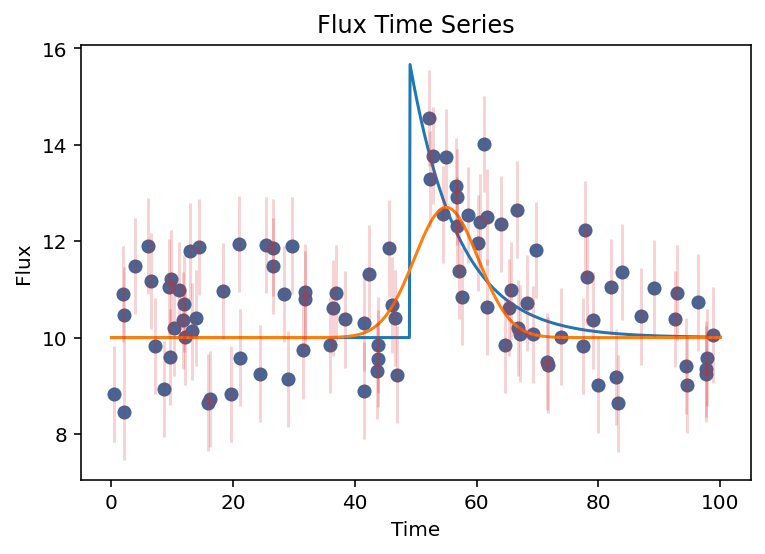

In [298]:
#sanity check plot
#checking for just the ultranest values
xgrid=np.linspace(0,100,1000)
    #r'$t_{0}$','b','A',r'$\alpha$'
theta1=[49,10,5.7,0.125 ]
theta2=[55,10,2.7,5.25 ]
burst=model(theta1,xgrid)
gauss=model_gauss(theta2,xgrid)
plt.plot(xgrid,burst)
plt.plot(xgrid,gauss)
#plotting data
plt.scatter(time,flux)
plt.errorbar(time,flux,error,fmt="o",color="C3",alpha=.2)#loc="lower right"
#C0 blue,C1 orange,C2 GREEN, C3 red, C4 weak purple 
plt.axis
plt.xlabel("Time")
plt.ylabel("Flux")
plt.title("Flux Time Series")